In [1]:
import cv2
import numpy as np
import os

In [2]:
import matplotlib.cm as cm

In [3]:
import matplotlib.pyplot as plt

In [4]:
import math

In [5]:
np.set_printoptions(threshold=np.inf)

In [6]:
def read_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

In [165]:
images = []
class_ = []
path='bearing/'
for folder in os.listdir(path):
    for file in os.listdir(path+folder):
        images.append(read_image(path+folder+'/'+file))
        class_.append(folder)

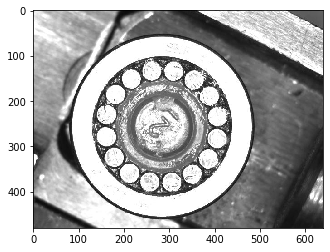

In [232]:
plt.imshow(images[0], cmap=cm.gray, vmin=0, vmax=255)

In [167]:
class_[0]

'Good'

In [68]:
image1 = read_image('3.png')

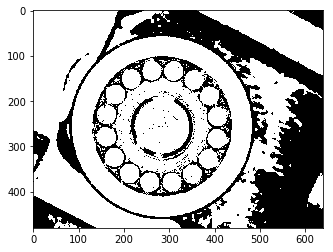

In [69]:
test = image1.copy()
for i in range(test.shape[0]):
    for j in range(test.shape[1]):
        if test[i][j]<100:
            test[i][j]=0
        else:
            test[i][j]=255
plt.imshow(test, cmap=cm.gray, vmin=0, vmax=255)

In [70]:
image = test

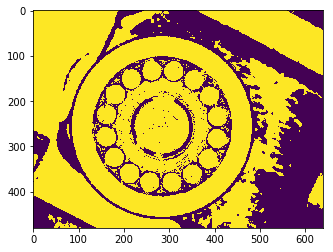

In [71]:
plt.imshow(image)

In [72]:
m = image.shape[0]
n = image.shape[1]

In [73]:
def smoothen_image(image):
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if i>0 and j>0 and i<image.shape[0]-1 and j<image.shape[1]-1:
                image[i][j] = int((image[i][j]+image[i-1][j]+image[i][j-1]+image[i+1][j]+image[i][j+1])/5)
    return image

In [74]:
def is_edge(image,x, threshold = 150):
    xi, xj = x
    if xi>0 and xj>0 and xi<image.shape[0]-1 and xj<image.shape[1]-1:
        for (i, j) in [(1,0),(0,1),(-1,0),(0,-1)]:
            if abs(image[xi+i][xj+j] - image[xi][xj])>threshold:
                    return True
    return False

In [102]:
def remove_noise(image, half_kernel_size = 1):
    image1 = image.copy()
    total = (2*half_kernel_size+1)**2
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if i-half_kernel_size>=0 and j-half_kernel_size>=0 and i+half_kernel_size<image.shape[0] and j+half_kernel_size<image.shape[1]:
                sum_ = 0
                for k in range(i-half_kernel_size, i+half_kernel_size+1):
                    for l in range(j-half_kernel_size, j+half_kernel_size+1):
                        sum_+=image[k][l]
                if total-sum_<=8:
                    image1[i][j]=1
    return image1

In [105]:
edges = np.array([[0]*image.shape[1]]*image.shape[0])
for i in range(m):
    for j in range(n):
        if not is_edge(image, (i,j)):
            edges[i][j]=1
#edges = remove_noise(edges, half_kernel_size=3)

c:\users\aakasht\appdata\local\continuum\anaconda3\envs\py361\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in ubyte_scalars
  """


In [106]:
plt.imshow(edges, cmap=cm.gray, vmin=0, vmax=1)

In [35]:
def ecl_dist(x,y):
    return math.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)

In [36]:
def is_center(A,B,error_pixel=3):
    C = (B[0],A[1])
    if abs(ecl_dist(A,C)-ecl_dist(B,C)) < error_pixel:
        return True
    return False

In [37]:
def is_an_edge(image, x, error):
    for i in range(-error,error+1):
        for j in range(-error,error+1):
            
            if x[0]+i>=0 and x[0]+i<image.shape[0] and x[1]+j>=0 and x[1]+j<image.shape[1] and image[x[0]+i][x[1]+j] == 0:
                return True
    return False

In [38]:
def is_circle(image, C, R, error = 1, threshold = 0.9):
    colored = 0
    total = 0
    degree = 0
    while degree<360:
        xi = round(C[0]+R*math.cos(degree * math.pi / 180))
        xj = round(C[1]+R*math.sin(degree * math.pi / 180))
        if is_an_edge(image, (xi,xj), error):
            colored+=1
        total+=1
        if colored/total<threshold:
            return False
        degree+=0.01
    return True

In [39]:
def draw_bounding_box(image, C_, R_):
    bounded = image.copy()
    for k in range(len(C_)):
        C = C_[k]
        R = int(R_[k])
        for i in range(C[0]-R, C[0]+R):
            for j in [C[1]-R, C[1]+R]:
                bounded[i][j] = 0
                bounded[i][j+1] = 0
        for j in range(C[1]-R, C[1]+R):
            for i in [C[0]-R, C[0]+R]:
                bounded[i][j] = 0
                bounded[i+1][j] = 0
    return bounded

In [40]:
def get_black_pixels(image):
    indexes = []
    maxlen = 0
    for i in range(image.shape[0]):
        index = []
        for j in range(image.shape[1]):
            if image[i][j]==0:
                index.append(j)
        indexes.append(index)
        maxlen = max(maxlen, len(index))
    
    indexes1 = np.array([[-1]*maxlen]*image.shape[0])
    
    for i in range(len(indexes)):
        for j in range(len(indexes[i])):
            indexes1[i][j] = indexes[i][j]
    
    return indexes1

In [41]:
### Here A and B are in straight line
def find_circle(image):
    m = image.shape[0]
    n = image.shape[1]
    max_R = []
    max_C = []
    max_circum = None
    count = 0
    dark_pixels = get_black_pixels(image)
    for i in range(dark_pixels.shape[0]):
        for ind in range(dark_pixels[i].shape[0]-1):
            j = dark_pixels[i][ind]
            if j == -1:
                break
            for ind1 in range(ind+1,dark_pixels[i].shape[0]):
                k = dark_pixels[i][ind1]
                if k == -1:
                    break
                if k-j < min(image.shape[0], image.shape[1])/5:
                    continue
                #print((i,j),(i,k))
                count+=1
#                 if count%1000:
#                     print(count)
                C = (i, int((j+k)/2))
                R = ecl_dist((i,j),C)
                print(C,R)
                if is_circle(image, C, R, error= 1, threshold=0.7):
                    max_R.append(R)
                    max_C.append(C)
#                     if R>max_R:
#                         max_R = R
#                         max_C = C
    return max_R, max_C

In [42]:
max_R, max_C = find_circle(edges)

(1, 242) 52.0
(1, 275) 85.0
(1, 275) 85.0
(1, 276) 86.0
(1, 375) 185.0
(1, 376) 186.0
(1, 378) 188.0
(1, 379) 189.0
(1, 380) 190.0
(1, 382) 192.0
(1, 301) 58.0
(1, 302) 59.0
(1, 302) 59.0
(1, 401) 158.0
(1, 403) 160.0
(1, 405) 162.0
(1, 405) 162.0
(1, 407) 164.0
(1, 409) 166.0
(1, 302) 58.0
(1, 302) 58.0
(1, 303) 59.0
(1, 402) 158.0
(1, 403) 159.0
(1, 405) 161.0
(1, 406) 162.0
(1, 407) 163.0
(1, 409) 165.0
(1, 302) 57.0
(1, 303) 58.0
(1, 303) 58.0
(1, 402) 157.0
(1, 404) 159.0
(1, 406) 161.0
(1, 406) 161.0
(1, 408) 163.0
(1, 410) 165.0
(1, 415) 144.0
(1, 417) 146.0
(1, 419) 148.0
(1, 419) 148.0
(1, 421) 150.0
(1, 423) 152.0
(1, 420) 140.0
(1, 421) 141.0
(1, 423) 143.0
(1, 424) 144.0
(1, 425) 145.0
(1, 427) 147.0
(1, 420) 139.0
(1, 422) 141.0
(1, 424) 143.0
(1, 424) 143.0
(1, 426) 145.0
(1, 428) 147.0
(1, 421) 139.0
(1, 422) 140.0
(1, 424) 142.0
(1, 425) 143.0
(1, 426) 144.0
(1, 428) 146.0
(1, 427) 133.0
(1, 428) 134.0
(1, 430) 136.0
(1, 431) 137.0
(1, 432) 138.0
(1, 434) 140.0
(1, 460)

(8, 242) 56.0
(8, 242) 56.0
(8, 243) 57.0
(8, 279) 93.0
(8, 280) 94.0
(8, 379) 193.0
(8, 379) 193.0
(8, 380) 194.0
(8, 383) 197.0
(8, 384) 198.0
(8, 298) 74.0
(8, 299) 75.0
(8, 398) 174.0
(8, 398) 174.0
(8, 399) 175.0
(8, 402) 178.0
(8, 403) 179.0
(8, 322) 51.0
(8, 322) 51.0
(8, 421) 150.0
(8, 422) 151.0
(8, 422) 151.0
(8, 425) 154.0
(8, 427) 156.0
(8, 322) 50.0
(8, 323) 51.0
(8, 422) 150.0
(8, 422) 150.0
(8, 423) 151.0
(8, 426) 154.0
(8, 427) 155.0
(8, 425) 146.0
(8, 426) 147.0
(8, 426) 147.0
(8, 429) 150.0
(8, 431) 152.0
(8, 426) 146.0
(8, 426) 146.0
(8, 427) 147.0
(8, 430) 150.0
(8, 431) 151.0
(8, 426) 145.0
(8, 427) 146.0
(8, 427) 146.0
(8, 430) 149.0
(8, 432) 151.0
(8, 427) 145.0
(8, 427) 145.0
(8, 428) 146.0
(8, 431) 149.0
(8, 432) 150.0
(8, 427) 144.0
(8, 428) 145.0
(8, 428) 145.0
(8, 431) 148.0
(8, 433) 150.0
(8, 428) 144.0
(8, 428) 144.0
(8, 429) 145.0
(8, 432) 148.0
(8, 433) 149.0
(8, 428) 143.0
(8, 429) 144.0
(8, 429) 144.0
(8, 432) 147.0
(8, 434) 149.0
(8, 429) 143.0
(8, 42

(14, 335) 51.0
(14, 434) 150.0
(14, 434) 150.0
(14, 435) 151.0
(14, 436) 152.0
(14, 334) 49.0
(14, 335) 50.0
(14, 335) 50.0
(14, 434) 149.0
(14, 435) 150.0
(14, 435) 150.0
(14, 436) 151.0
(14, 335) 49.0
(14, 335) 49.0
(14, 336) 50.0
(14, 435) 149.0
(14, 435) 149.0
(14, 436) 150.0
(14, 437) 151.0
(14, 335) 48.0
(14, 336) 49.0
(14, 336) 49.0
(14, 435) 148.0
(14, 436) 149.0
(14, 436) 149.0
(14, 437) 150.0
(14, 437) 146.0
(14, 438) 147.0
(14, 438) 147.0
(14, 439) 148.0
(14, 484) 100.0
(14, 484) 100.0
(14, 485) 101.0
(14, 486) 102.0
(14, 484) 99.0
(14, 485) 100.0
(14, 485) 100.0
(14, 486) 101.0
(14, 485) 99.0
(14, 485) 99.0
(14, 486) 100.0
(14, 487) 101.0
(15, 234) 52.0
(15, 237) 55.0
(15, 284) 102.0
(15, 384) 202.0
(15, 389) 207.0
(15, 294) 93.0
(15, 394) 193.0
(15, 399) 198.0
(15, 294) 92.0
(15, 394) 192.0
(15, 399) 197.0
(15, 324) 62.0
(15, 424) 162.0
(15, 429) 167.0
(15, 325) 61.0
(15, 425) 161.0
(15, 430) 166.0
(15, 337) 50.0
(15, 437) 150.0
(15, 442) 155.0
(15, 439) 147.0
(15, 444) 15

(29, 423) 189.0
(29, 365) 49.0
(29, 464) 148.0
(29, 466) 146.0
(29, 514) 99.0
(30, 247) 68.0
(30, 249) 70.0
(30, 297) 118.0
(30, 298) 119.0
(30, 396) 217.0
(30, 396) 217.0
(30, 397) 218.0
(30, 254) 61.0
(30, 256) 63.0
(30, 304) 111.0
(30, 305) 112.0
(30, 403) 210.0
(30, 403) 210.0
(30, 404) 211.0
(30, 324) 91.0
(30, 325) 92.0
(30, 423) 190.0
(30, 423) 190.0
(30, 424) 191.0
(30, 366) 50.0
(30, 366) 50.0
(30, 464) 148.0
(30, 465) 149.0
(30, 465) 149.0
(30, 368) 48.0
(30, 368) 48.0
(30, 466) 146.0
(30, 467) 147.0
(30, 467) 147.0
(30, 514) 98.0
(30, 515) 99.0
(30, 515) 99.0
(30, 515) 98.0
(30, 515) 98.0
(30, 516) 99.0
(31, 228) 49.0
(31, 229) 50.0
(31, 229) 50.0
(31, 248) 69.0
(31, 248) 69.0
(31, 249) 70.0
(31, 298) 119.0
(31, 299) 120.0
(31, 397) 218.0
(31, 398) 219.0
(31, 255) 61.0
(31, 256) 62.0
(31, 256) 62.0
(31, 306) 112.0
(31, 306) 112.0
(31, 405) 211.0
(31, 405) 211.0
(31, 325) 93.0
(31, 325) 93.0
(31, 424) 192.0
(31, 424) 192.0
(31, 348) 70.0
(31, 348) 70.0
(31, 447) 169.0
(31, 44

(45, 275) 94.0
(45, 316) 135.0
(45, 316) 135.0
(45, 317) 136.0
(45, 292) 77.0
(45, 292) 77.0
(45, 333) 118.0
(45, 333) 118.0
(45, 334) 119.0
(46, 256) 84.0
(46, 270) 98.0
(46, 271) 99.0
(46, 312) 140.0
(46, 260) 79.0
(46, 274) 93.0
(46, 276) 95.0
(46, 317) 136.0
(46, 277) 63.0
(46, 291) 77.0
(46, 292) 78.0
(46, 333) 119.0
(46, 396) 56.0
(47, 222) 50.0
(47, 226) 54.0
(47, 227) 55.0
(47, 255) 83.0
(47, 256) 84.0
(47, 257) 85.0
(47, 257) 85.0
(47, 270) 98.0
(47, 271) 99.0
(47, 313) 141.0
(47, 230) 50.0
(47, 231) 51.0
(47, 259) 79.0
(47, 260) 80.0
(47, 261) 81.0
(47, 261) 81.0
(47, 274) 94.0
(47, 275) 95.0
(47, 317) 137.0
(47, 276) 63.0
(47, 277) 64.0
(47, 277) 64.0
(47, 278) 65.0
(47, 290) 77.0
(47, 292) 79.0
(47, 333) 120.0
(47, 320) 48.0
(47, 321) 49.0
(47, 363) 91.0
(47, 367) 86.0
(47, 368) 86.0
(47, 396) 57.0
(47, 397) 56.0
(47, 398) 56.0
(47, 398) 55.0
(48, 221) 50.0
(48, 222) 51.0
(48, 225) 54.0
(48, 227) 56.0
(48, 227) 56.0
(48, 255) 84.0
(48, 256) 85.0
(48, 257) 86.0
(48, 258) 87.

(59, 256) 91.0
(59, 256) 91.0
(59, 257) 92.0
(59, 261) 96.0
(59, 319) 154.0
(59, 320) 155.0
(59, 241) 65.0
(59, 242) 66.0
(59, 242) 66.0
(59, 243) 67.0
(59, 243) 67.0
(59, 244) 68.0
(59, 244) 68.0
(59, 245) 69.0
(59, 261) 85.0
(59, 262) 86.0
(59, 262) 86.0
(59, 266) 90.0
(59, 325) 149.0
(59, 325) 149.0
(59, 286) 60.0
(59, 287) 61.0
(59, 287) 61.0
(59, 291) 65.0
(59, 350) 124.0
(59, 350) 124.0
(59, 287) 60.0
(59, 287) 60.0
(59, 288) 61.0
(59, 292) 65.0
(59, 350) 123.0
(59, 351) 124.0
(59, 287) 59.0
(59, 288) 60.0
(59, 288) 60.0
(59, 292) 64.0
(59, 351) 123.0
(59, 351) 123.0
(59, 305) 51.0
(59, 364) 110.0
(59, 364) 110.0
(59, 306) 51.0
(59, 364) 109.0
(59, 365) 110.0
(59, 306) 50.0
(59, 365) 109.0
(59, 365) 109.0
(59, 307) 50.0
(59, 365) 108.0
(59, 366) 109.0
(59, 307) 49.0
(59, 366) 108.0
(59, 366) 108.0
(59, 308) 49.0
(59, 366) 107.0
(59, 367) 108.0
(59, 308) 48.0
(59, 367) 107.0
(59, 367) 107.0
(59, 309) 48.0
(59, 367) 106.0
(59, 368) 107.0
(59, 368) 106.0
(59, 368) 106.0
(59, 368) 10

(65, 292) 81.0
(65, 310) 99.0
(65, 311) 100.0
(65, 311) 100.0
(65, 349) 138.0
(65, 349) 138.0
(65, 275) 63.0
(65, 275) 63.0
(65, 276) 64.0
(65, 285) 73.0
(65, 286) 74.0
(65, 289) 77.0
(65, 290) 78.0
(65, 291) 79.0
(65, 291) 79.0
(65, 292) 80.0
(65, 311) 99.0
(65, 311) 99.0
(65, 312) 100.0
(65, 349) 137.0
(65, 350) 138.0
(65, 283) 55.0
(65, 283) 55.0
(65, 284) 56.0
(65, 293) 65.0
(65, 294) 66.0
(65, 297) 69.0
(65, 298) 70.0
(65, 299) 71.0
(65, 299) 71.0
(65, 300) 72.0
(65, 319) 91.0
(65, 319) 91.0
(65, 320) 92.0
(65, 357) 129.0
(65, 358) 130.0
(65, 283) 54.0
(65, 284) 55.0
(65, 284) 55.0
(65, 294) 65.0
(65, 295) 66.0
(65, 297) 68.0
(65, 298) 69.0
(65, 299) 70.0
(65, 300) 71.0
(65, 301) 72.0
(65, 319) 90.0
(65, 320) 91.0
(65, 320) 91.0
(65, 358) 129.0
(65, 358) 129.0
(65, 284) 54.0
(65, 284) 54.0
(65, 285) 55.0
(65, 294) 64.0
(65, 295) 65.0
(65, 298) 68.0
(65, 299) 69.0
(65, 300) 70.0
(65, 300) 70.0
(65, 301) 71.0
(65, 320) 90.0
(65, 320) 90.0
(65, 321) 91.0
(65, 358) 128.0
(65, 359) 129

(72, 305) 108.0
(72, 306) 109.0
(72, 349) 152.0
(72, 349) 152.0
(72, 283) 75.0
(72, 284) 76.0
(72, 291) 83.0
(72, 292) 84.0
(72, 295) 87.0
(72, 299) 91.0
(72, 300) 92.0
(72, 304) 96.0
(72, 306) 98.0
(72, 307) 99.0
(72, 307) 99.0
(72, 308) 100.0
(72, 308) 100.0
(72, 309) 101.0
(72, 310) 102.0
(72, 311) 103.0
(72, 311) 103.0
(72, 354) 146.0
(72, 355) 147.0
(72, 284) 75.0
(72, 284) 75.0
(72, 291) 82.0
(72, 292) 83.0
(72, 296) 87.0
(72, 299) 90.0
(72, 300) 91.0
(72, 305) 96.0
(72, 307) 98.0
(72, 307) 98.0
(72, 308) 99.0
(72, 308) 99.0
(72, 309) 100.0
(72, 309) 100.0
(72, 311) 102.0
(72, 311) 102.0
(72, 312) 103.0
(72, 355) 146.0
(72, 355) 146.0
(72, 284) 74.0
(72, 285) 75.0
(72, 292) 82.0
(72, 293) 83.0
(72, 296) 86.0
(72, 300) 90.0
(72, 301) 91.0
(72, 305) 95.0
(72, 307) 97.0
(72, 308) 98.0
(72, 308) 98.0
(72, 309) 99.0
(72, 309) 99.0
(72, 310) 100.0
(72, 311) 101.0
(72, 312) 102.0
(72, 312) 102.0
(72, 355) 145.0
(72, 356) 146.0
(72, 430) 71.0
(72, 430) 71.0
(72, 430) 70.0
(72, 431) 71.0


(82, 348) 170.0
(82, 282) 98.0
(82, 282) 98.0
(82, 291) 107.0
(82, 294) 110.0
(82, 295) 111.0
(82, 295) 111.0
(82, 300) 116.0
(82, 300) 116.0
(82, 301) 117.0
(82, 301) 117.0
(82, 302) 118.0
(82, 302) 118.0
(82, 351) 167.0
(82, 284) 96.0
(82, 284) 96.0
(82, 293) 105.0
(82, 296) 108.0
(82, 297) 109.0
(82, 297) 109.0
(82, 302) 114.0
(82, 302) 114.0
(82, 303) 115.0
(82, 303) 115.0
(82, 304) 116.0
(82, 304) 116.0
(82, 353) 165.0
(82, 284) 95.0
(82, 285) 96.0
(82, 293) 104.0
(82, 297) 108.0
(82, 297) 108.0
(82, 298) 109.0
(82, 302) 113.0
(82, 303) 114.0
(82, 303) 114.0
(82, 304) 115.0
(82, 304) 115.0
(82, 305) 116.0
(82, 354) 165.0
(82, 449) 69.0
(82, 450) 69.0
(82, 458) 60.0
(82, 462) 57.0
(82, 462) 56.0
(82, 463) 56.0
(82, 467) 51.0
(82, 468) 51.0
(82, 468) 50.0
(82, 469) 50.0
(82, 469) 49.0
(82, 470) 49.0
(83, 268) 114.0
(83, 268) 114.0
(83, 276) 122.0
(83, 277) 123.0
(83, 277) 123.0
(83, 278) 124.0
(83, 278) 124.0
(83, 279) 125.0
(83, 280) 126.0
(83, 288) 134.0
(83, 288) 134.0
(83, 337) 

(96, 333) 211.0
(96, 336) 214.0
(96, 275) 127.0
(96, 275) 127.0
(96, 287) 139.0
(96, 288) 140.0
(96, 294) 146.0
(96, 346) 198.0
(96, 349) 201.0
(96, 284) 118.0
(96, 284) 118.0
(96, 296) 130.0
(96, 297) 131.0
(96, 303) 137.0
(96, 355) 189.0
(96, 358) 192.0
(96, 473) 71.0
(96, 476) 74.0
(96, 474) 71.0
(96, 477) 74.0
(96, 486) 59.0
(96, 489) 62.0
(96, 486) 58.0
(96, 489) 61.0
(96, 492) 52.0
(96, 495) 55.0
(97, 260) 143.0
(97, 272) 155.0
(97, 278) 161.0
(97, 279) 162.0
(97, 279) 162.0
(97, 331) 214.0
(97, 332) 215.0
(97, 332) 215.0
(97, 333) 216.0
(97, 333) 216.0
(97, 334) 217.0
(97, 335) 218.0
(97, 263) 141.0
(97, 275) 153.0
(97, 281) 159.0
(97, 281) 159.0
(97, 282) 160.0
(97, 334) 212.0
(97, 334) 212.0
(97, 335) 213.0
(97, 335) 213.0
(97, 336) 214.0
(97, 336) 214.0
(97, 337) 215.0
(97, 275) 128.0
(97, 287) 140.0
(97, 293) 146.0
(97, 294) 147.0
(97, 294) 147.0
(97, 346) 199.0
(97, 347) 200.0
(97, 347) 200.0
(97, 348) 201.0
(97, 348) 201.0
(97, 349) 202.0
(97, 350) 203.0
(97, 284) 119.0
(9

(102, 351) 68.0
(102, 359) 76.0
(102, 361) 78.0
(102, 362) 79.0
(102, 363) 80.0
(102, 363) 80.0
(102, 364) 81.0
(102, 366) 83.0
(102, 367) 84.0
(102, 420) 137.0
(102, 347) 63.0
(102, 352) 68.0
(102, 360) 76.0
(102, 362) 78.0
(102, 362) 78.0
(102, 363) 79.0
(102, 364) 80.0
(102, 364) 80.0
(102, 366) 82.0
(102, 368) 84.0
(102, 421) 137.0
(102, 347) 62.0
(102, 352) 67.0
(102, 360) 75.0
(102, 362) 77.0
(102, 363) 78.0
(102, 364) 79.0
(102, 364) 79.0
(102, 365) 80.0
(102, 367) 82.0
(102, 368) 83.0
(102, 421) 136.0
(102, 348) 62.0
(102, 353) 67.0
(102, 361) 75.0
(102, 363) 77.0
(102, 363) 77.0
(102, 364) 78.0
(102, 365) 79.0
(102, 365) 79.0
(102, 367) 81.0
(102, 369) 83.0
(102, 422) 136.0
(102, 348) 61.0
(102, 353) 66.0
(102, 361) 74.0
(102, 363) 76.0
(102, 364) 77.0
(102, 365) 78.0
(102, 365) 78.0
(102, 366) 79.0
(102, 368) 81.0
(102, 369) 82.0
(102, 422) 135.0
(102, 349) 61.0
(102, 354) 66.0
(102, 362) 74.0
(102, 364) 76.0
(102, 364) 76.0
(102, 365) 77.0
(102, 366) 78.0
(102, 366) 78.0
(10

(105, 408) 155.0
(105, 409) 156.0
(105, 334) 80.0
(105, 337) 83.0
(105, 338) 84.0
(105, 344) 90.0
(105, 356) 102.0
(105, 357) 103.0
(105, 367) 113.0
(105, 367) 113.0
(105, 368) 114.0
(105, 368) 114.0
(105, 369) 115.0
(105, 369) 115.0
(105, 370) 116.0
(105, 370) 116.0
(105, 408) 154.0
(105, 409) 155.0
(105, 409) 155.0
(105, 334) 79.0
(105, 338) 83.0
(105, 338) 83.0
(105, 345) 90.0
(105, 357) 102.0
(105, 357) 102.0
(105, 367) 112.0
(105, 368) 113.0
(105, 368) 113.0
(105, 369) 114.0
(105, 369) 114.0
(105, 370) 115.0
(105, 370) 115.0
(105, 371) 116.0
(105, 409) 154.0
(105, 409) 154.0
(105, 410) 155.0
(105, 335) 79.0
(105, 338) 82.0
(105, 339) 83.0
(105, 345) 89.0
(105, 357) 101.0
(105, 358) 102.0
(105, 368) 112.0
(105, 368) 112.0
(105, 369) 113.0
(105, 369) 113.0
(105, 370) 114.0
(105, 370) 114.0
(105, 371) 115.0
(105, 371) 115.0
(105, 409) 153.0
(105, 410) 154.0
(105, 410) 154.0
(105, 335) 78.0
(105, 339) 82.0
(105, 339) 82.0
(105, 346) 89.0
(105, 358) 101.0
(105, 358) 101.0
(105, 368) 11

(107, 299) 158.0
(107, 301) 160.0
(107, 309) 168.0
(107, 315) 174.0
(107, 315) 174.0
(107, 354) 213.0
(107, 354) 213.0
(107, 200) 48.0
(107, 202) 50.0
(107, 209) 57.0
(107, 226) 74.0
(107, 228) 76.0
(107, 229) 77.0
(107, 230) 78.0
(107, 230) 78.0
(107, 231) 79.0
(107, 232) 80.0
(107, 233) 81.0
(107, 234) 82.0
(107, 235) 83.0
(107, 237) 85.0
(107, 238) 86.0
(107, 238) 86.0
(107, 284) 132.0
(107, 287) 135.0
(107, 291) 139.0
(107, 292) 140.0
(107, 292) 140.0
(107, 305) 153.0
(107, 307) 155.0
(107, 314) 162.0
(107, 320) 168.0
(107, 321) 169.0
(107, 359) 207.0
(107, 360) 208.0
(107, 203) 50.0
(107, 210) 57.0
(107, 226) 73.0
(107, 228) 75.0
(107, 230) 77.0
(107, 230) 77.0
(107, 231) 78.0
(107, 232) 79.0
(107, 233) 80.0
(107, 234) 81.0
(107, 235) 82.0
(107, 235) 82.0
(107, 238) 85.0
(107, 238) 85.0
(107, 239) 86.0
(107, 284) 131.0
(107, 288) 135.0
(107, 292) 139.0
(107, 292) 139.0
(107, 293) 140.0
(107, 305) 152.0
(107, 307) 154.0
(107, 315) 162.0
(107, 321) 168.0
(107, 321) 168.0
(107, 360) 

(108, 444) 125.0
(108, 444) 125.0
(108, 375) 49.0
(108, 375) 49.0
(108, 378) 52.0
(108, 392) 66.0
(108, 394) 68.0
(108, 401) 75.0
(108, 408) 82.0
(108, 409) 83.0
(108, 447) 121.0
(108, 448) 122.0
(108, 375) 48.0
(108, 376) 49.0
(108, 379) 52.0
(108, 393) 66.0
(108, 394) 67.0
(108, 402) 75.0
(108, 409) 82.0
(108, 409) 82.0
(108, 448) 121.0
(108, 448) 121.0
(108, 376) 48.0
(108, 376) 48.0
(108, 379) 51.0
(108, 393) 65.0
(108, 395) 67.0
(108, 402) 74.0
(108, 409) 81.0
(108, 410) 82.0
(108, 448) 120.0
(108, 449) 121.0
(108, 377) 48.0
(108, 380) 51.0
(108, 394) 65.0
(108, 395) 66.0
(108, 403) 74.0
(108, 410) 81.0
(108, 410) 81.0
(108, 449) 120.0
(108, 449) 120.0
(108, 493) 76.0
(108, 493) 76.0
(108, 496) 72.0
(108, 497) 73.0
(108, 497) 72.0
(108, 497) 72.0
(108, 500) 69.0
(108, 500) 69.0
(108, 514) 55.0
(108, 514) 55.0
(108, 515) 53.0
(108, 516) 54.0
(109, 166) 69.0
(109, 168) 71.0
(109, 169) 72.0
(109, 170) 73.0
(109, 172) 75.0
(109, 180) 83.0
(109, 180) 83.0
(109, 181) 84.0
(109, 181) 84.

(110, 179) 76.0
(110, 180) 77.0
(110, 183) 80.0
(110, 184) 81.0
(110, 184) 81.0
(110, 187) 84.0
(110, 189) 86.0
(110, 190) 87.0
(110, 192) 89.0
(110, 192) 89.0
(110, 194) 91.0
(110, 196) 93.0
(110, 199) 96.0
(110, 200) 97.0
(110, 200) 97.0
(110, 201) 98.0
(110, 201) 98.0
(110, 202) 99.0
(110, 205) 102.0
(110, 206) 103.0
(110, 206) 103.0
(110, 207) 104.0
(110, 207) 104.0
(110, 213) 110.0
(110, 218) 115.0
(110, 218) 115.0
(110, 219) 116.0
(110, 261) 158.0
(110, 265) 162.0
(110, 266) 163.0
(110, 282) 179.0
(110, 283) 180.0
(110, 285) 182.0
(110, 286) 183.0
(110, 290) 187.0
(110, 298) 195.0
(110, 299) 196.0
(110, 338) 235.0
(110, 188) 48.0
(110, 189) 49.0
(110, 190) 50.0
(110, 192) 52.0
(110, 193) 53.0
(110, 197) 57.0
(110, 198) 58.0
(110, 198) 58.0
(110, 202) 62.0
(110, 202) 62.0
(110, 203) 63.0
(110, 206) 66.0
(110, 207) 67.0
(110, 208) 68.0
(110, 210) 70.0
(110, 211) 71.0
(110, 213) 73.0
(110, 214) 74.0
(110, 217) 77.0
(110, 218) 78.0
(110, 219) 79.0
(110, 219) 79.0
(110, 220) 80.0
(110

(111, 403) 170.0
(111, 404) 171.0
(111, 285) 51.0
(111, 285) 51.0
(111, 286) 52.0
(111, 327) 93.0
(111, 331) 97.0
(111, 347) 113.0
(111, 352) 118.0
(111, 355) 121.0
(111, 365) 131.0
(111, 365) 131.0
(111, 366) 132.0
(111, 404) 170.0
(111, 404) 170.0
(111, 287) 48.0
(111, 288) 49.0
(111, 288) 49.0
(111, 329) 90.0
(111, 334) 95.0
(111, 350) 111.0
(111, 354) 115.0
(111, 358) 119.0
(111, 367) 128.0
(111, 368) 129.0
(111, 368) 129.0
(111, 406) 167.0
(111, 407) 168.0
(111, 289) 48.0
(111, 289) 48.0
(111, 330) 89.0
(111, 335) 94.0
(111, 351) 110.0
(111, 355) 114.0
(111, 359) 118.0
(111, 368) 127.0
(111, 369) 128.0
(111, 369) 128.0
(111, 407) 166.0
(111, 408) 167.0
(111, 331) 88.0
(111, 336) 93.0
(111, 352) 109.0
(111, 356) 113.0
(111, 360) 117.0
(111, 369) 126.0
(111, 370) 127.0
(111, 370) 127.0
(111, 408) 165.0
(111, 409) 166.0
(111, 333) 87.0
(111, 337) 91.0
(111, 353) 107.0
(111, 358) 112.0
(111, 361) 115.0
(111, 371) 125.0
(111, 371) 125.0
(111, 372) 126.0
(111, 410) 164.0
(111, 410) 164.

(112, 226) 80.0
(112, 232) 86.0
(112, 232) 86.0
(112, 233) 87.0
(112, 233) 87.0
(112, 234) 88.0
(112, 234) 88.0
(112, 242) 96.0
(112, 243) 97.0
(112, 283) 137.0
(112, 303) 157.0
(112, 307) 161.0
(112, 311) 165.0
(112, 322) 176.0
(112, 323) 177.0
(112, 361) 215.0
(112, 361) 215.0
(112, 364) 218.0
(112, 365) 219.0
(112, 284) 55.0
(112, 284) 55.0
(112, 325) 96.0
(112, 345) 116.0
(112, 349) 120.0
(112, 353) 124.0
(112, 364) 135.0
(112, 364) 135.0
(112, 402) 173.0
(112, 403) 174.0
(112, 406) 177.0
(112, 406) 177.0
(112, 284) 54.0
(112, 285) 55.0
(112, 325) 95.0
(112, 345) 115.0
(112, 349) 119.0
(112, 353) 123.0
(112, 364) 134.0
(112, 365) 135.0
(112, 403) 173.0
(112, 403) 173.0
(112, 406) 176.0
(112, 407) 177.0
(112, 286) 52.0
(112, 287) 53.0
(112, 327) 93.0
(112, 347) 113.0
(112, 351) 117.0
(112, 355) 121.0
(112, 366) 132.0
(112, 367) 133.0
(112, 405) 171.0
(112, 405) 171.0
(112, 408) 174.0
(112, 409) 175.0
(112, 290) 48.0
(112, 291) 49.0
(112, 331) 89.0
(112, 351) 109.0
(112, 355) 113.0
(

(113, 352) 124.0
(113, 364) 136.0
(113, 403) 175.0
(113, 403) 175.0
(113, 406) 178.0
(113, 406) 178.0
(113, 407) 179.0
(113, 285) 56.0
(113, 285) 56.0
(113, 286) 57.0
(113, 325) 96.0
(113, 344) 115.0
(113, 344) 115.0
(113, 349) 120.0
(113, 350) 121.0
(113, 353) 124.0
(113, 365) 136.0
(113, 403) 174.0
(113, 404) 175.0
(113, 406) 177.0
(113, 407) 178.0
(113, 407) 178.0
(113, 285) 55.0
(113, 286) 56.0
(113, 286) 56.0
(113, 326) 96.0
(113, 344) 114.0
(113, 345) 115.0
(113, 350) 120.0
(113, 350) 120.0
(113, 353) 123.0
(113, 365) 135.0
(113, 404) 174.0
(113, 404) 174.0
(113, 407) 177.0
(113, 407) 177.0
(113, 408) 178.0
(113, 287) 53.0
(113, 288) 54.0
(113, 288) 54.0
(113, 328) 94.0
(113, 346) 112.0
(113, 347) 113.0
(113, 352) 118.0
(113, 352) 118.0
(113, 355) 121.0
(113, 367) 133.0
(113, 406) 172.0
(113, 406) 172.0
(113, 409) 175.0
(113, 409) 175.0
(113, 410) 176.0
(113, 293) 48.0
(113, 293) 48.0
(113, 294) 49.0
(113, 333) 88.0
(113, 352) 107.0
(113, 352) 107.0
(113, 357) 112.0
(113, 358) 11

(114, 324) 100.0
(114, 329) 105.0
(114, 330) 106.0
(114, 331) 107.0
(114, 332) 108.0
(114, 332) 108.0
(114, 333) 109.0
(114, 333) 109.0
(114, 334) 110.0
(114, 334) 110.0
(114, 335) 111.0
(114, 336) 112.0
(114, 339) 115.0
(114, 340) 116.0
(114, 340) 116.0
(114, 341) 117.0
(114, 348) 124.0
(114, 348) 124.0
(114, 349) 125.0
(114, 351) 127.0
(114, 363) 139.0
(114, 363) 139.0
(114, 402) 178.0
(114, 402) 178.0
(114, 403) 179.0
(114, 403) 179.0
(114, 404) 180.0
(114, 273) 48.0
(114, 284) 59.0
(114, 285) 60.0
(114, 324) 99.0
(114, 324) 99.0
(114, 330) 105.0
(114, 330) 105.0
(114, 332) 107.0
(114, 332) 107.0
(114, 333) 108.0
(114, 333) 108.0
(114, 334) 109.0
(114, 334) 109.0
(114, 335) 110.0
(114, 335) 110.0
(114, 336) 111.0
(114, 340) 115.0
(114, 340) 115.0
(114, 341) 116.0
(114, 341) 116.0
(114, 348) 123.0
(114, 349) 124.0
(114, 349) 124.0
(114, 351) 126.0
(114, 363) 138.0
(114, 364) 139.0
(114, 402) 177.0
(114, 403) 178.0
(114, 403) 178.0
(114, 404) 179.0
(114, 405) 180.0
(114, 285) 59.0
(11

(114, 381) 60.0
(114, 382) 61.0
(114, 382) 61.0
(114, 383) 62.0
(114, 383) 62.0
(114, 384) 63.0
(114, 388) 67.0
(114, 388) 67.0
(114, 389) 68.0
(114, 389) 68.0
(114, 396) 75.0
(114, 397) 76.0
(114, 397) 76.0
(114, 399) 78.0
(114, 411) 90.0
(114, 412) 91.0
(114, 450) 129.0
(114, 451) 130.0
(114, 451) 130.0
(114, 452) 131.0
(114, 453) 132.0
(114, 392) 48.0
(114, 392) 48.0
(114, 393) 49.0
(114, 393) 49.0
(114, 394) 50.0
(114, 394) 50.0
(114, 395) 51.0
(114, 396) 52.0
(114, 399) 55.0
(114, 400) 56.0
(114, 400) 56.0
(114, 401) 57.0
(114, 408) 64.0
(114, 408) 64.0
(114, 409) 65.0
(114, 411) 67.0
(114, 423) 79.0
(114, 423) 79.0
(114, 462) 118.0
(114, 462) 118.0
(114, 463) 119.0
(114, 463) 119.0
(114, 464) 120.0
(114, 393) 48.0
(114, 393) 48.0
(114, 394) 49.0
(114, 394) 49.0
(114, 395) 50.0
(114, 395) 50.0
(114, 396) 51.0
(114, 400) 55.0
(114, 400) 55.0
(114, 401) 56.0
(114, 401) 56.0
(114, 408) 63.0
(114, 409) 64.0
(114, 409) 64.0
(114, 411) 66.0
(114, 423) 78.0
(114, 424) 79.0
(114, 462) 117

(116, 332) 102.0
(116, 333) 103.0
(116, 338) 108.0
(116, 340) 110.0
(116, 340) 110.0
(116, 341) 111.0
(116, 341) 111.0
(116, 367) 137.0
(116, 367) 137.0
(116, 408) 178.0
(116, 409) 179.0
(116, 281) 49.0
(116, 290) 58.0
(116, 291) 59.0
(116, 328) 96.0
(116, 329) 97.0
(116, 333) 101.0
(116, 334) 102.0
(116, 339) 107.0
(116, 341) 109.0
(116, 341) 109.0
(116, 342) 110.0
(116, 342) 110.0
(116, 368) 136.0
(116, 368) 136.0
(116, 409) 177.0
(116, 410) 178.0
(116, 293) 55.0
(116, 294) 56.0
(116, 331) 93.0
(116, 332) 94.0
(116, 336) 98.0
(116, 337) 99.0
(116, 342) 104.0
(116, 344) 106.0
(116, 344) 106.0
(116, 345) 107.0
(116, 345) 107.0
(116, 371) 133.0
(116, 371) 133.0
(116, 412) 174.0
(116, 413) 175.0
(116, 294) 55.0
(116, 294) 55.0
(116, 332) 93.0
(116, 332) 93.0
(116, 337) 98.0
(116, 338) 99.0
(116, 343) 104.0
(116, 344) 105.0
(116, 345) 106.0
(116, 345) 106.0
(116, 346) 107.0
(116, 371) 132.0
(116, 372) 133.0
(116, 413) 174.0
(116, 413) 174.0
(116, 296) 52.0
(116, 297) 53.0
(116, 334) 90.0


(117, 368) 140.0
(117, 368) 140.0
(117, 369) 141.0
(117, 369) 141.0
(117, 370) 142.0
(117, 370) 142.0
(117, 408) 180.0
(117, 280) 49.0
(117, 281) 50.0
(117, 282) 51.0
(117, 291) 60.0
(117, 291) 60.0
(117, 329) 98.0
(117, 333) 102.0
(117, 334) 103.0
(117, 368) 137.0
(117, 369) 138.0
(117, 369) 138.0
(117, 370) 139.0
(117, 370) 139.0
(117, 371) 140.0
(117, 371) 140.0
(117, 372) 141.0
(117, 410) 179.0
(117, 284) 48.0
(117, 284) 48.0
(117, 293) 57.0
(117, 294) 58.0
(117, 331) 95.0
(117, 336) 100.0
(117, 336) 100.0
(117, 371) 135.0
(117, 371) 135.0
(117, 372) 136.0
(117, 372) 136.0
(117, 373) 137.0
(117, 373) 137.0
(117, 374) 138.0
(117, 374) 138.0
(117, 412) 176.0
(117, 285) 48.0
(117, 294) 57.0
(117, 294) 57.0
(117, 332) 95.0
(117, 336) 99.0
(117, 337) 100.0
(117, 371) 134.0
(117, 372) 135.0
(117, 372) 135.0
(117, 373) 136.0
(117, 373) 136.0
(117, 374) 137.0
(117, 374) 137.0
(117, 375) 138.0
(117, 413) 176.0
(117, 296) 55.0
(117, 296) 55.0
(117, 334) 93.0
(117, 338) 97.0
(117, 339) 98.0
(

(118, 397) 117.0
(118, 435) 155.0
(118, 355) 72.0
(118, 360) 77.0
(118, 361) 78.0
(118, 382) 99.0
(118, 398) 115.0
(118, 436) 153.0
(118, 356) 71.0
(118, 361) 76.0
(118, 362) 77.0
(118, 383) 98.0
(118, 399) 114.0
(118, 437) 152.0
(118, 357) 71.0
(118, 362) 76.0
(118, 362) 76.0
(118, 384) 98.0
(118, 400) 114.0
(118, 438) 152.0
(118, 357) 70.0
(118, 362) 75.0
(118, 363) 76.0
(118, 384) 97.0
(118, 400) 113.0
(118, 438) 151.0
(118, 358) 70.0
(118, 363) 75.0
(118, 363) 75.0
(118, 385) 97.0
(118, 401) 113.0
(118, 439) 151.0
(118, 358) 69.0
(118, 363) 74.0
(118, 364) 75.0
(118, 385) 96.0
(118, 401) 112.0
(118, 439) 150.0
(118, 359) 69.0
(118, 364) 74.0
(118, 364) 74.0
(118, 386) 96.0
(118, 402) 112.0
(118, 440) 150.0
(118, 362) 66.0
(118, 367) 71.0
(118, 367) 71.0
(118, 389) 93.0
(118, 405) 109.0
(118, 443) 147.0
(118, 362) 65.0
(118, 367) 70.0
(118, 368) 71.0
(118, 389) 92.0
(118, 405) 108.0
(118, 443) 146.0
(118, 376) 52.0
(118, 381) 57.0
(118, 381) 57.0
(118, 403) 79.0
(118, 419) 95.0
(118

(120, 184) 52.0
(120, 187) 55.0
(120, 205) 73.0
(120, 207) 75.0
(120, 207) 75.0
(120, 209) 77.0
(120, 211) 79.0
(120, 213) 81.0
(120, 229) 97.0
(120, 231) 99.0
(120, 233) 101.0
(120, 233) 101.0
(120, 234) 102.0
(120, 234) 102.0
(120, 236) 104.0
(120, 244) 112.0
(120, 281) 149.0
(120, 285) 153.0
(120, 286) 154.0
(120, 290) 158.0
(120, 290) 158.0
(120, 291) 159.0
(120, 291) 159.0
(120, 292) 160.0
(120, 292) 160.0
(120, 293) 161.0
(120, 293) 161.0
(120, 294) 162.0
(120, 294) 162.0
(120, 295) 163.0
(120, 323) 191.0
(120, 362) 230.0
(120, 187) 48.0
(120, 187) 48.0
(120, 191) 52.0
(120, 208) 69.0
(120, 210) 71.0
(120, 211) 72.0
(120, 212) 73.0
(120, 214) 75.0
(120, 216) 77.0
(120, 232) 93.0
(120, 235) 96.0
(120, 236) 97.0
(120, 237) 98.0
(120, 237) 98.0
(120, 238) 99.0
(120, 239) 100.0
(120, 248) 109.0
(120, 284) 145.0
(120, 288) 149.0
(120, 289) 150.0
(120, 293) 154.0
(120, 294) 155.0
(120, 294) 155.0
(120, 295) 156.0
(120, 295) 156.0
(120, 296) 157.0
(120, 296) 157.0
(120, 297) 158.0
(120,

(122, 165) 72.0
(122, 168) 75.0
(122, 187) 94.0
(122, 191) 98.0
(122, 192) 99.0
(122, 210) 117.0
(122, 213) 120.0
(122, 214) 121.0
(122, 216) 123.0
(122, 216) 123.0
(122, 226) 133.0
(122, 227) 134.0
(122, 262) 169.0
(122, 266) 173.0
(122, 267) 174.0
(122, 267) 174.0
(122, 269) 176.0
(122, 272) 179.0
(122, 276) 183.0
(122, 277) 184.0
(122, 280) 187.0
(122, 280) 187.0
(122, 281) 188.0
(122, 281) 188.0
(122, 282) 189.0
(122, 304) 211.0
(122, 344) 251.0
(122, 180) 50.0
(122, 183) 53.0
(122, 187) 57.0
(122, 205) 75.0
(122, 210) 80.0
(122, 210) 80.0
(122, 228) 98.0
(122, 231) 101.0
(122, 233) 103.0
(122, 234) 104.0
(122, 235) 105.0
(122, 245) 115.0
(122, 245) 115.0
(122, 280) 150.0
(122, 284) 154.0
(122, 285) 155.0
(122, 286) 156.0
(122, 287) 157.0
(122, 290) 160.0
(122, 295) 165.0
(122, 295) 165.0
(122, 298) 168.0
(122, 299) 169.0
(122, 299) 169.0
(122, 300) 170.0
(122, 300) 170.0
(122, 322) 192.0
(122, 363) 233.0
(122, 187) 50.0
(122, 190) 53.0
(122, 209) 72.0
(122, 213) 76.0
(122, 214) 77

(123, 326) 119.0
(123, 329) 122.0
(123, 329) 122.0
(123, 330) 123.0
(123, 334) 127.0
(123, 335) 128.0
(123, 336) 129.0
(123, 336) 129.0
(123, 338) 131.0
(123, 361) 154.0
(123, 402) 195.0
(123, 270) 57.0
(123, 274) 61.0
(123, 275) 62.0
(123, 275) 62.0
(123, 278) 65.0
(123, 279) 66.0
(123, 287) 74.0
(123, 288) 75.0
(123, 322) 109.0
(123, 326) 113.0
(123, 327) 114.0
(123, 328) 115.0
(123, 328) 115.0
(123, 329) 116.0
(123, 332) 119.0
(123, 332) 119.0
(123, 333) 120.0
(123, 337) 124.0
(123, 338) 125.0
(123, 339) 126.0
(123, 339) 126.0
(123, 341) 128.0
(123, 364) 151.0
(123, 405) 192.0
(123, 278) 50.0
(123, 281) 53.0
(123, 282) 54.0
(123, 283) 55.0
(123, 285) 57.0
(123, 287) 59.0
(123, 295) 67.0
(123, 295) 67.0
(123, 330) 102.0
(123, 334) 106.0
(123, 334) 106.0
(123, 335) 107.0
(123, 336) 108.0
(123, 336) 108.0
(123, 339) 111.0
(123, 340) 112.0
(123, 340) 112.0
(123, 345) 117.0
(123, 345) 117.0
(123, 346) 118.0
(123, 347) 119.0
(123, 348) 120.0
(123, 372) 144.0
(123, 412) 184.0
(123, 279) 48

(124, 323) 109.0
(124, 327) 113.0
(124, 328) 114.0
(124, 329) 115.0
(124, 329) 115.0
(124, 330) 116.0
(124, 334) 120.0
(124, 334) 120.0
(124, 339) 125.0
(124, 341) 127.0
(124, 365) 151.0
(124, 366) 152.0
(124, 366) 152.0
(124, 406) 192.0
(124, 406) 192.0
(124, 277) 52.0
(124, 280) 55.0
(124, 283) 58.0
(124, 284) 59.0
(124, 285) 60.0
(124, 286) 61.0
(124, 294) 69.0
(124, 329) 104.0
(124, 333) 108.0
(124, 334) 109.0
(124, 334) 109.0
(124, 335) 110.0
(124, 336) 111.0
(124, 339) 114.0
(124, 340) 115.0
(124, 344) 119.0
(124, 347) 122.0
(124, 371) 146.0
(124, 371) 146.0
(124, 372) 147.0
(124, 411) 186.0
(124, 412) 187.0
(124, 277) 51.0
(124, 281) 55.0
(124, 284) 58.0
(124, 285) 59.0
(124, 285) 59.0
(124, 286) 60.0
(124, 295) 69.0
(124, 329) 103.0
(124, 333) 107.0
(124, 334) 108.0
(124, 335) 109.0
(124, 335) 109.0
(124, 336) 110.0
(124, 340) 114.0
(124, 340) 114.0
(124, 345) 119.0
(124, 347) 121.0
(124, 371) 145.0
(124, 372) 146.0
(124, 372) 146.0
(124, 412) 186.0
(124, 412) 186.0
(124, 278) 

(125, 367) 232.0
(125, 368) 233.0
(125, 267) 62.0
(125, 271) 66.0
(125, 273) 68.0
(125, 274) 69.0
(125, 275) 70.0
(125, 276) 71.0
(125, 285) 80.0
(125, 285) 80.0
(125, 319) 114.0
(125, 323) 118.0
(125, 326) 121.0
(125, 330) 125.0
(125, 331) 126.0
(125, 337) 132.0
(125, 338) 133.0
(125, 338) 133.0
(125, 362) 157.0
(125, 363) 158.0
(125, 363) 158.0
(125, 364) 159.0
(125, 364) 159.0
(125, 365) 160.0
(125, 365) 160.0
(125, 402) 197.0
(125, 403) 198.0
(125, 269) 59.0
(125, 274) 64.0
(125, 276) 66.0
(125, 277) 67.0
(125, 277) 67.0
(125, 278) 68.0
(125, 287) 77.0
(125, 288) 78.0
(125, 322) 112.0
(125, 326) 116.0
(125, 328) 118.0
(125, 333) 123.0
(125, 333) 123.0
(125, 340) 130.0
(125, 340) 130.0
(125, 341) 131.0
(125, 365) 155.0
(125, 365) 155.0
(125, 366) 156.0
(125, 366) 156.0
(125, 367) 157.0
(125, 367) 157.0
(125, 368) 158.0
(125, 405) 195.0
(125, 405) 195.0
(125, 270) 58.0
(125, 275) 63.0
(125, 277) 65.0
(125, 278) 66.0
(125, 278) 66.0
(125, 279) 67.0
(125, 288) 76.0
(125, 289) 77.0
(125

(125, 445) 79.0
(125, 446) 80.0
(125, 483) 117.0
(125, 483) 117.0
(125, 517) 83.0
(125, 517) 83.0
(125, 521) 79.0
(125, 521) 79.0
(125, 523) 76.0
(125, 524) 77.0
(125, 528) 72.0
(125, 528) 72.0
(125, 528) 71.0
(125, 529) 72.0
(125, 535) 65.0
(125, 535) 65.0
(125, 535) 64.0
(125, 536) 65.0
(125, 536) 64.0
(125, 536) 64.0
(126, 142) 59.0
(126, 143) 60.0
(126, 143) 60.0
(126, 147) 64.0
(126, 149) 66.0
(126, 150) 67.0
(126, 153) 70.0
(126, 157) 74.0
(126, 162) 79.0
(126, 184) 101.0
(126, 186) 103.0
(126, 202) 119.0
(126, 206) 123.0
(126, 210) 127.0
(126, 211) 128.0
(126, 213) 130.0
(126, 214) 131.0
(126, 220) 137.0
(126, 220) 137.0
(126, 225) 142.0
(126, 225) 142.0
(126, 259) 176.0
(126, 263) 180.0
(126, 264) 181.0
(126, 265) 182.0
(126, 270) 187.0
(126, 277) 194.0
(126, 305) 222.0
(126, 342) 259.0
(126, 343) 260.0
(126, 146) 56.0
(126, 146) 56.0
(126, 147) 57.0
(126, 150) 60.0
(126, 152) 62.0
(126, 154) 64.0
(126, 157) 67.0
(126, 161) 71.0
(126, 166) 76.0
(126, 187) 97.0
(126, 190) 100.0


(127, 204) 78.0
(127, 206) 80.0
(127, 208) 82.0
(127, 228) 102.0
(127, 232) 106.0
(127, 241) 115.0
(127, 242) 116.0
(127, 247) 121.0
(127, 281) 155.0
(127, 284) 158.0
(127, 285) 159.0
(127, 286) 160.0
(127, 292) 166.0
(127, 299) 173.0
(127, 300) 174.0
(127, 327) 201.0
(127, 365) 239.0
(127, 182) 49.0
(127, 187) 54.0
(127, 207) 74.0
(127, 209) 76.0
(127, 211) 78.0
(127, 231) 98.0
(127, 235) 102.0
(127, 244) 111.0
(127, 246) 113.0
(127, 251) 118.0
(127, 284) 151.0
(127, 288) 155.0
(127, 289) 156.0
(127, 289) 156.0
(127, 296) 163.0
(127, 303) 170.0
(127, 303) 170.0
(127, 330) 197.0
(127, 368) 235.0
(127, 265) 64.0
(127, 269) 68.0
(127, 278) 77.0
(127, 280) 79.0
(127, 285) 84.0
(127, 318) 117.0
(127, 322) 121.0
(127, 323) 122.0
(127, 323) 122.0
(127, 330) 129.0
(127, 337) 136.0
(127, 337) 136.0
(127, 364) 163.0
(127, 402) 201.0
(127, 272) 57.0
(127, 276) 61.0
(127, 285) 70.0
(127, 287) 72.0
(127, 292) 77.0
(127, 325) 110.0
(127, 329) 114.0
(127, 330) 115.0
(127, 330) 115.0
(127, 337) 122.0

(128, 342) 113.0
(128, 343) 114.0
(128, 343) 114.0
(128, 352) 123.0
(128, 379) 150.0
(128, 379) 150.0
(128, 417) 188.0
(128, 417) 188.0
(128, 418) 189.0
(128, 280) 50.0
(128, 293) 63.0
(128, 295) 65.0
(128, 299) 69.0
(128, 300) 70.0
(128, 300) 70.0
(128, 333) 103.0
(128, 336) 106.0
(128, 338) 108.0
(128, 343) 113.0
(128, 343) 113.0
(128, 344) 114.0
(128, 352) 122.0
(128, 379) 149.0
(128, 380) 150.0
(128, 417) 187.0
(128, 418) 188.0
(128, 418) 188.0
(128, 281) 49.0
(128, 294) 62.0
(128, 296) 64.0
(128, 300) 68.0
(128, 301) 69.0
(128, 301) 69.0
(128, 334) 102.0
(128, 337) 105.0
(128, 339) 107.0
(128, 344) 112.0
(128, 344) 112.0
(128, 345) 113.0
(128, 353) 121.0
(128, 380) 148.0
(128, 381) 149.0
(128, 418) 186.0
(128, 419) 187.0
(128, 419) 187.0
(128, 299) 58.0
(128, 300) 59.0
(128, 304) 63.0
(128, 305) 64.0
(128, 306) 65.0
(128, 338) 97.0
(128, 342) 101.0
(128, 343) 102.0
(128, 348) 107.0
(128, 349) 108.0
(128, 349) 108.0
(128, 358) 117.0
(128, 385) 144.0
(128, 385) 144.0
(128, 423) 182.

(129, 338) 107.0
(129, 343) 112.0
(129, 353) 122.0
(129, 381) 150.0
(129, 381) 150.0
(129, 419) 188.0
(129, 420) 189.0
(129, 299) 58.0
(129, 300) 59.0
(129, 302) 61.0
(129, 302) 61.0
(129, 303) 62.0
(129, 304) 63.0
(129, 305) 64.0
(129, 306) 65.0
(129, 339) 98.0
(129, 342) 101.0
(129, 343) 102.0
(129, 348) 107.0
(129, 358) 117.0
(129, 386) 145.0
(129, 386) 145.0
(129, 424) 183.0
(129, 425) 184.0
(129, 360) 77.0
(129, 363) 80.0
(129, 364) 81.0
(129, 369) 86.0
(129, 379) 96.0
(129, 407) 124.0
(129, 407) 124.0
(129, 445) 162.0
(129, 446) 163.0
(129, 361) 75.0
(129, 365) 79.0
(129, 365) 79.0
(129, 371) 85.0
(129, 380) 94.0
(129, 408) 122.0
(129, 409) 123.0
(129, 447) 161.0
(129, 447) 161.0
(129, 362) 75.0
(129, 365) 78.0
(129, 366) 79.0
(129, 371) 84.0
(129, 381) 94.0
(129, 409) 122.0
(129, 409) 122.0
(129, 447) 160.0
(129, 448) 161.0
(129, 363) 74.0
(129, 366) 77.0
(129, 367) 78.0
(129, 372) 83.0
(129, 382) 93.0
(129, 410) 121.0
(129, 410) 121.0
(129, 448) 159.0
(129, 449) 160.0
(129, 384

(130, 411) 122.0
(130, 449) 160.0
(130, 450) 161.0
(130, 384) 53.0
(130, 388) 57.0
(130, 393) 62.0
(130, 403) 72.0
(130, 432) 101.0
(130, 470) 139.0
(130, 471) 140.0
(130, 419) 57.0
(130, 447) 85.0
(130, 486) 124.0
(130, 486) 124.0
(130, 421) 55.0
(130, 449) 83.0
(130, 488) 122.0
(130, 488) 122.0
(130, 422) 54.0
(130, 450) 82.0
(130, 489) 121.0
(130, 489) 121.0
(130, 424) 51.0
(130, 453) 80.0
(130, 491) 118.0
(130, 492) 119.0
(130, 524) 86.0
(130, 524) 86.0
(130, 527) 82.0
(130, 528) 83.0
(130, 532) 77.0
(130, 533) 78.0
(130, 543) 67.0
(130, 543) 67.0
(131, 138) 57.0
(131, 140) 59.0
(131, 142) 61.0
(131, 142) 61.0
(131, 143) 62.0
(131, 145) 64.0
(131, 146) 65.0
(131, 146) 65.0
(131, 152) 71.0
(131, 153) 72.0
(131, 157) 76.0
(131, 158) 77.0
(131, 161) 80.0
(131, 183) 102.0
(131, 184) 103.0
(131, 185) 104.0
(131, 206) 125.0
(131, 218) 137.0
(131, 219) 138.0
(131, 222) 141.0
(131, 222) 141.0
(131, 223) 142.0
(131, 223) 142.0
(131, 224) 143.0
(131, 227) 146.0
(131, 227) 146.0
(131, 260) 17

(132, 184) 100.0
(132, 184) 100.0
(132, 185) 101.0
(132, 186) 102.0
(132, 207) 123.0
(132, 207) 123.0
(132, 217) 133.0
(132, 217) 133.0
(132, 218) 134.0
(132, 218) 134.0
(132, 219) 135.0
(132, 219) 135.0
(132, 221) 137.0
(132, 221) 137.0
(132, 222) 138.0
(132, 223) 139.0
(132, 224) 140.0
(132, 224) 140.0
(132, 226) 142.0
(132, 227) 143.0
(132, 228) 144.0
(132, 229) 145.0
(132, 229) 145.0
(132, 230) 146.0
(132, 262) 178.0
(132, 265) 181.0
(132, 269) 185.0
(132, 281) 197.0
(132, 309) 225.0
(132, 349) 265.0
(132, 349) 265.0
(132, 174) 52.0
(132, 174) 52.0
(132, 175) 53.0
(132, 178) 56.0
(132, 179) 57.0
(132, 181) 59.0
(132, 202) 80.0
(132, 203) 81.0
(132, 203) 81.0
(132, 204) 82.0
(132, 205) 83.0
(132, 226) 104.0
(132, 226) 104.0
(132, 236) 114.0
(132, 236) 114.0
(132, 237) 115.0
(132, 237) 115.0
(132, 238) 116.0
(132, 238) 116.0
(132, 240) 118.0
(132, 240) 118.0
(132, 241) 119.0
(132, 242) 120.0
(132, 243) 121.0
(132, 243) 121.0
(132, 245) 123.0
(132, 246) 124.0
(132, 247) 125.0
(132, 24

(132, 416) 62.0
(132, 444) 90.0
(132, 484) 130.0
(132, 484) 130.0
(132, 405) 50.0
(132, 416) 61.0
(132, 445) 90.0
(132, 484) 129.0
(132, 485) 130.0
(132, 406) 48.0
(132, 418) 60.0
(132, 446) 88.0
(132, 486) 128.0
(132, 486) 128.0
(132, 407) 48.0
(132, 418) 59.0
(132, 447) 88.0
(132, 486) 127.0
(132, 487) 128.0
(132, 419) 59.0
(132, 447) 87.0
(132, 487) 127.0
(132, 487) 127.0
(132, 420) 57.0
(132, 449) 86.0
(132, 488) 125.0
(132, 489) 126.0
(132, 421) 57.0
(132, 449) 85.0
(132, 489) 125.0
(132, 489) 125.0
(132, 421) 56.0
(132, 450) 85.0
(132, 489) 124.0
(132, 490) 125.0
(132, 423) 55.0
(132, 451) 83.0
(132, 491) 123.0
(132, 491) 123.0
(132, 424) 53.0
(132, 453) 82.0
(132, 492) 121.0
(132, 493) 122.0
(132, 425) 53.0
(132, 453) 81.0
(132, 493) 121.0
(132, 493) 121.0
(132, 426) 52.0
(132, 454) 80.0
(132, 494) 120.0
(132, 494) 120.0
(132, 426) 51.0
(132, 455) 80.0
(132, 494) 119.0
(132, 495) 120.0
(132, 427) 51.0
(132, 455) 79.0
(132, 495) 119.0
(132, 495) 119.0
(132, 527) 87.0
(132, 527) 8

(134, 270) 75.0
(134, 271) 76.0
(134, 279) 84.0
(134, 282) 87.0
(134, 287) 92.0
(134, 287) 92.0
(134, 318) 123.0
(134, 322) 127.0
(134, 322) 127.0
(134, 323) 128.0
(134, 323) 128.0
(134, 324) 129.0
(134, 325) 130.0
(134, 337) 142.0
(134, 366) 171.0
(134, 406) 211.0
(134, 265) 66.0
(134, 266) 67.0
(134, 266) 67.0
(134, 272) 73.0
(134, 272) 73.0
(134, 273) 74.0
(134, 281) 82.0
(134, 284) 85.0
(134, 289) 90.0
(134, 289) 90.0
(134, 320) 121.0
(134, 324) 125.0
(134, 324) 125.0
(134, 325) 126.0
(134, 325) 126.0
(134, 326) 127.0
(134, 327) 128.0
(134, 339) 140.0
(134, 368) 169.0
(134, 408) 209.0
(134, 265) 65.0
(134, 266) 66.0
(134, 267) 67.0
(134, 272) 72.0
(134, 273) 73.0
(134, 273) 73.0
(134, 282) 82.0
(134, 284) 84.0
(134, 289) 89.0
(134, 290) 90.0
(134, 321) 121.0
(134, 324) 124.0
(134, 325) 125.0
(134, 325) 125.0
(134, 326) 126.0
(134, 326) 126.0
(134, 328) 128.0
(134, 339) 139.0
(134, 369) 169.0
(134, 409) 209.0
(134, 266) 65.0
(134, 267) 66.0
(134, 267) 66.0
(134, 273) 72.0
(134, 273)

(136, 291) 92.0
(136, 321) 122.0
(136, 328) 129.0
(136, 330) 131.0
(136, 339) 140.0
(136, 369) 170.0
(136, 410) 211.0
(136, 411) 212.0
(136, 282) 50.0
(136, 284) 52.0
(136, 287) 55.0
(136, 299) 67.0
(136, 301) 69.0
(136, 304) 72.0
(136, 305) 73.0
(136, 307) 75.0
(136, 307) 75.0
(136, 337) 105.0
(136, 345) 113.0
(136, 346) 114.0
(136, 356) 124.0
(136, 386) 154.0
(136, 427) 195.0
(136, 427) 195.0
(136, 283) 48.0
(136, 285) 50.0
(136, 289) 54.0
(136, 300) 65.0
(136, 303) 68.0
(136, 306) 71.0
(136, 306) 71.0
(136, 308) 73.0
(136, 309) 74.0
(136, 339) 104.0
(136, 346) 111.0
(136, 348) 113.0
(136, 357) 122.0
(136, 387) 152.0
(136, 428) 193.0
(136, 429) 194.0
(136, 286) 49.0
(136, 290) 53.0
(136, 301) 64.0
(136, 304) 67.0
(136, 307) 70.0
(136, 307) 70.0
(136, 309) 72.0
(136, 310) 73.0
(136, 340) 103.0
(136, 347) 110.0
(136, 349) 112.0
(136, 358) 121.0
(136, 388) 151.0
(136, 429) 192.0
(136, 430) 193.0
(136, 292) 51.0
(136, 303) 62.0
(136, 306) 65.0
(136, 309) 68.0
(136, 309) 68.0
(136, 311) 7

(137, 375) 86.0
(137, 375) 86.0
(137, 376) 87.0
(137, 376) 87.0
(137, 377) 88.0
(137, 377) 88.0
(137, 378) 89.0
(137, 384) 95.0
(137, 415) 126.0
(137, 419) 130.0
(137, 420) 131.0
(137, 456) 167.0
(137, 388) 56.0
(137, 395) 63.0
(137, 396) 64.0
(137, 396) 64.0
(137, 397) 65.0
(137, 397) 65.0
(137, 398) 66.0
(137, 398) 66.0
(137, 399) 67.0
(137, 399) 67.0
(137, 406) 74.0
(137, 436) 104.0
(137, 441) 109.0
(137, 441) 109.0
(137, 478) 146.0
(137, 390) 54.0
(137, 397) 61.0
(137, 398) 62.0
(137, 398) 62.0
(137, 399) 63.0
(137, 399) 63.0
(137, 400) 64.0
(137, 400) 64.0
(137, 401) 65.0
(137, 401) 65.0
(137, 408) 72.0
(137, 438) 102.0
(137, 443) 107.0
(137, 443) 107.0
(137, 480) 144.0
(137, 393) 51.0
(137, 400) 58.0
(137, 401) 59.0
(137, 401) 59.0
(137, 402) 60.0
(137, 402) 60.0
(137, 403) 61.0
(137, 403) 61.0
(137, 404) 62.0
(137, 404) 62.0
(137, 411) 69.0
(137, 441) 99.0
(137, 446) 104.0
(137, 446) 104.0
(137, 483) 141.0
(137, 426) 54.0
(137, 456) 84.0
(137, 461) 89.0
(137, 461) 89.0
(137, 498

(139, 207) 128.0
(139, 208) 129.0
(139, 262) 183.0
(139, 270) 191.0
(139, 274) 195.0
(139, 279) 200.0
(139, 311) 232.0
(139, 312) 233.0
(139, 312) 233.0
(139, 313) 234.0
(139, 316) 237.0
(139, 353) 274.0
(139, 354) 275.0
(139, 175) 58.0
(139, 179) 62.0
(139, 200) 83.0
(139, 203) 86.0
(139, 224) 107.0
(139, 224) 107.0
(139, 226) 109.0
(139, 227) 110.0
(139, 281) 164.0
(139, 289) 172.0
(139, 293) 176.0
(139, 298) 181.0
(139, 330) 213.0
(139, 331) 214.0
(139, 331) 214.0
(139, 332) 215.0
(139, 335) 218.0
(139, 372) 255.0
(139, 373) 256.0
(139, 178) 55.0
(139, 182) 59.0
(139, 203) 80.0
(139, 206) 83.0
(139, 227) 104.0
(139, 227) 104.0
(139, 229) 106.0
(139, 230) 107.0
(139, 284) 161.0
(139, 292) 169.0
(139, 296) 173.0
(139, 301) 178.0
(139, 333) 210.0
(139, 334) 211.0
(139, 334) 211.0
(139, 335) 212.0
(139, 338) 215.0
(139, 375) 252.0
(139, 376) 253.0
(139, 233) 49.0
(139, 236) 52.0
(139, 257) 73.0
(139, 258) 74.0
(139, 259) 75.0
(139, 261) 77.0
(139, 314) 130.0
(139, 322) 138.0
(139, 327) 

(140, 446) 108.0
(140, 484) 146.0
(140, 427) 51.0
(140, 465) 89.0
(140, 503) 127.0
(140, 500) 54.0
(140, 538) 92.0
(140, 546) 84.0
(140, 546) 83.0
(140, 550) 79.0
(140, 554) 75.0
(141, 129) 54.0
(141, 133) 58.0
(141, 134) 59.0
(141, 135) 60.0
(141, 155) 80.0
(141, 158) 83.0
(141, 178) 103.0
(141, 182) 107.0
(141, 203) 128.0
(141, 206) 131.0
(141, 225) 150.0
(141, 226) 151.0
(141, 228) 153.0
(141, 228) 153.0
(141, 229) 154.0
(141, 230) 155.0
(141, 261) 186.0
(141, 269) 194.0
(141, 273) 198.0
(141, 274) 199.0
(141, 277) 202.0
(141, 314) 239.0
(141, 353) 278.0
(141, 353) 278.0
(141, 131) 52.0
(141, 135) 56.0
(141, 136) 57.0
(141, 137) 58.0
(141, 157) 78.0
(141, 160) 81.0
(141, 180) 101.0
(141, 184) 105.0
(141, 205) 126.0
(141, 208) 129.0
(141, 227) 148.0
(141, 228) 149.0
(141, 230) 151.0
(141, 230) 151.0
(141, 231) 152.0
(141, 232) 153.0
(141, 263) 184.0
(141, 271) 192.0
(141, 275) 196.0
(141, 276) 197.0
(141, 279) 200.0
(141, 316) 237.0
(141, 355) 276.0
(141, 355) 276.0
(141, 175) 59.0
(

(142, 466) 89.0
(142, 505) 128.0
(142, 505) 128.0
(142, 426) 48.0
(142, 429) 51.0
(142, 466) 88.0
(142, 505) 127.0
(142, 506) 128.0
(142, 429) 50.0
(142, 467) 88.0
(142, 506) 127.0
(142, 506) 127.0
(142, 430) 50.0
(142, 467) 87.0
(142, 506) 126.0
(142, 507) 127.0
(142, 432) 48.0
(142, 469) 85.0
(142, 508) 124.0
(142, 509) 125.0
(142, 470) 85.0
(142, 509) 124.0
(142, 509) 124.0
(142, 501) 54.0
(142, 540) 93.0
(142, 540) 93.0
(142, 549) 84.0
(142, 549) 84.0
(142, 553) 79.0
(142, 554) 80.0
(142, 556) 76.0
(142, 557) 77.0
(143, 127) 53.0
(143, 132) 58.0
(143, 133) 59.0
(143, 135) 61.0
(143, 155) 81.0
(143, 156) 82.0
(143, 157) 83.0
(143, 157) 83.0
(143, 177) 103.0
(143, 182) 108.0
(143, 202) 128.0
(143, 205) 131.0
(143, 226) 152.0
(143, 227) 153.0
(143, 227) 153.0
(143, 228) 154.0
(143, 228) 154.0
(143, 230) 156.0
(143, 261) 187.0
(143, 270) 196.0
(143, 274) 200.0
(143, 275) 201.0
(143, 275) 201.0
(143, 276) 202.0
(143, 276) 202.0
(143, 277) 203.0
(143, 314) 240.0
(143, 354) 280.0
(143, 35

(144, 257) 79.0
(144, 276) 98.0
(144, 276) 98.0
(144, 277) 99.0
(144, 281) 103.0
(144, 282) 104.0
(144, 283) 105.0
(144, 313) 135.0
(144, 322) 144.0
(144, 366) 188.0
(144, 406) 228.0
(144, 407) 229.0
(144, 407) 229.0
(144, 408) 230.0
(144, 230) 51.0
(144, 232) 53.0
(144, 235) 56.0
(144, 255) 76.0
(144, 256) 77.0
(144, 257) 78.0
(144, 276) 97.0
(144, 277) 98.0
(144, 277) 98.0
(144, 281) 102.0
(144, 283) 104.0
(144, 283) 104.0
(144, 314) 135.0
(144, 323) 144.0
(144, 367) 188.0
(144, 406) 227.0
(144, 407) 228.0
(144, 408) 229.0
(144, 408) 229.0
(144, 230) 50.0
(144, 232) 52.0
(144, 235) 55.0
(144, 255) 75.0
(144, 257) 77.0
(144, 258) 78.0
(144, 277) 97.0
(144, 277) 97.0
(144, 278) 98.0
(144, 282) 102.0
(144, 283) 103.0
(144, 284) 104.0
(144, 314) 134.0
(144, 323) 143.0
(144, 367) 187.0
(144, 407) 227.0
(144, 408) 228.0
(144, 408) 228.0
(144, 409) 229.0
(144, 237) 48.0
(144, 240) 51.0
(144, 260) 71.0
(144, 261) 72.0
(144, 262) 73.0
(144, 281) 92.0
(144, 282) 93.0
(144, 282) 93.0
(144, 286)

(145, 502) 52.0
(145, 542) 92.0
(145, 551) 84.0
(146, 125) 53.0
(146, 130) 58.0
(146, 132) 60.0
(146, 134) 62.0
(146, 154) 82.0
(146, 155) 83.0
(146, 157) 85.0
(146, 176) 104.0
(146, 178) 106.0
(146, 179) 107.0
(146, 182) 110.0
(146, 200) 128.0
(146, 200) 128.0
(146, 202) 130.0
(146, 203) 131.0
(146, 224) 152.0
(146, 225) 153.0
(146, 225) 153.0
(146, 228) 156.0
(146, 228) 156.0
(146, 231) 159.0
(146, 231) 159.0
(146, 261) 189.0
(146, 265) 193.0
(146, 270) 198.0
(146, 279) 207.0
(146, 279) 207.0
(146, 313) 241.0
(146, 316) 244.0
(146, 316) 244.0
(146, 317) 245.0
(146, 317) 245.0
(146, 128) 50.0
(146, 133) 55.0
(146, 135) 57.0
(146, 137) 59.0
(146, 157) 79.0
(146, 158) 80.0
(146, 160) 82.0
(146, 179) 101.0
(146, 181) 103.0
(146, 182) 104.0
(146, 185) 107.0
(146, 203) 125.0
(146, 203) 125.0
(146, 205) 127.0
(146, 206) 128.0
(146, 227) 149.0
(146, 228) 150.0
(146, 228) 150.0
(146, 231) 153.0
(146, 231) 153.0
(146, 234) 156.0
(146, 234) 156.0
(146, 264) 186.0
(146, 268) 190.0
(146, 273) 195

(147, 202) 90.0
(147, 220) 108.0
(147, 223) 111.0
(147, 223) 111.0
(147, 245) 133.0
(147, 246) 134.0
(147, 246) 134.0
(147, 248) 136.0
(147, 249) 137.0
(147, 250) 138.0
(147, 251) 139.0
(147, 252) 140.0
(147, 281) 169.0
(147, 285) 173.0
(147, 286) 174.0
(147, 286) 174.0
(147, 287) 175.0
(147, 290) 178.0
(147, 291) 179.0
(147, 291) 179.0
(147, 300) 188.0
(147, 334) 222.0
(147, 334) 222.0
(147, 335) 223.0
(147, 335) 223.0
(147, 338) 226.0
(147, 178) 60.0
(147, 180) 62.0
(147, 198) 80.0
(147, 201) 83.0
(147, 202) 84.0
(147, 205) 87.0
(147, 223) 105.0
(147, 226) 108.0
(147, 226) 108.0
(147, 248) 130.0
(147, 249) 131.0
(147, 249) 131.0
(147, 251) 133.0
(147, 252) 134.0
(147, 253) 135.0
(147, 254) 136.0
(147, 255) 137.0
(147, 284) 166.0
(147, 288) 170.0
(147, 289) 171.0
(147, 289) 171.0
(147, 290) 172.0
(147, 293) 175.0
(147, 294) 176.0
(147, 294) 176.0
(147, 303) 185.0
(147, 337) 219.0
(147, 337) 219.0
(147, 338) 220.0
(147, 338) 220.0
(147, 341) 223.0
(147, 228) 50.0
(147, 231) 53.0
(147, 

(148, 248) 137.0
(148, 249) 138.0
(148, 251) 140.0
(148, 251) 140.0
(148, 252) 141.0
(148, 281) 170.0
(148, 284) 173.0
(148, 286) 175.0
(148, 287) 176.0
(148, 288) 177.0
(148, 288) 177.0
(148, 289) 178.0
(148, 289) 178.0
(148, 290) 179.0
(148, 291) 180.0
(148, 292) 181.0
(148, 299) 188.0
(148, 338) 227.0
(148, 338) 227.0
(148, 339) 228.0
(148, 339) 228.0
(148, 340) 229.0
(148, 177) 60.0
(148, 179) 62.0
(148, 180) 63.0
(148, 197) 80.0
(148, 199) 82.0
(148, 200) 83.0
(148, 202) 85.0
(148, 203) 86.0
(148, 205) 88.0
(148, 222) 105.0
(148, 225) 108.0
(148, 249) 132.0
(148, 249) 132.0
(148, 250) 133.0
(148, 251) 134.0
(148, 252) 135.0
(148, 254) 137.0
(148, 254) 137.0
(148, 255) 138.0
(148, 284) 167.0
(148, 287) 170.0
(148, 289) 172.0
(148, 290) 173.0
(148, 291) 174.0
(148, 291) 174.0
(148, 292) 175.0
(148, 292) 175.0
(148, 293) 176.0
(148, 294) 177.0
(148, 295) 178.0
(148, 302) 185.0
(148, 341) 224.0
(148, 341) 224.0
(148, 342) 225.0
(148, 342) 225.0
(148, 343) 226.0
(148, 227) 51.0
(148, 2

(148, 479) 87.0
(148, 480) 88.0
(148, 480) 88.0
(148, 479) 86.0
(148, 479) 86.0
(148, 480) 87.0
(148, 480) 87.0
(148, 481) 88.0
(148, 508) 57.0
(148, 508) 57.0
(148, 509) 58.0
(148, 509) 58.0
(148, 510) 59.0
(148, 511) 53.0
(148, 512) 54.0
(148, 512) 54.0
(148, 513) 55.0
(148, 513) 55.0
(148, 513) 51.0
(148, 514) 52.0
(148, 514) 52.0
(148, 515) 53.0
(148, 515) 53.0
(148, 514) 50.0
(148, 515) 51.0
(148, 515) 51.0
(148, 516) 52.0
(148, 516) 52.0
(148, 515) 50.0
(148, 515) 50.0
(148, 516) 51.0
(148, 516) 51.0
(148, 517) 52.0
(148, 515) 49.0
(148, 516) 50.0
(148, 516) 50.0
(148, 517) 51.0
(148, 517) 51.0
(148, 516) 49.0
(148, 516) 49.0
(148, 517) 50.0
(148, 517) 50.0
(148, 518) 51.0
(148, 516) 48.0
(148, 517) 49.0
(148, 517) 49.0
(148, 518) 50.0
(148, 518) 50.0
(148, 517) 48.0
(148, 517) 48.0
(148, 518) 49.0
(148, 518) 49.0
(148, 519) 50.0
(148, 520) 48.0
(148, 520) 48.0
(148, 521) 48.0
(149, 123) 51.0
(149, 127) 55.0
(149, 128) 56.0
(149, 130) 58.0
(149, 131) 59.0
(149, 134) 62.0
(149, 15

(150, 200) 125.0
(150, 204) 129.0
(150, 226) 151.0
(150, 226) 151.0
(150, 228) 153.0
(150, 232) 157.0
(150, 234) 159.0
(150, 235) 160.0
(150, 263) 188.0
(150, 267) 192.0
(150, 273) 198.0
(150, 324) 249.0
(150, 174) 64.0
(150, 175) 65.0
(150, 176) 66.0
(150, 178) 68.0
(150, 193) 83.0
(150, 195) 85.0
(150, 200) 90.0
(150, 202) 92.0
(150, 217) 107.0
(150, 222) 112.0
(150, 243) 133.0
(150, 244) 134.0
(150, 246) 136.0
(150, 250) 140.0
(150, 252) 142.0
(150, 253) 143.0
(150, 281) 171.0
(150, 284) 174.0
(150, 290) 180.0
(150, 341) 231.0
(150, 177) 61.0
(150, 178) 62.0
(150, 179) 63.0
(150, 181) 65.0
(150, 196) 80.0
(150, 198) 82.0
(150, 203) 87.0
(150, 205) 89.0
(150, 220) 104.0
(150, 225) 109.0
(150, 246) 130.0
(150, 247) 131.0
(150, 249) 133.0
(150, 253) 137.0
(150, 255) 139.0
(150, 256) 140.0
(150, 284) 168.0
(150, 287) 171.0
(150, 293) 177.0
(150, 344) 228.0
(150, 224) 51.0
(150, 226) 53.0
(150, 232) 59.0
(150, 234) 61.0
(150, 249) 76.0
(150, 253) 80.0
(150, 275) 102.0
(150, 275) 102.0
(1

(151, 382) 192.0
(151, 244) 48.0
(151, 246) 50.0
(151, 260) 64.0
(151, 262) 66.0
(151, 262) 66.0
(151, 264) 68.0
(151, 286) 90.0
(151, 287) 91.0
(151, 289) 93.0
(151, 293) 97.0
(151, 294) 98.0
(151, 295) 99.0
(151, 296) 100.0
(151, 297) 101.0
(151, 324) 128.0
(151, 328) 132.0
(151, 333) 137.0
(151, 385) 189.0
(151, 385) 189.0
(151, 307) 69.0
(151, 308) 70.0
(151, 310) 72.0
(151, 314) 76.0
(151, 315) 77.0
(151, 316) 78.0
(151, 317) 79.0
(151, 318) 80.0
(151, 345) 107.0
(151, 349) 111.0
(151, 354) 116.0
(151, 406) 168.0
(151, 406) 168.0
(151, 309) 67.0
(151, 310) 68.0
(151, 312) 70.0
(151, 316) 74.0
(151, 317) 75.0
(151, 318) 76.0
(151, 319) 77.0
(151, 320) 78.0
(151, 347) 105.0
(151, 351) 109.0
(151, 356) 114.0
(151, 408) 166.0
(151, 408) 166.0
(151, 312) 65.0
(151, 312) 65.0
(151, 314) 67.0
(151, 319) 72.0
(151, 319) 72.0
(151, 321) 74.0
(151, 322) 75.0
(151, 322) 75.0
(151, 350) 103.0
(151, 353) 106.0
(151, 359) 112.0
(151, 410) 163.0
(151, 411) 164.0
(151, 325) 51.0
(151, 326) 52.0
(

(152, 321) 72.0
(152, 323) 74.0
(152, 323) 74.0
(152, 324) 75.0
(152, 351) 102.0
(152, 354) 105.0
(152, 412) 163.0
(152, 413) 164.0
(152, 413) 164.0
(152, 414) 165.0
(152, 313) 63.0
(152, 314) 64.0
(152, 316) 66.0
(152, 321) 71.0
(152, 322) 72.0
(152, 323) 73.0
(152, 324) 74.0
(152, 324) 74.0
(152, 352) 102.0
(152, 355) 105.0
(152, 413) 163.0
(152, 413) 163.0
(152, 414) 164.0
(152, 414) 164.0
(152, 314) 63.0
(152, 315) 64.0
(152, 316) 65.0
(152, 322) 71.0
(152, 322) 71.0
(152, 324) 73.0
(152, 324) 73.0
(152, 325) 74.0
(152, 352) 101.0
(152, 355) 104.0
(152, 413) 162.0
(152, 414) 163.0
(152, 414) 163.0
(152, 415) 164.0
(152, 325) 52.0
(152, 326) 53.0
(152, 327) 54.0
(152, 333) 60.0
(152, 333) 60.0
(152, 335) 62.0
(152, 335) 62.0
(152, 336) 63.0
(152, 363) 90.0
(152, 366) 93.0
(152, 424) 151.0
(152, 425) 152.0
(152, 425) 152.0
(152, 426) 153.0
(152, 328) 49.0
(152, 329) 50.0
(152, 330) 51.0
(152, 336) 57.0
(152, 336) 57.0
(152, 338) 59.0
(152, 338) 59.0
(152, 339) 60.0
(152, 366) 87.0
(1

(154, 130) 60.0
(154, 133) 63.0
(154, 154) 84.0
(154, 161) 91.0
(154, 169) 99.0
(154, 170) 100.0
(154, 171) 101.0
(154, 172) 102.0
(154, 173) 103.0
(154, 173) 103.0
(154, 183) 113.0
(154, 183) 113.0
(154, 184) 114.0
(154, 185) 115.0
(154, 185) 115.0
(154, 194) 124.0
(154, 195) 125.0
(154, 197) 127.0
(154, 199) 129.0
(154, 199) 129.0
(154, 202) 132.0
(154, 224) 154.0
(154, 225) 155.0
(154, 225) 155.0
(154, 233) 163.0
(154, 235) 165.0
(154, 235) 165.0
(154, 262) 192.0
(154, 265) 195.0
(154, 326) 256.0
(154, 126) 52.0
(154, 127) 53.0
(154, 130) 56.0
(154, 132) 58.0
(154, 135) 61.0
(154, 156) 82.0
(154, 163) 89.0
(154, 171) 97.0
(154, 172) 98.0
(154, 173) 99.0
(154, 174) 100.0
(154, 175) 101.0
(154, 175) 101.0
(154, 185) 111.0
(154, 185) 111.0
(154, 186) 112.0
(154, 187) 113.0
(154, 187) 113.0
(154, 196) 122.0
(154, 197) 123.0
(154, 199) 125.0
(154, 201) 127.0
(154, 201) 127.0
(154, 204) 130.0
(154, 226) 152.0
(154, 227) 153.0
(154, 227) 153.0
(154, 235) 161.0
(154, 237) 163.0
(154, 237) 1

(155, 181) 74.0
(155, 181) 74.0
(155, 182) 75.0
(155, 182) 75.0
(155, 183) 76.0
(155, 186) 79.0
(155, 186) 79.0
(155, 187) 80.0
(155, 187) 80.0
(155, 188) 81.0
(155, 189) 82.0
(155, 189) 82.0
(155, 191) 84.0
(155, 202) 95.0
(155, 204) 97.0
(155, 205) 98.0
(155, 211) 104.0
(155, 211) 104.0
(155, 212) 105.0
(155, 212) 105.0
(155, 215) 108.0
(155, 217) 110.0
(155, 217) 110.0
(155, 220) 113.0
(155, 243) 136.0
(155, 252) 145.0
(155, 254) 147.0
(155, 254) 147.0
(155, 281) 174.0
(155, 284) 177.0
(155, 345) 238.0
(155, 175) 62.0
(155, 180) 67.0
(155, 180) 67.0
(155, 183) 70.0
(155, 184) 71.0
(155, 184) 71.0
(155, 185) 72.0
(155, 185) 72.0
(155, 186) 73.0
(155, 189) 76.0
(155, 189) 76.0
(155, 190) 77.0
(155, 190) 77.0
(155, 191) 78.0
(155, 192) 79.0
(155, 192) 79.0
(155, 194) 81.0
(155, 205) 92.0
(155, 207) 94.0
(155, 208) 95.0
(155, 214) 101.0
(155, 214) 101.0
(155, 215) 102.0
(155, 215) 102.0
(155, 218) 105.0
(155, 220) 107.0
(155, 220) 107.0
(155, 223) 110.0
(155, 246) 133.0
(155, 255) 142.0

(156, 181) 69.0
(156, 181) 69.0
(156, 182) 70.0
(156, 186) 74.0
(156, 186) 74.0
(156, 187) 75.0
(156, 188) 76.0
(156, 189) 77.0
(156, 189) 77.0
(156, 190) 78.0
(156, 190) 78.0
(156, 205) 93.0
(156, 206) 94.0
(156, 206) 94.0
(156, 208) 96.0
(156, 208) 96.0
(156, 212) 100.0
(156, 213) 101.0
(156, 215) 103.0
(156, 216) 104.0
(156, 216) 104.0
(156, 217) 105.0
(156, 219) 107.0
(156, 220) 108.0
(156, 223) 111.0
(156, 245) 133.0
(156, 254) 142.0
(156, 257) 145.0
(156, 257) 145.0
(156, 284) 172.0
(156, 287) 175.0
(156, 324) 212.0
(156, 348) 236.0
(156, 216) 48.0
(156, 217) 49.0
(156, 217) 49.0
(156, 218) 50.0
(156, 218) 50.0
(156, 233) 65.0
(156, 234) 66.0
(156, 234) 66.0
(156, 236) 68.0
(156, 236) 68.0
(156, 240) 72.0
(156, 241) 73.0
(156, 243) 75.0
(156, 244) 76.0
(156, 244) 76.0
(156, 245) 77.0
(156, 247) 79.0
(156, 248) 80.0
(156, 251) 83.0
(156, 273) 105.0
(156, 282) 114.0
(156, 285) 117.0
(156, 285) 117.0
(156, 312) 144.0
(156, 315) 147.0
(156, 352) 184.0
(156, 376) 208.0
(156, 238) 60.0

(157, 235) 161.0
(157, 238) 164.0
(157, 239) 165.0
(157, 265) 191.0
(157, 268) 194.0
(157, 303) 229.0
(157, 304) 230.0
(157, 305) 231.0
(157, 305) 231.0
(157, 329) 255.0
(157, 171) 65.0
(157, 174) 68.0
(157, 175) 69.0
(157, 175) 69.0
(157, 179) 73.0
(157, 180) 74.0
(157, 183) 77.0
(157, 184) 78.0
(157, 184) 78.0
(157, 185) 79.0
(157, 185) 79.0
(157, 204) 98.0
(157, 204) 98.0
(157, 205) 99.0
(157, 205) 99.0
(157, 206) 100.0
(157, 206) 100.0
(157, 207) 101.0
(157, 207) 101.0
(157, 208) 102.0
(157, 208) 102.0
(157, 209) 103.0
(157, 212) 106.0
(157, 216) 110.0
(157, 218) 112.0
(157, 219) 113.0
(157, 241) 135.0
(157, 242) 136.0
(157, 246) 140.0
(157, 247) 141.0
(157, 247) 141.0
(157, 251) 145.0
(157, 251) 145.0
(157, 254) 148.0
(157, 255) 149.0
(157, 281) 175.0
(157, 284) 178.0
(157, 319) 213.0
(157, 320) 214.0
(157, 321) 215.0
(157, 321) 215.0
(157, 345) 239.0
(157, 174) 62.0
(157, 177) 65.0
(157, 178) 66.0
(157, 178) 66.0
(157, 182) 70.0
(157, 183) 71.0
(157, 186) 74.0
(157, 187) 75.0
(15

(157, 394) 140.0
(157, 395) 141.0
(157, 395) 141.0
(157, 419) 165.0
(157, 319) 58.0
(157, 319) 58.0
(157, 324) 63.0
(157, 324) 63.0
(157, 325) 64.0
(157, 328) 67.0
(157, 329) 68.0
(157, 332) 71.0
(157, 332) 71.0
(157, 359) 98.0
(157, 362) 101.0
(157, 397) 136.0
(157, 397) 136.0
(157, 398) 137.0
(157, 399) 138.0
(157, 422) 161.0
(157, 319) 57.0
(157, 320) 58.0
(157, 324) 62.0
(157, 325) 63.0
(157, 325) 63.0
(157, 329) 67.0
(157, 329) 67.0
(157, 332) 70.0
(157, 333) 71.0
(157, 359) 97.0
(157, 362) 100.0
(157, 397) 135.0
(157, 398) 136.0
(157, 399) 137.0
(157, 399) 137.0
(157, 423) 161.0
(157, 320) 57.0
(157, 320) 57.0
(157, 325) 62.0
(157, 325) 62.0
(157, 326) 63.0
(157, 329) 66.0
(157, 330) 67.0
(157, 333) 70.0
(157, 333) 70.0
(157, 360) 97.0
(157, 363) 100.0
(157, 398) 135.0
(157, 398) 135.0
(157, 399) 136.0
(157, 400) 137.0
(157, 423) 160.0
(157, 320) 56.0
(157, 321) 57.0
(157, 325) 61.0
(157, 326) 62.0
(157, 326) 62.0
(157, 330) 66.0
(157, 330) 66.0
(157, 333) 69.0
(157, 334) 70.0
(1

(158, 245) 62.0
(158, 245) 62.0
(158, 246) 63.0
(158, 246) 63.0
(158, 247) 64.0
(158, 247) 64.0
(158, 248) 65.0
(158, 248) 65.0
(158, 249) 66.0
(158, 249) 66.0
(158, 250) 67.0
(158, 250) 67.0
(158, 256) 73.0
(158, 258) 75.0
(158, 279) 96.0
(158, 284) 101.0
(158, 286) 103.0
(158, 289) 106.0
(158, 293) 110.0
(158, 293) 110.0
(158, 320) 137.0
(158, 323) 140.0
(158, 358) 175.0
(158, 359) 176.0
(158, 359) 176.0
(158, 360) 177.0
(158, 361) 178.0
(158, 384) 201.0
(158, 245) 61.0
(158, 245) 61.0
(158, 246) 62.0
(158, 246) 62.0
(158, 247) 63.0
(158, 247) 63.0
(158, 248) 64.0
(158, 248) 64.0
(158, 249) 65.0
(158, 249) 65.0
(158, 250) 66.0
(158, 250) 66.0
(158, 251) 67.0
(158, 256) 72.0
(158, 258) 74.0
(158, 280) 96.0
(158, 285) 101.0
(158, 287) 103.0
(158, 289) 105.0
(158, 293) 109.0
(158, 294) 110.0
(158, 321) 137.0
(158, 324) 140.0
(158, 358) 174.0
(158, 359) 175.0
(158, 360) 176.0
(158, 361) 177.0
(158, 361) 177.0
(158, 384) 200.0
(158, 246) 60.0
(158, 246) 60.0
(158, 247) 61.0
(158, 247) 61.

(159, 124) 50.0
(159, 125) 51.0
(159, 126) 52.0
(159, 128) 54.0
(159, 129) 55.0
(159, 131) 57.0
(159, 131) 57.0
(159, 133) 59.0
(159, 135) 61.0
(159, 155) 81.0
(159, 157) 83.0
(159, 163) 89.0
(159, 166) 92.0
(159, 167) 93.0
(159, 201) 127.0
(159, 201) 127.0
(159, 204) 130.0
(159, 225) 151.0
(159, 230) 156.0
(159, 232) 158.0
(159, 233) 159.0
(159, 233) 159.0
(159, 234) 160.0
(159, 237) 163.0
(159, 266) 192.0
(159, 269) 195.0
(159, 288) 214.0
(159, 303) 229.0
(159, 304) 230.0
(159, 305) 231.0
(159, 307) 233.0
(159, 330) 256.0
(159, 171) 66.0
(159, 173) 68.0
(159, 179) 74.0
(159, 182) 77.0
(159, 182) 77.0
(159, 216) 111.0
(159, 217) 112.0
(159, 219) 114.0
(159, 240) 135.0
(159, 245) 140.0
(159, 247) 142.0
(159, 248) 143.0
(159, 249) 144.0
(159, 250) 145.0
(159, 252) 147.0
(159, 281) 176.0
(159, 284) 179.0
(159, 304) 199.0
(159, 319) 214.0
(159, 320) 215.0
(159, 321) 216.0
(159, 322) 217.0
(159, 345) 240.0
(159, 174) 63.0
(159, 176) 65.0
(159, 182) 71.0
(159, 185) 74.0
(159, 185) 74.0
(159

(160, 321) 217.0
(160, 322) 218.0
(160, 322) 218.0
(160, 345) 241.0
(160, 173) 63.0
(160, 175) 65.0
(160, 219) 109.0
(160, 220) 110.0
(160, 222) 112.0
(160, 243) 133.0
(160, 248) 138.0
(160, 249) 139.0
(160, 250) 140.0
(160, 250) 140.0
(160, 252) 142.0
(160, 252) 142.0
(160, 284) 174.0
(160, 287) 177.0
(160, 321) 211.0
(160, 323) 213.0
(160, 324) 214.0
(160, 324) 214.0
(160, 325) 215.0
(160, 325) 215.0
(160, 348) 238.0
(160, 246) 81.0
(160, 247) 82.0
(160, 249) 84.0
(160, 270) 105.0
(160, 276) 111.0
(160, 276) 111.0
(160, 277) 112.0
(160, 278) 113.0
(160, 279) 114.0
(160, 280) 115.0
(160, 312) 147.0
(160, 315) 150.0
(160, 348) 183.0
(160, 350) 185.0
(160, 351) 186.0
(160, 352) 187.0
(160, 352) 187.0
(160, 353) 188.0
(160, 375) 210.0
(160, 250) 78.0
(160, 251) 79.0
(160, 253) 81.0
(160, 274) 102.0
(160, 279) 107.0
(160, 280) 108.0
(160, 281) 109.0
(160, 281) 109.0
(160, 283) 111.0
(160, 283) 111.0
(160, 315) 143.0
(160, 318) 146.0
(160, 352) 180.0
(160, 354) 182.0
(160, 355) 183.0
(160,

(161, 325) 134.0
(161, 328) 137.0
(161, 361) 170.0
(161, 364) 173.0
(161, 388) 197.0
(161, 389) 198.0
(161, 389) 198.0
(161, 390) 199.0
(161, 390) 199.0
(161, 264) 66.0
(161, 266) 68.0
(161, 286) 88.0
(161, 292) 94.0
(161, 293) 95.0
(161, 296) 98.0
(161, 297) 99.0
(161, 328) 130.0
(161, 331) 133.0
(161, 365) 167.0
(161, 367) 169.0
(161, 392) 194.0
(161, 392) 194.0
(161, 393) 195.0
(161, 393) 195.0
(161, 394) 196.0
(161, 285) 49.0
(161, 305) 69.0
(161, 311) 75.0
(161, 312) 76.0
(161, 315) 79.0
(161, 316) 80.0
(161, 347) 111.0
(161, 350) 114.0
(161, 384) 148.0
(161, 386) 150.0
(161, 411) 175.0
(161, 411) 175.0
(161, 412) 176.0
(161, 412) 176.0
(161, 413) 177.0
(161, 307) 67.0
(161, 313) 73.0
(161, 314) 74.0
(161, 317) 77.0
(161, 318) 78.0
(161, 349) 109.0
(161, 352) 112.0
(161, 386) 146.0
(161, 388) 148.0
(161, 413) 173.0
(161, 413) 173.0
(161, 414) 174.0
(161, 414) 174.0
(161, 415) 175.0
(161, 395) 64.0
(161, 398) 67.0
(161, 431) 100.0
(161, 434) 103.0
(161, 458) 127.0
(161, 459) 128.0


(163, 256) 148.0
(163, 257) 149.0
(163, 284) 176.0
(163, 287) 179.0
(163, 288) 180.0
(163, 320) 212.0
(163, 321) 213.0
(163, 321) 213.0
(163, 322) 214.0
(163, 351) 243.0
(163, 246) 84.0
(163, 248) 86.0
(163, 268) 106.0
(163, 273) 111.0
(163, 275) 113.0
(163, 276) 114.0
(163, 276) 114.0
(163, 277) 115.0
(163, 277) 115.0
(163, 278) 116.0
(163, 279) 117.0
(163, 280) 118.0
(163, 283) 121.0
(163, 283) 121.0
(163, 284) 122.0
(163, 311) 149.0
(163, 314) 152.0
(163, 315) 153.0
(163, 347) 185.0
(163, 348) 186.0
(163, 348) 186.0
(163, 349) 187.0
(163, 378) 216.0
(163, 247) 84.0
(163, 249) 86.0
(163, 268) 105.0
(163, 273) 110.0
(163, 275) 112.0
(163, 276) 113.0
(163, 277) 114.0
(163, 277) 114.0
(163, 278) 115.0
(163, 278) 115.0
(163, 279) 116.0
(163, 280) 117.0
(163, 283) 120.0
(163, 284) 121.0
(163, 284) 121.0
(163, 311) 148.0
(163, 315) 152.0
(163, 315) 152.0
(163, 348) 185.0
(163, 348) 185.0
(163, 349) 186.0
(163, 349) 186.0
(163, 379) 216.0
(163, 247) 83.0
(163, 249) 85.0
(163, 269) 105.0
(16

(164, 284) 102.0
(164, 284) 102.0
(164, 287) 105.0
(164, 288) 106.0
(164, 289) 107.0
(164, 290) 108.0
(164, 293) 111.0
(164, 294) 112.0
(164, 321) 139.0
(164, 325) 143.0
(164, 326) 144.0
(164, 389) 207.0
(164, 389) 207.0
(164, 251) 68.0
(164, 257) 74.0
(164, 259) 76.0
(164, 278) 95.0
(164, 284) 101.0
(164, 284) 101.0
(164, 285) 102.0
(164, 288) 105.0
(164, 289) 106.0
(164, 289) 106.0
(164, 290) 107.0
(164, 293) 110.0
(164, 295) 112.0
(164, 322) 139.0
(164, 325) 142.0
(164, 327) 144.0
(164, 389) 206.0
(164, 390) 207.0
(164, 252) 68.0
(164, 257) 73.0
(164, 259) 75.0
(164, 279) 95.0
(164, 284) 100.0
(164, 285) 101.0
(164, 285) 101.0
(164, 288) 104.0
(164, 289) 105.0
(164, 290) 106.0
(164, 291) 107.0
(164, 294) 110.0
(164, 295) 111.0
(164, 322) 138.0
(164, 326) 142.0
(164, 327) 143.0
(164, 390) 206.0
(164, 390) 206.0
(164, 252) 67.0
(164, 258) 73.0
(164, 260) 75.0
(164, 279) 94.0
(164, 285) 100.0
(164, 285) 100.0
(164, 286) 101.0
(164, 289) 104.0
(164, 290) 105.0
(164, 290) 105.0
(164, 291

(165, 285) 50.0
(165, 304) 69.0
(165, 314) 79.0
(165, 315) 80.0
(165, 316) 81.0
(165, 319) 84.0
(165, 321) 86.0
(165, 348) 113.0
(165, 351) 116.0
(165, 353) 118.0
(165, 357) 122.0
(165, 361) 126.0
(165, 362) 127.0
(165, 362) 127.0
(165, 363) 128.0
(165, 363) 128.0
(165, 364) 129.0
(165, 416) 181.0
(165, 417) 182.0
(165, 286) 49.0
(165, 305) 68.0
(165, 315) 78.0
(165, 316) 79.0
(165, 317) 80.0
(165, 320) 83.0
(165, 322) 85.0
(165, 349) 112.0
(165, 352) 115.0
(165, 354) 117.0
(165, 358) 121.0
(165, 362) 125.0
(165, 363) 126.0
(165, 363) 126.0
(165, 364) 127.0
(165, 364) 127.0
(165, 365) 128.0
(165, 417) 180.0
(165, 418) 181.0
(165, 396) 64.0
(165, 400) 68.0
(165, 401) 69.0
(165, 406) 74.0
(165, 410) 78.0
(165, 410) 78.0
(165, 411) 79.0
(165, 411) 79.0
(165, 412) 80.0
(165, 412) 80.0
(165, 465) 133.0
(165, 465) 133.0
(165, 398) 62.0
(165, 402) 66.0
(165, 403) 67.0
(165, 408) 72.0
(165, 412) 76.0
(165, 412) 76.0
(165, 413) 77.0
(165, 413) 77.0
(165, 414) 78.0
(165, 414) 78.0
(165, 467) 131

(166, 538) 61.0
(166, 539) 62.0
(166, 539) 61.0
(166, 539) 61.0
(166, 539) 60.0
(166, 540) 61.0
(166, 540) 59.0
(166, 541) 60.0
(166, 544) 56.0
(166, 544) 56.0
(166, 546) 53.0
(166, 547) 54.0
(167, 119) 50.0
(167, 119) 50.0
(167, 120) 51.0
(167, 120) 51.0
(167, 131) 62.0
(167, 135) 66.0
(167, 135) 66.0
(167, 150) 81.0
(167, 151) 82.0
(167, 151) 82.0
(167, 200) 131.0
(167, 203) 134.0
(167, 220) 151.0
(167, 221) 152.0
(167, 227) 158.0
(167, 228) 159.0
(167, 228) 159.0
(167, 229) 160.0
(167, 230) 161.0
(167, 232) 163.0
(167, 235) 166.0
(167, 239) 170.0
(167, 265) 196.0
(167, 270) 201.0
(167, 275) 206.0
(167, 277) 208.0
(167, 278) 209.0
(167, 281) 212.0
(167, 282) 213.0
(167, 335) 266.0
(167, 119) 49.0
(167, 120) 50.0
(167, 120) 50.0
(167, 121) 51.0
(167, 131) 61.0
(167, 135) 65.0
(167, 136) 66.0
(167, 151) 81.0
(167, 151) 81.0
(167, 152) 82.0
(167, 201) 131.0
(167, 204) 134.0
(167, 221) 151.0
(167, 222) 152.0
(167, 228) 158.0
(167, 228) 158.0
(167, 229) 159.0
(167, 229) 159.0
(167, 231) 1

(168, 234) 164.0
(168, 236) 166.0
(168, 238) 168.0
(168, 239) 169.0
(168, 239) 169.0
(168, 266) 196.0
(168, 276) 206.0
(168, 276) 206.0
(168, 277) 207.0
(168, 278) 208.0
(168, 282) 212.0
(168, 336) 266.0
(168, 336) 266.0
(168, 151) 51.0
(168, 165) 65.0
(168, 166) 66.0
(168, 214) 114.0
(168, 216) 116.0
(168, 216) 116.0
(168, 217) 117.0
(168, 219) 119.0
(168, 234) 134.0
(168, 234) 134.0
(168, 235) 135.0
(168, 235) 135.0
(168, 236) 136.0
(168, 237) 137.0
(168, 241) 141.0
(168, 241) 141.0
(168, 242) 142.0
(168, 242) 142.0
(168, 245) 145.0
(168, 245) 145.0
(168, 246) 146.0
(168, 247) 147.0
(168, 247) 147.0
(168, 248) 148.0
(168, 248) 148.0
(168, 249) 149.0
(168, 249) 149.0
(168, 251) 151.0
(168, 253) 153.0
(168, 254) 154.0
(168, 254) 154.0
(168, 281) 181.0
(168, 291) 191.0
(168, 291) 191.0
(168, 292) 192.0
(168, 293) 193.0
(168, 297) 197.0
(168, 351) 251.0
(168, 351) 251.0
(168, 154) 48.0
(168, 168) 62.0
(168, 169) 63.0
(168, 217) 111.0
(168, 219) 113.0
(168, 219) 113.0
(168, 220) 114.0
(16

(169, 266) 108.0
(169, 267) 109.0
(169, 269) 111.0
(169, 269) 111.0
(169, 278) 120.0
(169, 279) 121.0
(169, 279) 121.0
(169, 282) 124.0
(169, 283) 125.0
(169, 310) 152.0
(169, 321) 163.0
(169, 327) 169.0
(169, 327) 169.0
(169, 328) 170.0
(169, 328) 170.0
(169, 329) 171.0
(169, 381) 223.0
(169, 248) 87.0
(169, 250) 89.0
(169, 265) 104.0
(169, 267) 106.0
(169, 268) 107.0
(169, 270) 109.0
(169, 271) 110.0
(169, 280) 119.0
(169, 280) 119.0
(169, 281) 120.0
(169, 283) 122.0
(169, 285) 124.0
(169, 312) 151.0
(169, 323) 162.0
(169, 328) 167.0
(169, 329) 168.0
(169, 329) 168.0
(169, 330) 169.0
(169, 330) 169.0
(169, 382) 221.0
(169, 249) 85.0
(169, 251) 87.0
(169, 266) 102.0
(169, 269) 105.0
(169, 270) 106.0
(169, 272) 108.0
(169, 272) 108.0
(169, 281) 117.0
(169, 282) 118.0
(169, 282) 118.0
(169, 285) 121.0
(169, 286) 122.0
(169, 313) 149.0
(169, 324) 160.0
(169, 330) 166.0
(169, 330) 166.0
(169, 331) 167.0
(169, 331) 167.0
(169, 332) 168.0
(169, 384) 220.0
(169, 250) 84.0
(169, 252) 86.0
(16

(170, 491) 114.0
(170, 439) 61.0
(170, 491) 113.0
(170, 440) 61.0
(170, 492) 113.0
(170, 450) 51.0
(170, 502) 103.0
(170, 450) 50.0
(170, 502) 102.0
(170, 451) 50.0
(170, 503) 102.0
(170, 505) 99.0
(170, 507) 98.0
(170, 534) 70.0
(170, 553) 52.0
(171, 115) 48.0
(171, 132) 65.0
(171, 135) 68.0
(171, 136) 69.0
(171, 137) 70.0
(171, 137) 70.0
(171, 147) 80.0
(171, 147) 80.0
(171, 196) 129.0
(171, 202) 135.0
(171, 202) 135.0
(171, 203) 136.0
(171, 204) 137.0
(171, 218) 151.0
(171, 221) 154.0
(171, 234) 167.0
(171, 235) 168.0
(171, 237) 170.0
(171, 237) 170.0
(171, 238) 171.0
(171, 239) 172.0
(171, 265) 198.0
(171, 272) 205.0
(171, 273) 206.0
(171, 273) 206.0
(171, 284) 217.0
(171, 336) 269.0
(171, 134) 64.0
(171, 136) 66.0
(171, 138) 68.0
(171, 138) 68.0
(171, 139) 69.0
(171, 148) 78.0
(171, 149) 79.0
(171, 198) 128.0
(171, 203) 133.0
(171, 204) 134.0
(171, 205) 135.0
(171, 205) 135.0
(171, 219) 149.0
(171, 222) 152.0
(171, 236) 166.0
(171, 236) 166.0
(171, 238) 168.0
(171, 239) 169.0
(171

(172, 284) 180.0
(172, 290) 186.0
(172, 292) 188.0
(172, 293) 189.0
(172, 293) 189.0
(172, 295) 191.0
(172, 295) 191.0
(172, 302) 198.0
(172, 355) 251.0
(172, 245) 88.0
(172, 248) 91.0
(172, 249) 92.0
(172, 249) 92.0
(172, 250) 93.0
(172, 261) 104.0
(172, 262) 105.0
(172, 263) 106.0
(172, 265) 108.0
(172, 279) 122.0
(172, 280) 123.0
(172, 281) 124.0
(172, 283) 126.0
(172, 284) 127.0
(172, 311) 154.0
(172, 317) 160.0
(172, 319) 162.0
(172, 319) 162.0
(172, 320) 163.0
(172, 321) 164.0
(172, 322) 165.0
(172, 329) 172.0
(172, 381) 224.0
(172, 246) 86.0
(172, 249) 89.0
(172, 250) 90.0
(172, 251) 91.0
(172, 251) 91.0
(172, 263) 103.0
(172, 263) 103.0
(172, 264) 104.0
(172, 267) 107.0
(172, 281) 121.0
(172, 282) 122.0
(172, 282) 122.0
(172, 284) 124.0
(172, 286) 126.0
(172, 312) 152.0
(172, 318) 158.0
(172, 320) 160.0
(172, 321) 161.0
(172, 321) 161.0
(172, 323) 163.0
(172, 323) 163.0
(172, 330) 170.0
(172, 383) 223.0
(172, 247) 85.0
(172, 250) 88.0
(172, 251) 89.0
(172, 252) 90.0
(172, 252) 

(173, 158) 60.0
(173, 158) 60.0
(173, 159) 61.0
(173, 159) 61.0
(173, 160) 62.0
(173, 161) 63.0
(173, 162) 64.0
(173, 220) 122.0
(173, 221) 123.0
(173, 221) 123.0
(173, 231) 133.0
(173, 231) 133.0
(173, 233) 135.0
(173, 236) 138.0
(173, 252) 154.0
(173, 254) 156.0
(173, 254) 156.0
(173, 255) 157.0
(173, 256) 158.0
(173, 256) 158.0
(173, 281) 183.0
(173, 287) 189.0
(173, 291) 193.0
(173, 291) 193.0
(173, 293) 195.0
(173, 293) 195.0
(173, 299) 201.0
(173, 343) 245.0
(173, 343) 245.0
(173, 344) 246.0
(173, 344) 246.0
(173, 345) 247.0
(173, 345) 247.0
(173, 352) 254.0
(173, 151) 48.0
(173, 153) 50.0
(173, 154) 51.0
(173, 157) 54.0
(173, 158) 55.0
(173, 158) 55.0
(173, 159) 56.0
(173, 159) 56.0
(173, 160) 57.0
(173, 160) 57.0
(173, 161) 58.0
(173, 161) 58.0
(173, 162) 59.0
(173, 162) 59.0
(173, 164) 61.0
(173, 164) 61.0
(173, 223) 120.0
(173, 223) 120.0
(173, 224) 121.0
(173, 233) 130.0
(173, 234) 131.0
(173, 235) 132.0
(173, 238) 135.0
(173, 254) 151.0
(173, 256) 153.0
(173, 257) 154.0
(17

(173, 500) 90.0
(173, 500) 90.0
(173, 501) 91.0
(173, 501) 91.0
(173, 508) 98.0
(173, 499) 88.0
(173, 500) 89.0
(173, 500) 89.0
(173, 501) 90.0
(173, 501) 90.0
(173, 502) 91.0
(173, 509) 98.0
(173, 500) 87.0
(173, 501) 88.0
(173, 501) 88.0
(173, 502) 89.0
(173, 502) 89.0
(173, 503) 90.0
(173, 510) 97.0
(173, 501) 87.0
(173, 501) 87.0
(173, 502) 88.0
(173, 502) 88.0
(173, 503) 89.0
(173, 503) 89.0
(173, 510) 96.0
(173, 501) 86.0
(173, 502) 87.0
(173, 502) 87.0
(173, 503) 88.0
(173, 503) 88.0
(173, 504) 89.0
(173, 511) 96.0
(173, 526) 61.0
(173, 527) 62.0
(173, 527) 62.0
(173, 528) 63.0
(173, 528) 63.0
(173, 529) 64.0
(173, 536) 71.0
(173, 532) 55.0
(173, 533) 56.0
(173, 533) 56.0
(173, 534) 57.0
(173, 534) 57.0
(173, 535) 58.0
(173, 542) 65.0
(173, 536) 52.0
(173, 536) 52.0
(173, 537) 53.0
(173, 537) 53.0
(173, 538) 54.0
(173, 538) 54.0
(173, 545) 61.0
(173, 536) 51.0
(173, 537) 52.0
(173, 537) 52.0
(173, 538) 53.0
(173, 538) 53.0
(173, 539) 54.0
(173, 546) 61.0
(173, 538) 50.0
(173, 53

(174, 457) 138.0
(174, 463) 144.0
(174, 405) 61.0
(174, 411) 67.0
(174, 417) 73.0
(174, 421) 77.0
(174, 421) 77.0
(174, 422) 78.0
(174, 465) 121.0
(174, 465) 121.0
(174, 469) 125.0
(174, 469) 125.0
(174, 470) 126.0
(174, 476) 132.0
(174, 406) 60.0
(174, 412) 66.0
(174, 418) 72.0
(174, 422) 76.0
(174, 422) 76.0
(174, 423) 77.0
(174, 466) 120.0
(174, 466) 120.0
(174, 470) 124.0
(174, 470) 124.0
(174, 471) 125.0
(174, 477) 131.0
(174, 413) 53.0
(174, 419) 59.0
(174, 425) 65.0
(174, 429) 69.0
(174, 429) 69.0
(174, 430) 70.0
(174, 473) 113.0
(174, 473) 113.0
(174, 477) 117.0
(174, 477) 117.0
(174, 478) 118.0
(174, 484) 124.0
(174, 413) 52.0
(174, 419) 58.0
(174, 425) 64.0
(174, 429) 68.0
(174, 430) 69.0
(174, 430) 69.0
(174, 473) 112.0
(174, 474) 113.0
(174, 477) 116.0
(174, 478) 117.0
(174, 478) 117.0
(174, 484) 123.0
(174, 414) 52.0
(174, 420) 58.0
(174, 426) 64.0
(174, 430) 68.0
(174, 430) 68.0
(174, 431) 69.0
(174, 474) 112.0
(174, 474) 112.0
(174, 478) 116.0
(174, 478) 116.0
(174, 479)

(175, 337) 128.0
(175, 343) 134.0
(175, 350) 141.0
(175, 350) 141.0
(175, 351) 142.0
(175, 351) 142.0
(175, 352) 143.0
(175, 352) 143.0
(175, 353) 144.0
(175, 397) 188.0
(175, 403) 194.0
(175, 409) 200.0
(175, 409) 200.0
(175, 410) 201.0
(175, 411) 202.0
(175, 259) 49.0
(175, 271) 61.0
(175, 277) 67.0
(175, 278) 68.0
(175, 284) 74.0
(175, 284) 74.0
(175, 292) 82.0
(175, 308) 98.0
(175, 309) 99.0
(175, 309) 99.0
(175, 311) 101.0
(175, 313) 103.0
(175, 338) 128.0
(175, 344) 134.0
(175, 350) 140.0
(175, 351) 141.0
(175, 351) 141.0
(175, 352) 142.0
(175, 352) 142.0
(175, 353) 143.0
(175, 353) 143.0
(175, 397) 187.0
(175, 403) 193.0
(175, 409) 199.0
(175, 410) 200.0
(175, 411) 201.0
(175, 411) 201.0
(175, 277) 55.0
(175, 283) 61.0
(175, 284) 62.0
(175, 290) 68.0
(175, 290) 68.0
(175, 298) 76.0
(175, 314) 92.0
(175, 315) 93.0
(175, 315) 93.0
(175, 317) 95.0
(175, 319) 97.0
(175, 344) 122.0
(175, 350) 128.0
(175, 356) 134.0
(175, 357) 135.0
(175, 357) 135.0
(175, 358) 136.0
(175, 358) 136.0
(

(176, 393) 188.0
(176, 394) 189.0
(176, 394) 189.0
(176, 401) 196.0
(176, 408) 203.0
(176, 409) 204.0
(176, 410) 205.0
(176, 270) 59.0
(176, 272) 61.0
(176, 278) 67.0
(176, 279) 68.0
(176, 282) 71.0
(176, 283) 72.0
(176, 283) 72.0
(176, 284) 73.0
(176, 292) 81.0
(176, 292) 81.0
(176, 310) 99.0
(176, 311) 100.0
(176, 311) 100.0
(176, 313) 102.0
(176, 339) 128.0
(176, 344) 133.0
(176, 345) 134.0
(176, 396) 185.0
(176, 397) 186.0
(176, 397) 186.0
(176, 404) 193.0
(176, 411) 200.0
(176, 412) 201.0
(176, 413) 202.0
(176, 270) 58.0
(176, 273) 61.0
(176, 278) 66.0
(176, 280) 68.0
(176, 283) 71.0
(176, 283) 71.0
(176, 284) 72.0
(176, 284) 72.0
(176, 292) 80.0
(176, 293) 81.0
(176, 310) 98.0
(176, 311) 99.0
(176, 312) 100.0
(176, 314) 102.0
(176, 339) 127.0
(176, 344) 132.0
(176, 345) 133.0
(176, 397) 185.0
(176, 397) 185.0
(176, 398) 186.0
(176, 404) 192.0
(176, 411) 199.0
(176, 413) 201.0
(176, 413) 201.0
(176, 272) 56.0
(176, 275) 59.0
(176, 280) 64.0
(176, 282) 66.0
(176, 285) 69.0
(176, 28

(177, 309) 100.0
(177, 313) 104.0
(177, 338) 129.0
(177, 343) 134.0
(177, 344) 135.0
(177, 395) 186.0
(177, 403) 194.0
(177, 412) 203.0
(177, 270) 57.0
(177, 274) 61.0
(177, 279) 66.0
(177, 280) 67.0
(177, 282) 69.0
(177, 283) 70.0
(177, 292) 79.0
(177, 309) 96.0
(177, 311) 98.0
(177, 315) 102.0
(177, 340) 127.0
(177, 345) 132.0
(177, 346) 133.0
(177, 397) 184.0
(177, 405) 192.0
(177, 414) 201.0
(177, 271) 57.0
(177, 274) 60.0
(177, 280) 66.0
(177, 281) 67.0
(177, 283) 69.0
(177, 283) 69.0
(177, 293) 79.0
(177, 310) 96.0
(177, 312) 98.0
(177, 315) 101.0
(177, 340) 126.0
(177, 345) 131.0
(177, 346) 132.0
(177, 397) 183.0
(177, 405) 191.0
(177, 415) 201.0
(177, 271) 56.0
(177, 275) 60.0
(177, 280) 65.0
(177, 281) 66.0
(177, 283) 68.0
(177, 284) 69.0
(177, 293) 78.0
(177, 310) 95.0
(177, 312) 97.0
(177, 316) 101.0
(177, 341) 126.0
(177, 346) 131.0
(177, 347) 132.0
(177, 398) 183.0
(177, 406) 191.0
(177, 415) 200.0
(177, 272) 55.0
(177, 276) 59.0
(177, 281) 64.0
(177, 282) 65.0
(177, 284) 

(179, 284) 183.0
(179, 288) 187.0
(179, 289) 188.0
(179, 339) 238.0
(179, 340) 239.0
(179, 349) 248.0
(179, 352) 251.0
(179, 353) 252.0
(179, 359) 258.0
(179, 217) 65.0
(179, 218) 66.0
(179, 221) 69.0
(179, 222) 70.0
(179, 246) 94.0
(179, 250) 98.0
(179, 250) 98.0
(179, 251) 99.0
(179, 251) 99.0
(179, 252) 100.0
(179, 253) 101.0
(179, 255) 103.0
(179, 256) 104.0
(179, 256) 104.0
(179, 257) 105.0
(179, 257) 105.0
(179, 259) 107.0
(179, 262) 110.0
(179, 281) 129.0
(179, 285) 133.0
(179, 310) 158.0
(179, 314) 162.0
(179, 314) 162.0
(179, 365) 213.0
(179, 365) 213.0
(179, 374) 222.0
(179, 377) 225.0
(179, 378) 226.0
(179, 385) 233.0
(179, 221) 61.0
(179, 222) 62.0
(179, 225) 65.0
(179, 226) 66.0
(179, 250) 90.0
(179, 254) 94.0
(179, 254) 94.0
(179, 255) 95.0
(179, 255) 95.0
(179, 256) 96.0
(179, 257) 97.0
(179, 259) 99.0
(179, 260) 100.0
(179, 260) 100.0
(179, 261) 101.0
(179, 261) 101.0
(179, 263) 103.0
(179, 266) 106.0
(179, 285) 125.0
(179, 289) 129.0
(179, 314) 154.0
(179, 318) 158.0
(

(180, 280) 77.0
(180, 280) 77.0
(180, 285) 82.0
(180, 286) 83.0
(180, 287) 84.0
(180, 306) 103.0
(180, 310) 107.0
(180, 335) 132.0
(180, 339) 136.0
(180, 340) 137.0
(180, 388) 185.0
(180, 388) 185.0
(180, 389) 186.0
(180, 389) 186.0
(180, 390) 187.0
(180, 399) 196.0
(180, 403) 200.0
(180, 404) 201.0
(180, 406) 203.0
(180, 407) 204.0
(180, 411) 208.0
(180, 413) 210.0
(180, 414) 211.0
(180, 263) 56.0
(180, 264) 57.0
(180, 278) 71.0
(180, 279) 72.0
(180, 281) 74.0
(180, 282) 75.0
(180, 282) 75.0
(180, 287) 80.0
(180, 288) 81.0
(180, 289) 82.0
(180, 308) 101.0
(180, 312) 105.0
(180, 337) 130.0
(180, 341) 134.0
(180, 342) 135.0
(180, 390) 183.0
(180, 390) 183.0
(180, 391) 184.0
(180, 391) 184.0
(180, 392) 185.0
(180, 401) 194.0
(180, 405) 198.0
(180, 406) 199.0
(180, 408) 201.0
(180, 409) 202.0
(180, 413) 206.0
(180, 415) 208.0
(180, 416) 209.0
(180, 263) 55.0
(180, 264) 56.0
(180, 279) 71.0
(180, 279) 71.0
(180, 281) 73.0
(180, 282) 74.0
(180, 283) 75.0
(180, 287) 79.0
(180, 289) 81.0
(180

(181, 384) 223.0
(181, 384) 223.0
(181, 385) 224.0
(181, 386) 225.0
(181, 387) 226.0
(181, 390) 229.0
(181, 391) 230.0
(181, 391) 230.0
(181, 392) 231.0
(181, 393) 232.0
(181, 265) 61.0
(181, 273) 69.0
(181, 276) 72.0
(181, 277) 73.0
(181, 280) 76.0
(181, 286) 82.0
(181, 286) 82.0
(181, 307) 103.0
(181, 311) 107.0
(181, 336) 132.0
(181, 339) 135.0
(181, 340) 136.0
(181, 388) 184.0
(181, 400) 196.0
(181, 404) 200.0
(181, 405) 201.0
(181, 405) 201.0
(181, 406) 202.0
(181, 406) 202.0
(181, 408) 204.0
(181, 408) 204.0
(181, 412) 208.0
(181, 412) 208.0
(181, 413) 209.0
(181, 413) 209.0
(181, 415) 211.0
(181, 266) 59.0
(181, 274) 67.0
(181, 278) 71.0
(181, 278) 71.0
(181, 281) 74.0
(181, 287) 80.0
(181, 288) 81.0
(181, 308) 101.0
(181, 313) 106.0
(181, 338) 131.0
(181, 341) 134.0
(181, 342) 135.0
(181, 389) 182.0
(181, 402) 195.0
(181, 405) 198.0
(181, 406) 199.0
(181, 407) 200.0
(181, 407) 200.0
(181, 408) 201.0
(181, 409) 202.0
(181, 410) 203.0
(181, 413) 206.0
(181, 414) 207.0
(181, 414) 

(182, 318) 157.0
(182, 319) 158.0
(182, 366) 205.0
(182, 379) 218.0
(182, 383) 222.0
(182, 387) 226.0
(182, 388) 227.0
(182, 394) 233.0
(182, 254) 50.0
(182, 274) 70.0
(182, 277) 73.0
(182, 307) 103.0
(182, 312) 108.0
(182, 336) 132.0
(182, 340) 136.0
(182, 340) 136.0
(182, 388) 184.0
(182, 400) 196.0
(182, 404) 200.0
(182, 409) 205.0
(182, 409) 205.0
(182, 415) 211.0
(182, 255) 49.0
(182, 275) 69.0
(182, 278) 72.0
(182, 308) 102.0
(182, 313) 107.0
(182, 337) 131.0
(182, 341) 135.0
(182, 341) 135.0
(182, 389) 183.0
(182, 401) 195.0
(182, 405) 199.0
(182, 410) 204.0
(182, 410) 204.0
(182, 416) 210.0
(182, 280) 64.0
(182, 283) 67.0
(182, 313) 97.0
(182, 318) 102.0
(182, 342) 126.0
(182, 346) 130.0
(182, 346) 130.0
(182, 394) 178.0
(182, 406) 190.0
(182, 410) 194.0
(182, 415) 199.0
(182, 415) 199.0
(182, 421) 205.0
(182, 339) 72.0
(182, 343) 76.0
(182, 368) 101.0
(182, 371) 104.0
(182, 372) 105.0
(182, 419) 152.0
(182, 432) 165.0
(182, 436) 169.0
(182, 440) 173.0
(182, 441) 174.0
(182, 44

(185, 291) 198.0
(185, 293) 200.0
(185, 331) 238.0
(185, 344) 251.0
(185, 346) 253.0
(185, 347) 254.0
(185, 347) 254.0
(185, 358) 265.0
(185, 358) 265.0
(185, 361) 268.0
(185, 150) 52.0
(185, 152) 54.0
(185, 153) 55.0
(185, 191) 93.0
(185, 192) 94.0
(185, 192) 94.0
(185, 195) 97.0
(185, 195) 97.0
(185, 196) 98.0
(185, 231) 133.0
(185, 232) 134.0
(185, 233) 135.0
(185, 254) 156.0
(185, 256) 158.0
(185, 257) 159.0
(185, 258) 160.0
(185, 260) 162.0
(185, 260) 162.0
(185, 284) 186.0
(185, 287) 189.0
(185, 294) 196.0
(185, 296) 198.0
(185, 334) 236.0
(185, 346) 248.0
(185, 349) 251.0
(185, 349) 251.0
(185, 350) 252.0
(185, 360) 262.0
(185, 361) 263.0
(185, 364) 266.0
(185, 217) 68.0
(185, 217) 68.0
(185, 218) 69.0
(185, 220) 71.0
(185, 221) 72.0
(185, 221) 72.0
(185, 257) 108.0
(185, 258) 109.0
(185, 258) 109.0
(185, 280) 131.0
(185, 282) 133.0
(185, 283) 134.0
(185, 283) 134.0
(185, 285) 136.0
(185, 286) 137.0
(185, 309) 160.0
(185, 313) 164.0
(185, 319) 170.0
(185, 321) 172.0
(185, 359) 2

(186, 258) 110.0
(186, 279) 131.0
(186, 281) 133.0
(186, 282) 134.0
(186, 283) 135.0
(186, 285) 137.0
(186, 285) 137.0
(186, 309) 161.0
(186, 312) 164.0
(186, 313) 165.0
(186, 319) 171.0
(186, 321) 173.0
(186, 358) 210.0
(186, 371) 223.0
(186, 374) 226.0
(186, 386) 238.0
(186, 389) 241.0
(186, 225) 71.0
(186, 226) 72.0
(186, 226) 72.0
(186, 238) 84.0
(186, 240) 86.0
(186, 259) 105.0
(186, 260) 106.0
(186, 261) 107.0
(186, 282) 128.0
(186, 284) 130.0
(186, 285) 131.0
(186, 286) 132.0
(186, 288) 134.0
(186, 288) 134.0
(186, 312) 158.0
(186, 315) 161.0
(186, 316) 162.0
(186, 322) 168.0
(186, 324) 170.0
(186, 361) 207.0
(186, 374) 220.0
(186, 377) 223.0
(186, 389) 235.0
(186, 392) 238.0
(186, 227) 70.0
(186, 227) 70.0
(186, 228) 71.0
(186, 240) 83.0
(186, 241) 84.0
(186, 261) 104.0
(186, 261) 104.0
(186, 262) 105.0
(186, 283) 126.0
(186, 286) 129.0
(186, 287) 130.0
(186, 288) 131.0
(186, 289) 132.0
(186, 290) 133.0
(186, 314) 157.0
(186, 317) 160.0
(186, 318) 161.0
(186, 323) 166.0
(186, 3

(187, 362) 206.0
(187, 376) 220.0
(187, 376) 220.0
(187, 377) 221.0
(187, 377) 221.0
(187, 391) 235.0
(187, 393) 237.0
(187, 394) 238.0
(187, 394) 238.0
(187, 229) 68.0
(187, 241) 80.0
(187, 256) 95.0
(187, 262) 101.0
(187, 263) 102.0
(187, 264) 103.0
(187, 285) 124.0
(187, 288) 127.0
(187, 289) 128.0
(187, 290) 129.0
(187, 292) 131.0
(187, 316) 155.0
(187, 319) 158.0
(187, 320) 159.0
(187, 325) 164.0
(187, 328) 167.0
(187, 329) 168.0
(187, 329) 168.0
(187, 364) 203.0
(187, 378) 217.0
(187, 379) 218.0
(187, 379) 218.0
(187, 380) 219.0
(187, 393) 232.0
(187, 396) 235.0
(187, 396) 235.0
(187, 397) 236.0
(187, 262) 59.0
(187, 277) 74.0
(187, 283) 80.0
(187, 284) 81.0
(187, 285) 82.0
(187, 306) 103.0
(187, 309) 106.0
(187, 310) 107.0
(187, 311) 108.0
(187, 313) 110.0
(187, 337) 134.0
(187, 340) 137.0
(187, 341) 138.0
(187, 346) 143.0
(187, 349) 146.0
(187, 350) 147.0
(187, 350) 147.0
(187, 385) 182.0
(187, 399) 196.0
(187, 400) 197.0
(187, 400) 197.0
(187, 401) 198.0
(187, 414) 211.0
(187,

(188, 415) 212.0
(188, 415) 212.0
(188, 416) 213.0
(188, 418) 215.0
(188, 255) 48.0
(188, 256) 49.0
(188, 256) 49.0
(188, 257) 50.0
(188, 257) 50.0
(188, 265) 58.0
(188, 266) 59.0
(188, 268) 61.0
(188, 280) 73.0
(188, 286) 79.0
(188, 287) 80.0
(188, 309) 102.0
(188, 311) 104.0
(188, 312) 105.0
(188, 313) 106.0
(188, 315) 108.0
(188, 339) 132.0
(188, 342) 135.0
(188, 348) 141.0
(188, 353) 146.0
(188, 387) 180.0
(188, 417) 210.0
(188, 417) 210.0
(188, 418) 211.0
(188, 420) 213.0
(188, 353) 58.0
(188, 355) 60.0
(188, 356) 61.0
(188, 357) 62.0
(188, 359) 64.0
(188, 383) 88.0
(188, 386) 91.0
(188, 392) 97.0
(188, 397) 102.0
(188, 431) 136.0
(188, 461) 166.0
(188, 461) 166.0
(188, 462) 167.0
(188, 464) 169.0
(188, 357) 53.0
(188, 360) 56.0
(188, 361) 57.0
(188, 362) 58.0
(188, 363) 59.0
(188, 387) 83.0
(188, 391) 87.0
(188, 397) 93.0
(188, 401) 97.0
(188, 436) 132.0
(188, 465) 161.0
(188, 466) 162.0
(188, 466) 162.0
(188, 469) 165.0
(188, 358) 53.0
(188, 360) 55.0
(188, 361) 56.0
(188, 362) 

(189, 328) 82.0
(189, 331) 85.0
(189, 332) 86.0
(189, 333) 87.0
(189, 334) 88.0
(189, 335) 89.0
(189, 359) 113.0
(189, 362) 116.0
(189, 368) 122.0
(189, 373) 127.0
(189, 373) 127.0
(189, 407) 161.0
(189, 438) 192.0
(189, 440) 194.0
(189, 300) 52.0
(189, 306) 58.0
(189, 307) 59.0
(189, 329) 81.0
(189, 332) 84.0
(189, 333) 85.0
(189, 334) 86.0
(189, 335) 87.0
(189, 336) 88.0
(189, 360) 112.0
(189, 363) 115.0
(189, 369) 121.0
(189, 374) 126.0
(189, 374) 126.0
(189, 408) 160.0
(189, 439) 191.0
(189, 441) 193.0
(189, 303) 50.0
(189, 309) 56.0
(189, 310) 57.0
(189, 332) 79.0
(189, 334) 81.0
(189, 335) 82.0
(189, 336) 83.0
(189, 338) 85.0
(189, 338) 85.0
(189, 362) 109.0
(189, 365) 112.0
(189, 372) 119.0
(189, 376) 123.0
(189, 377) 124.0
(189, 411) 158.0
(189, 441) 188.0
(189, 444) 191.0
(189, 316) 49.0
(189, 317) 50.0
(189, 339) 72.0
(189, 341) 74.0
(189, 342) 75.0
(189, 343) 76.0
(189, 345) 78.0
(189, 345) 78.0
(189, 369) 102.0
(189, 372) 105.0
(189, 379) 112.0
(189, 383) 116.0
(189, 384) 1

(190, 258) 106.0
(190, 259) 107.0
(190, 281) 129.0
(190, 284) 132.0
(190, 286) 134.0
(190, 287) 135.0
(190, 312) 160.0
(190, 315) 163.0
(190, 318) 166.0
(190, 319) 167.0
(190, 321) 169.0
(190, 327) 175.0
(190, 327) 175.0
(190, 361) 209.0
(190, 362) 210.0
(190, 362) 210.0
(190, 363) 211.0
(190, 363) 211.0
(190, 364) 212.0
(190, 391) 239.0
(190, 394) 242.0
(190, 210) 55.0
(190, 210) 55.0
(190, 212) 57.0
(190, 212) 57.0
(190, 213) 58.0
(190, 214) 59.0
(190, 221) 66.0
(190, 231) 76.0
(190, 232) 77.0
(190, 232) 77.0
(190, 233) 78.0
(190, 238) 83.0
(190, 238) 83.0
(190, 239) 84.0
(190, 240) 85.0
(190, 241) 86.0
(190, 259) 104.0
(190, 259) 104.0
(190, 261) 106.0
(190, 282) 127.0
(190, 286) 131.0
(190, 288) 133.0
(190, 289) 134.0
(190, 313) 158.0
(190, 316) 161.0
(190, 319) 164.0
(190, 321) 166.0
(190, 322) 167.0
(190, 328) 173.0
(190, 329) 174.0
(190, 362) 207.0
(190, 363) 208.0
(190, 364) 209.0
(190, 364) 209.0
(190, 365) 210.0
(190, 365) 210.0
(190, 392) 237.0
(190, 395) 240.0
(190, 211) 54

(190, 417) 54.0
(190, 420) 57.0
(190, 423) 60.0
(190, 425) 62.0
(190, 426) 63.0
(190, 432) 69.0
(190, 433) 70.0
(190, 466) 103.0
(190, 467) 104.0
(190, 468) 105.0
(190, 468) 105.0
(190, 469) 106.0
(190, 469) 106.0
(190, 496) 133.0
(190, 499) 136.0
(190, 418) 54.0
(190, 421) 57.0
(190, 424) 60.0
(190, 425) 61.0
(190, 427) 63.0
(190, 433) 69.0
(190, 433) 69.0
(190, 467) 103.0
(190, 468) 104.0
(190, 468) 104.0
(190, 469) 105.0
(190, 469) 105.0
(190, 470) 106.0
(190, 497) 133.0
(190, 500) 136.0
(190, 419) 52.0
(190, 422) 55.0
(190, 425) 58.0
(190, 427) 60.0
(190, 428) 61.0
(190, 434) 67.0
(190, 435) 68.0
(190, 468) 101.0
(190, 469) 102.0
(190, 470) 103.0
(190, 470) 103.0
(190, 471) 104.0
(190, 471) 104.0
(190, 498) 131.0
(190, 501) 134.0
(190, 490) 80.0
(190, 491) 81.0
(190, 491) 81.0
(190, 492) 82.0
(190, 492) 82.0
(190, 493) 83.0
(190, 520) 110.0
(190, 523) 113.0
(190, 493) 76.0
(190, 494) 77.0
(190, 495) 78.0
(190, 495) 78.0
(190, 496) 79.0
(190, 496) 79.0
(190, 523) 106.0
(190, 526) 10

(191, 343) 78.0
(191, 369) 104.0
(191, 372) 107.0
(191, 374) 109.0
(191, 374) 109.0
(191, 375) 110.0
(191, 375) 110.0
(191, 376) 111.0
(191, 376) 111.0
(191, 377) 112.0
(191, 384) 119.0
(191, 418) 153.0
(191, 421) 156.0
(191, 448) 183.0
(191, 451) 186.0
(191, 315) 49.0
(191, 317) 51.0
(191, 338) 72.0
(191, 340) 74.0
(191, 344) 78.0
(191, 369) 103.0
(191, 372) 106.0
(191, 374) 108.0
(191, 375) 109.0
(191, 375) 109.0
(191, 376) 110.0
(191, 376) 110.0
(191, 377) 111.0
(191, 377) 111.0
(191, 384) 118.0
(191, 418) 152.0
(191, 421) 155.0
(191, 448) 182.0
(191, 451) 185.0
(191, 315) 48.0
(191, 317) 50.0
(191, 338) 71.0
(191, 341) 74.0
(191, 344) 77.0
(191, 370) 103.0
(191, 373) 106.0
(191, 375) 108.0
(191, 375) 108.0
(191, 376) 109.0
(191, 376) 109.0
(191, 377) 110.0
(191, 377) 110.0
(191, 378) 111.0
(191, 385) 118.0
(191, 419) 152.0
(191, 422) 155.0
(191, 449) 182.0
(191, 452) 185.0
(191, 316) 48.0
(191, 318) 50.0
(191, 339) 71.0
(191, 341) 73.0
(191, 345) 77.0
(191, 370) 102.0
(191, 373) 10

(192, 450) 187.0
(192, 342) 67.0
(192, 344) 69.0
(192, 345) 70.0
(192, 348) 73.0
(192, 350) 75.0
(192, 374) 99.0
(192, 377) 102.0
(192, 380) 105.0
(192, 380) 105.0
(192, 381) 106.0
(192, 389) 114.0
(192, 426) 151.0
(192, 453) 178.0
(192, 454) 179.0
(192, 456) 181.0
(192, 364) 49.0
(192, 365) 50.0
(192, 368) 53.0
(192, 370) 55.0
(192, 394) 79.0
(192, 397) 82.0
(192, 400) 85.0
(192, 400) 85.0
(192, 401) 86.0
(192, 409) 94.0
(192, 446) 131.0
(192, 473) 158.0
(192, 474) 159.0
(192, 476) 161.0
(192, 365) 49.0
(192, 366) 50.0
(192, 369) 53.0
(192, 370) 54.0
(192, 394) 78.0
(192, 397) 81.0
(192, 400) 84.0
(192, 401) 85.0
(192, 402) 86.0
(192, 410) 94.0
(192, 447) 131.0
(192, 474) 158.0
(192, 474) 158.0
(192, 476) 160.0
(192, 372) 50.0
(192, 373) 51.0
(192, 397) 75.0
(192, 400) 78.0
(192, 403) 81.0
(192, 404) 82.0
(192, 405) 83.0
(192, 413) 91.0
(192, 450) 128.0
(192, 477) 155.0
(192, 477) 155.0
(192, 479) 157.0
(192, 373) 49.0
(192, 374) 50.0
(192, 398) 74.0
(192, 401) 77.0
(192, 404) 80.0
(1

(193, 376) 120.0
(193, 377) 121.0
(193, 380) 124.0
(193, 417) 161.0
(193, 418) 162.0
(193, 445) 189.0
(193, 445) 189.0
(193, 446) 190.0
(193, 306) 49.0
(193, 311) 54.0
(193, 312) 55.0
(193, 333) 76.0
(193, 335) 78.0
(193, 336) 79.0
(193, 336) 79.0
(193, 337) 80.0
(193, 340) 83.0
(193, 340) 83.0
(193, 341) 84.0
(193, 365) 108.0
(193, 368) 111.0
(193, 370) 113.0
(193, 371) 114.0
(193, 372) 115.0
(193, 373) 116.0
(193, 375) 118.0
(193, 376) 119.0
(193, 376) 119.0
(193, 377) 120.0
(193, 377) 120.0
(193, 380) 123.0
(193, 418) 161.0
(193, 418) 161.0
(193, 445) 188.0
(193, 446) 189.0
(193, 446) 189.0
(193, 307) 49.0
(193, 311) 53.0
(193, 313) 55.0
(193, 334) 76.0
(193, 336) 78.0
(193, 336) 78.0
(193, 337) 79.0
(193, 337) 79.0
(193, 340) 82.0
(193, 341) 83.0
(193, 341) 83.0
(193, 365) 107.0
(193, 368) 110.0
(193, 371) 113.0
(193, 372) 114.0
(193, 373) 115.0
(193, 373) 115.0
(193, 376) 118.0
(193, 376) 118.0
(193, 377) 119.0
(193, 377) 119.0
(193, 378) 120.0
(193, 381) 123.0
(193, 418) 160.0
(1

(194, 353) 208.0
(194, 353) 208.0
(194, 354) 209.0
(194, 354) 209.0
(194, 363) 218.0
(194, 391) 246.0
(194, 202) 53.0
(194, 205) 56.0
(194, 231) 82.0
(194, 233) 84.0
(194, 233) 84.0
(194, 234) 85.0
(194, 235) 86.0
(194, 238) 89.0
(194, 257) 108.0
(194, 258) 109.0
(194, 279) 130.0
(194, 281) 132.0
(194, 282) 133.0
(194, 283) 134.0
(194, 287) 138.0
(194, 311) 162.0
(194, 314) 165.0
(194, 316) 167.0
(194, 317) 168.0
(194, 319) 170.0
(194, 320) 171.0
(194, 320) 171.0
(194, 321) 172.0
(194, 324) 175.0
(194, 324) 175.0
(194, 326) 177.0
(194, 355) 206.0
(194, 355) 206.0
(194, 356) 207.0
(194, 356) 207.0
(194, 365) 216.0
(194, 393) 244.0
(194, 207) 49.0
(194, 210) 52.0
(194, 236) 78.0
(194, 237) 79.0
(194, 238) 80.0
(194, 239) 81.0
(194, 239) 81.0
(194, 243) 85.0
(194, 261) 103.0
(194, 263) 105.0
(194, 284) 126.0
(194, 285) 127.0
(194, 286) 128.0
(194, 288) 130.0
(194, 291) 133.0
(194, 315) 157.0
(194, 319) 161.0
(194, 321) 163.0
(194, 322) 164.0
(194, 324) 166.0
(194, 324) 166.0
(194, 325) 16

(195, 230) 86.0
(195, 231) 87.0
(195, 232) 88.0
(195, 232) 88.0
(195, 236) 92.0
(195, 237) 93.0
(195, 247) 103.0
(195, 249) 105.0
(195, 251) 107.0
(195, 254) 110.0
(195, 255) 111.0
(195, 277) 133.0
(195, 278) 134.0
(195, 279) 135.0
(195, 281) 137.0
(195, 285) 141.0
(195, 309) 165.0
(195, 312) 168.0
(195, 314) 170.0
(195, 314) 170.0
(195, 322) 178.0
(195, 323) 179.0
(195, 323) 179.0
(195, 351) 207.0
(195, 351) 207.0
(195, 352) 208.0
(195, 354) 210.0
(195, 355) 211.0
(195, 363) 219.0
(195, 391) 247.0
(195, 196) 48.0
(195, 200) 52.0
(195, 201) 53.0
(195, 201) 53.0
(195, 205) 57.0
(195, 230) 82.0
(195, 231) 83.0
(195, 232) 84.0
(195, 233) 85.0
(195, 234) 86.0
(195, 234) 86.0
(195, 238) 90.0
(195, 239) 91.0
(195, 249) 101.0
(195, 251) 103.0
(195, 253) 105.0
(195, 256) 108.0
(195, 257) 109.0
(195, 279) 131.0
(195, 280) 132.0
(195, 281) 133.0
(195, 283) 135.0
(195, 287) 139.0
(195, 311) 163.0
(195, 314) 166.0
(195, 316) 168.0
(195, 316) 168.0
(195, 324) 176.0
(195, 325) 177.0
(195, 325) 177.0

(196, 232) 88.0
(196, 233) 89.0
(196, 233) 89.0
(196, 234) 90.0
(196, 252) 108.0
(196, 254) 110.0
(196, 255) 111.0
(196, 276) 132.0
(196, 278) 134.0
(196, 278) 134.0
(196, 279) 135.0
(196, 280) 136.0
(196, 281) 137.0
(196, 285) 141.0
(196, 309) 165.0
(196, 312) 168.0
(196, 314) 170.0
(196, 350) 206.0
(196, 355) 211.0
(196, 356) 212.0
(196, 356) 212.0
(196, 357) 213.0
(196, 357) 213.0
(196, 363) 219.0
(196, 199) 51.0
(196, 200) 52.0
(196, 205) 57.0
(196, 230) 82.0
(196, 233) 85.0
(196, 234) 86.0
(196, 234) 86.0
(196, 235) 87.0
(196, 235) 87.0
(196, 236) 88.0
(196, 254) 106.0
(196, 256) 108.0
(196, 257) 109.0
(196, 278) 130.0
(196, 280) 132.0
(196, 280) 132.0
(196, 281) 133.0
(196, 282) 134.0
(196, 283) 135.0
(196, 287) 139.0
(196, 311) 163.0
(196, 314) 166.0
(196, 316) 168.0
(196, 352) 204.0
(196, 357) 209.0
(196, 358) 210.0
(196, 358) 210.0
(196, 359) 211.0
(196, 359) 211.0
(196, 365) 217.0
(196, 202) 48.0
(196, 203) 49.0
(196, 208) 54.0
(196, 233) 79.0
(196, 236) 82.0
(196, 237) 83.0


(197, 208) 119.0
(197, 208) 119.0
(197, 209) 120.0
(197, 211) 122.0
(197, 224) 135.0
(197, 227) 138.0
(197, 228) 139.0
(197, 249) 160.0
(197, 250) 161.0
(197, 252) 163.0
(197, 252) 163.0
(197, 254) 165.0
(197, 258) 169.0
(197, 282) 193.0
(197, 285) 196.0
(197, 323) 234.0
(197, 330) 241.0
(197, 335) 246.0
(197, 147) 53.0
(197, 148) 54.0
(197, 155) 61.0
(197, 156) 62.0
(197, 171) 77.0
(197, 171) 77.0
(197, 172) 78.0
(197, 178) 84.0
(197, 203) 109.0
(197, 206) 112.0
(197, 208) 114.0
(197, 209) 115.0
(197, 209) 115.0
(197, 210) 116.0
(197, 210) 116.0
(197, 211) 117.0
(197, 211) 117.0
(197, 213) 119.0
(197, 226) 132.0
(197, 230) 136.0
(197, 230) 136.0
(197, 251) 157.0
(197, 252) 158.0
(197, 254) 160.0
(197, 255) 161.0
(197, 256) 162.0
(197, 260) 166.0
(197, 284) 190.0
(197, 287) 193.0
(197, 325) 231.0
(197, 333) 239.0
(197, 338) 244.0
(197, 196) 52.0
(197, 196) 52.0
(197, 197) 53.0
(197, 203) 59.0
(197, 228) 84.0
(197, 231) 87.0
(197, 233) 89.0
(197, 234) 90.0
(197, 234) 90.0
(197, 235) 91.

(197, 443) 114.0
(197, 450) 121.0
(197, 455) 126.0
(197, 404) 71.0
(197, 407) 74.0
(197, 445) 112.0
(197, 452) 119.0
(197, 457) 124.0
(197, 417) 58.0
(197, 420) 61.0
(197, 458) 99.0
(197, 465) 106.0
(197, 470) 111.0
(197, 420) 54.0
(197, 423) 57.0
(197, 461) 95.0
(197, 469) 103.0
(197, 474) 108.0
(197, 421) 54.0
(197, 424) 57.0
(197, 462) 95.0
(197, 469) 102.0
(197, 474) 107.0
(197, 483) 74.0
(197, 490) 81.0
(197, 495) 86.0
(197, 484) 73.0
(197, 491) 80.0
(197, 496) 85.0
(197, 486) 71.0
(197, 493) 78.0
(197, 498) 83.0
(197, 486) 70.0
(197, 494) 78.0
(197, 499) 83.0
(197, 488) 69.0
(197, 495) 76.0
(197, 500) 81.0
(197, 492) 65.0
(197, 499) 72.0
(197, 504) 77.0
(197, 523) 48.0
(197, 528) 53.0
(197, 531) 50.0
(198, 144) 56.0
(198, 145) 57.0
(198, 167) 79.0
(198, 167) 79.0
(198, 175) 87.0
(198, 200) 112.0
(198, 203) 115.0
(198, 207) 119.0
(198, 207) 119.0
(198, 208) 120.0
(198, 209) 121.0
(198, 209) 121.0
(198, 210) 122.0
(198, 211) 123.0
(198, 225) 137.0
(198, 227) 139.0
(198, 248) 160.0


(198, 472) 110.0
(198, 420) 54.0
(198, 423) 57.0
(198, 426) 60.0
(198, 462) 96.0
(198, 469) 103.0
(198, 474) 108.0
(198, 483) 74.0
(198, 491) 82.0
(198, 495) 86.0
(198, 484) 73.0
(198, 492) 81.0
(198, 496) 85.0
(198, 486) 72.0
(198, 493) 79.0
(198, 498) 84.0
(198, 487) 71.0
(198, 494) 78.0
(198, 499) 83.0
(198, 488) 70.0
(198, 495) 77.0
(198, 500) 82.0
(198, 488) 69.0
(198, 496) 77.0
(198, 500) 81.0
(198, 492) 65.0
(198, 500) 73.0
(198, 504) 77.0
(198, 524) 49.0
(198, 528) 53.0
(198, 531) 50.0
(199, 144) 56.0
(199, 144) 56.0
(199, 148) 60.0
(199, 166) 78.0
(199, 175) 87.0
(199, 200) 112.0
(199, 204) 116.0
(199, 204) 116.0
(199, 205) 117.0
(199, 208) 120.0
(199, 209) 121.0
(199, 209) 121.0
(199, 224) 136.0
(199, 224) 136.0
(199, 227) 139.0
(199, 227) 139.0
(199, 229) 141.0
(199, 248) 160.0
(199, 249) 161.0
(199, 250) 162.0
(199, 252) 164.0
(199, 252) 164.0
(199, 254) 166.0
(199, 258) 170.0
(199, 281) 193.0
(199, 284) 196.0
(199, 287) 199.0
(199, 323) 235.0
(199, 323) 235.0
(199, 331) 24

(199, 379) 48.0
(199, 403) 72.0
(199, 406) 75.0
(199, 409) 78.0
(199, 444) 113.0
(199, 445) 114.0
(199, 452) 121.0
(199, 453) 122.0
(199, 456) 125.0
(199, 457) 126.0
(199, 417) 57.0
(199, 420) 60.0
(199, 423) 63.0
(199, 459) 99.0
(199, 459) 99.0
(199, 467) 107.0
(199, 468) 108.0
(199, 471) 111.0
(199, 471) 111.0
(199, 418) 57.0
(199, 421) 60.0
(199, 424) 63.0
(199, 459) 98.0
(199, 460) 99.0
(199, 467) 106.0
(199, 468) 107.0
(199, 471) 110.0
(199, 472) 111.0
(199, 420) 54.0
(199, 423) 57.0
(199, 426) 60.0
(199, 462) 96.0
(199, 462) 96.0
(199, 470) 104.0
(199, 471) 105.0
(199, 474) 108.0
(199, 474) 108.0
(199, 421) 54.0
(199, 424) 57.0
(199, 427) 60.0
(199, 462) 95.0
(199, 463) 96.0
(199, 470) 103.0
(199, 471) 104.0
(199, 474) 107.0
(199, 475) 108.0
(199, 422) 52.0
(199, 425) 55.0
(199, 428) 58.0
(199, 464) 94.0
(199, 464) 94.0
(199, 472) 102.0
(199, 473) 103.0
(199, 476) 106.0
(199, 476) 106.0
(199, 483) 75.0
(199, 483) 75.0
(199, 491) 83.0
(199, 492) 84.0
(199, 495) 87.0
(199, 495) 87.

(200, 387) 187.0
(200, 388) 188.0
(200, 389) 189.0
(200, 389) 189.0
(200, 390) 190.0
(200, 392) 192.0
(200, 282) 48.0
(200, 285) 51.0
(200, 296) 62.0
(200, 301) 67.0
(200, 301) 67.0
(200, 302) 68.0
(200, 321) 87.0
(200, 322) 88.0
(200, 323) 89.0
(200, 324) 90.0
(200, 325) 91.0
(200, 327) 93.0
(200, 331) 97.0
(200, 354) 120.0
(200, 357) 123.0
(200, 360) 126.0
(200, 397) 163.0
(200, 397) 163.0
(200, 404) 170.0
(200, 405) 171.0
(200, 406) 172.0
(200, 406) 172.0
(200, 407) 173.0
(200, 409) 175.0
(200, 301) 57.0
(200, 306) 62.0
(200, 306) 62.0
(200, 307) 63.0
(200, 326) 82.0
(200, 327) 83.0
(200, 328) 84.0
(200, 329) 85.0
(200, 330) 86.0
(200, 332) 88.0
(200, 336) 92.0
(200, 359) 115.0
(200, 362) 118.0
(200, 365) 121.0
(200, 402) 158.0
(200, 402) 158.0
(200, 409) 165.0
(200, 410) 166.0
(200, 411) 167.0
(200, 411) 167.0
(200, 412) 168.0
(200, 414) 170.0
(200, 307) 51.0
(200, 312) 56.0
(200, 312) 56.0
(200, 313) 57.0
(200, 332) 76.0
(200, 333) 77.0
(200, 334) 78.0
(200, 335) 79.0
(200, 336) 8

(201, 284) 128.0
(201, 285) 129.0
(201, 288) 132.0
(201, 292) 136.0
(201, 316) 160.0
(201, 319) 163.0
(201, 320) 164.0
(201, 321) 165.0
(201, 322) 166.0
(201, 322) 166.0
(201, 359) 203.0
(201, 361) 205.0
(201, 368) 212.0
(201, 370) 214.0
(201, 209) 48.0
(201, 209) 48.0
(201, 210) 49.0
(201, 210) 49.0
(201, 236) 75.0
(201, 242) 81.0
(201, 246) 85.0
(201, 249) 88.0
(201, 261) 100.0
(201, 265) 104.0
(201, 266) 105.0
(201, 284) 123.0
(201, 286) 125.0
(201, 287) 126.0
(201, 287) 126.0
(201, 291) 130.0
(201, 294) 133.0
(201, 318) 157.0
(201, 321) 160.0
(201, 323) 162.0
(201, 323) 162.0
(201, 324) 163.0
(201, 325) 164.0
(201, 361) 200.0
(201, 364) 203.0
(201, 370) 209.0
(201, 372) 211.0
(201, 210) 48.0
(201, 210) 48.0
(201, 211) 49.0
(201, 236) 74.0
(201, 243) 81.0
(201, 247) 85.0
(201, 249) 87.0
(201, 262) 100.0
(201, 265) 103.0
(201, 266) 104.0
(201, 284) 122.0
(201, 287) 125.0
(201, 287) 125.0
(201, 288) 126.0
(201, 291) 129.0
(201, 295) 133.0
(201, 319) 157.0
(201, 322) 160.0
(201, 323) 1

(202, 204) 53.0
(202, 231) 80.0
(202, 231) 80.0
(202, 232) 81.0
(202, 238) 87.0
(202, 241) 90.0
(202, 241) 90.0
(202, 243) 92.0
(202, 260) 109.0
(202, 261) 110.0
(202, 279) 128.0
(202, 281) 130.0
(202, 282) 131.0
(202, 284) 133.0
(202, 285) 134.0
(202, 285) 134.0
(202, 290) 139.0
(202, 313) 162.0
(202, 317) 166.0
(202, 317) 166.0
(202, 318) 167.0
(202, 319) 168.0
(202, 320) 169.0
(202, 321) 170.0
(202, 357) 206.0
(202, 358) 207.0
(202, 359) 208.0
(202, 365) 214.0
(202, 367) 216.0
(202, 204) 49.0
(202, 204) 49.0
(202, 205) 50.0
(202, 206) 51.0
(202, 233) 78.0
(202, 233) 78.0
(202, 234) 79.0
(202, 240) 85.0
(202, 243) 88.0
(202, 243) 88.0
(202, 245) 90.0
(202, 262) 107.0
(202, 263) 108.0
(202, 281) 126.0
(202, 283) 128.0
(202, 284) 129.0
(202, 286) 131.0
(202, 287) 132.0
(202, 287) 132.0
(202, 292) 137.0
(202, 315) 160.0
(202, 319) 164.0
(202, 319) 164.0
(202, 320) 165.0
(202, 321) 166.0
(202, 322) 167.0
(202, 323) 168.0
(202, 359) 204.0
(202, 360) 205.0
(202, 361) 206.0
(202, 367) 212.0

(202, 497) 68.0
(202, 498) 69.0
(202, 504) 75.0
(202, 506) 77.0
(202, 527) 51.0
(202, 529) 53.0
(202, 531) 48.0
(202, 533) 50.0
(202, 533) 49.0
(202, 534) 49.0
(202, 535) 48.0
(203, 141) 54.0
(203, 142) 55.0
(203, 158) 71.0
(203, 163) 76.0
(203, 164) 77.0
(203, 168) 81.0
(203, 169) 82.0
(203, 169) 82.0
(203, 171) 84.0
(203, 200) 113.0
(203, 206) 119.0
(203, 211) 124.0
(203, 211) 124.0
(203, 228) 141.0
(203, 229) 142.0
(203, 230) 143.0
(203, 246) 159.0
(203, 249) 162.0
(203, 250) 163.0
(203, 251) 164.0
(203, 251) 164.0
(203, 252) 165.0
(203, 253) 166.0
(203, 258) 171.0
(203, 281) 194.0
(203, 286) 199.0
(203, 287) 200.0
(203, 289) 202.0
(203, 290) 203.0
(203, 291) 204.0
(203, 292) 205.0
(203, 292) 205.0
(203, 293) 206.0
(203, 293) 206.0
(203, 325) 238.0
(203, 326) 239.0
(203, 327) 240.0
(203, 332) 245.0
(203, 335) 248.0
(203, 144) 52.0
(203, 144) 52.0
(203, 161) 69.0
(203, 166) 74.0
(203, 166) 74.0
(203, 171) 79.0
(203, 171) 79.0
(203, 172) 80.0
(203, 173) 81.0
(203, 203) 111.0
(203, 209

(204, 280) 138.0
(204, 281) 139.0
(204, 282) 140.0
(204, 286) 144.0
(204, 309) 167.0
(204, 314) 172.0
(204, 318) 176.0
(204, 318) 176.0
(204, 321) 179.0
(204, 352) 210.0
(204, 354) 212.0
(204, 360) 218.0
(204, 363) 221.0
(204, 198) 51.0
(204, 199) 52.0
(204, 200) 53.0
(204, 230) 83.0
(204, 231) 84.0
(204, 237) 90.0
(204, 242) 95.0
(204, 242) 95.0
(204, 254) 107.0
(204, 255) 108.0
(204, 256) 109.0
(204, 259) 112.0
(204, 260) 113.0
(204, 263) 116.0
(204, 264) 117.0
(204, 277) 130.0
(204, 280) 133.0
(204, 283) 136.0
(204, 284) 137.0
(204, 284) 137.0
(204, 288) 141.0
(204, 312) 165.0
(204, 316) 169.0
(204, 320) 173.0
(204, 321) 174.0
(204, 323) 176.0
(204, 355) 208.0
(204, 357) 210.0
(204, 362) 215.0
(204, 365) 218.0
(204, 198) 50.0
(204, 200) 52.0
(204, 200) 52.0
(204, 231) 83.0
(204, 231) 83.0
(204, 237) 89.0
(204, 242) 94.0
(204, 243) 95.0
(204, 255) 107.0
(204, 256) 108.0
(204, 256) 108.0
(204, 260) 112.0
(204, 261) 113.0
(204, 264) 116.0
(204, 264) 116.0
(204, 277) 129.0
(204, 280) 13

(205, 290) 128.0
(205, 291) 129.0
(205, 292) 130.0
(205, 296) 134.0
(205, 319) 157.0
(205, 331) 169.0
(205, 363) 201.0
(205, 363) 201.0
(205, 370) 208.0
(205, 373) 211.0
(205, 239) 76.0
(205, 240) 77.0
(205, 240) 77.0
(205, 245) 82.0
(205, 246) 83.0
(205, 250) 87.0
(205, 264) 101.0
(205, 267) 104.0
(205, 269) 106.0
(205, 284) 121.0
(205, 284) 121.0
(205, 291) 128.0
(205, 292) 129.0
(205, 293) 130.0
(205, 296) 133.0
(205, 320) 157.0
(205, 332) 169.0
(205, 363) 200.0
(205, 364) 201.0
(205, 370) 207.0
(205, 373) 210.0
(205, 244) 72.0
(205, 244) 72.0
(205, 245) 73.0
(205, 249) 77.0
(205, 250) 78.0
(205, 254) 82.0
(205, 269) 97.0
(205, 272) 100.0
(205, 273) 101.0
(205, 288) 116.0
(205, 289) 117.0
(205, 295) 123.0
(205, 296) 124.0
(205, 297) 125.0
(205, 301) 129.0
(205, 324) 152.0
(205, 336) 164.0
(205, 368) 196.0
(205, 368) 196.0
(205, 375) 203.0
(205, 378) 206.0
(205, 244) 71.0
(205, 245) 72.0
(205, 245) 72.0
(205, 250) 77.0
(205, 251) 78.0
(205, 255) 82.0
(205, 269) 96.0
(205, 272) 99.0
(

(206, 363) 216.0
(206, 365) 218.0
(206, 200) 49.0
(206, 200) 49.0
(206, 235) 84.0
(206, 239) 88.0
(206, 240) 89.0
(206, 243) 92.0
(206, 245) 94.0
(206, 256) 105.0
(206, 257) 106.0
(206, 259) 108.0
(206, 261) 110.0
(206, 263) 112.0
(206, 264) 113.0
(206, 264) 113.0
(206, 276) 125.0
(206, 277) 126.0
(206, 277) 126.0
(206, 285) 134.0
(206, 286) 135.0
(206, 287) 136.0
(206, 290) 139.0
(206, 314) 163.0
(206, 317) 166.0
(206, 326) 175.0
(206, 358) 207.0
(206, 361) 210.0
(206, 361) 210.0
(206, 365) 214.0
(206, 367) 216.0
(206, 238) 80.0
(206, 243) 85.0
(206, 244) 86.0
(206, 247) 89.0
(206, 248) 90.0
(206, 259) 101.0
(206, 260) 102.0
(206, 263) 105.0
(206, 265) 107.0
(206, 267) 109.0
(206, 267) 109.0
(206, 268) 110.0
(206, 280) 122.0
(206, 280) 122.0
(206, 281) 123.0
(206, 289) 131.0
(206, 289) 131.0
(206, 290) 132.0
(206, 294) 136.0
(206, 317) 159.0
(206, 321) 163.0
(206, 330) 172.0
(206, 362) 204.0
(206, 364) 206.0
(206, 365) 207.0
(206, 368) 210.0
(206, 371) 213.0
(206, 240) 79.0
(206, 244)

(206, 466) 105.0
(206, 470) 109.0
(206, 472) 111.0
(206, 420) 57.0
(206, 423) 60.0
(206, 432) 69.0
(206, 464) 101.0
(206, 467) 104.0
(206, 467) 104.0
(206, 471) 108.0
(206, 473) 110.0
(206, 422) 54.0
(206, 426) 58.0
(206, 435) 67.0
(206, 467) 99.0
(206, 469) 101.0
(206, 470) 102.0
(206, 473) 105.0
(206, 476) 108.0
(206, 424) 52.0
(206, 428) 56.0
(206, 437) 65.0
(206, 469) 97.0
(206, 471) 99.0
(206, 472) 100.0
(206, 475) 103.0
(206, 478) 106.0
(206, 426) 50.0
(206, 430) 54.0
(206, 439) 63.0
(206, 471) 95.0
(206, 473) 97.0
(206, 474) 98.0
(206, 477) 101.0
(206, 480) 104.0
(206, 427) 50.0
(206, 430) 53.0
(206, 439) 62.0
(206, 471) 94.0
(206, 474) 97.0
(206, 474) 97.0
(206, 478) 101.0
(206, 480) 103.0
(206, 427) 49.0
(206, 431) 53.0
(206, 440) 62.0
(206, 472) 94.0
(206, 474) 96.0
(206, 475) 97.0
(206, 478) 100.0
(206, 481) 103.0
(206, 452) 50.0
(206, 484) 82.0
(206, 486) 84.0
(206, 487) 85.0
(206, 490) 88.0
(206, 493) 91.0
(206, 452) 49.0
(206, 484) 81.0
(206, 487) 84.0
(206, 487) 84.0
(20

(207, 367) 198.0
(207, 368) 199.0
(207, 369) 200.0
(207, 371) 202.0
(207, 372) 203.0
(207, 374) 205.0
(207, 375) 206.0
(207, 375) 206.0
(207, 376) 207.0
(207, 244) 74.0
(207, 245) 75.0
(207, 248) 78.0
(207, 250) 80.0
(207, 254) 84.0
(207, 255) 85.0
(207, 267) 97.0
(207, 268) 98.0
(207, 271) 101.0
(207, 272) 102.0
(207, 273) 103.0
(207, 274) 104.0
(207, 285) 115.0
(207, 286) 116.0
(207, 286) 116.0
(207, 287) 117.0
(207, 288) 118.0
(207, 292) 122.0
(207, 296) 126.0
(207, 300) 130.0
(207, 324) 154.0
(207, 326) 156.0
(207, 327) 157.0
(207, 336) 166.0
(207, 337) 167.0
(207, 337) 167.0
(207, 368) 198.0
(207, 368) 198.0
(207, 370) 200.0
(207, 371) 201.0
(207, 373) 203.0
(207, 375) 205.0
(207, 375) 205.0
(207, 376) 206.0
(207, 376) 206.0
(207, 246) 72.0
(207, 247) 73.0
(207, 250) 76.0
(207, 252) 78.0
(207, 256) 82.0
(207, 257) 83.0
(207, 269) 95.0
(207, 270) 96.0
(207, 273) 99.0
(207, 274) 100.0
(207, 275) 101.0
(207, 276) 102.0
(207, 287) 113.0
(207, 288) 114.0
(207, 288) 114.0
(207, 289) 115

(207, 255) 63.0
(207, 256) 64.0
(207, 259) 67.0
(207, 261) 69.0
(207, 265) 73.0
(207, 266) 74.0
(207, 278) 86.0
(207, 279) 87.0
(207, 282) 90.0
(207, 283) 91.0
(207, 284) 92.0
(207, 285) 93.0
(207, 296) 104.0
(207, 297) 105.0
(207, 297) 105.0
(207, 298) 106.0
(207, 299) 107.0
(207, 303) 111.0
(207, 307) 115.0
(207, 311) 119.0
(207, 335) 143.0
(207, 337) 145.0
(207, 338) 146.0
(207, 347) 155.0
(207, 348) 156.0
(207, 348) 156.0
(207, 379) 187.0
(207, 379) 187.0
(207, 381) 189.0
(207, 382) 190.0
(207, 384) 192.0
(207, 386) 194.0
(207, 386) 194.0
(207, 387) 195.0
(207, 387) 195.0
(207, 260) 59.0
(207, 260) 59.0
(207, 263) 62.0
(207, 265) 64.0
(207, 269) 68.0
(207, 270) 69.0
(207, 282) 81.0
(207, 283) 82.0
(207, 287) 86.0
(207, 288) 87.0
(207, 288) 87.0
(207, 289) 88.0
(207, 300) 99.0
(207, 301) 100.0
(207, 302) 101.0
(207, 303) 102.0
(207, 304) 103.0
(207, 308) 107.0
(207, 311) 110.0
(207, 316) 115.0
(207, 339) 138.0
(207, 342) 141.0
(207, 343) 142.0
(207, 352) 151.0
(207, 352) 151.0
(207,

(208, 325) 179.0
(208, 357) 211.0
(208, 358) 212.0
(208, 359) 213.0
(208, 360) 214.0
(208, 361) 215.0
(208, 197) 48.0
(208, 198) 49.0
(208, 198) 49.0
(208, 235) 86.0
(208, 237) 88.0
(208, 238) 89.0
(208, 240) 91.0
(208, 243) 94.0
(208, 244) 95.0
(208, 245) 96.0
(208, 261) 112.0
(208, 261) 112.0
(208, 263) 114.0
(208, 264) 115.0
(208, 264) 115.0
(208, 273) 124.0
(208, 274) 125.0
(208, 275) 126.0
(208, 277) 128.0
(208, 278) 129.0
(208, 281) 132.0
(208, 282) 133.0
(208, 289) 140.0
(208, 313) 164.0
(208, 316) 167.0
(208, 326) 177.0
(208, 358) 209.0
(208, 360) 211.0
(208, 360) 211.0
(208, 362) 213.0
(208, 363) 214.0
(208, 239) 82.0
(208, 241) 84.0
(208, 242) 85.0
(208, 244) 87.0
(208, 247) 90.0
(208, 248) 91.0
(208, 249) 92.0
(208, 265) 108.0
(208, 265) 108.0
(208, 267) 110.0
(208, 268) 111.0
(208, 268) 111.0
(208, 277) 120.0
(208, 278) 121.0
(208, 279) 122.0
(208, 281) 124.0
(208, 282) 125.0
(208, 285) 128.0
(208, 286) 129.0
(208, 293) 136.0
(208, 317) 160.0
(208, 320) 163.0
(208, 330) 173

(208, 363) 115.0
(208, 366) 118.0
(208, 376) 128.0
(208, 408) 160.0
(208, 409) 161.0
(208, 410) 162.0
(208, 411) 163.0
(208, 412) 164.0
(208, 375) 54.0
(208, 399) 78.0
(208, 402) 81.0
(208, 412) 91.0
(208, 444) 123.0
(208, 446) 125.0
(208, 446) 125.0
(208, 448) 127.0
(208, 449) 128.0
(208, 377) 52.0
(208, 401) 76.0
(208, 404) 79.0
(208, 414) 89.0
(208, 446) 121.0
(208, 448) 123.0
(208, 448) 123.0
(208, 450) 125.0
(208, 451) 126.0
(208, 378) 51.0
(208, 402) 75.0
(208, 405) 78.0
(208, 415) 88.0
(208, 447) 120.0
(208, 449) 122.0
(208, 449) 122.0
(208, 451) 124.0
(208, 452) 125.0
(208, 380) 49.0
(208, 404) 73.0
(208, 407) 76.0
(208, 417) 86.0
(208, 449) 118.0
(208, 451) 120.0
(208, 451) 120.0
(208, 453) 122.0
(208, 454) 123.0
(208, 408) 70.0
(208, 411) 73.0
(208, 421) 83.0
(208, 453) 115.0
(208, 454) 116.0
(208, 455) 117.0
(208, 456) 118.0
(208, 457) 119.0
(208, 409) 69.0
(208, 412) 72.0
(208, 422) 82.0
(208, 454) 114.0
(208, 455) 115.0
(208, 456) 116.0
(208, 457) 117.0
(208, 458) 118.0
(2

(209, 250) 81.0
(209, 251) 82.0
(209, 254) 85.0
(209, 255) 86.0
(209, 271) 102.0
(209, 273) 104.0
(209, 275) 106.0
(209, 275) 106.0
(209, 276) 107.0
(209, 284) 115.0
(209, 286) 117.0
(209, 286) 117.0
(209, 287) 118.0
(209, 289) 120.0
(209, 292) 123.0
(209, 300) 131.0
(209, 323) 154.0
(209, 337) 168.0
(209, 369) 200.0
(209, 372) 203.0
(209, 247) 75.0
(209, 249) 77.0
(209, 252) 80.0
(209, 252) 80.0
(209, 256) 84.0
(209, 256) 84.0
(209, 273) 101.0
(209, 274) 102.0
(209, 276) 104.0
(209, 277) 105.0
(209, 277) 105.0
(209, 286) 114.0
(209, 287) 115.0
(209, 288) 116.0
(209, 289) 117.0
(209, 290) 118.0
(209, 293) 121.0
(209, 301) 129.0
(209, 325) 153.0
(209, 338) 166.0
(209, 370) 198.0
(209, 374) 202.0
(209, 247) 74.0
(209, 249) 76.0
(209, 252) 79.0
(209, 253) 80.0
(209, 256) 83.0
(209, 257) 84.0
(209, 273) 100.0
(209, 275) 102.0
(209, 277) 104.0
(209, 277) 104.0
(209, 278) 105.0
(209, 286) 113.0
(209, 288) 115.0
(209, 288) 115.0
(209, 289) 116.0
(209, 291) 118.0
(209, 294) 121.0
(209, 302) 12

(210, 238) 153.0
(210, 239) 154.0
(210, 241) 156.0
(210, 242) 157.0
(210, 242) 157.0
(210, 244) 159.0
(210, 244) 159.0
(210, 245) 160.0
(210, 246) 161.0
(210, 247) 162.0
(210, 258) 173.0
(210, 281) 196.0
(210, 295) 210.0
(210, 327) 242.0
(210, 139) 48.0
(210, 147) 56.0
(210, 162) 71.0
(210, 166) 75.0
(210, 166) 75.0
(210, 167) 76.0
(210, 207) 116.0
(210, 207) 116.0
(210, 212) 121.0
(210, 213) 122.0
(210, 215) 124.0
(210, 217) 126.0
(210, 232) 141.0
(210, 234) 143.0
(210, 237) 146.0
(210, 238) 147.0
(210, 238) 147.0
(210, 239) 148.0
(210, 241) 150.0
(210, 242) 151.0
(210, 244) 153.0
(210, 245) 154.0
(210, 245) 154.0
(210, 247) 156.0
(210, 247) 156.0
(210, 248) 157.0
(210, 249) 158.0
(210, 250) 159.0
(210, 261) 170.0
(210, 284) 193.0
(210, 298) 207.0
(210, 330) 239.0
(210, 190) 50.0
(210, 191) 51.0
(210, 192) 52.0
(210, 231) 91.0
(210, 232) 92.0
(210, 237) 97.0
(210, 237) 97.0
(210, 240) 100.0
(210, 241) 101.0
(210, 257) 117.0
(210, 258) 118.0
(210, 262) 122.0
(210, 262) 122.0
(210, 263)

(210, 305) 72.0
(210, 308) 75.0
(210, 309) 76.0
(210, 309) 76.0
(210, 310) 77.0
(210, 312) 79.0
(210, 313) 80.0
(210, 315) 82.0
(210, 316) 83.0
(210, 316) 83.0
(210, 318) 85.0
(210, 318) 85.0
(210, 319) 86.0
(210, 320) 87.0
(210, 321) 88.0
(210, 332) 99.0
(210, 355) 122.0
(210, 369) 136.0
(210, 401) 168.0
(210, 290) 49.0
(210, 292) 51.0
(210, 307) 66.0
(210, 309) 68.0
(210, 312) 71.0
(210, 313) 72.0
(210, 313) 72.0
(210, 314) 73.0
(210, 316) 75.0
(210, 317) 76.0
(210, 319) 78.0
(210, 320) 79.0
(210, 320) 79.0
(210, 322) 81.0
(210, 322) 81.0
(210, 323) 82.0
(210, 324) 83.0
(210, 325) 84.0
(210, 336) 95.0
(210, 359) 118.0
(210, 373) 132.0
(210, 405) 164.0
(210, 291) 49.0
(210, 292) 50.0
(210, 308) 66.0
(210, 309) 67.0
(210, 313) 71.0
(210, 313) 71.0
(210, 314) 72.0
(210, 314) 72.0
(210, 317) 75.0
(210, 317) 75.0
(210, 320) 78.0
(210, 320) 78.0
(210, 321) 79.0
(210, 322) 80.0
(210, 323) 81.0
(210, 324) 82.0
(210, 324) 82.0
(210, 325) 83.0
(210, 336) 94.0
(210, 360) 118.0
(210, 374) 132.0


(211, 300) 121.0
(211, 305) 126.0
(211, 328) 149.0
(211, 343) 164.0
(211, 368) 189.0
(211, 369) 190.0
(211, 369) 190.0
(211, 370) 191.0
(211, 375) 196.0
(211, 254) 71.0
(211, 259) 76.0
(211, 261) 78.0
(211, 280) 97.0
(211, 285) 102.0
(211, 286) 103.0
(211, 287) 104.0
(211, 288) 105.0
(211, 290) 107.0
(211, 291) 108.0
(211, 293) 110.0
(211, 294) 111.0
(211, 295) 112.0
(211, 296) 113.0
(211, 297) 114.0
(211, 298) 115.0
(211, 298) 115.0
(211, 299) 116.0
(211, 299) 116.0
(211, 301) 118.0
(211, 302) 119.0
(211, 307) 124.0
(211, 330) 147.0
(211, 345) 162.0
(211, 370) 187.0
(211, 371) 188.0
(211, 371) 188.0
(211, 372) 189.0
(211, 377) 194.0
(211, 255) 69.0
(211, 260) 74.0
(211, 263) 77.0
(211, 282) 96.0
(211, 287) 101.0
(211, 287) 101.0
(211, 288) 102.0
(211, 290) 104.0
(211, 292) 106.0
(211, 293) 107.0
(211, 294) 108.0
(211, 296) 110.0
(211, 296) 110.0
(211, 297) 111.0
(211, 299) 113.0
(211, 299) 113.0
(211, 300) 114.0
(211, 300) 114.0
(211, 301) 115.0
(211, 303) 117.0
(211, 303) 117.0
(211,

(212, 277) 128.0
(212, 278) 129.0
(212, 279) 130.0
(212, 279) 130.0
(212, 280) 131.0
(212, 283) 134.0
(212, 284) 135.0
(212, 285) 136.0
(212, 290) 141.0
(212, 314) 165.0
(212, 328) 179.0
(212, 353) 204.0
(212, 354) 205.0
(212, 355) 206.0
(212, 356) 207.0
(212, 359) 210.0
(212, 241) 84.0
(212, 246) 89.0
(212, 248) 91.0
(212, 249) 92.0
(212, 267) 110.0
(212, 273) 116.0
(212, 275) 118.0
(212, 276) 119.0
(212, 277) 120.0
(212, 278) 121.0
(212, 281) 124.0
(212, 282) 125.0
(212, 283) 126.0
(212, 283) 126.0
(212, 284) 127.0
(212, 287) 130.0
(212, 288) 131.0
(212, 289) 132.0
(212, 294) 137.0
(212, 318) 161.0
(212, 332) 175.0
(212, 357) 200.0
(212, 358) 201.0
(212, 359) 202.0
(212, 360) 203.0
(212, 363) 206.0
(212, 250) 76.0
(212, 255) 81.0
(212, 257) 83.0
(212, 257) 83.0
(212, 276) 102.0
(212, 282) 108.0
(212, 284) 110.0
(212, 285) 111.0
(212, 285) 111.0
(212, 287) 113.0
(212, 290) 116.0
(212, 291) 117.0
(212, 291) 117.0
(212, 292) 118.0
(212, 292) 118.0
(212, 295) 121.0
(212, 296) 122.0
(212,

(213, 212) 128.0
(213, 213) 129.0
(213, 227) 143.0
(213, 231) 147.0
(213, 231) 147.0
(213, 232) 148.0
(213, 232) 148.0
(213, 239) 155.0
(213, 240) 156.0
(213, 241) 157.0
(213, 242) 158.0
(213, 243) 159.0
(213, 243) 159.0
(213, 244) 160.0
(213, 244) 160.0
(213, 245) 161.0
(213, 246) 162.0
(213, 251) 167.0
(213, 252) 168.0
(213, 253) 169.0
(213, 254) 170.0
(213, 255) 171.0
(213, 255) 171.0
(213, 258) 174.0
(213, 281) 197.0
(213, 285) 201.0
(213, 285) 201.0
(213, 286) 202.0
(213, 286) 202.0
(213, 287) 203.0
(213, 287) 203.0
(213, 296) 212.0
(213, 322) 238.0
(213, 324) 240.0
(213, 324) 240.0
(213, 325) 241.0
(213, 325) 241.0
(213, 326) 242.0
(213, 326) 242.0
(213, 138) 48.0
(213, 158) 68.0
(213, 160) 70.0
(213, 164) 74.0
(213, 165) 75.0
(213, 166) 76.0
(213, 208) 118.0
(213, 213) 123.0
(213, 215) 125.0
(213, 216) 126.0
(213, 230) 140.0
(213, 234) 144.0
(213, 234) 144.0
(213, 235) 145.0
(213, 235) 145.0
(213, 242) 152.0
(213, 243) 153.0
(213, 244) 154.0
(213, 245) 155.0
(213, 246) 156.0
(21

(213, 290) 51.0
(213, 290) 51.0
(213, 304) 65.0
(213, 308) 69.0
(213, 309) 70.0
(213, 309) 70.0
(213, 310) 71.0
(213, 317) 78.0
(213, 318) 79.0
(213, 318) 79.0
(213, 320) 81.0
(213, 320) 81.0
(213, 321) 82.0
(213, 321) 82.0
(213, 322) 83.0
(213, 323) 84.0
(213, 323) 84.0
(213, 328) 89.0
(213, 329) 90.0
(213, 331) 92.0
(213, 332) 93.0
(213, 332) 93.0
(213, 333) 94.0
(213, 335) 96.0
(213, 359) 120.0
(213, 362) 123.0
(213, 363) 124.0
(213, 363) 124.0
(213, 364) 125.0
(213, 364) 125.0
(213, 365) 126.0
(213, 373) 134.0
(213, 399) 160.0
(213, 401) 162.0
(213, 402) 163.0
(213, 402) 163.0
(213, 403) 164.0
(213, 403) 164.0
(213, 404) 165.0
(213, 288) 48.0
(213, 290) 50.0
(213, 291) 51.0
(213, 305) 65.0
(213, 309) 69.0
(213, 309) 69.0
(213, 310) 70.0
(213, 310) 70.0
(213, 317) 77.0
(213, 318) 78.0
(213, 319) 79.0
(213, 320) 80.0
(213, 321) 81.0
(213, 321) 81.0
(213, 322) 82.0
(213, 322) 82.0
(213, 323) 83.0
(213, 324) 84.0
(213, 329) 89.0
(213, 330) 90.0
(213, 331) 91.0
(213, 332) 92.0
(213, 333

(214, 320) 79.0
(214, 324) 83.0
(214, 328) 87.0
(214, 328) 87.0
(214, 329) 88.0
(214, 330) 89.0
(214, 331) 90.0
(214, 332) 91.0
(214, 332) 91.0
(214, 334) 93.0
(214, 336) 95.0
(214, 360) 119.0
(214, 363) 122.0
(214, 366) 125.0
(214, 367) 126.0
(214, 368) 127.0
(214, 374) 133.0
(214, 400) 159.0
(214, 401) 160.0
(214, 407) 166.0
(214, 408) 167.0
(214, 375) 48.0
(214, 375) 48.0
(214, 377) 50.0
(214, 379) 52.0
(214, 403) 76.0
(214, 406) 79.0
(214, 409) 82.0
(214, 410) 83.0
(214, 411) 84.0
(214, 417) 90.0
(214, 443) 116.0
(214, 444) 117.0
(214, 450) 123.0
(214, 451) 124.0
(214, 376) 48.0
(214, 378) 50.0
(214, 380) 52.0
(214, 403) 75.0
(214, 406) 78.0
(214, 410) 82.0
(214, 410) 82.0
(214, 412) 84.0
(214, 418) 90.0
(214, 444) 116.0
(214, 444) 116.0
(214, 451) 123.0
(214, 451) 123.0
(214, 408) 71.0
(214, 411) 74.0
(214, 414) 77.0
(214, 415) 78.0
(214, 416) 79.0
(214, 422) 85.0
(214, 448) 111.0
(214, 449) 112.0
(214, 455) 118.0
(214, 456) 119.0
(214, 410) 68.0
(214, 413) 71.0
(214, 417) 75.0
(2

(215, 332) 93.0
(215, 332) 93.0
(215, 333) 94.0
(215, 335) 96.0
(215, 359) 120.0
(215, 362) 123.0
(215, 366) 127.0
(215, 367) 128.0
(215, 368) 129.0
(215, 368) 129.0
(215, 373) 134.0
(215, 400) 161.0
(215, 406) 167.0
(215, 407) 168.0
(215, 289) 48.0
(215, 291) 50.0
(215, 308) 67.0
(215, 309) 68.0
(215, 313) 72.0
(215, 318) 77.0
(215, 318) 77.0
(215, 327) 86.0
(215, 328) 87.0
(215, 328) 87.0
(215, 329) 88.0
(215, 329) 88.0
(215, 330) 89.0
(215, 331) 90.0
(215, 331) 90.0
(215, 333) 92.0
(215, 333) 92.0
(215, 334) 93.0
(215, 336) 95.0
(215, 360) 119.0
(215, 363) 122.0
(215, 367) 126.0
(215, 368) 127.0
(215, 369) 128.0
(215, 369) 128.0
(215, 374) 133.0
(215, 401) 160.0
(215, 407) 166.0
(215, 408) 167.0
(215, 377) 48.0
(215, 377) 48.0
(215, 378) 49.0
(215, 380) 51.0
(215, 404) 75.0
(215, 407) 78.0
(215, 411) 82.0
(215, 412) 83.0
(215, 413) 84.0
(215, 413) 84.0
(215, 418) 89.0
(215, 445) 116.0
(215, 451) 122.0
(215, 452) 123.0
(215, 408) 70.0
(215, 411) 73.0
(215, 416) 78.0
(215, 416) 78.0
(

(216, 326) 91.0
(216, 326) 91.0
(216, 328) 93.0
(216, 329) 94.0
(216, 334) 99.0
(216, 357) 122.0
(216, 360) 125.0
(216, 363) 128.0
(216, 364) 129.0
(216, 367) 132.0
(216, 367) 132.0
(216, 368) 133.0
(216, 372) 137.0
(216, 398) 163.0
(216, 404) 169.0
(216, 405) 170.0
(216, 288) 50.0
(216, 289) 51.0
(216, 290) 52.0
(216, 303) 65.0
(216, 305) 67.0
(216, 311) 73.0
(216, 316) 78.0
(216, 326) 88.0
(216, 327) 89.0
(216, 328) 90.0
(216, 330) 92.0
(216, 330) 92.0
(216, 335) 97.0
(216, 359) 121.0
(216, 361) 123.0
(216, 365) 127.0
(216, 365) 127.0
(216, 368) 130.0
(216, 369) 131.0
(216, 369) 131.0
(216, 373) 135.0
(216, 400) 162.0
(216, 406) 168.0
(216, 406) 168.0
(216, 316) 52.0
(216, 318) 54.0
(216, 324) 60.0
(216, 329) 65.0
(216, 339) 75.0
(216, 340) 76.0
(216, 341) 77.0
(216, 343) 79.0
(216, 343) 79.0
(216, 348) 84.0
(216, 372) 108.0
(216, 374) 110.0
(216, 378) 114.0
(216, 378) 114.0
(216, 381) 117.0
(216, 382) 118.0
(216, 382) 118.0
(216, 386) 122.0
(216, 413) 149.0
(216, 419) 155.0
(216, 41

(217, 330) 64.0
(217, 330) 64.0
(217, 345) 79.0
(217, 349) 83.0
(217, 373) 107.0
(217, 375) 109.0
(217, 384) 118.0
(217, 384) 118.0
(217, 387) 121.0
(217, 414) 148.0
(217, 382) 51.0
(217, 405) 74.0
(217, 408) 77.0
(217, 416) 85.0
(217, 417) 86.0
(217, 420) 89.0
(217, 447) 116.0
(217, 383) 50.0
(217, 406) 73.0
(217, 409) 76.0
(217, 417) 84.0
(217, 418) 85.0
(217, 421) 88.0
(217, 448) 115.0
(217, 410) 69.0
(217, 413) 72.0
(217, 421) 80.0
(217, 422) 81.0
(217, 425) 84.0
(217, 452) 111.0
(217, 413) 67.0
(217, 415) 69.0
(217, 424) 78.0
(217, 424) 78.0
(217, 427) 81.0
(217, 454) 108.0
(217, 413) 66.0
(217, 416) 69.0
(217, 424) 77.0
(217, 425) 78.0
(217, 428) 81.0
(217, 455) 108.0
(217, 428) 51.0
(217, 431) 54.0
(217, 439) 62.0
(217, 440) 63.0
(217, 443) 66.0
(217, 470) 93.0
(217, 431) 48.0
(217, 434) 51.0
(217, 442) 59.0
(217, 443) 60.0
(217, 446) 63.0
(217, 473) 90.0
(217, 432) 48.0
(217, 434) 50.0
(217, 443) 59.0
(217, 443) 59.0
(217, 446) 62.0
(217, 473) 89.0
(217, 435) 49.0
(217, 444) 58

(219, 306) 120.0
(219, 310) 124.0
(219, 333) 147.0
(219, 335) 149.0
(219, 346) 160.0
(219, 346) 160.0
(219, 349) 163.0
(219, 375) 189.0
(219, 279) 53.0
(219, 279) 53.0
(219, 284) 58.0
(219, 301) 75.0
(219, 304) 78.0
(219, 309) 83.0
(219, 326) 100.0
(219, 330) 104.0
(219, 353) 127.0
(219, 355) 129.0
(219, 366) 140.0
(219, 366) 140.0
(219, 369) 143.0
(219, 395) 169.0
(219, 283) 49.0
(219, 283) 49.0
(219, 288) 54.0
(219, 305) 71.0
(219, 308) 74.0
(219, 313) 79.0
(219, 330) 96.0
(219, 334) 100.0
(219, 357) 123.0
(219, 359) 125.0
(219, 370) 136.0
(219, 370) 136.0
(219, 373) 139.0
(219, 399) 165.0
(219, 283) 48.0
(219, 284) 49.0
(219, 288) 53.0
(219, 306) 71.0
(219, 309) 74.0
(219, 313) 78.0
(219, 331) 96.0
(219, 334) 99.0
(219, 357) 122.0
(219, 360) 125.0
(219, 370) 135.0
(219, 371) 136.0
(219, 373) 138.0
(219, 399) 164.0
(219, 284) 48.0
(219, 284) 48.0
(219, 289) 53.0
(219, 306) 70.0
(219, 309) 73.0
(219, 314) 78.0
(219, 331) 95.0
(219, 335) 99.0
(219, 358) 122.0
(219, 360) 124.0
(219, 371

(221, 471) 96.0
(221, 428) 52.0
(221, 431) 55.0
(221, 445) 69.0
(221, 471) 95.0
(221, 471) 95.0
(221, 429) 51.0
(221, 432) 54.0
(221, 446) 68.0
(221, 472) 94.0
(221, 472) 94.0
(221, 432) 48.0
(221, 435) 51.0
(221, 449) 65.0
(221, 475) 91.0
(221, 475) 91.0
(221, 438) 48.0
(221, 452) 62.0
(221, 478) 88.0
(221, 478) 88.0
(221, 497) 68.0
(221, 498) 69.0
(221, 499) 67.0
(221, 499) 67.0
(221, 500) 66.0
(221, 500) 66.0
(222, 132) 51.0
(222, 133) 52.0
(222, 152) 71.0
(222, 157) 76.0
(222, 157) 76.0
(222, 158) 77.0
(222, 183) 102.0
(222, 184) 103.0
(222, 189) 108.0
(222, 208) 127.0
(222, 212) 131.0
(222, 214) 133.0
(222, 214) 133.0
(222, 215) 134.0
(222, 215) 134.0
(222, 233) 152.0
(222, 235) 154.0
(222, 257) 176.0
(222, 258) 177.0
(222, 281) 200.0
(222, 284) 203.0
(222, 285) 204.0
(222, 285) 204.0
(222, 286) 205.0
(222, 286) 205.0
(222, 287) 206.0
(222, 287) 206.0
(222, 288) 207.0
(222, 297) 216.0
(222, 298) 217.0
(222, 299) 218.0
(222, 324) 243.0
(222, 137) 49.0
(222, 156) 68.0
(222, 160) 72.

(224, 351) 217.0
(224, 351) 217.0
(224, 220) 79.0
(224, 239) 98.0
(224, 242) 101.0
(224, 244) 103.0
(224, 245) 104.0
(224, 262) 121.0
(224, 264) 123.0
(224, 284) 143.0
(224, 285) 144.0
(224, 286) 145.0
(224, 287) 146.0
(224, 288) 147.0
(224, 311) 170.0
(224, 319) 178.0
(224, 320) 179.0
(224, 320) 179.0
(224, 321) 180.0
(224, 321) 180.0
(224, 324) 183.0
(224, 325) 184.0
(224, 327) 186.0
(224, 329) 188.0
(224, 334) 193.0
(224, 354) 213.0
(224, 355) 214.0
(224, 242) 58.0
(224, 260) 76.0
(224, 264) 80.0
(224, 266) 82.0
(224, 266) 82.0
(224, 284) 100.0
(224, 286) 102.0
(224, 306) 122.0
(224, 307) 123.0
(224, 307) 123.0
(224, 308) 124.0
(224, 309) 125.0
(224, 332) 148.0
(224, 341) 157.0
(224, 341) 157.0
(224, 342) 158.0
(224, 342) 158.0
(224, 343) 159.0
(224, 346) 162.0
(224, 346) 162.0
(224, 349) 165.0
(224, 350) 166.0
(224, 356) 172.0
(224, 376) 192.0
(224, 376) 192.0
(224, 243) 56.0
(224, 262) 75.0
(224, 265) 78.0
(224, 267) 80.0
(224, 268) 81.0
(224, 285) 98.0
(224, 287) 100.0
(224, 307)

(225, 445) 61.0
(225, 447) 63.0
(225, 447) 63.0
(225, 448) 64.0
(225, 448) 64.0
(225, 450) 66.0
(225, 455) 71.0
(225, 456) 72.0
(225, 477) 93.0
(225, 444) 57.0
(225, 445) 58.0
(225, 446) 59.0
(225, 447) 60.0
(225, 448) 61.0
(225, 449) 62.0
(225, 449) 62.0
(225, 450) 63.0
(225, 452) 65.0
(225, 457) 70.0
(225, 458) 71.0
(225, 478) 91.0
(225, 477) 49.0
(225, 478) 50.0
(225, 499) 71.0
(225, 481) 48.0
(225, 501) 68.0
(225, 502) 67.0
(226, 132) 52.0
(226, 133) 53.0
(226, 151) 71.0
(226, 156) 76.0
(226, 208) 128.0
(226, 213) 133.0
(226, 216) 136.0
(226, 230) 150.0
(226, 231) 151.0
(226, 233) 153.0
(226, 257) 177.0
(226, 257) 177.0
(226, 280) 200.0
(226, 290) 210.0
(226, 292) 212.0
(226, 292) 212.0
(226, 298) 218.0
(226, 303) 223.0
(226, 304) 224.0
(226, 325) 245.0
(226, 326) 246.0
(226, 135) 48.0
(226, 137) 50.0
(226, 154) 67.0
(226, 159) 72.0
(226, 212) 125.0
(226, 216) 129.0
(226, 219) 132.0
(226, 233) 146.0
(226, 235) 148.0
(226, 237) 150.0
(226, 260) 173.0
(226, 261) 174.0
(226, 284) 197.

(227, 387) 49.0
(227, 409) 71.0
(227, 417) 79.0
(227, 417) 79.0
(227, 418) 80.0
(227, 418) 80.0
(227, 419) 81.0
(227, 420) 82.0
(227, 420) 82.0
(227, 426) 88.0
(227, 431) 93.0
(227, 433) 95.0
(227, 455) 117.0
(227, 413) 67.0
(227, 421) 75.0
(227, 421) 75.0
(227, 422) 76.0
(227, 422) 76.0
(227, 423) 77.0
(227, 424) 78.0
(227, 424) 78.0
(227, 430) 84.0
(227, 435) 89.0
(227, 437) 91.0
(227, 459) 113.0
(227, 416) 64.0
(227, 424) 72.0
(227, 424) 72.0
(227, 425) 73.0
(227, 425) 73.0
(227, 426) 74.0
(227, 427) 75.0
(227, 427) 75.0
(227, 433) 81.0
(227, 438) 86.0
(227, 440) 88.0
(227, 462) 110.0
(227, 428) 52.0
(227, 436) 60.0
(227, 436) 60.0
(227, 437) 61.0
(227, 437) 61.0
(227, 438) 62.0
(227, 439) 63.0
(227, 439) 63.0
(227, 445) 69.0
(227, 450) 74.0
(227, 452) 76.0
(227, 474) 98.0
(227, 431) 50.0
(227, 438) 57.0
(227, 439) 58.0
(227, 439) 58.0
(227, 440) 59.0
(227, 440) 59.0
(227, 441) 60.0
(227, 442) 61.0
(227, 448) 67.0
(227, 453) 72.0
(227, 455) 74.0
(227, 477) 96.0
(227, 431) 49.0
(227,

(229, 332) 245.0
(229, 181) 48.0
(229, 236) 103.0
(229, 239) 106.0
(229, 242) 109.0
(229, 244) 111.0
(229, 253) 120.0
(229, 255) 122.0
(229, 256) 123.0
(229, 256) 123.0
(229, 258) 125.0
(229, 259) 126.0
(229, 282) 149.0
(229, 283) 150.0
(229, 284) 151.0
(229, 307) 174.0
(229, 314) 181.0
(229, 317) 184.0
(229, 318) 185.0
(229, 322) 189.0
(229, 322) 189.0
(229, 329) 196.0
(229, 330) 197.0
(229, 331) 198.0
(229, 354) 221.0
(229, 355) 222.0
(229, 237) 102.0
(229, 240) 105.0
(229, 243) 108.0
(229, 245) 110.0
(229, 254) 119.0
(229, 256) 121.0
(229, 257) 122.0
(229, 257) 122.0
(229, 259) 124.0
(229, 260) 125.0
(229, 283) 148.0
(229, 284) 149.0
(229, 285) 150.0
(229, 308) 173.0
(229, 315) 180.0
(229, 318) 183.0
(229, 319) 184.0
(229, 323) 188.0
(229, 323) 188.0
(229, 330) 195.0
(229, 331) 196.0
(229, 332) 197.0
(229, 355) 220.0
(229, 356) 221.0
(229, 239) 100.0
(229, 242) 103.0
(229, 245) 106.0
(229, 247) 108.0
(229, 256) 117.0
(229, 258) 119.0
(229, 259) 120.0
(229, 259) 120.0
(229, 261) 122.

(230, 356) 172.0
(230, 381) 197.0
(230, 263) 76.0
(230, 267) 80.0
(230, 269) 82.0
(230, 270) 83.0
(230, 271) 84.0
(230, 285) 98.0
(230, 286) 99.0
(230, 308) 121.0
(230, 309) 122.0
(230, 310) 123.0
(230, 311) 124.0
(230, 334) 147.0
(230, 341) 154.0
(230, 345) 158.0
(230, 346) 159.0
(230, 346) 159.0
(230, 348) 161.0
(230, 357) 170.0
(230, 382) 195.0
(230, 266) 73.0
(230, 270) 77.0
(230, 272) 79.0
(230, 273) 80.0
(230, 274) 81.0
(230, 288) 95.0
(230, 289) 96.0
(230, 311) 118.0
(230, 312) 119.0
(230, 313) 120.0
(230, 314) 121.0
(230, 337) 144.0
(230, 344) 151.0
(230, 348) 155.0
(230, 349) 156.0
(230, 349) 156.0
(230, 351) 158.0
(230, 360) 167.0
(230, 385) 192.0
(230, 266) 72.0
(230, 270) 76.0
(230, 272) 78.0
(230, 274) 80.0
(230, 274) 80.0
(230, 288) 94.0
(230, 289) 95.0
(230, 312) 118.0
(230, 313) 119.0
(230, 313) 119.0
(230, 315) 121.0
(230, 338) 144.0
(230, 344) 150.0
(230, 349) 155.0
(230, 349) 155.0
(230, 350) 156.0
(230, 352) 158.0
(230, 361) 167.0
(230, 386) 192.0
(230, 279) 59.0
(2

(231, 430) 77.0
(231, 431) 78.0
(231, 456) 103.0
(231, 466) 113.0
(231, 432) 49.0
(231, 439) 56.0
(231, 440) 57.0
(231, 445) 62.0
(231, 445) 62.0
(231, 446) 63.0
(231, 471) 88.0
(231, 481) 98.0
(231, 433) 48.0
(231, 440) 55.0
(231, 441) 56.0
(231, 446) 61.0
(231, 446) 61.0
(231, 447) 62.0
(231, 472) 87.0
(231, 482) 97.0
(231, 494) 66.0
(231, 503) 75.0
(231, 494) 65.0
(231, 504) 75.0
(231, 496) 63.0
(231, 506) 73.0
(231, 498) 62.0
(231, 507) 71.0
(231, 530) 48.0
(232, 130) 53.0
(232, 131) 54.0
(232, 134) 57.0
(232, 135) 58.0
(232, 135) 58.0
(232, 148) 71.0
(232, 152) 75.0
(232, 153) 76.0
(232, 208) 131.0
(232, 212) 135.0
(232, 215) 138.0
(232, 215) 138.0
(232, 230) 153.0
(232, 231) 154.0
(232, 252) 175.0
(232, 253) 176.0
(232, 254) 177.0
(232, 255) 178.0
(232, 256) 179.0
(232, 279) 202.0
(232, 286) 209.0
(232, 328) 251.0
(232, 135) 48.0
(232, 136) 49.0
(232, 139) 52.0
(232, 140) 53.0
(232, 140) 53.0
(232, 153) 66.0
(232, 157) 70.0
(232, 158) 71.0
(232, 213) 126.0
(232, 217) 130.0
(232, 

(233, 438) 55.0
(233, 481) 98.0
(233, 433) 48.0
(233, 439) 54.0
(233, 482) 97.0
(233, 503) 76.0
(233, 504) 76.0
(233, 505) 75.0
(233, 505) 74.0
(233, 507) 73.0
(233, 507) 72.0
(233, 531) 49.0
(234, 129) 54.0
(234, 130) 55.0
(234, 132) 57.0
(234, 145) 70.0
(234, 147) 72.0
(234, 151) 76.0
(234, 192) 117.0
(234, 193) 118.0
(234, 207) 132.0
(234, 211) 136.0
(234, 213) 138.0
(234, 229) 154.0
(234, 230) 155.0
(234, 252) 177.0
(234, 253) 178.0
(234, 254) 179.0
(234, 255) 180.0
(234, 278) 203.0
(234, 284) 209.0
(234, 328) 253.0
(234, 135) 49.0
(234, 135) 49.0
(234, 138) 52.0
(234, 150) 64.0
(234, 152) 66.0
(234, 157) 71.0
(234, 198) 112.0
(234, 198) 112.0
(234, 213) 127.0
(234, 217) 131.0
(234, 219) 133.0
(234, 235) 149.0
(234, 235) 149.0
(234, 258) 172.0
(234, 258) 172.0
(234, 260) 174.0
(234, 260) 174.0
(234, 284) 198.0
(234, 290) 204.0
(234, 333) 247.0
(234, 180) 48.0
(234, 221) 89.0
(234, 221) 89.0
(234, 236) 104.0
(234, 240) 108.0
(234, 242) 110.0
(234, 258) 126.0
(234, 258) 126.0
(234, 2

(236, 284) 210.0
(236, 319) 245.0
(236, 321) 247.0
(236, 322) 248.0
(236, 322) 248.0
(236, 325) 251.0
(236, 325) 251.0
(236, 326) 252.0
(236, 326) 252.0
(236, 327) 253.0
(236, 134) 48.0
(236, 135) 49.0
(236, 152) 66.0
(236, 155) 69.0
(236, 156) 70.0
(236, 156) 70.0
(236, 188) 102.0
(236, 199) 113.0
(236, 213) 127.0
(236, 217) 131.0
(236, 219) 133.0
(236, 220) 134.0
(236, 221) 135.0
(236, 234) 148.0
(236, 235) 149.0
(236, 257) 171.0
(236, 260) 174.0
(236, 261) 175.0
(236, 284) 198.0
(236, 290) 204.0
(236, 325) 239.0
(236, 327) 241.0
(236, 328) 242.0
(236, 328) 242.0
(236, 331) 245.0
(236, 331) 245.0
(236, 332) 246.0
(236, 332) 246.0
(236, 333) 247.0
(236, 211) 79.0
(236, 222) 90.0
(236, 236) 104.0
(236, 240) 108.0
(236, 242) 110.0
(236, 243) 111.0
(236, 244) 112.0
(236, 257) 125.0
(236, 258) 126.0
(236, 280) 148.0
(236, 283) 151.0
(236, 284) 152.0
(236, 307) 175.0
(236, 313) 181.0
(236, 348) 216.0
(236, 350) 218.0
(236, 351) 219.0
(236, 351) 219.0
(236, 354) 222.0
(236, 354) 222.0
(236,

(237, 325) 107.0
(237, 327) 109.0
(237, 350) 132.0
(237, 356) 138.0
(237, 391) 173.0
(237, 395) 177.0
(237, 395) 177.0
(237, 397) 179.0
(237, 283) 58.0
(237, 287) 62.0
(237, 289) 64.0
(237, 289) 64.0
(237, 290) 65.0
(237, 304) 79.0
(237, 305) 80.0
(237, 327) 102.0
(237, 329) 104.0
(237, 331) 106.0
(237, 353) 128.0
(237, 359) 134.0
(237, 395) 170.0
(237, 398) 173.0
(237, 399) 174.0
(237, 400) 175.0
(237, 284) 57.0
(237, 288) 61.0
(237, 290) 63.0
(237, 290) 63.0
(237, 291) 64.0
(237, 305) 78.0
(237, 306) 79.0
(237, 328) 101.0
(237, 330) 103.0
(237, 332) 105.0
(237, 354) 127.0
(237, 360) 133.0
(237, 396) 169.0
(237, 399) 172.0
(237, 400) 173.0
(237, 401) 174.0
(237, 359) 69.0
(237, 361) 71.0
(237, 363) 73.0
(237, 386) 96.0
(237, 392) 102.0
(237, 427) 137.0
(237, 431) 141.0
(237, 431) 141.0
(237, 433) 143.0
(237, 371) 58.0
(237, 373) 60.0
(237, 375) 62.0
(237, 397) 84.0
(237, 403) 90.0
(237, 439) 126.0
(237, 442) 129.0
(237, 443) 130.0
(237, 444) 131.0
(237, 389) 48.0
(237, 411) 70.0
(237,

(239, 331) 245.0
(239, 333) 247.0
(239, 334) 248.0
(239, 334) 248.0
(239, 223) 91.0
(239, 223) 91.0
(239, 237) 105.0
(239, 241) 109.0
(239, 243) 111.0
(239, 258) 126.0
(239, 259) 127.0
(239, 280) 148.0
(239, 283) 151.0
(239, 284) 152.0
(239, 307) 175.0
(239, 315) 183.0
(239, 348) 216.0
(239, 353) 221.0
(239, 354) 222.0
(239, 354) 222.0
(239, 356) 224.0
(239, 357) 225.0
(239, 357) 225.0
(239, 228) 86.0
(239, 228) 86.0
(239, 242) 100.0
(239, 246) 104.0
(239, 248) 106.0
(239, 263) 121.0
(239, 264) 122.0
(239, 285) 143.0
(239, 288) 146.0
(239, 289) 147.0
(239, 312) 170.0
(239, 320) 178.0
(239, 353) 211.0
(239, 358) 216.0
(239, 359) 217.0
(239, 359) 217.0
(239, 361) 219.0
(239, 362) 220.0
(239, 362) 220.0
(239, 248) 66.0
(239, 248) 66.0
(239, 262) 80.0
(239, 266) 84.0
(239, 268) 86.0
(239, 283) 101.0
(239, 284) 102.0
(239, 305) 123.0
(239, 308) 126.0
(239, 309) 127.0
(239, 332) 150.0
(239, 340) 158.0
(239, 373) 191.0
(239, 378) 196.0
(239, 379) 197.0
(239, 379) 197.0
(239, 381) 199.0
(239, 

(240, 284) 58.0
(240, 288) 62.0
(240, 290) 64.0
(240, 291) 65.0
(240, 305) 79.0
(240, 306) 80.0
(240, 327) 101.0
(240, 332) 106.0
(240, 354) 128.0
(240, 362) 136.0
(240, 369) 143.0
(240, 369) 143.0
(240, 370) 144.0
(240, 396) 170.0
(240, 400) 174.0
(240, 405) 179.0
(240, 372) 57.0
(240, 376) 61.0
(240, 399) 84.0
(240, 407) 92.0
(240, 413) 98.0
(240, 414) 99.0
(240, 414) 99.0
(240, 440) 125.0
(240, 444) 129.0
(240, 449) 134.0
(240, 372) 56.0
(240, 377) 61.0
(240, 399) 83.0
(240, 407) 91.0
(240, 414) 98.0
(240, 414) 98.0
(240, 415) 99.0
(240, 441) 125.0
(240, 445) 129.0
(240, 450) 134.0
(240, 373) 56.0
(240, 377) 60.0
(240, 400) 83.0
(240, 408) 91.0
(240, 414) 97.0
(240, 415) 98.0
(240, 415) 98.0
(240, 441) 124.0
(240, 445) 128.0
(240, 450) 133.0
(240, 373) 55.0
(240, 378) 60.0
(240, 400) 82.0
(240, 408) 90.0
(240, 415) 97.0
(240, 415) 97.0
(240, 416) 98.0
(240, 442) 124.0
(240, 446) 128.0
(240, 451) 133.0
(240, 413) 70.0
(240, 421) 78.0
(240, 427) 84.0
(240, 428) 85.0
(240, 428) 85.0
(2

(242, 328) 259.0
(242, 134) 48.0
(242, 139) 53.0
(242, 148) 62.0
(242, 151) 65.0
(242, 155) 69.0
(242, 201) 115.0
(242, 202) 116.0
(242, 215) 129.0
(242, 218) 132.0
(242, 221) 135.0
(242, 235) 149.0
(242, 236) 150.0
(242, 257) 171.0
(242, 262) 176.0
(242, 284) 198.0
(242, 291) 205.0
(242, 292) 206.0
(242, 299) 213.0
(242, 300) 214.0
(242, 314) 228.0
(242, 326) 240.0
(242, 330) 244.0
(242, 336) 250.0
(242, 225) 92.0
(242, 225) 92.0
(242, 238) 105.0
(242, 242) 109.0
(242, 245) 112.0
(242, 259) 126.0
(242, 260) 127.0
(242, 280) 147.0
(242, 285) 152.0
(242, 308) 175.0
(242, 314) 181.0
(242, 316) 183.0
(242, 322) 189.0
(242, 323) 190.0
(242, 338) 205.0
(242, 349) 216.0
(242, 354) 221.0
(242, 360) 227.0
(242, 227) 90.0
(242, 227) 90.0
(242, 240) 103.0
(242, 244) 107.0
(242, 247) 110.0
(242, 261) 124.0
(242, 262) 125.0
(242, 282) 145.0
(242, 287) 150.0
(242, 310) 173.0
(242, 316) 179.0
(242, 318) 181.0
(242, 324) 187.0
(242, 325) 188.0
(242, 340) 203.0
(242, 351) 214.0
(242, 356) 219.0
(242, 

(243, 361) 205.0
(243, 365) 209.0
(243, 372) 216.0
(243, 261) 82.0
(243, 265) 86.0
(243, 268) 89.0
(243, 282) 103.0
(243, 282) 103.0
(243, 283) 104.0
(243, 303) 124.0
(243, 304) 125.0
(243, 305) 126.0
(243, 308) 129.0
(243, 331) 152.0
(243, 336) 157.0
(243, 337) 158.0
(243, 338) 159.0
(243, 338) 159.0
(243, 339) 160.0
(243, 343) 164.0
(243, 344) 165.0
(243, 344) 165.0
(243, 345) 166.0
(243, 346) 167.0
(243, 360) 181.0
(243, 361) 182.0
(243, 362) 183.0
(243, 372) 193.0
(243, 377) 198.0
(243, 383) 204.0
(243, 262) 80.0
(243, 266) 84.0
(243, 269) 87.0
(243, 283) 101.0
(243, 284) 102.0
(243, 284) 102.0
(243, 305) 123.0
(243, 306) 124.0
(243, 306) 124.0
(243, 310) 128.0
(243, 332) 150.0
(243, 338) 156.0
(243, 338) 156.0
(243, 339) 157.0
(243, 340) 158.0
(243, 341) 159.0
(243, 345) 163.0
(243, 345) 163.0
(243, 346) 164.0
(243, 346) 164.0
(243, 348) 166.0
(243, 362) 180.0
(243, 363) 181.0
(243, 363) 181.0
(243, 374) 192.0
(243, 378) 196.0
(243, 385) 203.0
(243, 276) 66.0
(243, 280) 70.0
(243,

(244, 361) 150.0
(244, 362) 151.0
(244, 376) 165.0
(244, 378) 167.0
(244, 387) 176.0
(244, 388) 177.0
(244, 393) 182.0
(244, 400) 189.0
(244, 278) 66.0
(244, 281) 69.0
(244, 283) 71.0
(244, 283) 71.0
(244, 284) 72.0
(244, 294) 82.0
(244, 298) 86.0
(244, 300) 88.0
(244, 320) 108.0
(244, 320) 108.0
(244, 322) 110.0
(244, 325) 113.0
(244, 347) 135.0
(244, 352) 140.0
(244, 353) 141.0
(244, 355) 143.0
(244, 356) 144.0
(244, 360) 148.0
(244, 361) 149.0
(244, 361) 149.0
(244, 362) 150.0
(244, 363) 151.0
(244, 377) 165.0
(244, 379) 167.0
(244, 388) 176.0
(244, 388) 176.0
(244, 393) 181.0
(244, 400) 188.0
(244, 280) 63.0
(244, 284) 67.0
(244, 285) 68.0
(244, 286) 69.0
(244, 286) 69.0
(244, 296) 79.0
(244, 301) 84.0
(244, 302) 85.0
(244, 322) 105.0
(244, 323) 106.0
(244, 324) 107.0
(244, 327) 110.0
(244, 350) 133.0
(244, 355) 138.0
(244, 356) 139.0
(244, 358) 141.0
(244, 358) 141.0
(244, 362) 145.0
(244, 363) 146.0
(244, 364) 147.0
(244, 364) 147.0
(244, 365) 148.0
(244, 379) 162.0
(244, 381) 16

(245, 356) 203.0
(245, 357) 204.0
(245, 357) 204.0
(245, 358) 205.0
(245, 364) 211.0
(245, 371) 218.0
(245, 261) 83.0
(245, 264) 86.0
(245, 266) 88.0
(245, 266) 88.0
(245, 267) 89.0
(245, 281) 103.0
(245, 283) 105.0
(245, 302) 124.0
(245, 303) 125.0
(245, 305) 127.0
(245, 308) 130.0
(245, 330) 152.0
(245, 335) 157.0
(245, 341) 163.0
(245, 342) 164.0
(245, 342) 164.0
(245, 343) 165.0
(245, 345) 167.0
(245, 346) 168.0
(245, 360) 182.0
(245, 362) 184.0
(245, 368) 190.0
(245, 369) 191.0
(245, 369) 191.0
(245, 370) 192.0
(245, 370) 192.0
(245, 377) 199.0
(245, 384) 206.0
(245, 263) 81.0
(245, 266) 84.0
(245, 268) 86.0
(245, 268) 86.0
(245, 269) 87.0
(245, 283) 101.0
(245, 285) 103.0
(245, 304) 122.0
(245, 305) 123.0
(245, 307) 125.0
(245, 310) 128.0
(245, 332) 150.0
(245, 337) 155.0
(245, 343) 161.0
(245, 344) 162.0
(245, 344) 162.0
(245, 345) 163.0
(245, 347) 165.0
(245, 348) 166.0
(245, 362) 180.0
(245, 364) 182.0
(245, 370) 188.0
(245, 371) 189.0
(245, 371) 189.0
(245, 372) 190.0
(245, 3

(246, 215) 82.0
(246, 238) 105.0
(246, 242) 109.0
(246, 243) 110.0
(246, 244) 111.0
(246, 259) 126.0
(246, 261) 128.0
(246, 279) 146.0
(246, 281) 148.0
(246, 282) 149.0
(246, 285) 152.0
(246, 308) 175.0
(246, 313) 180.0
(246, 318) 185.0
(246, 321) 188.0
(246, 322) 189.0
(246, 322) 189.0
(246, 323) 190.0
(246, 338) 205.0
(246, 340) 207.0
(246, 340) 207.0
(246, 345) 212.0
(246, 354) 221.0
(246, 355) 222.0
(246, 362) 229.0
(246, 216) 81.0
(246, 239) 104.0
(246, 243) 108.0
(246, 244) 109.0
(246, 245) 110.0
(246, 260) 125.0
(246, 262) 127.0
(246, 280) 145.0
(246, 282) 147.0
(246, 283) 148.0
(246, 286) 151.0
(246, 309) 174.0
(246, 314) 179.0
(246, 319) 184.0
(246, 322) 187.0
(246, 323) 188.0
(246, 323) 188.0
(246, 324) 189.0
(246, 339) 204.0
(246, 341) 206.0
(246, 341) 206.0
(246, 346) 211.0
(246, 355) 220.0
(246, 356) 221.0
(246, 363) 228.0
(246, 218) 79.0
(246, 241) 102.0
(246, 245) 106.0
(246, 246) 107.0
(246, 247) 108.0
(246, 262) 123.0
(246, 264) 125.0
(246, 282) 143.0
(246, 284) 145.0


(247, 349) 201.0
(247, 353) 205.0
(247, 361) 213.0
(247, 362) 214.0
(247, 363) 215.0
(247, 363) 215.0
(247, 370) 222.0
(247, 234) 58.0
(247, 259) 83.0
(247, 260) 84.0
(247, 263) 87.0
(247, 266) 90.0
(247, 281) 105.0
(247, 283) 107.0
(247, 300) 124.0
(247, 302) 126.0
(247, 307) 131.0
(247, 329) 153.0
(247, 335) 159.0
(247, 340) 164.0
(247, 345) 169.0
(247, 360) 184.0
(247, 360) 184.0
(247, 361) 185.0
(247, 361) 185.0
(247, 362) 186.0
(247, 362) 186.0
(247, 363) 187.0
(247, 363) 187.0
(247, 367) 191.0
(247, 375) 199.0
(247, 376) 200.0
(247, 377) 201.0
(247, 377) 201.0
(247, 384) 208.0
(247, 236) 56.0
(247, 261) 81.0
(247, 262) 82.0
(247, 265) 85.0
(247, 268) 88.0
(247, 283) 103.0
(247, 285) 105.0
(247, 302) 122.0
(247, 304) 124.0
(247, 309) 129.0
(247, 331) 151.0
(247, 337) 157.0
(247, 342) 162.0
(247, 347) 167.0
(247, 362) 182.0
(247, 362) 182.0
(247, 363) 183.0
(247, 363) 183.0
(247, 364) 184.0
(247, 364) 184.0
(247, 365) 185.0
(247, 365) 185.0
(247, 369) 189.0
(247, 377) 197.0
(247, 3

(248, 253) 104.0
(248, 267) 118.0
(248, 270) 121.0
(248, 286) 137.0
(248, 288) 139.0
(248, 289) 140.0
(248, 293) 144.0
(248, 316) 167.0
(248, 322) 173.0
(248, 327) 178.0
(248, 331) 182.0
(248, 349) 200.0
(248, 350) 201.0
(248, 351) 202.0
(248, 352) 203.0
(248, 353) 204.0
(248, 362) 213.0
(248, 364) 215.0
(248, 371) 222.0
(248, 233) 58.0
(248, 259) 84.0
(248, 263) 88.0
(248, 266) 91.0
(248, 280) 105.0
(248, 283) 108.0
(248, 299) 124.0
(248, 301) 126.0
(248, 302) 127.0
(248, 306) 131.0
(248, 329) 154.0
(248, 335) 160.0
(248, 340) 165.0
(248, 344) 169.0
(248, 362) 187.0
(248, 363) 188.0
(248, 364) 189.0
(248, 365) 190.0
(248, 366) 191.0
(248, 375) 200.0
(248, 377) 202.0
(248, 384) 209.0
(248, 236) 56.0
(248, 262) 82.0
(248, 266) 86.0
(248, 268) 88.0
(248, 283) 103.0
(248, 285) 105.0
(248, 302) 122.0
(248, 304) 124.0
(248, 305) 125.0
(248, 309) 129.0
(248, 331) 151.0
(248, 337) 157.0
(248, 342) 162.0
(248, 347) 167.0
(248, 365) 185.0
(248, 366) 186.0
(248, 366) 186.0
(248, 368) 188.0
(248,

(249, 216) 63.0
(249, 221) 68.0
(249, 222) 69.0
(249, 223) 70.0
(249, 249) 96.0
(249, 252) 99.0
(249, 255) 102.0
(249, 270) 117.0
(249, 272) 119.0
(249, 288) 135.0
(249, 290) 137.0
(249, 292) 139.0
(249, 295) 142.0
(249, 318) 165.0
(249, 324) 171.0
(249, 329) 176.0
(249, 334) 181.0
(249, 352) 199.0
(249, 352) 199.0
(249, 353) 200.0
(249, 354) 201.0
(249, 367) 214.0
(249, 373) 220.0
(249, 225) 55.0
(249, 229) 59.0
(249, 231) 61.0
(249, 231) 61.0
(249, 257) 87.0
(249, 261) 91.0
(249, 263) 93.0
(249, 278) 108.0
(249, 280) 110.0
(249, 296) 126.0
(249, 299) 129.0
(249, 300) 130.0
(249, 304) 134.0
(249, 326) 156.0
(249, 332) 162.0
(249, 337) 167.0
(249, 342) 172.0
(249, 360) 190.0
(249, 361) 191.0
(249, 361) 191.0
(249, 363) 193.0
(249, 375) 205.0
(249, 381) 211.0
(249, 225) 54.0
(249, 230) 59.0
(249, 231) 60.0
(249, 232) 61.0
(249, 258) 87.0
(249, 261) 90.0
(249, 264) 93.0
(249, 279) 108.0
(249, 281) 110.0
(249, 297) 126.0
(249, 299) 128.0
(249, 301) 130.0
(249, 304) 133.0
(249, 327) 156.0


(250, 175) 96.0
(250, 177) 98.0
(250, 181) 102.0
(250, 181) 102.0
(250, 182) 103.0
(250, 182) 103.0
(250, 183) 104.0
(250, 183) 104.0
(250, 184) 105.0
(250, 184) 105.0
(250, 185) 106.0
(250, 185) 106.0
(250, 186) 107.0
(250, 212) 133.0
(250, 215) 136.0
(250, 217) 138.0
(250, 217) 138.0
(250, 218) 139.0
(250, 232) 153.0
(250, 233) 154.0
(250, 233) 154.0
(250, 235) 156.0
(250, 250) 171.0
(250, 253) 174.0
(250, 254) 175.0
(250, 258) 179.0
(250, 281) 202.0
(250, 287) 208.0
(250, 292) 213.0
(250, 297) 218.0
(250, 317) 238.0
(250, 330) 251.0
(250, 336) 257.0
(250, 150) 65.0
(250, 155) 70.0
(250, 178) 93.0
(250, 180) 95.0
(250, 184) 99.0
(250, 184) 99.0
(250, 185) 100.0
(250, 185) 100.0
(250, 186) 101.0
(250, 186) 101.0
(250, 187) 102.0
(250, 187) 102.0
(250, 188) 103.0
(250, 188) 103.0
(250, 189) 104.0
(250, 215) 130.0
(250, 218) 133.0
(250, 220) 135.0
(250, 220) 135.0
(250, 221) 136.0
(250, 235) 150.0
(250, 236) 151.0
(250, 236) 151.0
(250, 238) 153.0
(250, 253) 168.0
(250, 256) 171.0
(250,

(250, 230) 54.0
(250, 231) 55.0
(250, 231) 55.0
(250, 232) 56.0
(250, 232) 56.0
(250, 233) 57.0
(250, 233) 57.0
(250, 234) 58.0
(250, 234) 58.0
(250, 260) 84.0
(250, 264) 88.0
(250, 265) 89.0
(250, 266) 90.0
(250, 266) 90.0
(250, 280) 104.0
(250, 281) 105.0
(250, 282) 106.0
(250, 284) 108.0
(250, 299) 123.0
(250, 302) 126.0
(250, 303) 127.0
(250, 307) 131.0
(250, 329) 153.0
(250, 335) 159.0
(250, 340) 164.0
(250, 345) 169.0
(250, 366) 190.0
(250, 379) 203.0
(250, 385) 209.0
(250, 226) 49.0
(250, 230) 53.0
(250, 230) 53.0
(250, 231) 54.0
(250, 231) 54.0
(250, 232) 55.0
(250, 232) 55.0
(250, 233) 56.0
(250, 233) 56.0
(250, 234) 57.0
(250, 234) 57.0
(250, 235) 58.0
(250, 261) 84.0
(250, 264) 87.0
(250, 266) 89.0
(250, 266) 89.0
(250, 267) 90.0
(250, 281) 104.0
(250, 282) 105.0
(250, 282) 105.0
(250, 284) 107.0
(250, 299) 122.0
(250, 302) 125.0
(250, 303) 126.0
(250, 307) 130.0
(250, 330) 153.0
(250, 336) 159.0
(250, 341) 164.0
(250, 346) 169.0
(250, 366) 189.0
(250, 379) 202.0
(250, 385) 

(251, 177) 92.0
(251, 178) 93.0
(251, 178) 93.0
(251, 215) 130.0
(251, 218) 133.0
(251, 220) 135.0
(251, 221) 136.0
(251, 231) 146.0
(251, 233) 148.0
(251, 237) 152.0
(251, 239) 154.0
(251, 239) 154.0
(251, 253) 168.0
(251, 256) 171.0
(251, 257) 172.0
(251, 261) 176.0
(251, 284) 199.0
(251, 290) 205.0
(251, 295) 210.0
(251, 300) 215.0
(251, 320) 235.0
(251, 334) 249.0
(251, 339) 254.0
(251, 200) 66.0
(251, 201) 67.0
(251, 202) 68.0
(251, 202) 68.0
(251, 203) 69.0
(251, 239) 105.0
(251, 243) 109.0
(251, 244) 110.0
(251, 245) 111.0
(251, 255) 121.0
(251, 257) 123.0
(251, 261) 127.0
(251, 263) 129.0
(251, 264) 130.0
(251, 277) 143.0
(251, 281) 147.0
(251, 282) 148.0
(251, 286) 152.0
(251, 308) 174.0
(251, 314) 180.0
(251, 320) 186.0
(251, 325) 191.0
(251, 345) 211.0
(251, 358) 224.0
(251, 364) 230.0
(251, 201) 66.0
(251, 201) 66.0
(251, 202) 67.0
(251, 203) 68.0
(251, 203) 68.0
(251, 240) 105.0
(251, 243) 108.0
(251, 245) 110.0
(251, 246) 111.0
(251, 256) 121.0
(251, 258) 123.0
(251, 262)

(251, 330) 59.0
(251, 332) 61.0
(251, 332) 61.0
(251, 346) 75.0
(251, 349) 78.0
(251, 350) 79.0
(251, 354) 83.0
(251, 377) 106.0
(251, 383) 112.0
(251, 388) 117.0
(251, 393) 122.0
(251, 413) 142.0
(251, 427) 156.0
(251, 432) 161.0
(251, 324) 52.0
(251, 326) 54.0
(251, 330) 58.0
(251, 332) 60.0
(251, 333) 61.0
(251, 346) 74.0
(251, 350) 78.0
(251, 351) 79.0
(251, 355) 83.0
(251, 377) 105.0
(251, 383) 111.0
(251, 389) 117.0
(251, 394) 122.0
(251, 414) 142.0
(251, 427) 155.0
(251, 433) 161.0
(251, 414) 69.0
(251, 420) 75.0
(251, 425) 80.0
(251, 430) 85.0
(251, 450) 105.0
(251, 464) 119.0
(251, 469) 124.0
(251, 417) 65.0
(251, 423) 71.0
(251, 429) 77.0
(251, 434) 82.0
(251, 454) 102.0
(251, 467) 115.0
(251, 473) 121.0
(251, 419) 64.0
(251, 425) 70.0
(251, 430) 75.0
(251, 435) 80.0
(251, 455) 100.0
(251, 469) 114.0
(251, 474) 119.0
(251, 420) 63.0
(251, 426) 69.0
(251, 431) 74.0
(251, 436) 79.0
(251, 456) 99.0
(251, 470) 113.0
(251, 475) 118.0
(251, 430) 53.0
(251, 436) 59.0
(251, 441) 64.0

(252, 332) 163.0
(252, 337) 168.0
(252, 343) 174.0
(252, 363) 194.0
(252, 363) 194.0
(252, 364) 195.0
(252, 376) 207.0
(252, 381) 212.0
(252, 218) 48.0
(252, 257) 87.0
(252, 261) 91.0
(252, 263) 93.0
(252, 273) 103.0
(252, 279) 109.0
(252, 282) 112.0
(252, 295) 125.0
(252, 299) 129.0
(252, 300) 130.0
(252, 304) 134.0
(252, 326) 156.0
(252, 332) 162.0
(252, 338) 168.0
(252, 343) 173.0
(252, 363) 193.0
(252, 364) 194.0
(252, 364) 194.0
(252, 377) 207.0
(252, 382) 212.0
(252, 259) 86.0
(252, 262) 89.0
(252, 264) 91.0
(252, 275) 102.0
(252, 281) 108.0
(252, 284) 111.0
(252, 296) 123.0
(252, 301) 128.0
(252, 302) 129.0
(252, 305) 132.0
(252, 328) 155.0
(252, 334) 161.0
(252, 339) 166.0
(252, 345) 172.0
(252, 365) 192.0
(252, 365) 192.0
(252, 366) 193.0
(252, 378) 205.0
(252, 383) 210.0
(252, 259) 85.0
(252, 263) 89.0
(252, 265) 91.0
(252, 275) 101.0
(252, 281) 107.0
(252, 284) 110.0
(252, 297) 123.0
(252, 301) 127.0
(252, 302) 128.0
(252, 306) 132.0
(252, 328) 154.0
(252, 334) 160.0
(252, 3

(253, 271) 125.0
(253, 282) 136.0
(253, 282) 136.0
(253, 283) 137.0
(253, 283) 137.0
(253, 285) 139.0
(253, 287) 141.0
(253, 288) 142.0
(253, 292) 146.0
(253, 314) 168.0
(253, 321) 175.0
(253, 321) 175.0
(253, 326) 180.0
(253, 332) 186.0
(253, 353) 207.0
(253, 353) 207.0
(253, 354) 208.0
(253, 365) 219.0
(253, 369) 223.0
(253, 205) 58.0
(253, 246) 99.0
(253, 249) 102.0
(253, 262) 115.0
(253, 268) 121.0
(253, 271) 124.0
(253, 282) 135.0
(253, 283) 136.0
(253, 283) 136.0
(253, 284) 137.0
(253, 286) 139.0
(253, 288) 141.0
(253, 289) 142.0
(253, 292) 145.0
(253, 315) 168.0
(253, 321) 174.0
(253, 322) 175.0
(253, 327) 180.0
(253, 332) 185.0
(253, 353) 206.0
(253, 354) 207.0
(253, 354) 207.0
(253, 365) 218.0
(253, 370) 223.0
(253, 207) 56.0
(253, 248) 97.0
(253, 251) 100.0
(253, 264) 113.0
(253, 270) 119.0
(253, 273) 122.0
(253, 284) 133.0
(253, 285) 134.0
(253, 285) 134.0
(253, 286) 135.0
(253, 288) 137.0
(253, 290) 139.0
(253, 291) 140.0
(253, 294) 143.0
(253, 317) 166.0
(253, 323) 172.0
(

(254, 301) 216.0
(254, 324) 239.0
(254, 335) 250.0
(254, 339) 254.0
(254, 198) 64.0
(254, 239) 105.0
(254, 243) 109.0
(254, 258) 124.0
(254, 262) 128.0
(254, 262) 128.0
(254, 265) 131.0
(254, 266) 132.0
(254, 266) 132.0
(254, 275) 141.0
(254, 276) 142.0
(254, 278) 144.0
(254, 279) 145.0
(254, 280) 146.0
(254, 281) 147.0
(254, 282) 148.0
(254, 286) 152.0
(254, 308) 174.0
(254, 316) 182.0
(254, 321) 187.0
(254, 326) 192.0
(254, 348) 214.0
(254, 359) 225.0
(254, 363) 229.0
(254, 198) 63.0
(254, 240) 105.0
(254, 243) 108.0
(254, 259) 124.0
(254, 262) 127.0
(254, 263) 128.0
(254, 266) 131.0
(254, 266) 131.0
(254, 267) 132.0
(254, 276) 141.0
(254, 277) 142.0
(254, 278) 143.0
(254, 279) 144.0
(254, 280) 145.0
(254, 282) 147.0
(254, 283) 148.0
(254, 286) 151.0
(254, 309) 174.0
(254, 316) 181.0
(254, 321) 186.0
(254, 326) 191.0
(254, 349) 214.0
(254, 360) 225.0
(254, 364) 229.0
(254, 200) 61.0
(254, 242) 103.0
(254, 245) 106.0
(254, 261) 122.0
(254, 264) 125.0
(254, 265) 126.0
(254, 268) 129.0


(255, 170) 90.0
(255, 182) 102.0
(255, 185) 105.0
(255, 185) 105.0
(255, 188) 108.0
(255, 212) 132.0
(255, 216) 136.0
(255, 219) 139.0
(255, 232) 152.0
(255, 236) 156.0
(255, 240) 160.0
(255, 240) 160.0
(255, 241) 161.0
(255, 241) 161.0
(255, 242) 162.0
(255, 244) 164.0
(255, 245) 165.0
(255, 245) 165.0
(255, 248) 168.0
(255, 250) 170.0
(255, 251) 171.0
(255, 251) 171.0
(255, 253) 173.0
(255, 255) 175.0
(255, 259) 179.0
(255, 281) 201.0
(255, 289) 209.0
(255, 294) 214.0
(255, 299) 219.0
(255, 310) 230.0
(255, 311) 231.0
(255, 311) 231.0
(255, 313) 233.0
(255, 322) 242.0
(255, 322) 242.0
(255, 333) 253.0
(255, 336) 256.0
(255, 136) 51.0
(255, 149) 64.0
(255, 154) 69.0
(255, 172) 87.0
(255, 185) 100.0
(255, 187) 102.0
(255, 188) 103.0
(255, 190) 105.0
(255, 215) 130.0
(255, 218) 133.0
(255, 221) 136.0
(255, 235) 150.0
(255, 238) 153.0
(255, 242) 157.0
(255, 243) 158.0
(255, 243) 158.0
(255, 244) 159.0
(255, 244) 159.0
(255, 247) 162.0
(255, 247) 162.0
(255, 248) 163.0
(255, 250) 165.0
(2

(255, 348) 135.0
(255, 356) 143.0
(255, 360) 147.0
(255, 365) 152.0
(255, 377) 164.0
(255, 377) 164.0
(255, 378) 165.0
(255, 379) 166.0
(255, 388) 175.0
(255, 389) 176.0
(255, 399) 186.0
(255, 403) 190.0
(255, 284) 61.0
(255, 287) 64.0
(255, 290) 67.0
(255, 304) 81.0
(255, 307) 84.0
(255, 311) 88.0
(255, 312) 89.0
(255, 312) 89.0
(255, 313) 90.0
(255, 313) 90.0
(255, 316) 93.0
(255, 316) 93.0
(255, 317) 94.0
(255, 319) 96.0
(255, 321) 98.0
(255, 322) 99.0
(255, 323) 100.0
(255, 325) 102.0
(255, 326) 103.0
(255, 330) 107.0
(255, 353) 130.0
(255, 361) 138.0
(255, 365) 142.0
(255, 370) 147.0
(255, 382) 159.0
(255, 382) 159.0
(255, 383) 160.0
(255, 384) 161.0
(255, 393) 170.0
(255, 394) 171.0
(255, 404) 181.0
(255, 408) 185.0
(255, 309) 49.0
(255, 322) 62.0
(255, 326) 66.0
(255, 330) 70.0
(255, 330) 70.0
(255, 331) 71.0
(255, 331) 71.0
(255, 332) 72.0
(255, 334) 74.0
(255, 335) 75.0
(255, 335) 75.0
(255, 338) 78.0
(255, 340) 80.0
(255, 341) 81.0
(255, 341) 81.0
(255, 343) 83.0
(255, 345) 8

(256, 248) 168.0
(256, 248) 168.0
(256, 250) 170.0
(256, 251) 171.0
(256, 253) 173.0
(256, 255) 175.0
(256, 259) 179.0
(256, 281) 201.0
(256, 290) 210.0
(256, 294) 214.0
(256, 298) 218.0
(256, 310) 230.0
(256, 311) 231.0
(256, 311) 231.0
(256, 323) 243.0
(256, 323) 243.0
(256, 324) 244.0
(256, 333) 253.0
(256, 335) 255.0
(256, 336) 256.0
(256, 149) 64.0
(256, 154) 69.0
(256, 180) 95.0
(256, 182) 97.0
(256, 182) 97.0
(256, 183) 98.0
(256, 185) 100.0
(256, 188) 103.0
(256, 190) 105.0
(256, 215) 130.0
(256, 218) 133.0
(256, 234) 149.0
(256, 239) 154.0
(256, 245) 160.0
(256, 245) 160.0
(256, 246) 161.0
(256, 246) 161.0
(256, 248) 163.0
(256, 249) 164.0
(256, 249) 164.0
(256, 250) 165.0
(256, 250) 165.0
(256, 251) 166.0
(256, 253) 168.0
(256, 254) 169.0
(256, 256) 171.0
(256, 257) 172.0
(256, 261) 176.0
(256, 284) 199.0
(256, 292) 207.0
(256, 297) 212.0
(256, 301) 216.0
(256, 313) 228.0
(256, 313) 228.0
(256, 314) 229.0
(256, 325) 240.0
(256, 326) 241.0
(256, 326) 241.0
(256, 335) 250.0
(25

(256, 325) 101.0
(256, 327) 103.0
(256, 331) 107.0
(256, 353) 129.0
(256, 362) 138.0
(256, 366) 142.0
(256, 370) 146.0
(256, 382) 158.0
(256, 383) 159.0
(256, 383) 159.0
(256, 395) 171.0
(256, 395) 171.0
(256, 396) 172.0
(256, 405) 181.0
(256, 407) 183.0
(256, 408) 184.0
(256, 330) 54.0
(256, 334) 58.0
(256, 340) 64.0
(256, 341) 65.0
(256, 341) 65.0
(256, 342) 66.0
(256, 344) 68.0
(256, 344) 68.0
(256, 345) 69.0
(256, 345) 69.0
(256, 346) 70.0
(256, 346) 70.0
(256, 348) 72.0
(256, 349) 73.0
(256, 351) 75.0
(256, 353) 77.0
(256, 357) 81.0
(256, 379) 103.0
(256, 388) 112.0
(256, 392) 116.0
(256, 396) 120.0
(256, 408) 132.0
(256, 409) 133.0
(256, 409) 133.0
(256, 421) 145.0
(256, 421) 145.0
(256, 422) 146.0
(256, 431) 155.0
(256, 433) 157.0
(256, 434) 158.0
(256, 331) 52.0
(256, 336) 57.0
(256, 342) 63.0
(256, 342) 63.0
(256, 343) 64.0
(256, 343) 64.0
(256, 345) 66.0
(256, 346) 67.0
(256, 346) 67.0
(256, 347) 68.0
(256, 347) 68.0
(256, 348) 69.0
(256, 350) 71.0
(256, 351) 72.0
(256, 353) 

(257, 348) 200.0
(257, 358) 210.0
(257, 367) 219.0
(257, 369) 221.0
(257, 211) 62.0
(257, 247) 98.0
(257, 250) 101.0
(257, 267) 118.0
(257, 271) 122.0
(257, 271) 122.0
(257, 272) 123.0
(257, 273) 124.0
(257, 277) 128.0
(257, 281) 132.0
(257, 282) 133.0
(257, 283) 134.0
(257, 285) 136.0
(257, 288) 139.0
(257, 288) 139.0
(257, 289) 140.0
(257, 290) 141.0
(257, 293) 144.0
(257, 316) 167.0
(257, 324) 175.0
(257, 328) 179.0
(257, 332) 183.0
(257, 347) 198.0
(257, 347) 198.0
(257, 348) 199.0
(257, 348) 199.0
(257, 349) 200.0
(257, 359) 210.0
(257, 368) 219.0
(257, 369) 220.0
(257, 213) 60.0
(257, 249) 96.0
(257, 252) 99.0
(257, 269) 116.0
(257, 273) 120.0
(257, 273) 120.0
(257, 274) 121.0
(257, 275) 122.0
(257, 279) 126.0
(257, 283) 130.0
(257, 284) 131.0
(257, 285) 132.0
(257, 287) 134.0
(257, 290) 137.0
(257, 290) 137.0
(257, 291) 138.0
(257, 292) 139.0
(257, 295) 142.0
(257, 318) 165.0
(257, 326) 173.0
(257, 330) 177.0
(257, 334) 181.0
(257, 349) 196.0
(257, 349) 196.0
(257, 350) 197.0
(2

(257, 395) 121.0
(257, 409) 135.0
(257, 410) 136.0
(257, 410) 136.0
(257, 411) 137.0
(257, 411) 137.0
(257, 421) 147.0
(257, 430) 156.0
(257, 432) 158.0
(257, 414) 69.0
(257, 422) 77.0
(257, 426) 81.0
(257, 430) 85.0
(257, 445) 100.0
(257, 445) 100.0
(257, 446) 101.0
(257, 446) 101.0
(257, 447) 102.0
(257, 457) 112.0
(257, 466) 121.0
(257, 467) 122.0
(257, 417) 65.0
(257, 426) 74.0
(257, 430) 78.0
(257, 434) 82.0
(257, 448) 96.0
(257, 449) 97.0
(257, 449) 97.0
(257, 450) 98.0
(257, 450) 98.0
(257, 460) 108.0
(257, 469) 117.0
(257, 471) 119.0
(257, 434) 49.0
(257, 442) 57.0
(257, 446) 61.0
(257, 450) 65.0
(257, 465) 80.0
(257, 465) 80.0
(257, 466) 81.0
(257, 466) 81.0
(257, 467) 82.0
(257, 477) 92.0
(257, 486) 101.0
(257, 487) 102.0
(257, 446) 53.0
(257, 450) 57.0
(257, 454) 61.0
(257, 469) 76.0
(257, 469) 76.0
(257, 470) 77.0
(257, 470) 77.0
(257, 471) 78.0
(257, 481) 88.0
(257, 490) 97.0
(257, 491) 98.0
(257, 447) 53.0
(257, 451) 57.0
(257, 455) 61.0
(257, 469) 75.0
(257, 470) 76.0
(2

(258, 293) 127.0
(258, 293) 127.0
(258, 295) 129.0
(258, 296) 130.0
(258, 296) 130.0
(258, 297) 131.0
(258, 298) 132.0
(258, 302) 136.0
(258, 325) 159.0
(258, 328) 162.0
(258, 328) 162.0
(258, 329) 163.0
(258, 333) 167.0
(258, 335) 169.0
(258, 337) 171.0
(258, 340) 174.0
(258, 355) 189.0
(258, 358) 192.0
(258, 358) 192.0
(258, 367) 201.0
(258, 377) 211.0
(258, 377) 211.0
(258, 216) 49.0
(258, 255) 88.0
(258, 259) 92.0
(258, 262) 95.0
(258, 275) 108.0
(258, 281) 114.0
(258, 282) 115.0
(258, 286) 119.0
(258, 287) 120.0
(258, 290) 123.0
(258, 293) 126.0
(258, 293) 126.0
(258, 294) 127.0
(258, 296) 129.0
(258, 296) 129.0
(258, 297) 130.0
(258, 298) 131.0
(258, 299) 132.0
(258, 302) 135.0
(258, 325) 158.0
(258, 328) 161.0
(258, 329) 162.0
(258, 329) 162.0
(258, 334) 167.0
(258, 335) 168.0
(258, 337) 170.0
(258, 341) 174.0
(258, 356) 189.0
(258, 358) 191.0
(258, 359) 192.0
(258, 368) 201.0
(258, 377) 210.0
(258, 378) 211.0
(258, 259) 84.0
(258, 263) 88.0
(258, 266) 91.0
(258, 279) 104.0
(258

(259, 332) 182.0
(259, 347) 197.0
(259, 351) 201.0
(259, 351) 201.0
(259, 352) 202.0
(259, 352) 202.0
(259, 353) 203.0
(259, 359) 209.0
(259, 247) 96.0
(259, 251) 100.0
(259, 267) 116.0
(259, 268) 117.0
(259, 272) 121.0
(259, 273) 122.0
(259, 274) 123.0
(259, 278) 127.0
(259, 282) 131.0
(259, 286) 135.0
(259, 287) 136.0
(259, 287) 136.0
(259, 288) 137.0
(259, 290) 139.0
(259, 291) 140.0
(259, 294) 143.0
(259, 317) 166.0
(259, 320) 169.0
(259, 322) 171.0
(259, 322) 171.0
(259, 326) 175.0
(259, 327) 176.0
(259, 328) 177.0
(259, 328) 177.0
(259, 329) 178.0
(259, 333) 182.0
(259, 348) 197.0
(259, 351) 200.0
(259, 352) 201.0
(259, 352) 201.0
(259, 353) 202.0
(259, 353) 202.0
(259, 360) 209.0
(259, 256) 88.0
(259, 260) 92.0
(259, 276) 108.0
(259, 276) 108.0
(259, 281) 113.0
(259, 281) 113.0
(259, 282) 114.0
(259, 287) 119.0
(259, 290) 122.0
(259, 294) 126.0
(259, 295) 127.0
(259, 296) 128.0
(259, 297) 129.0
(259, 298) 130.0
(259, 299) 131.0
(259, 303) 135.0
(259, 326) 158.0
(259, 328) 160.0


(260, 352) 214.0
(260, 353) 215.0
(260, 199) 58.0
(260, 202) 61.0
(260, 242) 101.0
(260, 246) 105.0
(260, 262) 121.0
(260, 262) 121.0
(260, 264) 123.0
(260, 267) 126.0
(260, 272) 131.0
(260, 272) 131.0
(260, 273) 132.0
(260, 274) 133.0
(260, 274) 133.0
(260, 275) 134.0
(260, 277) 136.0
(260, 278) 137.0
(260, 280) 139.0
(260, 281) 140.0
(260, 281) 140.0
(260, 283) 142.0
(260, 286) 145.0
(260, 289) 148.0
(260, 312) 171.0
(260, 315) 174.0
(260, 318) 177.0
(260, 328) 187.0
(260, 343) 202.0
(260, 349) 208.0
(260, 349) 208.0
(260, 350) 209.0
(260, 350) 209.0
(260, 354) 213.0
(260, 354) 213.0
(260, 202) 55.0
(260, 205) 58.0
(260, 245) 98.0
(260, 249) 102.0
(260, 265) 118.0
(260, 265) 118.0
(260, 267) 120.0
(260, 270) 123.0
(260, 275) 128.0
(260, 275) 128.0
(260, 276) 129.0
(260, 277) 130.0
(260, 277) 130.0
(260, 278) 131.0
(260, 280) 133.0
(260, 281) 134.0
(260, 283) 136.0
(260, 284) 137.0
(260, 284) 137.0
(260, 286) 139.0
(260, 289) 142.0
(260, 292) 145.0
(260, 315) 168.0
(260, 318) 171.0
(2

(260, 414) 70.0
(260, 416) 72.0
(260, 419) 75.0
(260, 429) 85.0
(260, 445) 101.0
(260, 450) 106.0
(260, 451) 107.0
(260, 451) 107.0
(260, 452) 108.0
(260, 455) 111.0
(260, 456) 112.0
(260, 418) 66.0
(260, 420) 68.0
(260, 423) 71.0
(260, 433) 81.0
(260, 449) 97.0
(260, 454) 102.0
(260, 455) 103.0
(260, 455) 103.0
(260, 456) 104.0
(260, 459) 107.0
(260, 460) 108.0
(260, 433) 50.0
(260, 436) 53.0
(260, 439) 56.0
(260, 449) 66.0
(260, 464) 81.0
(260, 470) 87.0
(260, 470) 87.0
(260, 471) 88.0
(260, 471) 88.0
(260, 475) 92.0
(260, 475) 92.0
(260, 434) 50.0
(260, 436) 52.0
(260, 439) 55.0
(260, 449) 65.0
(260, 465) 81.0
(260, 470) 86.0
(260, 471) 87.0
(260, 471) 87.0
(260, 472) 88.0
(260, 475) 91.0
(260, 476) 92.0
(260, 435) 48.0
(260, 438) 51.0
(260, 441) 54.0
(260, 451) 64.0
(260, 466) 79.0
(260, 472) 85.0
(260, 472) 85.0
(260, 473) 86.0
(260, 473) 86.0
(260, 477) 90.0
(260, 477) 90.0
(260, 441) 48.0
(260, 444) 51.0
(260, 454) 61.0
(260, 469) 76.0
(260, 475) 82.0
(260, 475) 82.0
(260, 476) 

(261, 283) 102.0
(261, 286) 105.0
(261, 291) 110.0
(261, 291) 110.0
(261, 295) 114.0
(261, 298) 117.0
(261, 299) 118.0
(261, 299) 118.0
(261, 300) 119.0
(261, 302) 121.0
(261, 304) 123.0
(261, 306) 125.0
(261, 309) 128.0
(261, 332) 151.0
(261, 334) 153.0
(261, 338) 157.0
(261, 348) 167.0
(261, 363) 182.0
(261, 371) 190.0
(261, 374) 193.0
(261, 277) 67.0
(261, 281) 71.0
(261, 296) 86.0
(261, 296) 86.0
(261, 297) 87.0
(261, 297) 87.0
(261, 301) 91.0
(261, 305) 95.0
(261, 306) 96.0
(261, 310) 100.0
(261, 313) 103.0
(261, 313) 103.0
(261, 314) 104.0
(261, 315) 105.0
(261, 317) 107.0
(261, 318) 108.0
(261, 320) 110.0
(261, 324) 114.0
(261, 346) 136.0
(261, 349) 139.0
(261, 352) 142.0
(261, 362) 152.0
(261, 378) 168.0
(261, 385) 175.0
(261, 388) 178.0
(261, 280) 64.0
(261, 284) 68.0
(261, 299) 83.0
(261, 299) 83.0
(261, 300) 84.0
(261, 300) 84.0
(261, 304) 88.0
(261, 308) 92.0
(261, 309) 93.0
(261, 313) 97.0
(261, 316) 100.0
(261, 316) 100.0
(261, 317) 101.0
(261, 318) 102.0
(261, 320) 104.0

(262, 355) 209.0
(262, 355) 209.0
(262, 356) 210.0
(262, 261) 84.0
(262, 264) 87.0
(262, 266) 89.0
(262, 266) 89.0
(262, 283) 106.0
(262, 284) 107.0
(262, 287) 110.0
(262, 287) 110.0
(262, 288) 111.0
(262, 288) 111.0
(262, 290) 113.0
(262, 294) 117.0
(262, 294) 117.0
(262, 300) 123.0
(262, 302) 125.0
(262, 303) 126.0
(262, 303) 126.0
(262, 304) 127.0
(262, 307) 130.0
(262, 330) 153.0
(262, 332) 155.0
(262, 336) 159.0
(262, 346) 169.0
(262, 362) 185.0
(262, 369) 192.0
(262, 370) 193.0
(262, 370) 193.0
(262, 371) 194.0
(262, 371) 194.0
(262, 263) 82.0
(262, 266) 85.0
(262, 268) 87.0
(262, 268) 87.0
(262, 285) 104.0
(262, 286) 105.0
(262, 289) 108.0
(262, 289) 108.0
(262, 290) 109.0
(262, 290) 109.0
(262, 292) 111.0
(262, 296) 115.0
(262, 296) 115.0
(262, 302) 121.0
(262, 304) 123.0
(262, 305) 124.0
(262, 305) 124.0
(262, 306) 125.0
(262, 309) 128.0
(262, 332) 151.0
(262, 334) 153.0
(262, 338) 157.0
(262, 348) 167.0
(262, 364) 183.0
(262, 371) 190.0
(262, 372) 191.0
(262, 372) 191.0
(262,

(263, 290) 66.0
(263, 306) 82.0
(263, 310) 86.0
(263, 318) 94.0
(263, 319) 95.0
(263, 319) 95.0
(263, 324) 100.0
(263, 326) 102.0
(263, 326) 102.0
(263, 328) 104.0
(263, 331) 107.0
(263, 353) 129.0
(263, 356) 132.0
(263, 360) 136.0
(263, 369) 145.0
(263, 385) 161.0
(263, 406) 182.0
(263, 414) 69.0
(263, 417) 72.0
(263, 420) 75.0
(263, 430) 85.0
(263, 446) 101.0
(263, 467) 122.0
(263, 417) 65.0
(263, 420) 68.0
(263, 424) 72.0
(263, 433) 81.0
(263, 449) 97.0
(263, 470) 118.0
(263, 419) 64.0
(263, 422) 67.0
(263, 425) 70.0
(263, 435) 80.0
(263, 451) 96.0
(263, 472) 117.0
(263, 419) 63.0
(263, 422) 66.0
(263, 426) 70.0
(263, 435) 79.0
(263, 451) 95.0
(263, 472) 116.0
(263, 420) 63.0
(263, 423) 66.0
(263, 426) 69.0
(263, 436) 79.0
(263, 452) 95.0
(263, 473) 116.0
(263, 439) 50.0
(263, 442) 53.0
(263, 452) 63.0
(263, 468) 79.0
(263, 489) 100.0
(263, 446) 50.0
(263, 455) 59.0
(263, 471) 75.0
(263, 492) 96.0
(263, 464) 51.0
(263, 480) 67.0
(263, 501) 88.0
(263, 464) 50.0
(263, 480) 66.0
(263, 

(264, 502) 86.0
(264, 503) 87.0
(264, 465) 48.0
(264, 482) 65.0
(264, 502) 85.0
(264, 503) 86.0
(264, 485) 61.0
(264, 506) 82.0
(264, 507) 83.0
(264, 487) 59.0
(264, 508) 80.0
(264, 509) 81.0
(264, 489) 57.0
(264, 510) 78.0
(264, 511) 79.0
(264, 492) 55.0
(264, 512) 75.0
(264, 513) 76.0
(264, 535) 52.0
(264, 536) 53.0
(264, 538) 49.0
(264, 539) 50.0
(265, 66) 65.0
(265, 67) 66.0
(265, 68) 67.0
(265, 70) 69.0
(265, 70) 69.0
(265, 71) 70.0
(265, 72) 71.0
(265, 72) 71.0
(265, 89) 88.0
(265, 91) 90.0
(265, 92) 91.0
(265, 95) 94.0
(265, 106) 105.0
(265, 107) 106.0
(265, 108) 107.0
(265, 109) 108.0
(265, 113) 112.0
(265, 172) 171.0
(265, 176) 175.0
(265, 179) 178.0
(265, 194) 193.0
(265, 197) 196.0
(265, 197) 196.0
(265, 209) 208.0
(265, 210) 209.0
(265, 213) 212.0
(265, 213) 212.0
(265, 214) 213.0
(265, 214) 213.0
(265, 216) 215.0
(265, 219) 218.0
(265, 242) 241.0
(265, 245) 244.0
(265, 248) 247.0
(265, 257) 256.0
(265, 274) 273.0
(265, 294) 293.0
(265, 295) 294.0
(265, 117) 61.0
(265, 119)

(265, 305) 88.0
(265, 317) 100.0
(265, 318) 101.0
(265, 321) 104.0
(265, 321) 104.0
(265, 322) 105.0
(265, 322) 105.0
(265, 324) 107.0
(265, 327) 110.0
(265, 350) 133.0
(265, 353) 136.0
(265, 356) 139.0
(265, 365) 148.0
(265, 382) 165.0
(265, 402) 185.0
(265, 403) 186.0
(265, 284) 59.0
(265, 288) 63.0
(265, 291) 66.0
(265, 306) 81.0
(265, 309) 84.0
(265, 309) 84.0
(265, 321) 96.0
(265, 322) 97.0
(265, 325) 100.0
(265, 325) 100.0
(265, 326) 101.0
(265, 326) 101.0
(265, 328) 103.0
(265, 331) 106.0
(265, 354) 129.0
(265, 357) 132.0
(265, 360) 135.0
(265, 369) 144.0
(265, 386) 161.0
(265, 406) 181.0
(265, 407) 182.0
(265, 413) 69.0
(265, 416) 72.0
(265, 419) 75.0
(265, 429) 85.0
(265, 446) 102.0
(265, 465) 121.0
(265, 467) 123.0
(265, 417) 65.0
(265, 420) 68.0
(265, 423) 71.0
(265, 433) 81.0
(265, 450) 98.0
(265, 469) 117.0
(265, 471) 119.0
(265, 420) 63.0
(265, 423) 66.0
(265, 426) 69.0
(265, 435) 78.0
(265, 452) 95.0
(265, 472) 115.0
(265, 473) 116.0
(265, 438) 50.0
(265, 441) 53.0
(265,

(266, 284) 59.0
(266, 288) 63.0
(266, 290) 65.0
(266, 290) 65.0
(266, 291) 66.0
(266, 306) 81.0
(266, 308) 83.0
(266, 322) 97.0
(266, 325) 100.0
(266, 326) 101.0
(266, 328) 103.0
(266, 331) 106.0
(266, 354) 129.0
(266, 357) 132.0
(266, 359) 134.0
(266, 360) 135.0
(266, 369) 144.0
(266, 387) 162.0
(266, 406) 181.0
(266, 407) 182.0
(266, 413) 69.0
(266, 416) 72.0
(266, 418) 74.0
(266, 419) 75.0
(266, 429) 85.0
(266, 446) 102.0
(266, 465) 121.0
(266, 467) 123.0
(266, 417) 65.0
(266, 420) 68.0
(266, 422) 70.0
(266, 423) 71.0
(266, 433) 81.0
(266, 450) 98.0
(266, 469) 117.0
(266, 471) 119.0
(266, 419) 64.0
(266, 422) 67.0
(266, 424) 69.0
(266, 425) 70.0
(266, 434) 79.0
(266, 452) 97.0
(266, 471) 116.0
(266, 472) 117.0
(266, 419) 63.0
(266, 422) 66.0
(266, 424) 68.0
(266, 425) 69.0
(266, 435) 79.0
(266, 452) 96.0
(266, 471) 115.0
(266, 473) 117.0
(266, 420) 63.0
(266, 423) 66.0
(266, 425) 68.0
(266, 426) 69.0
(266, 435) 78.0
(266, 453) 96.0
(266, 472) 115.0
(266, 473) 116.0
(266, 438) 50.0
(

(267, 287) 103.0
(267, 302) 118.0
(267, 305) 121.0
(267, 306) 122.0
(267, 307) 123.0
(267, 310) 126.0
(267, 333) 149.0
(267, 337) 153.0
(267, 337) 153.0
(267, 338) 154.0
(267, 338) 154.0
(267, 339) 155.0
(267, 348) 164.0
(267, 367) 183.0
(267, 367) 183.0
(267, 368) 184.0
(267, 385) 201.0
(267, 387) 203.0
(267, 269) 74.0
(267, 273) 78.0
(267, 275) 80.0
(267, 276) 81.0
(267, 288) 93.0
(267, 288) 93.0
(267, 291) 96.0
(267, 293) 98.0
(267, 308) 113.0
(267, 311) 116.0
(267, 311) 116.0
(267, 313) 118.0
(267, 316) 121.0
(267, 339) 144.0
(267, 342) 147.0
(267, 343) 148.0
(267, 343) 148.0
(267, 344) 149.0
(267, 345) 150.0
(267, 354) 159.0
(267, 372) 177.0
(267, 373) 178.0
(267, 373) 178.0
(267, 391) 196.0
(267, 392) 197.0
(267, 279) 65.0
(267, 283) 69.0
(267, 284) 70.0
(267, 285) 71.0
(267, 297) 83.0
(267, 298) 84.0
(267, 301) 87.0
(267, 302) 88.0
(267, 317) 103.0
(267, 320) 106.0
(267, 321) 107.0
(267, 322) 108.0
(267, 325) 111.0
(267, 348) 134.0
(267, 352) 138.0
(267, 352) 138.0
(267, 353) 13

(268, 508) 79.0
(268, 509) 80.0
(268, 486) 56.0
(268, 487) 57.0
(268, 487) 57.0
(268, 488) 58.0
(268, 491) 61.0
(268, 509) 79.0
(268, 509) 79.0
(268, 490) 53.0
(268, 490) 53.0
(268, 491) 54.0
(268, 491) 54.0
(268, 495) 58.0
(268, 512) 75.0
(268, 513) 76.0
(268, 535) 52.0
(268, 536) 53.0
(269, 70) 61.0
(269, 71) 62.0
(269, 73) 64.0
(269, 74) 65.0
(269, 75) 66.0
(269, 95) 86.0
(269, 97) 88.0
(269, 109) 100.0
(269, 112) 103.0
(269, 113) 104.0
(269, 117) 108.0
(269, 117) 108.0
(269, 135) 126.0
(269, 136) 127.0
(269, 176) 167.0
(269, 180) 171.0
(269, 182) 173.0
(269, 198) 189.0
(269, 199) 190.0
(269, 215) 206.0
(269, 218) 209.0
(269, 222) 213.0
(269, 246) 237.0
(269, 261) 252.0
(269, 275) 266.0
(269, 278) 269.0
(269, 281) 272.0
(269, 118) 63.0
(269, 120) 65.0
(269, 132) 77.0
(269, 135) 80.0
(269, 136) 81.0
(269, 140) 85.0
(269, 140) 85.0
(269, 158) 103.0
(269, 159) 104.0
(269, 199) 144.0
(269, 203) 148.0
(269, 205) 150.0
(269, 221) 166.0
(269, 222) 167.0
(269, 238) 183.0
(269, 241) 186.0
(2

(270, 243) 111.0
(270, 244) 112.0
(270, 259) 127.0
(270, 260) 128.0
(270, 277) 145.0
(270, 284) 152.0
(270, 307) 175.0
(270, 322) 190.0
(270, 337) 205.0
(270, 340) 208.0
(270, 340) 208.0
(270, 342) 210.0
(270, 346) 214.0
(270, 188) 54.0
(270, 198) 64.0
(270, 199) 65.0
(270, 239) 105.0
(270, 242) 108.0
(270, 244) 110.0
(270, 245) 111.0
(270, 260) 126.0
(270, 261) 127.0
(270, 278) 144.0
(270, 285) 151.0
(270, 308) 174.0
(270, 323) 189.0
(270, 338) 204.0
(270, 341) 207.0
(270, 341) 207.0
(270, 343) 209.0
(270, 347) 213.0
(270, 190) 53.0
(270, 200) 63.0
(270, 200) 63.0
(270, 240) 103.0
(270, 244) 107.0
(270, 246) 109.0
(270, 247) 110.0
(270, 261) 124.0
(270, 263) 126.0
(270, 280) 143.0
(270, 287) 150.0
(270, 310) 173.0
(270, 325) 188.0
(270, 339) 202.0
(270, 342) 205.0
(270, 343) 206.0
(270, 345) 208.0
(270, 348) 211.0
(270, 191) 51.0
(270, 201) 61.0
(270, 202) 62.0
(270, 242) 102.0
(270, 245) 105.0
(270, 247) 107.0
(270, 248) 108.0
(270, 263) 123.0
(270, 264) 124.0
(270, 281) 141.0
(270, 

(271, 420) 63.0
(271, 435) 78.0
(271, 444) 87.0
(271, 449) 92.0
(271, 453) 96.0
(271, 455) 98.0
(271, 455) 98.0
(271, 456) 99.0
(271, 456) 99.0
(271, 458) 101.0
(271, 459) 102.0
(271, 434) 48.0
(271, 449) 63.0
(271, 459) 73.0
(271, 464) 78.0
(271, 467) 81.0
(271, 469) 83.0
(271, 470) 84.0
(271, 470) 84.0
(271, 471) 85.0
(271, 472) 86.0
(271, 473) 87.0
(271, 450) 62.0
(271, 460) 72.0
(271, 465) 77.0
(271, 468) 80.0
(271, 470) 82.0
(271, 471) 83.0
(271, 471) 83.0
(271, 472) 84.0
(271, 473) 85.0
(271, 474) 86.0
(271, 478) 54.0
(271, 483) 59.0
(271, 486) 62.0
(271, 488) 64.0
(271, 489) 65.0
(271, 489) 65.0
(271, 490) 66.0
(271, 491) 67.0
(271, 492) 68.0
(271, 489) 52.0
(271, 493) 56.0
(271, 495) 58.0
(271, 495) 58.0
(271, 496) 59.0
(271, 496) 59.0
(271, 498) 61.0
(271, 499) 62.0
(272, 72) 60.0
(272, 73) 61.0
(272, 74) 62.0
(272, 75) 63.0
(272, 75) 63.0
(272, 76) 64.0
(272, 97) 85.0
(272, 98) 86.0
(272, 111) 99.0
(272, 112) 100.0
(272, 115) 103.0
(272, 119) 107.0
(272, 140) 128.0
(272, 143)

(272, 446) 88.0
(272, 450) 92.0
(272, 454) 96.0
(272, 454) 96.0
(272, 455) 97.0
(272, 455) 97.0
(272, 457) 99.0
(272, 459) 101.0
(272, 434) 49.0
(272, 449) 64.0
(272, 460) 75.0
(272, 464) 79.0
(272, 467) 82.0
(272, 468) 83.0
(272, 468) 83.0
(272, 469) 84.0
(272, 471) 86.0
(272, 472) 87.0
(272, 435) 48.0
(272, 450) 63.0
(272, 461) 74.0
(272, 465) 78.0
(272, 468) 81.0
(272, 469) 82.0
(272, 469) 82.0
(272, 470) 83.0
(272, 472) 85.0
(272, 473) 86.0
(272, 480) 55.0
(272, 484) 59.0
(272, 487) 62.0
(272, 488) 63.0
(272, 488) 63.0
(272, 489) 64.0
(272, 491) 66.0
(272, 492) 67.0
(272, 486) 49.0
(272, 490) 53.0
(272, 493) 56.0
(272, 494) 57.0
(272, 494) 57.0
(272, 495) 58.0
(272, 497) 60.0
(272, 498) 61.0
(273, 74) 61.0
(273, 74) 61.0
(273, 76) 63.0
(273, 98) 85.0
(273, 99) 86.0
(273, 116) 103.0
(273, 119) 106.0
(273, 144) 131.0
(273, 178) 165.0
(273, 181) 168.0
(273, 183) 170.0
(273, 184) 171.0
(273, 195) 182.0
(273, 199) 186.0
(273, 199) 186.0
(273, 219) 206.0
(273, 222) 209.0
(273, 225) 212.0

(274, 184) 165.0
(274, 186) 167.0
(274, 187) 168.0
(274, 202) 183.0
(274, 202) 183.0
(274, 222) 203.0
(274, 225) 206.0
(274, 226) 207.0
(274, 228) 209.0
(274, 250) 231.0
(274, 264) 245.0
(274, 281) 262.0
(274, 77) 57.0
(274, 78) 58.0
(274, 101) 81.0
(274, 102) 82.0
(274, 119) 99.0
(274, 123) 103.0
(274, 147) 127.0
(274, 181) 161.0
(274, 185) 165.0
(274, 187) 167.0
(274, 187) 167.0
(274, 202) 182.0
(274, 203) 183.0
(274, 223) 203.0
(274, 225) 205.0
(274, 226) 206.0
(274, 228) 208.0
(274, 251) 231.0
(274, 265) 245.0
(274, 282) 262.0
(274, 78) 57.0
(274, 78) 57.0
(274, 102) 81.0
(274, 103) 82.0
(274, 120) 99.0
(274, 124) 103.0
(274, 148) 127.0
(274, 181) 160.0
(274, 185) 164.0
(274, 187) 166.0
(274, 188) 167.0
(274, 203) 182.0
(274, 203) 182.0
(274, 223) 202.0
(274, 226) 205.0
(274, 227) 206.0
(274, 229) 208.0
(274, 251) 230.0
(274, 265) 244.0
(274, 282) 261.0
(274, 78) 56.0
(274, 79) 57.0
(274, 102) 80.0
(274, 103) 81.0
(274, 120) 98.0
(274, 124) 102.0
(274, 148) 126.0
(274, 182) 160.0
(

(276, 201) 148.0
(276, 204) 151.0
(276, 218) 165.0
(276, 219) 166.0
(276, 240) 187.0
(276, 241) 188.0
(276, 245) 192.0
(276, 267) 214.0
(276, 280) 227.0
(276, 298) 245.0
(276, 130) 53.0
(276, 131) 54.0
(276, 145) 68.0
(276, 148) 71.0
(276, 152) 75.0
(276, 209) 132.0
(276, 213) 136.0
(276, 216) 139.0
(276, 230) 153.0
(276, 231) 154.0
(276, 252) 175.0
(276, 253) 176.0
(276, 257) 180.0
(276, 279) 202.0
(276, 292) 215.0
(276, 310) 233.0
(276, 132) 51.0
(276, 133) 52.0
(276, 147) 66.0
(276, 150) 69.0
(276, 154) 73.0
(276, 211) 130.0
(276, 215) 134.0
(276, 218) 137.0
(276, 232) 151.0
(276, 233) 152.0
(276, 254) 173.0
(276, 255) 174.0
(276, 259) 178.0
(276, 281) 200.0
(276, 294) 213.0
(276, 312) 231.0
(276, 135) 49.0
(276, 136) 50.0
(276, 149) 63.0
(276, 153) 67.0
(276, 157) 71.0
(276, 214) 128.0
(276, 218) 132.0
(276, 220) 134.0
(276, 235) 149.0
(276, 235) 149.0
(276, 256) 170.0
(276, 258) 172.0
(276, 261) 175.0
(276, 284) 198.0
(276, 297) 211.0
(276, 315) 229.0
(276, 180) 48.0
(276, 237) 10

(278, 254) 242.0
(278, 260) 248.0
(278, 278) 266.0
(278, 79) 52.0
(278, 80) 53.0
(278, 81) 54.0
(278, 82) 55.0
(278, 105) 78.0
(278, 106) 79.0
(278, 124) 97.0
(278, 127) 100.0
(278, 184) 157.0
(278, 188) 161.0
(278, 191) 164.0
(278, 205) 178.0
(278, 206) 179.0
(278, 227) 200.0
(278, 227) 200.0
(278, 228) 201.0
(278, 229) 202.0
(278, 232) 205.0
(278, 254) 227.0
(278, 261) 234.0
(278, 262) 235.0
(278, 268) 241.0
(278, 286) 259.0
(278, 80) 52.0
(278, 81) 53.0
(278, 82) 54.0
(278, 82) 54.0
(278, 106) 78.0
(278, 107) 79.0
(278, 124) 96.0
(278, 128) 100.0
(278, 184) 156.0
(278, 188) 160.0
(278, 191) 163.0
(278, 205) 177.0
(278, 206) 178.0
(278, 227) 199.0
(278, 228) 200.0
(278, 228) 200.0
(278, 229) 201.0
(278, 232) 204.0
(278, 255) 227.0
(278, 262) 234.0
(278, 262) 234.0
(278, 268) 240.0
(278, 286) 258.0
(278, 80) 51.0
(278, 81) 52.0
(278, 82) 53.0
(278, 83) 54.0
(278, 106) 77.0
(278, 107) 78.0
(278, 125) 96.0
(278, 128) 99.0
(278, 185) 156.0
(278, 189) 160.0
(278, 192) 163.0
(278, 206) 177

(280, 121) 107.0
(280, 177) 163.0
(280, 181) 167.0
(280, 183) 169.0
(280, 184) 170.0
(280, 198) 184.0
(280, 199) 185.0
(280, 222) 208.0
(280, 225) 211.0
(280, 248) 234.0
(280, 254) 240.0
(280, 257) 243.0
(280, 257) 243.0
(280, 262) 248.0
(280, 262) 248.0
(280, 263) 249.0
(280, 270) 256.0
(280, 280) 266.0
(280, 82) 50.0
(280, 86) 54.0
(280, 107) 75.0
(280, 109) 77.0
(280, 124) 92.0
(280, 126) 94.0
(280, 130) 98.0
(280, 186) 154.0
(280, 190) 158.0
(280, 192) 160.0
(280, 193) 161.0
(280, 207) 175.0
(280, 208) 176.0
(280, 231) 199.0
(280, 234) 202.0
(280, 257) 225.0
(280, 263) 231.0
(280, 266) 234.0
(280, 266) 234.0
(280, 271) 239.0
(280, 271) 239.0
(280, 272) 240.0
(280, 279) 247.0
(280, 289) 257.0
(280, 118) 65.0
(280, 119) 66.0
(280, 134) 81.0
(280, 137) 84.0
(280, 141) 88.0
(280, 196) 143.0
(280, 200) 147.0
(280, 203) 150.0
(280, 203) 150.0
(280, 217) 164.0
(280, 219) 166.0
(280, 242) 189.0
(280, 244) 191.0
(280, 267) 214.0
(280, 274) 221.0
(280, 276) 223.0
(280, 277) 224.0
(280, 281) 

(282, 271) 261.0
(282, 271) 261.0
(282, 272) 262.0
(282, 272) 262.0
(282, 278) 268.0
(282, 73) 62.0
(282, 73) 62.0
(282, 75) 64.0
(282, 97) 86.0
(282, 98) 87.0
(282, 103) 92.0
(282, 113) 102.0
(282, 115) 104.0
(282, 116) 105.0
(282, 119) 108.0
(282, 175) 164.0
(282, 179) 168.0
(282, 181) 170.0
(282, 182) 171.0
(282, 196) 185.0
(282, 197) 186.0
(282, 220) 209.0
(282, 221) 210.0
(282, 223) 212.0
(282, 223) 212.0
(282, 246) 235.0
(282, 249) 238.0
(282, 250) 239.0
(282, 253) 242.0
(282, 257) 246.0
(282, 262) 251.0
(282, 262) 251.0
(282, 269) 258.0
(282, 269) 258.0
(282, 270) 259.0
(282, 271) 260.0
(282, 272) 261.0
(282, 272) 261.0
(282, 273) 262.0
(282, 279) 268.0
(282, 75) 59.0
(282, 76) 60.0
(282, 77) 61.0
(282, 99) 83.0
(282, 101) 85.0
(282, 106) 90.0
(282, 115) 99.0
(282, 118) 102.0
(282, 119) 103.0
(282, 121) 105.0
(282, 177) 161.0
(282, 182) 166.0
(282, 184) 168.0
(282, 185) 169.0
(282, 199) 183.0
(282, 200) 184.0
(282, 222) 206.0
(282, 224) 208.0
(282, 225) 209.0
(282, 226) 210.0
(2

(282, 323) 108.0
(282, 325) 110.0
(282, 325) 110.0
(282, 348) 133.0
(282, 351) 136.0
(282, 352) 137.0
(282, 355) 140.0
(282, 359) 144.0
(282, 364) 149.0
(282, 364) 149.0
(282, 371) 156.0
(282, 371) 156.0
(282, 372) 157.0
(282, 373) 158.0
(282, 374) 159.0
(282, 374) 159.0
(282, 375) 160.0
(282, 381) 166.0
(282, 279) 59.0
(282, 284) 64.0
(282, 286) 66.0
(282, 287) 67.0
(282, 301) 81.0
(282, 302) 82.0
(282, 324) 104.0
(282, 326) 106.0
(282, 327) 107.0
(282, 328) 108.0
(282, 351) 131.0
(282, 353) 133.0
(282, 355) 135.0
(282, 357) 137.0
(282, 362) 142.0
(282, 366) 146.0
(282, 367) 147.0
(282, 373) 153.0
(282, 374) 154.0
(282, 374) 154.0
(282, 376) 156.0
(282, 376) 156.0
(282, 377) 157.0
(282, 377) 157.0
(282, 383) 163.0
(282, 280) 58.0
(282, 285) 63.0
(282, 287) 65.0
(282, 288) 66.0
(282, 302) 80.0
(282, 303) 81.0
(282, 325) 103.0
(282, 327) 105.0
(282, 328) 106.0
(282, 329) 107.0
(282, 352) 130.0
(282, 354) 132.0
(282, 356) 134.0
(282, 358) 136.0
(282, 363) 141.0
(282, 367) 145.0
(282, 368

(283, 325) 190.0
(283, 331) 196.0
(283, 332) 197.0
(283, 335) 200.0
(283, 341) 206.0
(283, 238) 101.0
(283, 242) 105.0
(283, 244) 107.0
(283, 244) 107.0
(283, 245) 108.0
(283, 259) 122.0
(283, 260) 123.0
(283, 283) 146.0
(283, 284) 147.0
(283, 284) 147.0
(283, 286) 149.0
(283, 286) 149.0
(283, 309) 172.0
(283, 312) 175.0
(283, 314) 177.0
(283, 314) 177.0
(283, 315) 178.0
(283, 315) 178.0
(283, 316) 179.0
(283, 316) 179.0
(283, 321) 184.0
(283, 326) 189.0
(283, 326) 189.0
(283, 332) 195.0
(283, 333) 196.0
(283, 336) 199.0
(283, 342) 205.0
(283, 238) 100.0
(283, 242) 104.0
(283, 244) 106.0
(283, 245) 107.0
(283, 245) 107.0
(283, 260) 122.0
(283, 261) 123.0
(283, 283) 145.0
(283, 284) 146.0
(283, 285) 147.0
(283, 286) 148.0
(283, 287) 149.0
(283, 309) 171.0
(283, 312) 174.0
(283, 314) 176.0
(283, 315) 177.0
(283, 315) 177.0
(283, 316) 178.0
(283, 316) 178.0
(283, 317) 179.0
(283, 321) 183.0
(283, 326) 188.0
(283, 327) 189.0
(283, 332) 194.0
(283, 333) 195.0
(283, 336) 198.0
(283, 343) 205

(284, 284) 196.0
(284, 287) 199.0
(284, 292) 204.0
(284, 292) 204.0
(284, 296) 208.0
(284, 302) 214.0
(284, 309) 221.0
(284, 311) 223.0
(284, 317) 229.0
(284, 236) 101.0
(284, 241) 106.0
(284, 243) 108.0
(284, 258) 123.0
(284, 259) 124.0
(284, 282) 147.0
(284, 282) 147.0
(284, 283) 148.0
(284, 284) 149.0
(284, 285) 150.0
(284, 285) 150.0
(284, 308) 173.0
(284, 311) 176.0
(284, 315) 180.0
(284, 316) 181.0
(284, 320) 185.0
(284, 325) 190.0
(284, 332) 197.0
(284, 335) 200.0
(284, 341) 206.0
(284, 238) 100.0
(284, 242) 104.0
(284, 244) 106.0
(284, 260) 122.0
(284, 261) 123.0
(284, 283) 145.0
(284, 284) 146.0
(284, 284) 146.0
(284, 285) 147.0
(284, 286) 148.0
(284, 287) 149.0
(284, 309) 171.0
(284, 312) 174.0
(284, 317) 179.0
(284, 317) 179.0
(284, 321) 183.0
(284, 327) 189.0
(284, 334) 196.0
(284, 336) 198.0
(284, 342) 204.0
(284, 238) 99.0
(284, 243) 104.0
(284, 245) 106.0
(284, 260) 121.0
(284, 261) 122.0
(284, 284) 145.0
(284, 284) 145.0
(284, 285) 146.0
(284, 286) 147.0
(284, 287) 148.

(285, 485) 50.0
(285, 485) 50.0
(285, 491) 56.0
(286, 75) 58.0
(286, 76) 59.0
(286, 77) 60.0
(286, 78) 61.0
(286, 100) 83.0
(286, 101) 84.0
(286, 119) 102.0
(286, 122) 105.0
(286, 177) 160.0
(286, 181) 164.0
(286, 183) 166.0
(286, 183) 166.0
(286, 184) 167.0
(286, 197) 180.0
(286, 197) 180.0
(286, 199) 182.0
(286, 201) 184.0
(286, 224) 207.0
(286, 226) 209.0
(286, 249) 232.0
(286, 252) 235.0
(286, 258) 241.0
(286, 259) 242.0
(286, 259) 242.0
(286, 260) 243.0
(286, 260) 243.0
(286, 266) 249.0
(286, 281) 264.0
(286, 292) 275.0
(286, 76) 58.0
(286, 76) 58.0
(286, 78) 60.0
(286, 78) 60.0
(286, 100) 82.0
(286, 102) 84.0
(286, 119) 101.0
(286, 122) 104.0
(286, 177) 159.0
(286, 182) 164.0
(286, 183) 165.0
(286, 184) 166.0
(286, 185) 167.0
(286, 197) 179.0
(286, 198) 180.0
(286, 200) 182.0
(286, 201) 183.0
(286, 225) 207.0
(286, 226) 208.0
(286, 249) 231.0
(286, 253) 235.0
(286, 259) 241.0
(286, 259) 241.0
(286, 260) 242.0
(286, 260) 242.0
(286, 261) 243.0
(286, 267) 249.0
(286, 282) 264.0
(28

(287, 418) 81.0
(287, 418) 81.0
(287, 419) 82.0
(287, 426) 89.0
(287, 438) 101.0
(287, 438) 101.0
(287, 440) 103.0
(287, 441) 104.0
(287, 452) 115.0
(287, 453) 116.0
(287, 413) 67.0
(287, 417) 71.0
(287, 422) 76.0
(287, 423) 77.0
(287, 423) 77.0
(287, 430) 84.0
(287, 442) 96.0
(287, 443) 97.0
(287, 445) 99.0
(287, 445) 99.0
(287, 456) 110.0
(287, 457) 111.0
(287, 415) 65.0
(287, 419) 69.0
(287, 424) 74.0
(287, 425) 75.0
(287, 425) 75.0
(287, 432) 82.0
(287, 444) 94.0
(287, 445) 95.0
(287, 447) 97.0
(287, 447) 97.0
(287, 458) 108.0
(287, 459) 109.0
(287, 416) 65.0
(287, 420) 69.0
(287, 425) 74.0
(287, 425) 74.0
(287, 426) 75.0
(287, 433) 82.0
(287, 445) 94.0
(287, 445) 94.0
(287, 447) 96.0
(287, 448) 97.0
(287, 459) 108.0
(287, 460) 109.0
(287, 427) 53.0
(287, 431) 57.0
(287, 436) 62.0
(287, 437) 63.0
(287, 437) 63.0
(287, 444) 70.0
(287, 456) 82.0
(287, 457) 83.0
(287, 459) 85.0
(287, 459) 85.0
(287, 470) 96.0
(287, 471) 97.0
(287, 429) 51.0
(287, 433) 55.0
(287, 438) 60.0
(287, 439) 6

(289, 110) 73.0
(289, 130) 93.0
(289, 132) 95.0
(289, 157) 120.0
(289, 157) 120.0
(289, 186) 149.0
(289, 191) 154.0
(289, 192) 155.0
(289, 193) 156.0
(289, 205) 168.0
(289, 205) 168.0
(289, 209) 172.0
(289, 211) 174.0
(289, 234) 197.0
(289, 236) 199.0
(289, 259) 222.0
(289, 262) 225.0
(289, 270) 233.0
(289, 276) 239.0
(289, 288) 251.0
(289, 302) 265.0
(289, 303) 266.0
(289, 117) 65.0
(289, 117) 65.0
(289, 138) 86.0
(289, 140) 88.0
(289, 164) 112.0
(289, 165) 113.0
(289, 193) 141.0
(289, 198) 146.0
(289, 200) 148.0
(289, 201) 149.0
(289, 212) 160.0
(289, 213) 161.0
(289, 217) 165.0
(289, 218) 166.0
(289, 242) 190.0
(289, 243) 191.0
(289, 266) 214.0
(289, 269) 217.0
(289, 277) 225.0
(289, 283) 231.0
(289, 296) 244.0
(289, 310) 258.0
(289, 310) 258.0
(289, 156) 68.0
(289, 158) 70.0
(289, 182) 94.0
(289, 183) 95.0
(289, 211) 123.0
(289, 216) 128.0
(289, 218) 130.0
(289, 219) 131.0
(289, 230) 142.0
(289, 231) 143.0
(289, 235) 147.0
(289, 236) 148.0
(289, 260) 172.0
(289, 261) 173.0
(289, 28

(290, 288) 63.0
(290, 299) 74.0
(290, 301) 76.0
(290, 303) 78.0
(290, 305) 80.0
(290, 328) 103.0
(290, 329) 104.0
(290, 352) 127.0
(290, 355) 130.0
(290, 364) 139.0
(290, 370) 145.0
(290, 383) 158.0
(290, 281) 53.0
(290, 286) 58.0
(290, 288) 60.0
(290, 288) 60.0
(290, 290) 62.0
(290, 301) 73.0
(290, 302) 74.0
(290, 305) 77.0
(290, 307) 79.0
(290, 329) 101.0
(290, 331) 103.0
(290, 354) 126.0
(290, 357) 129.0
(290, 365) 137.0
(290, 372) 144.0
(290, 384) 156.0
(290, 323) 51.0
(290, 324) 52.0
(290, 327) 55.0
(290, 329) 57.0
(290, 351) 79.0
(290, 353) 81.0
(290, 376) 104.0
(290, 379) 107.0
(290, 387) 115.0
(290, 394) 122.0
(290, 406) 134.0
(290, 323) 50.0
(290, 325) 52.0
(290, 327) 54.0
(290, 329) 56.0
(290, 352) 79.0
(290, 353) 80.0
(290, 376) 103.0
(290, 379) 106.0
(290, 388) 115.0
(290, 394) 121.0
(290, 407) 134.0
(290, 324) 50.0
(290, 325) 51.0
(290, 328) 54.0
(290, 330) 56.0
(290, 352) 78.0
(290, 354) 80.0
(290, 377) 103.0
(290, 380) 106.0
(290, 388) 114.0
(290, 395) 121.0
(290, 407) 1

(292, 270) 234.0
(292, 271) 235.0
(292, 276) 240.0
(292, 289) 253.0
(292, 116) 63.0
(292, 118) 65.0
(292, 136) 83.0
(292, 138) 85.0
(292, 140) 87.0
(292, 140) 87.0
(292, 193) 140.0
(292, 198) 145.0
(292, 199) 146.0
(292, 217) 164.0
(292, 218) 165.0
(292, 220) 167.0
(292, 240) 187.0
(292, 240) 187.0
(292, 241) 188.0
(292, 241) 188.0
(292, 243) 190.0
(292, 266) 213.0
(292, 269) 216.0
(292, 279) 226.0
(292, 279) 226.0
(292, 284) 231.0
(292, 298) 245.0
(292, 154) 65.0
(292, 156) 67.0
(292, 158) 69.0
(292, 158) 69.0
(292, 211) 122.0
(292, 216) 127.0
(292, 217) 128.0
(292, 235) 146.0
(292, 236) 147.0
(292, 238) 149.0
(292, 258) 169.0
(292, 258) 169.0
(292, 259) 170.0
(292, 259) 170.0
(292, 261) 172.0
(292, 284) 195.0
(292, 287) 198.0
(292, 297) 208.0
(292, 297) 208.0
(292, 302) 213.0
(292, 316) 227.0
(292, 235) 97.0
(292, 240) 102.0
(292, 242) 104.0
(292, 259) 121.0
(292, 261) 123.0
(292, 262) 124.0
(292, 282) 144.0
(292, 283) 145.0
(292, 283) 145.0
(292, 284) 146.0
(292, 286) 148.0
(292, 30

(293, 435) 50.0
(293, 446) 61.0
(293, 446) 61.0
(293, 450) 65.0
(293, 464) 79.0
(293, 436) 49.0
(293, 447) 60.0
(293, 447) 60.0
(293, 451) 64.0
(293, 465) 78.0
(293, 486) 58.0
(293, 488) 55.0
(294, 75) 61.0
(294, 80) 66.0
(294, 95) 81.0
(294, 96) 82.0
(294, 98) 84.0
(294, 117) 103.0
(294, 120) 106.0
(294, 120) 106.0
(294, 148) 134.0
(294, 173) 159.0
(294, 177) 163.0
(294, 179) 165.0
(294, 180) 166.0
(294, 180) 166.0
(294, 195) 181.0
(294, 197) 183.0
(294, 199) 185.0
(294, 201) 187.0
(294, 219) 205.0
(294, 220) 206.0
(294, 220) 206.0
(294, 222) 208.0
(294, 223) 209.0
(294, 246) 232.0
(294, 249) 235.0
(294, 261) 247.0
(294, 265) 251.0
(294, 279) 265.0
(294, 76) 60.0
(294, 81) 65.0
(294, 96) 80.0
(294, 97) 81.0
(294, 99) 83.0
(294, 118) 102.0
(294, 121) 105.0
(294, 121) 105.0
(294, 149) 133.0
(294, 174) 158.0
(294, 178) 162.0
(294, 180) 164.0
(294, 181) 165.0
(294, 181) 165.0
(294, 196) 180.0
(294, 198) 182.0
(294, 200) 184.0
(294, 202) 186.0
(294, 220) 204.0
(294, 221) 205.0
(294, 221) 2

(295, 241) 188.0
(295, 242) 189.0
(295, 243) 190.0
(295, 266) 213.0
(295, 269) 216.0
(295, 281) 228.0
(295, 282) 229.0
(295, 282) 229.0
(295, 283) 230.0
(295, 284) 231.0
(295, 299) 246.0
(295, 138) 49.0
(295, 138) 49.0
(295, 143) 54.0
(295, 159) 70.0
(295, 210) 121.0
(295, 215) 126.0
(295, 216) 127.0
(295, 218) 129.0
(295, 229) 140.0
(295, 231) 142.0
(295, 231) 142.0
(295, 233) 144.0
(295, 233) 144.0
(295, 234) 145.0
(295, 234) 145.0
(295, 235) 146.0
(295, 235) 146.0
(295, 236) 147.0
(295, 238) 149.0
(295, 256) 167.0
(295, 257) 168.0
(295, 258) 169.0
(295, 259) 170.0
(295, 260) 171.0
(295, 261) 172.0
(295, 284) 195.0
(295, 287) 198.0
(295, 299) 210.0
(295, 300) 211.0
(295, 300) 211.0
(295, 301) 212.0
(295, 302) 213.0
(295, 317) 228.0
(295, 234) 97.0
(295, 239) 102.0
(295, 240) 103.0
(295, 242) 105.0
(295, 253) 116.0
(295, 255) 118.0
(295, 255) 118.0
(295, 257) 120.0
(295, 257) 120.0
(295, 258) 121.0
(295, 258) 121.0
(295, 259) 122.0
(295, 259) 122.0
(295, 260) 123.0
(295, 262) 125.0
(2

(296, 381) 51.0
(296, 404) 74.0
(296, 407) 77.0
(296, 422) 92.0
(296, 422) 92.0
(296, 423) 93.0
(296, 437) 107.0
(296, 409) 69.0
(296, 412) 72.0
(296, 427) 87.0
(296, 427) 87.0
(296, 428) 88.0
(296, 442) 102.0
(296, 411) 67.0
(296, 414) 70.0
(296, 429) 85.0
(296, 429) 85.0
(296, 430) 86.0
(296, 444) 100.0
(296, 412) 67.0
(296, 414) 69.0
(296, 429) 84.0
(296, 430) 85.0
(296, 430) 85.0
(296, 445) 100.0
(296, 412) 66.0
(296, 415) 69.0
(296, 430) 84.0
(296, 430) 84.0
(296, 431) 85.0
(296, 445) 99.0
(296, 426) 53.0
(296, 428) 55.0
(296, 443) 70.0
(296, 444) 71.0
(296, 444) 71.0
(296, 459) 86.0
(296, 427) 52.0
(296, 429) 54.0
(296, 444) 69.0
(296, 445) 70.0
(296, 445) 70.0
(296, 460) 85.0
(296, 428) 51.0
(296, 430) 53.0
(296, 445) 68.0
(296, 446) 69.0
(296, 446) 69.0
(296, 461) 84.0
(296, 428) 50.0
(296, 431) 53.0
(296, 446) 68.0
(296, 446) 68.0
(296, 447) 69.0
(296, 461) 83.0
(296, 431) 48.0
(296, 433) 50.0
(296, 448) 65.0
(296, 449) 66.0
(296, 449) 66.0
(296, 464) 81.0
(296, 434) 49.0
(296

(298, 324) 154.0
(298, 327) 157.0
(298, 358) 188.0
(298, 250) 78.0
(298, 255) 83.0
(298, 257) 85.0
(298, 258) 86.0
(298, 278) 106.0
(298, 279) 107.0
(298, 281) 109.0
(298, 297) 125.0
(298, 302) 130.0
(298, 325) 153.0
(298, 328) 156.0
(298, 359) 187.0
(298, 250) 77.0
(298, 256) 83.0
(298, 258) 85.0
(298, 258) 85.0
(298, 278) 105.0
(298, 279) 106.0
(298, 282) 109.0
(298, 297) 124.0
(298, 302) 129.0
(298, 326) 153.0
(298, 328) 155.0
(298, 359) 186.0
(298, 254) 74.0
(298, 259) 79.0
(298, 261) 81.0
(298, 262) 82.0
(298, 282) 102.0
(298, 283) 103.0
(298, 285) 105.0
(298, 301) 121.0
(298, 306) 126.0
(298, 329) 149.0
(298, 332) 152.0
(298, 363) 183.0
(298, 256) 72.0
(298, 261) 77.0
(298, 263) 79.0
(298, 264) 80.0
(298, 284) 100.0
(298, 285) 101.0
(298, 287) 103.0
(298, 303) 119.0
(298, 308) 124.0
(298, 331) 147.0
(298, 334) 150.0
(298, 365) 181.0
(298, 256) 71.0
(298, 262) 77.0
(298, 264) 79.0
(298, 264) 79.0
(298, 284) 99.0
(298, 285) 100.0
(298, 288) 103.0
(298, 303) 118.0
(298, 308) 123.0
(

(300, 99) 66.0
(300, 100) 67.0
(300, 100) 67.0
(300, 103) 70.0
(300, 110) 77.0
(300, 111) 78.0
(300, 132) 99.0
(300, 133) 100.0
(300, 179) 146.0
(300, 185) 152.0
(300, 187) 154.0
(300, 187) 154.0
(300, 188) 155.0
(300, 199) 166.0
(300, 203) 170.0
(300, 204) 171.0
(300, 206) 173.0
(300, 209) 176.0
(300, 213) 180.0
(300, 213) 180.0
(300, 225) 192.0
(300, 226) 193.0
(300, 228) 195.0
(300, 229) 196.0
(300, 232) 199.0
(300, 255) 222.0
(300, 258) 225.0
(300, 282) 249.0
(300, 284) 251.0
(300, 285) 252.0
(300, 285) 252.0
(300, 289) 256.0
(300, 105) 51.0
(300, 105) 51.0
(300, 106) 52.0
(300, 106) 52.0
(300, 109) 55.0
(300, 109) 55.0
(300, 110) 56.0
(300, 110) 56.0
(300, 111) 57.0
(300, 113) 59.0
(300, 120) 66.0
(300, 122) 68.0
(300, 142) 88.0
(300, 144) 90.0
(300, 190) 136.0
(300, 195) 141.0
(300, 197) 143.0
(300, 198) 144.0
(300, 198) 144.0
(300, 209) 155.0
(300, 214) 160.0
(300, 214) 160.0
(300, 217) 163.0
(300, 219) 165.0
(300, 223) 169.0
(300, 224) 170.0
(300, 236) 182.0
(300, 237) 183.0
(3

(300, 383) 149.0
(300, 385) 151.0
(300, 385) 151.0
(300, 386) 152.0
(300, 390) 156.0
(300, 374) 48.0
(300, 375) 49.0
(300, 378) 52.0
(300, 402) 76.0
(300, 404) 78.0
(300, 429) 103.0
(300, 431) 105.0
(300, 431) 105.0
(300, 432) 106.0
(300, 436) 110.0
(300, 407) 70.0
(300, 410) 73.0
(300, 434) 97.0
(300, 436) 99.0
(300, 437) 100.0
(300, 437) 100.0
(300, 441) 104.0
(300, 409) 68.0
(300, 412) 71.0
(300, 436) 95.0
(300, 438) 97.0
(300, 439) 98.0
(300, 439) 98.0
(300, 443) 102.0
(300, 410) 68.0
(300, 412) 70.0
(300, 437) 95.0
(300, 439) 97.0
(300, 439) 97.0
(300, 440) 98.0
(300, 444) 102.0
(300, 410) 67.0
(300, 413) 70.0
(300, 437) 94.0
(300, 439) 96.0
(300, 440) 97.0
(300, 440) 97.0
(300, 444) 101.0
(300, 421) 56.0
(300, 424) 59.0
(300, 448) 83.0
(300, 450) 85.0
(300, 451) 86.0
(300, 451) 86.0
(300, 455) 90.0
(300, 426) 52.0
(300, 428) 54.0
(300, 453) 79.0
(300, 455) 81.0
(300, 455) 81.0
(300, 456) 82.0
(300, 460) 86.0
(300, 426) 51.0
(300, 429) 54.0
(300, 453) 78.0
(300, 455) 80.0
(300, 45

(301, 391) 156.0
(301, 286) 50.0
(301, 288) 52.0
(301, 288) 52.0
(301, 301) 65.0
(301, 308) 72.0
(301, 309) 73.0
(301, 310) 74.0
(301, 315) 79.0
(301, 328) 92.0
(301, 330) 94.0
(301, 333) 97.0
(301, 357) 121.0
(301, 359) 123.0
(301, 384) 148.0
(301, 387) 151.0
(301, 388) 152.0
(301, 391) 155.0
(301, 288) 48.0
(301, 290) 50.0
(301, 290) 50.0
(301, 303) 63.0
(301, 310) 70.0
(301, 311) 71.0
(301, 312) 72.0
(301, 317) 77.0
(301, 330) 90.0
(301, 332) 92.0
(301, 335) 95.0
(301, 359) 119.0
(301, 361) 121.0
(301, 386) 146.0
(301, 389) 149.0
(301, 390) 150.0
(301, 393) 153.0
(301, 306) 60.0
(301, 313) 67.0
(301, 314) 68.0
(301, 315) 69.0
(301, 320) 74.0
(301, 333) 87.0
(301, 335) 89.0
(301, 338) 92.0
(301, 362) 116.0
(301, 364) 118.0
(301, 389) 143.0
(301, 392) 146.0
(301, 393) 147.0
(301, 396) 150.0
(301, 372) 48.0
(301, 374) 50.0
(301, 377) 53.0
(301, 401) 77.0
(301, 403) 79.0
(301, 428) 104.0
(301, 431) 107.0
(301, 432) 108.0
(301, 435) 111.0
(301, 374) 49.0
(301, 378) 53.0
(301, 401) 76.0
(

(302, 354) 178.0
(302, 358) 182.0
(302, 359) 183.0
(302, 360) 184.0
(302, 361) 185.0
(302, 250) 73.0
(302, 256) 79.0
(302, 258) 81.0
(302, 268) 91.0
(302, 271) 94.0
(302, 274) 97.0
(302, 275) 98.0
(302, 276) 99.0
(302, 278) 101.0
(302, 278) 101.0
(302, 280) 103.0
(302, 284) 107.0
(302, 284) 107.0
(302, 286) 109.0
(302, 287) 110.0
(302, 296) 119.0
(302, 296) 119.0
(302, 297) 120.0
(302, 298) 121.0
(302, 304) 127.0
(302, 327) 150.0
(302, 330) 153.0
(302, 355) 178.0
(302, 359) 182.0
(302, 359) 182.0
(302, 360) 183.0
(302, 362) 185.0
(302, 251) 73.0
(302, 257) 79.0
(302, 259) 81.0
(302, 268) 90.0
(302, 272) 94.0
(302, 275) 97.0
(302, 275) 97.0
(302, 277) 99.0
(302, 278) 100.0
(302, 279) 101.0
(302, 281) 103.0
(302, 284) 106.0
(302, 285) 107.0
(302, 287) 109.0
(302, 287) 109.0
(302, 296) 118.0
(302, 297) 119.0
(302, 297) 119.0
(302, 298) 120.0
(302, 304) 126.0
(302, 328) 150.0
(302, 330) 152.0
(302, 355) 177.0
(302, 359) 181.0
(302, 360) 182.0
(302, 361) 183.0
(302, 362) 184.0
(302, 251) 72

(303, 279) 93.0
(303, 281) 95.0
(303, 282) 96.0
(303, 283) 97.0
(303, 284) 98.0
(303, 284) 98.0
(303, 288) 102.0
(303, 289) 103.0
(303, 292) 106.0
(303, 292) 106.0
(303, 299) 113.0
(303, 300) 114.0
(303, 302) 116.0
(303, 302) 116.0
(303, 308) 122.0
(303, 331) 145.0
(303, 334) 148.0
(303, 359) 173.0
(303, 360) 174.0
(303, 364) 178.0
(303, 365) 179.0
(303, 366) 180.0
(303, 254) 67.0
(303, 255) 68.0
(303, 261) 74.0
(303, 261) 74.0
(303, 276) 89.0
(303, 280) 93.0
(303, 282) 95.0
(303, 283) 96.0
(303, 284) 97.0
(303, 284) 97.0
(303, 285) 98.0
(303, 288) 101.0
(303, 290) 103.0
(303, 292) 105.0
(303, 293) 106.0
(303, 300) 113.0
(303, 300) 113.0
(303, 302) 115.0
(303, 303) 116.0
(303, 308) 121.0
(303, 332) 145.0
(303, 335) 148.0
(303, 360) 173.0
(303, 360) 173.0
(303, 365) 178.0
(303, 366) 179.0
(303, 367) 180.0
(303, 256) 65.0
(303, 257) 66.0
(303, 263) 72.0
(303, 263) 72.0
(303, 278) 87.0
(303, 282) 91.0
(303, 284) 93.0
(303, 285) 94.0
(303, 286) 95.0
(303, 286) 95.0
(303, 287) 96.0
(303, 29

(304, 258) 119.0
(304, 264) 125.0
(304, 266) 127.0
(304, 269) 130.0
(304, 270) 131.0
(304, 271) 132.0
(304, 271) 132.0
(304, 272) 133.0
(304, 273) 134.0
(304, 273) 134.0
(304, 275) 136.0
(304, 275) 136.0
(304, 278) 139.0
(304, 279) 140.0
(304, 284) 145.0
(304, 308) 169.0
(304, 310) 171.0
(304, 337) 198.0
(304, 342) 203.0
(304, 192) 48.0
(304, 194) 50.0
(304, 196) 52.0
(304, 232) 88.0
(304, 238) 94.0
(304, 239) 95.0
(304, 240) 96.0
(304, 240) 96.0
(304, 241) 97.0
(304, 241) 97.0
(304, 242) 98.0
(304, 242) 98.0
(304, 253) 109.0
(304, 254) 110.0
(304, 258) 114.0
(304, 259) 115.0
(304, 260) 116.0
(304, 261) 117.0
(304, 267) 123.0
(304, 269) 125.0
(304, 272) 128.0
(304, 273) 129.0
(304, 273) 129.0
(304, 274) 130.0
(304, 275) 131.0
(304, 275) 131.0
(304, 276) 132.0
(304, 277) 133.0
(304, 278) 134.0
(304, 281) 137.0
(304, 282) 138.0
(304, 287) 143.0
(304, 310) 166.0
(304, 313) 169.0
(304, 339) 195.0
(304, 345) 201.0
(304, 194) 49.0
(304, 197) 52.0
(304, 233) 88.0
(304, 239) 94.0
(304, 239) 94

(304, 305) 68.0
(304, 306) 69.0
(304, 306) 69.0
(304, 307) 70.0
(304, 313) 76.0
(304, 315) 78.0
(304, 318) 81.0
(304, 319) 82.0
(304, 320) 83.0
(304, 320) 83.0
(304, 321) 84.0
(304, 322) 85.0
(304, 322) 85.0
(304, 324) 87.0
(304, 324) 87.0
(304, 327) 90.0
(304, 328) 91.0
(304, 333) 96.0
(304, 357) 120.0
(304, 359) 122.0
(304, 386) 149.0
(304, 391) 154.0
(304, 288) 48.0
(304, 288) 48.0
(304, 289) 49.0
(304, 289) 49.0
(304, 290) 50.0
(304, 290) 50.0
(304, 301) 61.0
(304, 302) 62.0
(304, 306) 66.0
(304, 307) 67.0
(304, 308) 68.0
(304, 309) 69.0
(304, 315) 75.0
(304, 317) 77.0
(304, 320) 80.0
(304, 321) 81.0
(304, 321) 81.0
(304, 322) 82.0
(304, 323) 83.0
(304, 323) 83.0
(304, 324) 84.0
(304, 325) 85.0
(304, 326) 86.0
(304, 329) 89.0
(304, 330) 90.0
(304, 335) 95.0
(304, 358) 118.0
(304, 361) 121.0
(304, 387) 147.0
(304, 393) 153.0
(304, 292) 48.0
(304, 292) 48.0
(304, 303) 59.0
(304, 304) 60.0
(304, 308) 64.0
(304, 309) 65.0
(304, 310) 66.0
(304, 311) 67.0
(304, 317) 73.0
(304, 319) 75.0


(305, 261) 110.0
(305, 262) 111.0
(305, 271) 120.0
(305, 271) 120.0
(305, 272) 121.0
(305, 273) 122.0
(305, 274) 123.0
(305, 276) 125.0
(305, 278) 127.0
(305, 280) 129.0
(305, 280) 129.0
(305, 284) 133.0
(305, 285) 134.0
(305, 290) 139.0
(305, 314) 163.0
(305, 316) 165.0
(305, 343) 192.0
(305, 344) 193.0
(305, 234) 78.0
(305, 235) 79.0
(305, 237) 81.0
(305, 238) 82.0
(305, 244) 88.0
(305, 246) 90.0
(305, 246) 90.0
(305, 248) 92.0
(305, 257) 101.0
(305, 260) 104.0
(305, 263) 107.0
(305, 265) 109.0
(305, 273) 117.0
(305, 274) 118.0
(305, 274) 118.0
(305, 276) 120.0
(305, 276) 120.0
(305, 278) 122.0
(305, 280) 124.0
(305, 282) 126.0
(305, 283) 127.0
(305, 286) 130.0
(305, 288) 132.0
(305, 293) 137.0
(305, 316) 160.0
(305, 319) 163.0
(305, 346) 190.0
(305, 346) 190.0
(305, 235) 77.0
(305, 236) 78.0
(305, 238) 80.0
(305, 239) 81.0
(305, 245) 87.0
(305, 247) 89.0
(305, 247) 89.0
(305, 249) 91.0
(305, 258) 100.0
(305, 261) 103.0
(305, 264) 106.0
(305, 266) 108.0
(305, 274) 116.0
(305, 275) 11

(305, 470) 65.0
(305, 471) 66.0
(305, 472) 63.0
(305, 473) 64.0
(305, 473) 63.0
(305, 473) 63.0
(305, 476) 59.0
(305, 477) 60.0
(305, 478) 58.0
(305, 478) 58.0
(305, 483) 53.0
(305, 483) 53.0
(306, 85) 54.0
(306, 87) 56.0
(306, 88) 57.0
(306, 88) 57.0
(306, 90) 59.0
(306, 91) 60.0
(306, 94) 63.0
(306, 94) 63.0
(306, 99) 68.0
(306, 111) 80.0
(306, 112) 81.0
(306, 113) 82.0
(306, 130) 99.0
(306, 135) 104.0
(306, 141) 110.0
(306, 141) 110.0
(306, 142) 111.0
(306, 170) 139.0
(306, 172) 141.0
(306, 172) 141.0
(306, 174) 143.0
(306, 174) 143.0
(306, 181) 150.0
(306, 183) 152.0
(306, 202) 171.0
(306, 204) 173.0
(306, 206) 175.0
(306, 207) 176.0
(306, 207) 176.0
(306, 208) 177.0
(306, 208) 177.0
(306, 209) 178.0
(306, 209) 178.0
(306, 210) 179.0
(306, 210) 179.0
(306, 211) 180.0
(306, 211) 180.0
(306, 212) 181.0
(306, 212) 181.0
(306, 213) 182.0
(306, 214) 183.0
(306, 224) 193.0
(306, 225) 194.0
(306, 230) 199.0
(306, 254) 223.0
(306, 256) 225.0
(306, 284) 253.0
(306, 106) 50.0
(306, 107) 51.0

(306, 290) 94.0
(306, 290) 94.0
(306, 291) 95.0
(306, 291) 95.0
(306, 292) 96.0
(306, 292) 96.0
(306, 293) 97.0
(306, 293) 97.0
(306, 294) 98.0
(306, 294) 98.0
(306, 295) 99.0
(306, 295) 99.0
(306, 297) 101.0
(306, 307) 111.0
(306, 307) 111.0
(306, 313) 117.0
(306, 336) 140.0
(306, 339) 143.0
(306, 367) 171.0
(306, 280) 50.0
(306, 283) 53.0
(306, 302) 72.0
(306, 304) 74.0
(306, 306) 76.0
(306, 306) 76.0
(306, 307) 77.0
(306, 307) 77.0
(306, 308) 78.0
(306, 308) 78.0
(306, 309) 79.0
(306, 309) 79.0
(306, 310) 80.0
(306, 310) 80.0
(306, 311) 81.0
(306, 311) 81.0
(306, 312) 82.0
(306, 312) 82.0
(306, 314) 84.0
(306, 324) 94.0
(306, 324) 94.0
(306, 330) 100.0
(306, 353) 123.0
(306, 356) 126.0
(306, 384) 154.0
(306, 287) 48.0
(306, 306) 67.0
(306, 308) 69.0
(306, 310) 71.0
(306, 311) 72.0
(306, 311) 72.0
(306, 312) 73.0
(306, 312) 73.0
(306, 313) 74.0
(306, 313) 74.0
(306, 314) 75.0
(306, 314) 75.0
(306, 315) 76.0
(306, 315) 76.0
(306, 316) 77.0
(306, 316) 77.0
(306, 317) 78.0
(306, 318) 79

(307, 284) 92.0
(307, 285) 93.0
(307, 286) 94.0
(307, 286) 94.0
(307, 294) 102.0
(307, 295) 103.0
(307, 303) 111.0
(307, 303) 111.0
(307, 304) 112.0
(307, 310) 118.0
(307, 334) 142.0
(307, 336) 144.0
(307, 365) 173.0
(307, 253) 56.0
(307, 254) 57.0
(307, 254) 57.0
(307, 256) 59.0
(307, 263) 66.0
(307, 266) 69.0
(307, 266) 69.0
(307, 280) 83.0
(307, 283) 86.0
(307, 285) 88.0
(307, 287) 90.0
(307, 288) 91.0
(307, 288) 91.0
(307, 289) 92.0
(307, 296) 99.0
(307, 297) 100.0
(307, 305) 108.0
(307, 306) 109.0
(307, 306) 109.0
(307, 313) 116.0
(307, 337) 140.0
(307, 339) 142.0
(307, 368) 171.0
(307, 253) 55.0
(307, 254) 56.0
(307, 255) 57.0
(307, 257) 59.0
(307, 264) 66.0
(307, 266) 68.0
(307, 267) 69.0
(307, 280) 82.0
(307, 284) 86.0
(307, 286) 88.0
(307, 287) 89.0
(307, 288) 90.0
(307, 289) 91.0
(307, 289) 91.0
(307, 297) 99.0
(307, 298) 100.0
(307, 306) 108.0
(307, 306) 108.0
(307, 307) 109.0
(307, 313) 115.0
(307, 337) 139.0
(307, 339) 141.0
(307, 368) 170.0
(307, 288) 48.0
(307, 301) 61.0

(308, 318) 162.0
(308, 348) 192.0
(308, 348) 192.0
(308, 206) 48.0
(308, 207) 49.0
(308, 232) 74.0
(308, 233) 75.0
(308, 236) 78.0
(308, 236) 78.0
(308, 243) 85.0
(308, 244) 86.0
(308, 246) 88.0
(308, 247) 89.0
(308, 265) 107.0
(308, 267) 109.0
(308, 268) 110.0
(308, 278) 120.0
(308, 284) 126.0
(308, 285) 127.0
(308, 285) 127.0
(308, 287) 129.0
(308, 288) 130.0
(308, 288) 130.0
(308, 289) 131.0
(308, 289) 131.0
(308, 290) 132.0
(308, 293) 135.0
(308, 317) 159.0
(308, 319) 161.0
(308, 349) 191.0
(308, 349) 191.0
(308, 235) 70.0
(308, 236) 71.0
(308, 239) 74.0
(308, 240) 75.0
(308, 247) 82.0
(308, 247) 82.0
(308, 249) 84.0
(308, 250) 85.0
(308, 269) 104.0
(308, 271) 106.0
(308, 271) 106.0
(308, 282) 117.0
(308, 288) 123.0
(308, 288) 123.0
(308, 289) 124.0
(308, 291) 126.0
(308, 291) 126.0
(308, 292) 127.0
(308, 292) 127.0
(308, 293) 128.0
(308, 293) 128.0
(308, 297) 132.0
(308, 320) 155.0
(308, 323) 158.0
(308, 352) 187.0
(308, 353) 188.0
(308, 249) 56.0
(308, 250) 57.0
(308, 253) 60.0
(

(309, 244) 87.0
(309, 245) 88.0
(309, 246) 89.0
(309, 264) 107.0
(309, 266) 109.0
(309, 277) 120.0
(309, 280) 123.0
(309, 281) 124.0
(309, 281) 124.0
(309, 282) 125.0
(309, 283) 126.0
(309, 285) 128.0
(309, 290) 133.0
(309, 292) 135.0
(309, 316) 159.0
(309, 319) 162.0
(309, 349) 192.0
(309, 350) 193.0
(309, 238) 74.0
(309, 246) 82.0
(309, 248) 84.0
(309, 248) 84.0
(309, 249) 85.0
(309, 268) 104.0
(309, 270) 106.0
(309, 281) 117.0
(309, 284) 120.0
(309, 284) 120.0
(309, 285) 121.0
(309, 285) 121.0
(309, 287) 123.0
(309, 289) 125.0
(309, 293) 129.0
(309, 296) 132.0
(309, 320) 156.0
(309, 322) 158.0
(309, 353) 189.0
(309, 353) 189.0
(309, 253) 59.0
(309, 261) 67.0
(309, 263) 69.0
(309, 263) 69.0
(309, 264) 70.0
(309, 283) 89.0
(309, 285) 91.0
(309, 296) 102.0
(309, 299) 105.0
(309, 299) 105.0
(309, 300) 106.0
(309, 300) 106.0
(309, 302) 108.0
(309, 304) 110.0
(309, 308) 114.0
(309, 311) 117.0
(309, 335) 141.0
(309, 337) 143.0
(309, 368) 174.0
(309, 368) 174.0
(309, 255) 57.0
(309, 263) 65

(310, 350) 155.0
(310, 351) 156.0
(310, 351) 156.0
(310, 369) 174.0
(310, 253) 55.0
(310, 254) 56.0
(310, 254) 56.0
(310, 255) 57.0
(310, 262) 64.0
(310, 262) 64.0
(310, 265) 67.0
(310, 266) 68.0
(310, 284) 86.0
(310, 286) 88.0
(310, 286) 88.0
(310, 298) 100.0
(310, 300) 102.0
(310, 303) 105.0
(310, 304) 106.0
(310, 306) 108.0
(310, 310) 112.0
(310, 313) 115.0
(310, 337) 139.0
(310, 339) 141.0
(310, 352) 154.0
(310, 352) 154.0
(310, 353) 155.0
(310, 371) 173.0
(310, 307) 64.0
(310, 308) 65.0
(310, 309) 66.0
(310, 321) 78.0
(310, 323) 80.0
(310, 325) 82.0
(310, 326) 83.0
(310, 328) 85.0
(310, 332) 89.0
(310, 335) 92.0
(310, 359) 116.0
(310, 362) 119.0
(310, 374) 131.0
(310, 375) 132.0
(310, 375) 132.0
(310, 393) 150.0
(310, 315) 55.0
(310, 317) 57.0
(310, 317) 57.0
(310, 329) 69.0
(310, 331) 71.0
(310, 334) 74.0
(310, 335) 75.0
(310, 337) 77.0
(310, 341) 81.0
(310, 344) 84.0
(310, 368) 108.0
(310, 370) 110.0
(310, 383) 123.0
(310, 383) 123.0
(310, 384) 124.0
(310, 402) 142.0
(310, 316) 

(311, 368) 106.0
(311, 371) 109.0
(311, 383) 121.0
(311, 385) 123.0
(311, 403) 141.0
(311, 316) 53.0
(311, 318) 55.0
(311, 331) 68.0
(311, 332) 69.0
(311, 333) 70.0
(311, 334) 71.0
(311, 336) 73.0
(311, 336) 73.0
(311, 342) 79.0
(311, 345) 82.0
(311, 369) 106.0
(311, 372) 109.0
(311, 384) 121.0
(311, 386) 123.0
(311, 403) 140.0
(311, 355) 49.0
(311, 355) 49.0
(311, 357) 51.0
(311, 358) 52.0
(311, 364) 58.0
(311, 366) 60.0
(311, 390) 84.0
(311, 393) 87.0
(311, 405) 99.0
(311, 407) 101.0
(311, 425) 119.0
(311, 355) 48.0
(311, 356) 49.0
(311, 358) 51.0
(311, 358) 51.0
(311, 364) 57.0
(311, 367) 60.0
(311, 391) 84.0
(311, 394) 87.0
(311, 406) 99.0
(311, 408) 101.0
(311, 425) 118.0
(311, 356) 48.0
(311, 356) 48.0
(311, 358) 50.0
(311, 359) 51.0
(311, 365) 57.0
(311, 367) 59.0
(311, 391) 83.0
(311, 394) 86.0
(311, 406) 98.0
(311, 408) 100.0
(311, 426) 118.0
(311, 373) 49.0
(311, 375) 51.0
(311, 399) 75.0
(311, 402) 78.0
(311, 414) 90.0
(311, 416) 92.0
(311, 434) 110.0
(311, 373) 48.0
(311, 3

(312, 384) 120.0
(312, 387) 123.0
(312, 404) 140.0
(312, 317) 52.0
(312, 318) 53.0
(312, 318) 53.0
(312, 333) 68.0
(312, 335) 70.0
(312, 338) 73.0
(312, 340) 75.0
(312, 343) 78.0
(312, 346) 81.0
(312, 370) 105.0
(312, 372) 107.0
(312, 384) 119.0
(312, 385) 120.0
(312, 387) 122.0
(312, 405) 140.0
(312, 353) 49.0
(312, 355) 51.0
(312, 357) 53.0
(312, 360) 56.0
(312, 363) 59.0
(312, 365) 61.0
(312, 389) 85.0
(312, 392) 88.0
(312, 404) 100.0
(312, 404) 100.0
(312, 407) 103.0
(312, 424) 120.0
(312, 353) 48.0
(312, 355) 50.0
(312, 358) 53.0
(312, 360) 55.0
(312, 363) 58.0
(312, 366) 61.0
(312, 390) 85.0
(312, 392) 87.0
(312, 404) 99.0
(312, 405) 100.0
(312, 407) 102.0
(312, 425) 120.0
(312, 371) 50.0
(312, 374) 53.0
(312, 398) 77.0
(312, 400) 79.0
(312, 412) 91.0
(312, 413) 92.0
(312, 415) 94.0
(312, 433) 112.0
(312, 372) 50.0
(312, 374) 52.0
(312, 398) 76.0
(312, 401) 79.0
(312, 413) 91.0
(312, 413) 91.0
(312, 416) 94.0
(312, 433) 111.0
(312, 372) 49.0
(312, 375) 52.0
(312, 399) 76.0
(312, 

(313, 329) 82.0
(313, 329) 82.0
(313, 330) 83.0
(313, 330) 83.0
(313, 334) 87.0
(313, 336) 89.0
(313, 361) 114.0
(313, 363) 116.0
(313, 376) 129.0
(313, 378) 131.0
(313, 387) 140.0
(313, 388) 141.0
(313, 389) 142.0
(313, 389) 142.0
(313, 396) 149.0
(313, 317) 51.0
(313, 318) 52.0
(313, 334) 68.0
(313, 336) 70.0
(313, 338) 72.0
(313, 339) 73.0
(313, 339) 73.0
(313, 340) 74.0
(313, 343) 77.0
(313, 346) 80.0
(313, 370) 104.0
(313, 373) 107.0
(313, 386) 120.0
(313, 388) 122.0
(313, 397) 131.0
(313, 398) 132.0
(313, 398) 132.0
(313, 399) 133.0
(313, 406) 140.0
(313, 318) 51.0
(313, 318) 51.0
(313, 335) 68.0
(313, 336) 69.0
(313, 339) 72.0
(313, 339) 72.0
(313, 340) 73.0
(313, 340) 73.0
(313, 344) 77.0
(313, 346) 79.0
(313, 371) 104.0
(313, 373) 106.0
(313, 386) 119.0
(313, 388) 121.0
(313, 397) 130.0
(313, 398) 131.0
(313, 399) 132.0
(313, 399) 132.0
(313, 406) 139.0
(313, 318) 50.0
(313, 319) 51.0
(313, 335) 67.0
(313, 337) 69.0
(313, 339) 71.0
(313, 340) 72.0
(313, 340) 72.0
(313, 341) 73

(314, 216) 65.0
(314, 217) 66.0
(314, 218) 67.0
(314, 224) 73.0
(314, 225) 74.0
(314, 225) 74.0
(314, 226) 75.0
(314, 235) 84.0
(314, 239) 88.0
(314, 240) 89.0
(314, 240) 89.0
(314, 241) 90.0
(314, 253) 102.0
(314, 254) 103.0
(314, 259) 108.0
(314, 259) 108.0
(314, 260) 109.0
(314, 277) 126.0
(314, 277) 126.0
(314, 278) 127.0
(314, 281) 130.0
(314, 282) 131.0
(314, 282) 131.0
(314, 285) 134.0
(314, 288) 137.0
(314, 313) 162.0
(314, 315) 164.0
(314, 329) 178.0
(314, 331) 180.0
(314, 339) 188.0
(314, 339) 188.0
(314, 340) 189.0
(314, 342) 191.0
(314, 349) 198.0
(314, 202) 49.0
(314, 211) 58.0
(314, 212) 59.0
(314, 212) 59.0
(314, 216) 63.0
(314, 216) 63.0
(314, 217) 64.0
(314, 218) 65.0
(314, 219) 66.0
(314, 225) 72.0
(314, 226) 73.0
(314, 226) 73.0
(314, 227) 74.0
(314, 236) 83.0
(314, 240) 87.0
(314, 241) 88.0
(314, 241) 88.0
(314, 242) 89.0
(314, 254) 101.0
(314, 255) 102.0
(314, 260) 107.0
(314, 260) 107.0
(314, 261) 108.0
(314, 278) 125.0
(314, 278) 125.0
(314, 279) 126.0
(314, 282)

(314, 352) 51.0
(314, 352) 51.0
(314, 353) 52.0
(314, 356) 55.0
(314, 357) 56.0
(314, 357) 56.0
(314, 360) 59.0
(314, 363) 62.0
(314, 388) 87.0
(314, 390) 89.0
(314, 404) 103.0
(314, 406) 105.0
(314, 414) 113.0
(314, 414) 113.0
(314, 415) 114.0
(314, 417) 116.0
(314, 424) 123.0
(314, 369) 50.0
(314, 372) 53.0
(314, 397) 78.0
(314, 399) 80.0
(314, 413) 94.0
(314, 415) 96.0
(314, 423) 104.0
(314, 423) 104.0
(314, 424) 105.0
(314, 426) 107.0
(314, 433) 114.0
(314, 376) 49.0
(314, 401) 74.0
(314, 403) 76.0
(314, 417) 90.0
(314, 419) 92.0
(314, 427) 100.0
(314, 427) 100.0
(314, 428) 101.0
(314, 430) 103.0
(314, 437) 110.0
(314, 377) 48.0
(314, 402) 73.0
(314, 404) 75.0
(314, 418) 89.0
(314, 420) 91.0
(314, 428) 99.0
(314, 428) 99.0
(314, 429) 100.0
(314, 431) 102.0
(314, 438) 109.0
(314, 378) 48.0
(314, 402) 72.0
(314, 405) 75.0
(314, 418) 88.0
(314, 420) 90.0
(314, 428) 98.0
(314, 429) 99.0
(314, 429) 99.0
(314, 431) 101.0
(314, 438) 108.0
(314, 403) 71.0
(314, 406) 74.0
(314, 419) 87.0
(3

(315, 218) 75.0
(315, 219) 76.0
(315, 219) 76.0
(315, 220) 77.0
(315, 230) 87.0
(315, 234) 91.0
(315, 234) 91.0
(315, 235) 92.0
(315, 236) 93.0
(315, 244) 101.0
(315, 253) 110.0
(315, 254) 111.0
(315, 256) 113.0
(315, 274) 131.0
(315, 275) 132.0
(315, 277) 134.0
(315, 278) 135.0
(315, 279) 136.0
(315, 280) 137.0
(315, 280) 137.0
(315, 281) 138.0
(315, 284) 141.0
(315, 308) 165.0
(315, 311) 168.0
(315, 325) 182.0
(315, 326) 183.0
(315, 326) 183.0
(315, 334) 191.0
(315, 335) 192.0
(315, 336) 193.0
(315, 338) 195.0
(315, 345) 202.0
(315, 345) 202.0
(315, 346) 203.0
(315, 199) 49.0
(315, 200) 50.0
(315, 201) 51.0
(315, 201) 51.0
(315, 210) 60.0
(315, 210) 60.0
(315, 215) 65.0
(315, 215) 65.0
(315, 218) 68.0
(315, 218) 68.0
(315, 219) 69.0
(315, 220) 70.0
(315, 220) 70.0
(315, 221) 71.0
(315, 221) 71.0
(315, 222) 72.0
(315, 222) 72.0
(315, 223) 73.0
(315, 223) 73.0
(315, 234) 84.0
(315, 237) 87.0
(315, 238) 88.0
(315, 239) 89.0
(315, 239) 89.0
(315, 248) 98.0
(315, 256) 106.0
(315, 258) 108

(315, 384) 94.0
(315, 399) 109.0
(315, 399) 109.0
(315, 400) 110.0
(315, 408) 118.0
(315, 408) 118.0
(315, 409) 119.0
(315, 411) 121.0
(315, 418) 128.0
(315, 419) 129.0
(315, 419) 129.0
(315, 348) 57.0
(315, 349) 58.0
(315, 351) 60.0
(315, 352) 61.0
(315, 353) 62.0
(315, 354) 63.0
(315, 354) 63.0
(315, 355) 64.0
(315, 358) 67.0
(315, 382) 91.0
(315, 385) 94.0
(315, 399) 108.0
(315, 400) 109.0
(315, 400) 109.0
(315, 408) 117.0
(315, 409) 118.0
(315, 410) 119.0
(315, 412) 121.0
(315, 419) 128.0
(315, 419) 128.0
(315, 420) 129.0
(315, 348) 56.0
(315, 349) 57.0
(315, 351) 59.0
(315, 353) 61.0
(315, 354) 62.0
(315, 354) 62.0
(315, 355) 63.0
(315, 355) 63.0
(315, 358) 66.0
(315, 383) 91.0
(315, 385) 93.0
(315, 400) 108.0
(315, 400) 108.0
(315, 401) 109.0
(315, 409) 117.0
(315, 409) 117.0
(315, 410) 118.0
(315, 412) 120.0
(315, 419) 127.0
(315, 420) 128.0
(315, 420) 128.0
(315, 349) 56.0
(315, 350) 57.0
(315, 352) 59.0
(315, 353) 60.0
(315, 354) 61.0
(315, 355) 62.0
(315, 355) 62.0
(315, 356)

(316, 356) 118.0
(316, 358) 120.0
(316, 380) 142.0
(316, 381) 143.0
(316, 381) 143.0
(316, 383) 145.0
(316, 386) 148.0
(316, 387) 149.0
(316, 394) 156.0
(316, 293) 53.0
(316, 293) 53.0
(316, 301) 61.0
(316, 301) 61.0
(316, 303) 63.0
(316, 304) 64.0
(316, 323) 83.0
(316, 324) 84.0
(316, 327) 87.0
(316, 332) 92.0
(316, 357) 117.0
(316, 359) 119.0
(316, 381) 141.0
(316, 382) 142.0
(316, 382) 142.0
(316, 384) 144.0
(316, 387) 147.0
(316, 388) 148.0
(316, 395) 155.0
(316, 293) 52.0
(316, 294) 53.0
(316, 301) 60.0
(316, 302) 61.0
(316, 303) 62.0
(316, 304) 63.0
(316, 323) 82.0
(316, 324) 83.0
(316, 328) 87.0
(316, 333) 92.0
(316, 357) 116.0
(316, 360) 119.0
(316, 382) 141.0
(316, 382) 141.0
(316, 383) 142.0
(316, 384) 143.0
(316, 387) 146.0
(316, 388) 147.0
(316, 395) 154.0
(316, 294) 52.0
(316, 294) 52.0
(316, 302) 60.0
(316, 302) 60.0
(316, 304) 62.0
(316, 305) 63.0
(316, 324) 82.0
(316, 325) 83.0
(316, 328) 86.0
(316, 333) 91.0
(316, 358) 116.0
(316, 360) 118.0
(316, 382) 140.0
(316, 383)

(317, 390) 146.0
(317, 391) 147.0
(317, 391) 147.0
(317, 392) 148.0
(317, 397) 153.0
(317, 295) 50.0
(317, 297) 52.0
(317, 303) 58.0
(317, 304) 59.0
(317, 305) 60.0
(317, 306) 61.0
(317, 326) 81.0
(317, 326) 81.0
(317, 330) 85.0
(317, 331) 86.0
(317, 335) 90.0
(317, 359) 114.0
(317, 362) 117.0
(317, 383) 138.0
(317, 390) 145.0
(317, 391) 146.0
(317, 391) 146.0
(317, 392) 147.0
(317, 392) 147.0
(317, 398) 153.0
(317, 299) 49.0
(317, 306) 56.0
(317, 306) 56.0
(317, 308) 58.0
(317, 308) 58.0
(317, 328) 78.0
(317, 329) 79.0
(317, 332) 82.0
(317, 333) 83.0
(317, 337) 87.0
(317, 362) 112.0
(317, 364) 114.0
(317, 386) 136.0
(317, 392) 142.0
(317, 393) 143.0
(317, 394) 144.0
(317, 394) 144.0
(317, 395) 145.0
(317, 400) 150.0
(317, 308) 54.0
(317, 308) 54.0
(317, 310) 56.0
(317, 310) 56.0
(317, 330) 76.0
(317, 331) 77.0
(317, 334) 80.0
(317, 335) 81.0
(317, 339) 85.0
(317, 364) 110.0
(317, 366) 112.0
(317, 388) 134.0
(317, 394) 140.0
(317, 395) 141.0
(317, 396) 142.0
(317, 396) 142.0
(317, 397)

(318, 332) 75.0
(318, 336) 79.0
(318, 337) 80.0
(318, 341) 84.0
(318, 365) 108.0
(318, 367) 110.0
(318, 389) 132.0
(318, 394) 137.0
(318, 399) 142.0
(318, 399) 142.0
(318, 400) 143.0
(318, 400) 143.0
(318, 401) 144.0
(318, 401) 144.0
(318, 402) 145.0
(318, 404) 147.0
(318, 309) 51.0
(318, 311) 53.0
(318, 311) 53.0
(318, 312) 54.0
(318, 332) 74.0
(318, 333) 75.0
(318, 337) 79.0
(318, 338) 80.0
(318, 341) 83.0
(318, 365) 107.0
(318, 368) 110.0
(318, 390) 132.0
(318, 394) 136.0
(318, 399) 141.0
(318, 400) 142.0
(318, 400) 142.0
(318, 401) 143.0
(318, 401) 143.0
(318, 402) 144.0
(318, 402) 144.0
(318, 404) 146.0
(318, 312) 48.0
(318, 314) 50.0
(318, 314) 50.0
(318, 315) 51.0
(318, 335) 71.0
(318, 336) 72.0
(318, 340) 76.0
(318, 341) 77.0
(318, 344) 80.0
(318, 368) 104.0
(318, 371) 107.0
(318, 393) 129.0
(318, 397) 133.0
(318, 402) 138.0
(318, 403) 139.0
(318, 403) 139.0
(318, 404) 140.0
(318, 404) 140.0
(318, 405) 141.0
(318, 405) 141.0
(318, 407) 143.0
(318, 313) 48.0
(318, 314) 49.0
(318

(319, 266) 53.0
(319, 266) 53.0
(319, 268) 55.0
(319, 269) 56.0
(319, 275) 62.0
(319, 280) 67.0
(319, 282) 69.0
(319, 283) 70.0
(319, 285) 72.0
(319, 288) 75.0
(319, 289) 76.0
(319, 290) 77.0
(319, 310) 97.0
(319, 311) 98.0
(319, 311) 98.0
(319, 314) 101.0
(319, 315) 102.0
(319, 318) 105.0
(319, 343) 130.0
(319, 345) 132.0
(319, 367) 154.0
(319, 371) 158.0
(319, 372) 159.0
(319, 380) 167.0
(319, 381) 168.0
(319, 381) 168.0
(319, 298) 50.0
(319, 299) 51.0
(319, 300) 52.0
(319, 303) 55.0
(319, 306) 58.0
(319, 307) 59.0
(319, 307) 59.0
(319, 327) 79.0
(319, 328) 80.0
(319, 329) 81.0
(319, 332) 84.0
(319, 332) 84.0
(319, 336) 88.0
(319, 360) 112.0
(319, 363) 115.0
(319, 385) 137.0
(319, 389) 141.0
(319, 390) 142.0
(319, 398) 150.0
(319, 398) 150.0
(319, 399) 151.0
(319, 308) 49.0
(319, 311) 52.0
(319, 312) 53.0
(319, 313) 54.0
(319, 333) 74.0
(319, 334) 75.0
(319, 334) 75.0
(319, 337) 78.0
(319, 338) 79.0
(319, 341) 82.0
(319, 366) 107.0
(319, 368) 109.0
(319, 390) 131.0
(319, 394) 135.0
(

(320, 362) 54.0
(320, 366) 58.0
(320, 390) 82.0
(320, 393) 85.0
(320, 415) 107.0
(320, 419) 111.0
(320, 358) 49.0
(320, 360) 51.0
(320, 363) 54.0
(320, 366) 57.0
(320, 391) 82.0
(320, 393) 84.0
(320, 415) 106.0
(320, 420) 111.0
(320, 362) 48.0
(320, 365) 51.0
(320, 369) 55.0
(320, 393) 79.0
(320, 396) 82.0
(320, 418) 104.0
(320, 422) 108.0
(320, 363) 48.0
(320, 366) 51.0
(320, 369) 54.0
(320, 394) 79.0
(320, 396) 81.0
(320, 418) 103.0
(320, 423) 108.0
(320, 366) 50.0
(320, 370) 54.0
(320, 394) 78.0
(320, 397) 81.0
(320, 419) 103.0
(320, 423) 107.0
(320, 367) 50.0
(320, 370) 53.0
(320, 395) 78.0
(320, 397) 80.0
(320, 419) 102.0
(320, 424) 107.0
(320, 367) 49.0
(320, 371) 53.0
(320, 395) 77.0
(320, 398) 80.0
(320, 420) 102.0
(320, 424) 106.0
(320, 368) 49.0
(320, 371) 52.0
(320, 396) 77.0
(320, 398) 79.0
(320, 420) 101.0
(320, 425) 106.0
(320, 369) 48.0
(320, 372) 51.0
(320, 397) 76.0
(320, 399) 78.0
(320, 421) 100.0
(320, 426) 105.0
(320, 373) 51.0
(320, 397) 75.0
(320, 400) 78.0
(320, 

(321, 337) 74.0
(321, 339) 76.0
(321, 343) 80.0
(321, 367) 104.0
(321, 370) 107.0
(321, 393) 130.0
(321, 313) 49.0
(321, 314) 50.0
(321, 335) 71.0
(321, 336) 72.0
(321, 338) 74.0
(321, 340) 76.0
(321, 344) 80.0
(321, 368) 104.0
(321, 370) 106.0
(321, 393) 129.0
(321, 314) 49.0
(321, 315) 50.0
(321, 336) 71.0
(321, 337) 72.0
(321, 338) 73.0
(321, 340) 75.0
(321, 344) 79.0
(321, 368) 103.0
(321, 371) 106.0
(321, 394) 129.0
(321, 314) 48.0
(321, 315) 49.0
(321, 336) 70.0
(321, 337) 71.0
(321, 339) 73.0
(321, 341) 75.0
(321, 345) 79.0
(321, 369) 103.0
(321, 371) 105.0
(321, 394) 128.0
(321, 317) 48.0
(321, 338) 69.0
(321, 339) 70.0
(321, 340) 71.0
(321, 342) 73.0
(321, 346) 77.0
(321, 370) 101.0
(321, 373) 104.0
(321, 396) 127.0
(321, 345) 62.0
(321, 346) 63.0
(321, 347) 64.0
(321, 349) 66.0
(321, 353) 70.0
(321, 377) 94.0
(321, 380) 97.0
(321, 403) 120.0
(321, 345) 61.0
(321, 346) 62.0
(321, 348) 64.0
(321, 350) 66.0
(321, 354) 70.0
(321, 378) 94.0
(321, 380) 96.0
(321, 403) 119.0
(321, 3

(322, 348) 61.0
(322, 349) 62.0
(322, 351) 64.0
(322, 355) 68.0
(322, 379) 92.0
(322, 382) 95.0
(322, 405) 118.0
(322, 352) 54.0
(322, 353) 55.0
(322, 355) 57.0
(322, 356) 58.0
(322, 360) 62.0
(322, 385) 87.0
(322, 387) 89.0
(322, 411) 113.0
(322, 353) 54.0
(322, 354) 55.0
(322, 355) 56.0
(322, 357) 58.0
(322, 361) 62.0
(322, 385) 86.0
(322, 388) 89.0
(322, 411) 112.0
(322, 353) 53.0
(322, 354) 54.0
(322, 356) 56.0
(322, 357) 57.0
(322, 361) 61.0
(322, 386) 86.0
(322, 388) 88.0
(322, 412) 112.0
(322, 360) 48.0
(322, 362) 50.0
(322, 363) 51.0
(322, 367) 55.0
(322, 392) 80.0
(322, 394) 82.0
(322, 418) 106.0
(322, 366) 48.0
(322, 370) 52.0
(322, 395) 77.0
(322, 397) 79.0
(322, 421) 103.0
(322, 367) 48.0
(322, 371) 52.0
(322, 395) 76.0
(322, 398) 79.0
(322, 421) 102.0
(322, 403) 68.0
(322, 406) 71.0
(322, 429) 94.0
(322, 404) 67.0
(322, 407) 70.0
(322, 430) 93.0
(322, 405) 67.0
(322, 407) 69.0
(322, 431) 93.0
(322, 416) 56.0
(322, 418) 58.0
(322, 442) 82.0
(322, 418) 54.0
(322, 420) 56.0
(

(323, 349) 74.0
(323, 373) 98.0
(323, 376) 101.0
(323, 399) 124.0
(323, 404) 129.0
(323, 404) 129.0
(323, 405) 130.0
(323, 405) 130.0
(323, 341) 65.0
(323, 342) 66.0
(323, 344) 68.0
(323, 345) 69.0
(323, 349) 73.0
(323, 349) 73.0
(323, 374) 98.0
(323, 376) 100.0
(323, 400) 124.0
(323, 404) 128.0
(323, 405) 129.0
(323, 405) 129.0
(323, 406) 130.0
(323, 342) 65.0
(323, 343) 66.0
(323, 345) 68.0
(323, 345) 68.0
(323, 349) 72.0
(323, 350) 73.0
(323, 374) 97.0
(323, 377) 100.0
(323, 400) 123.0
(323, 405) 128.0
(323, 405) 128.0
(323, 406) 129.0
(323, 406) 129.0
(323, 346) 61.0
(323, 347) 62.0
(323, 349) 64.0
(323, 349) 64.0
(323, 353) 68.0
(323, 354) 69.0
(323, 378) 93.0
(323, 381) 96.0
(323, 404) 119.0
(323, 409) 124.0
(323, 409) 124.0
(323, 410) 125.0
(323, 410) 125.0
(323, 346) 60.0
(323, 347) 61.0
(323, 349) 63.0
(323, 350) 64.0
(323, 354) 68.0
(323, 354) 68.0
(323, 379) 93.0
(323, 381) 95.0
(323, 405) 119.0
(323, 409) 123.0
(323, 410) 124.0
(323, 410) 124.0
(323, 411) 125.0
(323, 351) 5

(324, 371) 166.0
(324, 310) 52.0
(324, 311) 53.0
(324, 332) 74.0
(324, 333) 75.0
(324, 335) 77.0
(324, 336) 78.0
(324, 339) 81.0
(324, 364) 106.0
(324, 367) 109.0
(324, 391) 133.0
(324, 395) 137.0
(324, 397) 139.0
(324, 398) 140.0
(324, 310) 51.0
(324, 311) 52.0
(324, 333) 74.0
(324, 334) 75.0
(324, 335) 76.0
(324, 337) 78.0
(324, 340) 81.0
(324, 365) 106.0
(324, 367) 108.0
(324, 392) 133.0
(324, 395) 136.0
(324, 398) 139.0
(324, 398) 139.0
(324, 311) 51.0
(324, 312) 52.0
(324, 333) 73.0
(324, 334) 74.0
(324, 336) 76.0
(324, 337) 77.0
(324, 340) 80.0
(324, 365) 105.0
(324, 368) 108.0
(324, 392) 132.0
(324, 396) 136.0
(324, 398) 138.0
(324, 399) 139.0
(324, 340) 66.0
(324, 341) 67.0
(324, 343) 69.0
(324, 344) 70.0
(324, 347) 73.0
(324, 372) 98.0
(324, 375) 101.0
(324, 399) 125.0
(324, 403) 129.0
(324, 405) 131.0
(324, 406) 132.0
(324, 345) 61.0
(324, 346) 62.0
(324, 348) 64.0
(324, 349) 65.0
(324, 352) 68.0
(324, 377) 93.0
(324, 380) 96.0
(324, 404) 120.0
(324, 408) 124.0
(324, 410) 126

(325, 338) 137.0
(325, 363) 162.0
(325, 364) 163.0
(325, 365) 164.0
(325, 366) 165.0
(325, 370) 169.0
(325, 254) 50.0
(325, 254) 50.0
(325, 255) 51.0
(325, 255) 51.0
(325, 258) 54.0
(325, 258) 54.0
(325, 267) 63.0
(325, 268) 64.0
(325, 268) 64.0
(325, 279) 75.0
(325, 280) 76.0
(325, 280) 76.0
(325, 283) 79.0
(325, 284) 80.0
(325, 306) 102.0
(325, 308) 104.0
(325, 309) 105.0
(325, 312) 108.0
(325, 337) 133.0
(325, 340) 136.0
(325, 365) 161.0
(325, 365) 161.0
(325, 367) 163.0
(325, 367) 163.0
(325, 371) 167.0
(325, 347) 62.0
(325, 348) 63.0
(325, 349) 64.0
(325, 353) 68.0
(325, 378) 93.0
(325, 380) 95.0
(325, 405) 120.0
(325, 406) 121.0
(325, 407) 122.0
(325, 408) 123.0
(325, 412) 127.0
(325, 347) 61.0
(325, 349) 63.0
(325, 350) 64.0
(325, 353) 67.0
(325, 378) 92.0
(325, 381) 95.0
(325, 406) 120.0
(325, 406) 120.0
(325, 408) 122.0
(325, 408) 122.0
(325, 412) 126.0
(325, 356) 52.0
(325, 358) 54.0
(325, 359) 55.0
(325, 362) 58.0
(325, 387) 83.0
(325, 390) 86.0
(325, 415) 111.0
(325, 415) 1

(326, 387) 88.0
(326, 413) 114.0
(326, 414) 115.0
(326, 419) 120.0
(326, 354) 54.0
(326, 356) 56.0
(326, 360) 60.0
(326, 385) 85.0
(326, 388) 88.0
(326, 414) 114.0
(326, 414) 114.0
(326, 420) 120.0
(326, 355) 54.0
(326, 357) 56.0
(326, 360) 59.0
(326, 386) 85.0
(326, 388) 87.0
(326, 414) 113.0
(326, 415) 114.0
(326, 420) 119.0
(326, 355) 53.0
(326, 357) 55.0
(326, 361) 59.0
(326, 386) 84.0
(326, 389) 87.0
(326, 415) 113.0
(326, 415) 113.0
(326, 421) 119.0
(326, 356) 53.0
(326, 358) 55.0
(326, 361) 58.0
(326, 387) 84.0
(326, 389) 86.0
(326, 415) 112.0
(326, 416) 113.0
(326, 421) 118.0
(326, 359) 49.0
(326, 361) 51.0
(326, 365) 55.0
(326, 390) 80.0
(326, 393) 83.0
(326, 419) 109.0
(326, 419) 109.0
(326, 425) 115.0
(326, 360) 49.0
(326, 362) 51.0
(326, 365) 54.0
(326, 391) 80.0
(326, 393) 82.0
(326, 419) 108.0
(326, 420) 109.0
(326, 425) 114.0
(326, 400) 70.0
(326, 403) 73.0
(326, 429) 99.0
(326, 429) 99.0
(326, 435) 105.0
(326, 401) 69.0
(326, 404) 72.0
(326, 430) 98.0
(326, 430) 98.0
(3

(327, 280) 76.0
(327, 283) 79.0
(327, 284) 80.0
(327, 306) 102.0
(327, 309) 105.0
(327, 310) 106.0
(327, 312) 108.0
(327, 337) 133.0
(327, 340) 136.0
(327, 372) 168.0
(327, 307) 48.0
(327, 308) 49.0
(327, 310) 51.0
(327, 312) 53.0
(327, 334) 75.0
(327, 337) 78.0
(327, 337) 78.0
(327, 339) 80.0
(327, 364) 105.0
(327, 367) 108.0
(327, 399) 140.0
(327, 308) 48.0
(327, 308) 48.0
(327, 311) 51.0
(327, 312) 52.0
(327, 334) 74.0
(327, 337) 77.0
(327, 338) 78.0
(327, 340) 80.0
(327, 365) 105.0
(327, 368) 108.0
(327, 400) 140.0
(327, 312) 49.0
(327, 314) 51.0
(327, 336) 73.0
(327, 339) 76.0
(327, 339) 76.0
(327, 341) 78.0
(327, 366) 103.0
(327, 369) 106.0
(327, 401) 138.0
(327, 313) 49.0
(327, 314) 50.0
(327, 336) 72.0
(327, 339) 75.0
(327, 340) 76.0
(327, 342) 78.0
(327, 367) 103.0
(327, 370) 106.0
(327, 402) 138.0
(327, 313) 48.0
(327, 315) 50.0
(327, 337) 72.0
(327, 340) 75.0
(327, 340) 75.0
(327, 342) 77.0
(327, 367) 102.0
(327, 370) 105.0
(327, 402) 137.0
(327, 314) 48.0
(327, 315) 49.0
(3

(328, 232) 75.0
(328, 243) 86.0
(328, 244) 87.0
(328, 244) 87.0
(328, 249) 92.0
(328, 253) 96.0
(328, 255) 98.0
(328, 256) 99.0
(328, 257) 100.0
(328, 258) 101.0
(328, 258) 101.0
(328, 259) 102.0
(328, 261) 104.0
(328, 283) 126.0
(328, 285) 128.0
(328, 287) 130.0
(328, 288) 131.0
(328, 313) 156.0
(328, 316) 159.0
(328, 349) 192.0
(328, 248) 48.0
(328, 249) 49.0
(328, 249) 49.0
(328, 250) 50.0
(328, 251) 51.0
(328, 252) 52.0
(328, 252) 52.0
(328, 253) 53.0
(328, 254) 54.0
(328, 264) 64.0
(328, 265) 65.0
(328, 266) 66.0
(328, 270) 70.0
(328, 274) 74.0
(328, 276) 76.0
(328, 278) 78.0
(328, 278) 78.0
(328, 279) 79.0
(328, 280) 80.0
(328, 281) 81.0
(328, 282) 82.0
(328, 304) 104.0
(328, 307) 107.0
(328, 308) 108.0
(328, 310) 110.0
(328, 335) 135.0
(328, 338) 138.0
(328, 370) 170.0
(328, 252) 48.0
(328, 253) 49.0
(328, 254) 50.0
(328, 254) 50.0
(328, 255) 51.0
(328, 256) 52.0
(328, 266) 62.0
(328, 267) 63.0
(328, 268) 64.0
(328, 272) 68.0
(328, 276) 72.0
(328, 278) 74.0
(328, 280) 76.0
(328,

(330, 219) 69.0
(330, 219) 69.0
(330, 220) 70.0
(330, 220) 70.0
(330, 221) 71.0
(330, 222) 72.0
(330, 223) 73.0
(330, 223) 73.0
(330, 224) 74.0
(330, 224) 74.0
(330, 225) 75.0
(330, 225) 75.0
(330, 239) 89.0
(330, 239) 89.0
(330, 247) 97.0
(330, 248) 98.0
(330, 250) 100.0
(330, 256) 106.0
(330, 257) 107.0
(330, 279) 129.0
(330, 280) 130.0
(330, 281) 131.0
(330, 283) 133.0
(330, 284) 134.0
(330, 309) 159.0
(330, 312) 162.0
(330, 344) 194.0
(330, 214) 56.0
(330, 220) 62.0
(330, 221) 63.0
(330, 221) 63.0
(330, 222) 64.0
(330, 223) 65.0
(330, 223) 65.0
(330, 224) 66.0
(330, 224) 66.0
(330, 225) 67.0
(330, 226) 68.0
(330, 227) 69.0
(330, 227) 69.0
(330, 228) 70.0
(330, 228) 70.0
(330, 229) 71.0
(330, 229) 71.0
(330, 243) 85.0
(330, 243) 85.0
(330, 251) 93.0
(330, 252) 94.0
(330, 254) 96.0
(330, 260) 102.0
(330, 261) 103.0
(330, 283) 125.0
(330, 284) 126.0
(330, 285) 127.0
(330, 287) 129.0
(330, 288) 130.0
(330, 313) 155.0
(330, 316) 158.0
(330, 348) 190.0
(330, 248) 48.0
(330, 248) 48.0
(33

(332, 180) 173.0
(332, 182) 175.0
(332, 184) 177.0
(332, 186) 179.0
(332, 208) 201.0
(332, 208) 201.0
(332, 209) 202.0
(332, 211) 204.0
(332, 212) 205.0
(332, 237) 230.0
(332, 240) 233.0
(332, 273) 266.0
(332, 82) 68.0
(332, 83) 69.0
(332, 86) 72.0
(332, 106) 92.0
(332, 108) 94.0
(332, 112) 98.0
(332, 113) 99.0
(332, 117) 103.0
(332, 147) 133.0
(332, 150) 136.0
(332, 151) 137.0
(332, 153) 139.0
(332, 174) 160.0
(332, 174) 160.0
(332, 178) 164.0
(332, 181) 167.0
(332, 181) 167.0
(332, 183) 169.0
(332, 184) 170.0
(332, 185) 171.0
(332, 188) 174.0
(332, 190) 176.0
(332, 211) 197.0
(332, 212) 198.0
(332, 213) 199.0
(332, 214) 200.0
(332, 216) 202.0
(332, 241) 227.0
(332, 243) 229.0
(332, 276) 262.0
(332, 136) 63.0
(332, 137) 64.0
(332, 142) 69.0
(332, 143) 70.0
(332, 146) 73.0
(332, 176) 103.0
(332, 179) 106.0
(332, 180) 107.0
(332, 182) 109.0
(332, 203) 130.0
(332, 204) 131.0
(332, 208) 135.0
(332, 210) 137.0
(332, 211) 138.0
(332, 212) 139.0
(332, 213) 140.0
(332, 215) 142.0
(332, 217) 1

(334, 174) 159.0
(334, 175) 160.0
(334, 183) 168.0
(334, 184) 169.0
(334, 185) 170.0
(334, 186) 171.0
(334, 188) 173.0
(334, 191) 176.0
(334, 212) 197.0
(334, 212) 197.0
(334, 213) 198.0
(334, 213) 198.0
(334, 214) 199.0
(334, 215) 200.0
(334, 241) 226.0
(334, 243) 228.0
(334, 276) 261.0
(334, 137) 61.0
(334, 138) 62.0
(334, 141) 65.0
(334, 142) 66.0
(334, 142) 66.0
(334, 146) 70.0
(334, 191) 115.0
(334, 194) 118.0
(334, 198) 122.0
(334, 200) 124.0
(334, 201) 125.0
(334, 203) 127.0
(334, 204) 128.0
(334, 204) 128.0
(334, 205) 129.0
(334, 214) 138.0
(334, 215) 139.0
(334, 216) 140.0
(334, 217) 141.0
(334, 219) 143.0
(334, 221) 145.0
(334, 242) 166.0
(334, 243) 167.0
(334, 243) 167.0
(334, 244) 168.0
(334, 244) 168.0
(334, 246) 170.0
(334, 271) 195.0
(334, 274) 198.0
(334, 307) 231.0
(334, 149) 48.0
(334, 151) 50.0
(334, 154) 53.0
(334, 154) 53.0
(334, 155) 54.0
(334, 159) 58.0
(334, 204) 103.0
(334, 207) 106.0
(334, 210) 109.0
(334, 213) 112.0
(334, 213) 112.0
(334, 215) 114.0
(334, 216

(335, 261) 105.0
(335, 283) 127.0
(335, 284) 128.0
(335, 285) 129.0
(335, 311) 155.0
(335, 314) 158.0
(335, 346) 190.0
(335, 235) 78.0
(335, 237) 80.0
(335, 239) 82.0
(335, 242) 85.0
(335, 242) 85.0
(335, 245) 88.0
(335, 245) 88.0
(335, 252) 95.0
(335, 253) 96.0
(335, 253) 96.0
(335, 254) 97.0
(335, 256) 99.0
(335, 258) 101.0
(335, 258) 101.0
(335, 259) 102.0
(335, 260) 103.0
(335, 261) 104.0
(335, 283) 126.0
(335, 285) 128.0
(335, 286) 129.0
(335, 312) 155.0
(335, 314) 157.0
(335, 347) 190.0
(335, 236) 77.0
(335, 238) 79.0
(335, 240) 81.0
(335, 243) 84.0
(335, 243) 84.0
(335, 246) 87.0
(335, 246) 87.0
(335, 253) 94.0
(335, 254) 95.0
(335, 254) 95.0
(335, 255) 96.0
(335, 257) 98.0
(335, 259) 100.0
(335, 259) 100.0
(335, 260) 101.0
(335, 261) 102.0
(335, 262) 103.0
(335, 284) 125.0
(335, 286) 127.0
(335, 287) 128.0
(335, 313) 154.0
(335, 315) 156.0
(335, 348) 189.0
(335, 255) 57.0
(335, 258) 60.0
(335, 260) 62.0
(335, 262) 64.0
(335, 263) 65.0
(335, 265) 67.0
(335, 266) 68.0
(335, 273) 

(336, 344) 122.0
(336, 346) 124.0
(336, 379) 157.0
(336, 361) 48.0
(336, 363) 50.0
(336, 364) 51.0
(336, 389) 76.0
(336, 392) 79.0
(336, 425) 112.0
(336, 367) 48.0
(336, 392) 73.0
(336, 395) 76.0
(336, 428) 109.0
(336, 397) 69.0
(336, 399) 71.0
(336, 432) 104.0
(336, 400) 66.0
(336, 402) 68.0
(336, 435) 101.0
(336, 407) 59.0
(336, 409) 61.0
(336, 442) 94.0
(336, 413) 52.0
(336, 416) 55.0
(336, 449) 88.0
(336, 414) 52.0
(336, 416) 54.0
(336, 449) 87.0
(336, 415) 51.0
(336, 417) 53.0
(336, 450) 86.0
(336, 416) 49.0
(336, 419) 52.0
(336, 452) 85.0
(336, 417) 49.0
(336, 419) 51.0
(336, 452) 84.0
(336, 473) 64.0
(336, 475) 62.0
(336, 476) 61.0
(337, 54) 48.0
(337, 80) 74.0
(337, 80) 74.0
(337, 82) 76.0
(337, 101) 95.0
(337, 107) 101.0
(337, 107) 101.0
(337, 108) 102.0
(337, 108) 102.0
(337, 109) 103.0
(337, 109) 103.0
(337, 110) 104.0
(337, 114) 108.0
(337, 161) 155.0
(337, 167) 161.0
(337, 169) 163.0
(337, 175) 169.0
(337, 176) 170.0
(337, 176) 170.0
(337, 184) 178.0
(337, 187) 181.0
(337,

(338, 350) 189.0
(338, 364) 203.0
(338, 246) 51.0
(338, 251) 56.0
(338, 254) 59.0
(338, 255) 60.0
(338, 261) 66.0
(338, 263) 68.0
(338, 270) 75.0
(338, 281) 86.0
(338, 303) 108.0
(338, 330) 135.0
(338, 332) 137.0
(338, 366) 171.0
(338, 366) 171.0
(338, 367) 172.0
(338, 367) 172.0
(338, 381) 186.0
(338, 256) 52.0
(338, 259) 55.0
(338, 259) 55.0
(338, 266) 62.0
(338, 267) 63.0
(338, 274) 70.0
(338, 286) 82.0
(338, 308) 104.0
(338, 334) 130.0
(338, 337) 133.0
(338, 370) 166.0
(338, 371) 167.0
(338, 371) 167.0
(338, 372) 168.0
(338, 386) 182.0
(338, 256) 51.0
(338, 259) 54.0
(338, 260) 55.0
(338, 266) 61.0
(338, 268) 63.0
(338, 275) 70.0
(338, 286) 81.0
(338, 308) 103.0
(338, 335) 130.0
(338, 337) 132.0
(338, 371) 166.0
(338, 371) 166.0
(338, 372) 167.0
(338, 372) 167.0
(338, 386) 181.0
(338, 257) 51.0
(338, 260) 54.0
(338, 260) 54.0
(338, 267) 61.0
(338, 268) 62.0
(338, 275) 69.0
(338, 287) 81.0
(338, 309) 103.0
(338, 335) 129.0
(338, 338) 132.0
(338, 371) 165.0
(338, 372) 166.0
(338, 372

(339, 396) 171.0
(339, 397) 172.0
(339, 276) 50.0
(339, 278) 52.0
(339, 284) 58.0
(339, 285) 59.0
(339, 285) 59.0
(339, 289) 63.0
(339, 289) 63.0
(339, 293) 67.0
(339, 297) 71.0
(339, 345) 119.0
(339, 348) 122.0
(339, 383) 157.0
(339, 396) 170.0
(339, 397) 171.0
(339, 276) 49.0
(339, 278) 51.0
(339, 284) 57.0
(339, 285) 58.0
(339, 286) 59.0
(339, 289) 62.0
(339, 290) 63.0
(339, 293) 66.0
(339, 298) 71.0
(339, 346) 119.0
(339, 348) 121.0
(339, 384) 157.0
(339, 397) 170.0
(339, 398) 171.0
(339, 390) 75.0
(339, 392) 77.0
(339, 428) 113.0
(339, 441) 126.0
(339, 442) 127.0
(339, 395) 69.0
(339, 398) 72.0
(339, 433) 107.0
(339, 446) 120.0
(339, 447) 121.0
(339, 397) 67.0
(339, 400) 70.0
(339, 435) 105.0
(339, 448) 118.0
(339, 449) 119.0
(339, 403) 61.0
(339, 406) 64.0
(339, 441) 99.0
(339, 454) 112.0
(339, 455) 113.0
(339, 404) 60.0
(339, 407) 63.0
(339, 442) 98.0
(339, 455) 111.0
(339, 456) 112.0
(339, 405) 60.0
(339, 407) 62.0
(339, 443) 98.0
(339, 456) 111.0
(339, 457) 112.0
(339, 408) 56

(340, 385) 162.0
(340, 394) 171.0
(340, 396) 173.0
(340, 275) 51.0
(340, 275) 51.0
(340, 283) 59.0
(340, 283) 59.0
(340, 284) 60.0
(340, 285) 61.0
(340, 285) 61.0
(340, 286) 62.0
(340, 286) 62.0
(340, 287) 63.0
(340, 287) 63.0
(340, 289) 65.0
(340, 289) 65.0
(340, 290) 66.0
(340, 290) 66.0
(340, 291) 67.0
(340, 291) 67.0
(340, 292) 68.0
(340, 297) 73.0
(340, 317) 93.0
(340, 344) 120.0
(340, 347) 123.0
(340, 383) 159.0
(340, 383) 159.0
(340, 384) 160.0
(340, 384) 160.0
(340, 385) 161.0
(340, 385) 161.0
(340, 395) 171.0
(340, 397) 173.0
(340, 276) 50.0
(340, 276) 50.0
(340, 284) 58.0
(340, 284) 58.0
(340, 285) 59.0
(340, 286) 60.0
(340, 286) 60.0
(340, 287) 61.0
(340, 287) 61.0
(340, 288) 62.0
(340, 288) 62.0
(340, 290) 64.0
(340, 290) 64.0
(340, 291) 65.0
(340, 291) 65.0
(340, 292) 66.0
(340, 292) 66.0
(340, 293) 67.0
(340, 298) 72.0
(340, 318) 92.0
(340, 345) 119.0
(340, 348) 122.0
(340, 384) 158.0
(340, 384) 158.0
(340, 385) 159.0
(340, 385) 159.0
(340, 386) 160.0
(340, 386) 160.0
(34

(341, 479) 69.0
(341, 487) 77.0
(341, 490) 80.0
(341, 514) 50.0
(341, 517) 53.0
(341, 517) 48.0
(341, 519) 50.0
(342, 54) 50.0
(342, 80) 76.0
(342, 81) 77.0
(342, 83) 79.0
(342, 85) 81.0
(342, 97) 93.0
(342, 98) 94.0
(342, 99) 95.0
(342, 100) 96.0
(342, 101) 97.0
(342, 102) 98.0
(342, 115) 111.0
(342, 117) 113.0
(342, 163) 159.0
(342, 165) 161.0
(342, 166) 162.0
(342, 167) 163.0
(342, 168) 164.0
(342, 170) 166.0
(342, 171) 167.0
(342, 173) 169.0
(342, 183) 179.0
(342, 187) 183.0
(342, 207) 203.0
(342, 234) 230.0
(342, 236) 232.0
(342, 277) 273.0
(342, 284) 280.0
(342, 287) 283.0
(342, 84) 72.0
(342, 85) 73.0
(342, 87) 75.0
(342, 89) 77.0
(342, 101) 89.0
(342, 102) 90.0
(342, 103) 91.0
(342, 104) 92.0
(342, 105) 93.0
(342, 106) 94.0
(342, 119) 107.0
(342, 121) 109.0
(342, 167) 155.0
(342, 169) 157.0
(342, 170) 158.0
(342, 171) 159.0
(342, 172) 160.0
(342, 174) 162.0
(342, 175) 163.0
(342, 177) 165.0
(342, 187) 175.0
(342, 191) 179.0
(342, 211) 199.0
(342, 238) 226.0
(342, 240) 228.0
(34

(343, 287) 182.0
(343, 317) 212.0
(343, 318) 213.0
(343, 327) 222.0
(343, 335) 230.0
(343, 337) 232.0
(343, 238) 80.0
(343, 242) 84.0
(343, 243) 85.0
(343, 244) 86.0
(343, 246) 88.0
(343, 247) 89.0
(343, 249) 91.0
(343, 249) 91.0
(343, 261) 103.0
(343, 263) 105.0
(343, 265) 107.0
(343, 281) 123.0
(343, 283) 125.0
(343, 284) 126.0
(343, 310) 152.0
(343, 313) 155.0
(343, 344) 186.0
(343, 344) 186.0
(343, 354) 196.0
(343, 362) 204.0
(343, 364) 206.0
(343, 238) 79.0
(343, 242) 83.0
(343, 243) 84.0
(343, 245) 86.0
(343, 247) 88.0
(343, 247) 88.0
(343, 249) 90.0
(343, 250) 91.0
(343, 261) 102.0
(343, 264) 105.0
(343, 265) 106.0
(343, 282) 123.0
(343, 284) 125.0
(343, 284) 125.0
(343, 311) 152.0
(343, 314) 155.0
(343, 344) 185.0
(343, 345) 186.0
(343, 354) 195.0
(343, 362) 203.0
(343, 364) 205.0
(343, 240) 77.0
(343, 244) 81.0
(343, 245) 82.0
(343, 247) 84.0
(343, 249) 86.0
(343, 249) 86.0
(343, 251) 88.0
(343, 252) 89.0
(343, 263) 100.0
(343, 266) 103.0
(343, 267) 104.0
(343, 284) 121.0
(343

(344, 332) 135.0
(344, 363) 166.0
(344, 364) 167.0
(344, 365) 168.0
(344, 374) 177.0
(344, 382) 185.0
(344, 383) 186.0
(344, 278) 49.0
(344, 281) 52.0
(344, 284) 55.0
(344, 297) 68.0
(344, 298) 69.0
(344, 299) 70.0
(344, 301) 72.0
(344, 316) 87.0
(344, 318) 89.0
(344, 319) 90.0
(344, 346) 117.0
(344, 348) 119.0
(344, 379) 150.0
(344, 380) 151.0
(344, 381) 152.0
(344, 390) 161.0
(344, 398) 169.0
(344, 399) 170.0
(344, 283) 51.0
(344, 285) 53.0
(344, 298) 66.0
(344, 300) 68.0
(344, 301) 69.0
(344, 302) 70.0
(344, 318) 86.0
(344, 320) 88.0
(344, 321) 89.0
(344, 347) 115.0
(344, 350) 118.0
(344, 380) 148.0
(344, 382) 150.0
(344, 382) 150.0
(344, 391) 159.0
(344, 399) 167.0
(344, 400) 168.0
(344, 286) 48.0
(344, 288) 50.0
(344, 301) 63.0
(344, 303) 65.0
(344, 304) 66.0
(344, 305) 67.0
(344, 321) 83.0
(344, 323) 85.0
(344, 324) 86.0
(344, 350) 112.0
(344, 353) 115.0
(344, 383) 145.0
(344, 385) 147.0
(344, 385) 147.0
(344, 394) 156.0
(344, 402) 164.0
(344, 403) 165.0
(344, 290) 49.0
(344, 303

(345, 259) 66.0
(345, 260) 67.0
(345, 261) 68.0
(345, 263) 70.0
(345, 265) 72.0
(345, 279) 86.0
(345, 281) 88.0
(345, 282) 89.0
(345, 283) 90.0
(345, 284) 91.0
(345, 297) 104.0
(345, 298) 105.0
(345, 300) 107.0
(345, 300) 107.0
(345, 301) 108.0
(345, 327) 134.0
(345, 330) 137.0
(345, 360) 167.0
(345, 363) 170.0
(345, 364) 171.0
(345, 372) 179.0
(345, 380) 187.0
(345, 260) 64.0
(345, 260) 64.0
(345, 262) 66.0
(345, 263) 67.0
(345, 264) 68.0
(345, 267) 71.0
(345, 281) 85.0
(345, 282) 86.0
(345, 283) 87.0
(345, 285) 89.0
(345, 285) 89.0
(345, 299) 103.0
(345, 299) 103.0
(345, 301) 105.0
(345, 302) 106.0
(345, 302) 106.0
(345, 329) 133.0
(345, 332) 136.0
(345, 362) 166.0
(345, 365) 169.0
(345, 365) 169.0
(345, 373) 177.0
(345, 382) 186.0
(345, 279) 49.0
(345, 280) 50.0
(345, 281) 51.0
(345, 284) 54.0
(345, 298) 68.0
(345, 299) 69.0
(345, 300) 70.0
(345, 302) 72.0
(345, 302) 72.0
(345, 316) 86.0
(345, 316) 86.0
(345, 318) 88.0
(345, 319) 89.0
(345, 319) 89.0
(345, 346) 116.0
(345, 349) 119.

(346, 477) 75.0
(346, 467) 61.0
(346, 470) 64.0
(346, 479) 73.0
(346, 467) 60.0
(346, 471) 64.0
(346, 479) 72.0
(347, 54) 53.0
(347, 81) 80.0
(347, 82) 81.0
(347, 83) 82.0
(347, 84) 83.0
(347, 86) 85.0
(347, 86) 85.0
(347, 94) 93.0
(347, 96) 95.0
(347, 96) 95.0
(347, 97) 96.0
(347, 116) 115.0
(347, 117) 116.0
(347, 123) 122.0
(347, 126) 125.0
(347, 131) 130.0
(347, 160) 159.0
(347, 163) 162.0
(347, 163) 162.0
(347, 166) 165.0
(347, 168) 167.0
(347, 176) 175.0
(347, 184) 183.0
(347, 189) 188.0
(347, 189) 188.0
(347, 198) 197.0
(347, 198) 197.0
(347, 199) 198.0
(347, 200) 199.0
(347, 201) 200.0
(347, 201) 200.0
(347, 203) 202.0
(347, 204) 203.0
(347, 231) 230.0
(347, 234) 233.0
(347, 243) 242.0
(347, 244) 243.0
(347, 245) 244.0
(347, 265) 264.0
(347, 268) 267.0
(347, 269) 268.0
(347, 269) 268.0
(347, 270) 269.0
(347, 270) 269.0
(347, 271) 270.0
(347, 276) 275.0
(347, 57) 49.0
(347, 84) 76.0
(347, 85) 77.0
(347, 86) 78.0
(347, 88) 80.0
(347, 89) 81.0
(347, 90) 82.0
(347, 98) 90.0
(347, 99

(347, 300) 106.0
(347, 300) 106.0
(347, 327) 133.0
(347, 330) 136.0
(347, 340) 146.0
(347, 340) 146.0
(347, 341) 147.0
(347, 361) 167.0
(347, 365) 171.0
(347, 365) 171.0
(347, 366) 172.0
(347, 366) 172.0
(347, 367) 173.0
(347, 367) 173.0
(347, 372) 178.0
(347, 281) 50.0
(347, 283) 52.0
(347, 291) 60.0
(347, 299) 68.0
(347, 304) 73.0
(347, 304) 73.0
(347, 313) 82.0
(347, 313) 82.0
(347, 314) 83.0
(347, 315) 84.0
(347, 316) 85.0
(347, 316) 85.0
(347, 318) 87.0
(347, 319) 88.0
(347, 346) 115.0
(347, 349) 118.0
(347, 358) 127.0
(347, 359) 128.0
(347, 360) 129.0
(347, 380) 149.0
(347, 383) 152.0
(347, 384) 153.0
(347, 384) 153.0
(347, 385) 154.0
(347, 385) 154.0
(347, 386) 155.0
(347, 391) 160.0
(347, 282) 48.0
(347, 284) 50.0
(347, 293) 59.0
(347, 300) 66.0
(347, 305) 71.0
(347, 306) 72.0
(347, 314) 80.0
(347, 315) 81.0
(347, 315) 81.0
(347, 316) 82.0
(347, 317) 83.0
(347, 318) 84.0
(347, 320) 86.0
(347, 320) 86.0
(347, 347) 113.0
(347, 350) 116.0
(347, 360) 126.0
(347, 360) 126.0
(347, 36

(348, 316) 81.0
(348, 317) 82.0
(348, 318) 83.0
(348, 320) 85.0
(348, 320) 85.0
(348, 347) 112.0
(348, 350) 115.0
(348, 360) 125.0
(348, 362) 127.0
(348, 382) 147.0
(348, 388) 153.0
(348, 393) 158.0
(348, 285) 49.0
(348, 302) 66.0
(348, 307) 71.0
(348, 308) 72.0
(348, 308) 72.0
(348, 313) 77.0
(348, 314) 78.0
(348, 314) 78.0
(348, 315) 79.0
(348, 316) 80.0
(348, 317) 81.0
(348, 318) 82.0
(348, 319) 83.0
(348, 320) 84.0
(348, 321) 85.0
(348, 348) 112.0
(348, 351) 115.0
(348, 360) 124.0
(348, 363) 127.0
(348, 383) 147.0
(348, 389) 153.0
(348, 393) 157.0
(348, 307) 60.0
(348, 313) 66.0
(348, 313) 66.0
(348, 314) 67.0
(348, 319) 72.0
(348, 319) 72.0
(348, 320) 73.0
(348, 320) 73.0
(348, 322) 75.0
(348, 322) 75.0
(348, 323) 76.0
(348, 324) 77.0
(348, 326) 79.0
(348, 326) 79.0
(348, 353) 106.0
(348, 356) 109.0
(348, 366) 119.0
(348, 368) 121.0
(348, 388) 141.0
(348, 394) 147.0
(348, 399) 152.0
(348, 346) 48.0
(348, 347) 49.0
(348, 348) 50.0
(348, 349) 51.0
(348, 350) 52.0
(348, 351) 53.0
(34

(349, 277) 111.0
(349, 278) 112.0
(349, 281) 115.0
(349, 282) 116.0
(349, 284) 118.0
(349, 285) 119.0
(349, 286) 120.0
(349, 313) 147.0
(349, 316) 150.0
(349, 325) 159.0
(349, 328) 162.0
(349, 333) 167.0
(349, 333) 167.0
(349, 334) 168.0
(349, 334) 168.0
(349, 335) 169.0
(349, 335) 169.0
(349, 336) 170.0
(349, 336) 170.0
(349, 337) 171.0
(349, 348) 182.0
(349, 354) 188.0
(349, 355) 189.0
(349, 357) 191.0
(349, 358) 192.0
(349, 241) 73.0
(349, 242) 74.0
(349, 243) 75.0
(349, 244) 76.0
(349, 245) 77.0
(349, 247) 79.0
(349, 247) 79.0
(349, 248) 80.0
(349, 248) 80.0
(349, 251) 83.0
(349, 260) 92.0
(349, 268) 100.0
(349, 275) 107.0
(349, 275) 107.0
(349, 276) 108.0
(349, 276) 108.0
(349, 278) 110.0
(349, 278) 110.0
(349, 279) 111.0
(349, 282) 114.0
(349, 283) 115.0
(349, 285) 117.0
(349, 286) 118.0
(349, 287) 119.0
(349, 314) 146.0
(349, 317) 149.0
(349, 326) 158.0
(349, 329) 161.0
(349, 334) 166.0
(349, 334) 166.0
(349, 335) 167.0
(349, 335) 167.0
(349, 336) 168.0
(349, 336) 168.0
(349, 33

(349, 284) 98.0
(349, 284) 98.0
(349, 285) 99.0
(349, 285) 99.0
(349, 287) 101.0
(349, 287) 101.0
(349, 288) 102.0
(349, 291) 105.0
(349, 292) 106.0
(349, 294) 108.0
(349, 295) 109.0
(349, 296) 110.0
(349, 323) 137.0
(349, 326) 140.0
(349, 335) 149.0
(349, 338) 152.0
(349, 343) 157.0
(349, 343) 157.0
(349, 344) 158.0
(349, 344) 158.0
(349, 345) 159.0
(349, 345) 159.0
(349, 346) 160.0
(349, 346) 160.0
(349, 347) 161.0
(349, 358) 172.0
(349, 364) 178.0
(349, 365) 179.0
(349, 367) 181.0
(349, 368) 182.0
(349, 252) 61.0
(349, 253) 62.0
(349, 255) 64.0
(349, 255) 64.0
(349, 256) 65.0
(349, 258) 67.0
(349, 259) 68.0
(349, 259) 68.0
(349, 260) 69.0
(349, 262) 71.0
(349, 271) 80.0
(349, 280) 89.0
(349, 286) 95.0
(349, 287) 96.0
(349, 287) 96.0
(349, 288) 97.0
(349, 289) 98.0
(349, 290) 99.0
(349, 290) 99.0
(349, 293) 102.0
(349, 295) 104.0
(349, 297) 106.0
(349, 297) 106.0
(349, 298) 107.0
(349, 325) 134.0
(349, 328) 137.0
(349, 338) 147.0
(349, 340) 149.0
(349, 345) 154.0
(349, 346) 155.0
(34

(350, 221) 56.0
(350, 232) 67.0
(350, 232) 67.0
(350, 239) 74.0
(350, 245) 80.0
(350, 248) 83.0
(350, 249) 84.0
(350, 258) 93.0
(350, 258) 93.0
(350, 267) 102.0
(350, 275) 110.0
(350, 276) 111.0
(350, 280) 115.0
(350, 281) 116.0
(350, 285) 120.0
(350, 312) 147.0
(350, 315) 150.0
(350, 325) 160.0
(350, 327) 162.0
(350, 330) 165.0
(350, 331) 166.0
(350, 331) 166.0
(350, 332) 167.0
(350, 336) 171.0
(350, 348) 183.0
(350, 355) 190.0
(350, 355) 190.0
(350, 356) 191.0
(350, 357) 192.0
(350, 222) 53.0
(350, 223) 54.0
(350, 234) 65.0
(350, 234) 65.0
(350, 241) 72.0
(350, 247) 78.0
(350, 250) 81.0
(350, 251) 82.0
(350, 260) 91.0
(350, 260) 91.0
(350, 269) 100.0
(350, 277) 108.0
(350, 278) 109.0
(350, 282) 113.0
(350, 283) 114.0
(350, 287) 118.0
(350, 314) 145.0
(350, 317) 148.0
(350, 327) 158.0
(350, 329) 160.0
(350, 332) 163.0
(350, 333) 164.0
(350, 333) 164.0
(350, 334) 165.0
(350, 338) 169.0
(350, 350) 181.0
(350, 357) 188.0
(350, 357) 188.0
(350, 358) 189.0
(350, 359) 190.0
(350, 223) 53.0


(350, 450) 80.0
(350, 457) 87.0
(350, 458) 88.0
(350, 458) 88.0
(350, 459) 89.0
(350, 435) 49.0
(350, 438) 52.0
(350, 441) 55.0
(350, 441) 55.0
(350, 442) 56.0
(350, 442) 56.0
(350, 447) 61.0
(350, 458) 72.0
(350, 465) 79.0
(350, 466) 80.0
(350, 466) 80.0
(350, 467) 81.0
(350, 436) 49.0
(350, 438) 51.0
(350, 441) 54.0
(350, 442) 55.0
(350, 442) 55.0
(350, 443) 56.0
(350, 447) 60.0
(350, 459) 72.0
(350, 466) 79.0
(350, 466) 79.0
(350, 467) 80.0
(350, 468) 81.0
(350, 445) 50.0
(350, 446) 51.0
(350, 446) 51.0
(350, 447) 52.0
(350, 451) 56.0
(350, 463) 68.0
(350, 470) 75.0
(350, 470) 75.0
(350, 471) 76.0
(350, 472) 77.0
(350, 447) 49.0
(350, 447) 49.0
(350, 448) 50.0
(350, 448) 50.0
(350, 453) 55.0
(350, 464) 66.0
(350, 471) 73.0
(350, 472) 74.0
(350, 472) 74.0
(350, 473) 75.0
(350, 456) 51.0
(350, 468) 63.0
(350, 475) 70.0
(350, 475) 70.0
(350, 476) 71.0
(350, 477) 72.0
(351, 57) 51.0
(351, 85) 79.0
(351, 88) 82.0
(351, 89) 83.0
(351, 95) 89.0
(351, 97) 91.0
(351, 99) 93.0
(351, 119) 113.

(351, 378) 87.0
(351, 385) 94.0
(351, 388) 97.0
(351, 390) 99.0
(351, 393) 102.0
(351, 399) 108.0
(351, 411) 120.0
(351, 412) 121.0
(351, 342) 49.0
(351, 343) 50.0
(351, 344) 51.0
(351, 345) 52.0
(351, 349) 56.0
(351, 376) 83.0
(351, 379) 86.0
(351, 386) 93.0
(351, 389) 96.0
(351, 391) 98.0
(351, 394) 101.0
(351, 400) 107.0
(351, 412) 119.0
(351, 413) 120.0
(351, 356) 48.0
(351, 383) 75.0
(351, 386) 78.0
(351, 393) 85.0
(351, 397) 89.0
(351, 399) 91.0
(351, 402) 94.0
(351, 408) 100.0
(351, 420) 112.0
(351, 420) 112.0
(351, 357) 48.0
(351, 384) 75.0
(351, 387) 78.0
(351, 394) 85.0
(351, 397) 88.0
(351, 399) 90.0
(351, 402) 93.0
(351, 408) 99.0
(351, 420) 111.0
(351, 421) 112.0
(351, 385) 73.0
(351, 388) 76.0
(351, 395) 83.0
(351, 399) 87.0
(351, 401) 89.0
(351, 404) 92.0
(351, 410) 98.0
(351, 422) 110.0
(351, 422) 110.0
(351, 386) 72.0
(351, 389) 75.0
(351, 396) 82.0
(351, 400) 86.0
(351, 402) 88.0
(351, 405) 91.0
(351, 411) 97.0
(351, 423) 109.0
(351, 423) 109.0
(351, 391) 68.0
(351, 3

(352, 369) 119.0
(352, 370) 120.0
(352, 373) 123.0
(352, 379) 129.0
(352, 380) 130.0
(352, 392) 142.0
(352, 301) 50.0
(352, 311) 60.0
(352, 311) 60.0
(352, 315) 64.0
(352, 315) 64.0
(352, 316) 65.0
(352, 317) 66.0
(352, 318) 67.0
(352, 319) 68.0
(352, 320) 69.0
(352, 321) 70.0
(352, 322) 71.0
(352, 327) 76.0
(352, 354) 103.0
(352, 358) 107.0
(352, 368) 117.0
(352, 369) 118.0
(352, 370) 119.0
(352, 371) 120.0
(352, 373) 122.0
(352, 380) 129.0
(352, 380) 129.0
(352, 392) 141.0
(352, 301) 49.0
(352, 311) 59.0
(352, 312) 60.0
(352, 315) 63.0
(352, 316) 64.0
(352, 316) 64.0
(352, 317) 65.0
(352, 318) 66.0
(352, 319) 67.0
(352, 320) 68.0
(352, 321) 69.0
(352, 323) 71.0
(352, 328) 76.0
(352, 355) 103.0
(352, 358) 106.0
(352, 369) 117.0
(352, 370) 118.0
(352, 370) 118.0
(352, 371) 119.0
(352, 374) 122.0
(352, 380) 128.0
(352, 381) 129.0
(352, 393) 141.0
(352, 338) 48.0
(352, 339) 49.0
(352, 340) 50.0
(352, 342) 52.0
(352, 347) 57.0
(352, 374) 84.0
(352, 377) 87.0
(352, 388) 98.0
(352, 389) 99.

(353, 285) 93.0
(353, 286) 94.0
(353, 287) 95.0
(353, 288) 96.0
(353, 289) 97.0
(353, 289) 97.0
(353, 291) 99.0
(353, 292) 100.0
(353, 292) 100.0
(353, 296) 104.0
(353, 296) 104.0
(353, 297) 105.0
(353, 297) 105.0
(353, 325) 133.0
(353, 328) 136.0
(353, 339) 147.0
(353, 339) 147.0
(353, 341) 149.0
(353, 341) 149.0
(353, 343) 151.0
(353, 351) 159.0
(353, 363) 171.0
(353, 282) 48.0
(353, 303) 69.0
(353, 306) 72.0
(353, 307) 73.0
(353, 308) 74.0
(353, 309) 75.0
(353, 310) 76.0
(353, 310) 76.0
(353, 312) 78.0
(353, 313) 79.0
(353, 313) 79.0
(353, 317) 83.0
(353, 317) 83.0
(353, 318) 84.0
(353, 318) 84.0
(353, 346) 112.0
(353, 349) 115.0
(353, 360) 126.0
(353, 360) 126.0
(353, 362) 128.0
(353, 362) 128.0
(353, 364) 130.0
(353, 372) 138.0
(353, 384) 150.0
(353, 305) 67.0
(353, 308) 70.0
(353, 309) 71.0
(353, 310) 72.0
(353, 311) 73.0
(353, 312) 74.0
(353, 312) 74.0
(353, 314) 76.0
(353, 315) 77.0
(353, 315) 77.0
(353, 319) 81.0
(353, 319) 81.0
(353, 320) 82.0
(353, 320) 82.0
(353, 348) 110.0

(354, 352) 104.0
(354, 356) 108.0
(354, 371) 123.0
(354, 379) 131.0
(354, 391) 143.0
(354, 392) 144.0
(354, 392) 144.0
(354, 393) 145.0
(354, 310) 61.0
(354, 313) 64.0
(354, 316) 67.0
(354, 317) 68.0
(354, 318) 69.0
(354, 320) 71.0
(354, 324) 75.0
(354, 353) 104.0
(354, 356) 107.0
(354, 371) 122.0
(354, 380) 131.0
(354, 392) 143.0
(354, 392) 143.0
(354, 393) 144.0
(354, 393) 144.0
(354, 312) 59.0
(354, 315) 62.0
(354, 318) 65.0
(354, 319) 66.0
(354, 320) 67.0
(354, 322) 69.0
(354, 326) 73.0
(354, 355) 102.0
(354, 358) 105.0
(354, 373) 120.0
(354, 382) 129.0
(354, 394) 141.0
(354, 394) 141.0
(354, 395) 142.0
(354, 395) 142.0
(354, 313) 59.0
(354, 315) 61.0
(354, 318) 64.0
(354, 319) 65.0
(354, 320) 66.0
(354, 322) 68.0
(354, 326) 72.0
(354, 355) 101.0
(354, 359) 105.0
(354, 374) 120.0
(354, 382) 128.0
(354, 394) 140.0
(354, 395) 141.0
(354, 395) 141.0
(354, 396) 142.0
(354, 313) 58.0
(354, 316) 61.0
(354, 319) 64.0
(354, 320) 65.0
(354, 321) 66.0
(354, 323) 68.0
(354, 327) 72.0
(354, 35

(355, 315) 77.0
(355, 318) 80.0
(355, 319) 81.0
(355, 319) 81.0
(355, 347) 109.0
(355, 350) 112.0
(355, 356) 118.0
(355, 357) 119.0
(355, 365) 127.0
(355, 375) 137.0
(355, 375) 137.0
(355, 388) 150.0
(355, 389) 151.0
(355, 389) 151.0
(355, 390) 152.0
(355, 390) 152.0
(355, 391) 153.0
(355, 391) 153.0
(355, 305) 66.0
(355, 308) 69.0
(355, 311) 72.0
(355, 311) 72.0
(355, 312) 73.0
(355, 313) 74.0
(355, 315) 76.0
(355, 318) 79.0
(355, 319) 80.0
(355, 320) 81.0
(355, 348) 109.0
(355, 351) 112.0
(355, 357) 118.0
(355, 357) 118.0
(355, 366) 127.0
(355, 375) 136.0
(355, 376) 137.0
(355, 389) 150.0
(355, 389) 150.0
(355, 390) 151.0
(355, 390) 151.0
(355, 391) 152.0
(355, 391) 152.0
(355, 392) 153.0
(355, 308) 64.0
(355, 311) 67.0
(355, 313) 69.0
(355, 314) 70.0
(355, 315) 71.0
(355, 316) 72.0
(355, 318) 74.0
(355, 321) 77.0
(355, 322) 78.0
(355, 322) 78.0
(355, 350) 106.0
(355, 353) 109.0
(355, 359) 115.0
(355, 360) 116.0
(355, 368) 124.0
(355, 378) 134.0
(355, 378) 134.0
(355, 391) 147.0
(355

(356, 288) 112.0
(356, 316) 140.0
(356, 320) 144.0
(356, 325) 149.0
(356, 326) 150.0
(356, 334) 158.0
(356, 344) 168.0
(356, 351) 175.0
(356, 351) 175.0
(356, 352) 176.0
(356, 352) 176.0
(356, 353) 177.0
(356, 361) 185.0
(356, 361) 185.0
(356, 231) 53.0
(356, 232) 54.0
(356, 235) 57.0
(356, 235) 57.0
(356, 237) 59.0
(356, 238) 60.0
(356, 240) 62.0
(356, 241) 63.0
(356, 241) 63.0
(356, 242) 64.0
(356, 242) 64.0
(356, 243) 65.0
(356, 243) 65.0
(356, 244) 66.0
(356, 246) 68.0
(356, 248) 70.0
(356, 251) 73.0
(356, 252) 74.0
(356, 254) 76.0
(356, 275) 97.0
(356, 278) 100.0
(356, 282) 104.0
(356, 283) 105.0
(356, 284) 106.0
(356, 287) 109.0
(356, 289) 111.0
(356, 317) 139.0
(356, 321) 143.0
(356, 326) 148.0
(356, 327) 149.0
(356, 335) 157.0
(356, 345) 167.0
(356, 352) 174.0
(356, 352) 174.0
(356, 353) 175.0
(356, 353) 175.0
(356, 354) 176.0
(356, 362) 184.0
(356, 362) 184.0
(356, 233) 52.0
(356, 233) 52.0
(356, 236) 55.0
(356, 237) 56.0
(356, 239) 58.0
(356, 240) 59.0
(356, 242) 61.0
(356, 2

(356, 395) 131.0
(356, 396) 132.0
(356, 396) 132.0
(356, 397) 133.0
(356, 405) 141.0
(356, 405) 141.0
(356, 319) 54.0
(356, 321) 56.0
(356, 326) 61.0
(356, 326) 61.0
(356, 328) 63.0
(356, 331) 66.0
(356, 332) 67.0
(356, 360) 95.0
(356, 364) 99.0
(356, 370) 105.0
(356, 370) 105.0
(356, 379) 114.0
(356, 389) 124.0
(356, 395) 130.0
(356, 396) 131.0
(356, 396) 131.0
(356, 397) 132.0
(356, 397) 132.0
(356, 405) 140.0
(356, 406) 141.0
(356, 319) 53.0
(356, 322) 56.0
(356, 326) 60.0
(356, 327) 61.0
(356, 328) 62.0
(356, 331) 65.0
(356, 333) 67.0
(356, 361) 95.0
(356, 365) 99.0
(356, 370) 104.0
(356, 371) 105.0
(356, 379) 113.0
(356, 389) 123.0
(356, 396) 130.0
(356, 396) 130.0
(356, 397) 131.0
(356, 397) 131.0
(356, 398) 132.0
(356, 406) 140.0
(356, 406) 140.0
(356, 320) 52.0
(356, 323) 55.0
(356, 327) 59.0
(356, 328) 60.0
(356, 329) 61.0
(356, 332) 64.0
(356, 334) 66.0
(356, 362) 94.0
(356, 366) 98.0
(356, 371) 103.0
(356, 372) 104.0
(356, 380) 112.0
(356, 390) 122.0
(356, 397) 129.0
(356, 3

(357, 356) 179.0
(357, 356) 179.0
(357, 362) 185.0
(357, 230) 52.0
(357, 231) 53.0
(357, 232) 54.0
(357, 237) 59.0
(357, 239) 61.0
(357, 239) 61.0
(357, 240) 62.0
(357, 241) 63.0
(357, 241) 63.0
(357, 242) 64.0
(357, 242) 64.0
(357, 243) 65.0
(357, 246) 68.0
(357, 248) 70.0
(357, 248) 70.0
(357, 249) 71.0
(357, 249) 71.0
(357, 252) 74.0
(357, 254) 76.0
(357, 275) 97.0
(357, 278) 100.0
(357, 282) 104.0
(357, 283) 105.0
(357, 284) 106.0
(357, 287) 109.0
(357, 288) 110.0
(357, 317) 139.0
(357, 321) 143.0
(357, 326) 148.0
(357, 335) 157.0
(357, 346) 168.0
(357, 346) 168.0
(357, 347) 169.0
(357, 347) 169.0
(357, 348) 170.0
(357, 348) 170.0
(357, 349) 171.0
(357, 349) 171.0
(357, 350) 172.0
(357, 350) 172.0
(357, 351) 173.0
(357, 351) 173.0
(357, 354) 176.0
(357, 355) 177.0
(357, 355) 177.0
(357, 356) 178.0
(357, 356) 178.0
(357, 357) 179.0
(357, 363) 185.0
(357, 231) 50.0
(357, 233) 52.0
(357, 233) 52.0
(357, 238) 57.0
(357, 240) 59.0
(357, 241) 60.0
(357, 241) 60.0
(357, 242) 61.0
(357, 24

(357, 393) 140.0
(357, 394) 141.0
(357, 394) 141.0
(357, 400) 147.0
(357, 313) 59.0
(357, 316) 62.0
(357, 320) 66.0
(357, 321) 67.0
(357, 322) 68.0
(357, 325) 71.0
(357, 326) 72.0
(357, 355) 101.0
(357, 359) 105.0
(357, 364) 110.0
(357, 373) 119.0
(357, 384) 130.0
(357, 384) 130.0
(357, 385) 131.0
(357, 385) 131.0
(357, 386) 132.0
(357, 386) 132.0
(357, 387) 133.0
(357, 387) 133.0
(357, 388) 134.0
(357, 388) 134.0
(357, 389) 135.0
(357, 389) 135.0
(357, 392) 138.0
(357, 393) 139.0
(357, 393) 139.0
(357, 394) 140.0
(357, 394) 140.0
(357, 395) 141.0
(357, 401) 147.0
(357, 316) 56.0
(357, 319) 59.0
(357, 323) 63.0
(357, 324) 64.0
(357, 325) 65.0
(357, 328) 68.0
(357, 329) 69.0
(357, 358) 98.0
(357, 362) 102.0
(357, 367) 107.0
(357, 376) 116.0
(357, 387) 127.0
(357, 387) 127.0
(357, 388) 128.0
(357, 388) 128.0
(357, 389) 129.0
(357, 389) 129.0
(357, 390) 130.0
(357, 390) 130.0
(357, 391) 131.0
(357, 391) 131.0
(357, 392) 132.0
(357, 392) 132.0
(357, 395) 135.0
(357, 396) 136.0
(357, 396) 1

(357, 424) 94.0
(357, 425) 95.0
(357, 425) 95.0
(357, 426) 96.0
(357, 426) 96.0
(357, 427) 97.0
(357, 427) 97.0
(357, 430) 100.0
(357, 431) 101.0
(357, 431) 101.0
(357, 432) 102.0
(357, 432) 102.0
(357, 433) 103.0
(357, 439) 109.0
(357, 424) 51.0
(357, 433) 60.0
(357, 443) 70.0
(357, 444) 71.0
(357, 444) 71.0
(357, 445) 72.0
(357, 445) 72.0
(357, 446) 73.0
(357, 446) 73.0
(357, 447) 74.0
(357, 447) 74.0
(357, 448) 75.0
(357, 448) 75.0
(357, 449) 76.0
(357, 452) 79.0
(357, 452) 79.0
(357, 453) 80.0
(357, 453) 80.0
(357, 454) 81.0
(357, 454) 81.0
(357, 460) 87.0
(357, 426) 48.0
(357, 435) 57.0
(357, 446) 68.0
(357, 446) 68.0
(357, 447) 69.0
(357, 447) 69.0
(357, 448) 70.0
(357, 448) 70.0
(357, 449) 71.0
(357, 449) 71.0
(357, 450) 72.0
(357, 450) 72.0
(357, 451) 73.0
(357, 451) 73.0
(357, 454) 76.0
(357, 455) 77.0
(357, 455) 77.0
(357, 456) 78.0
(357, 456) 78.0
(357, 457) 79.0
(357, 463) 85.0
(357, 439) 53.0
(357, 450) 64.0
(357, 450) 64.0
(357, 451) 65.0
(357, 451) 65.0
(357, 452) 66.0
(

(359, 234) 233.0
(359, 234) 233.0
(359, 235) 234.0
(359, 235) 234.0
(359, 247) 246.0
(359, 268) 267.0
(359, 275) 274.0
(359, 317) 316.0
(359, 318) 317.0
(359, 168) 65.0
(359, 170) 67.0
(359, 171) 68.0
(359, 175) 72.0
(359, 184) 81.0
(359, 185) 82.0
(359, 185) 82.0
(359, 187) 84.0
(359, 190) 87.0
(359, 190) 87.0
(359, 191) 88.0
(359, 193) 90.0
(359, 195) 92.0
(359, 196) 93.0
(359, 197) 94.0
(359, 197) 94.0
(359, 198) 95.0
(359, 200) 97.0
(359, 200) 97.0
(359, 208) 105.0
(359, 208) 105.0
(359, 209) 106.0
(359, 210) 107.0
(359, 211) 108.0
(359, 212) 109.0
(359, 214) 111.0
(359, 216) 113.0
(359, 238) 135.0
(359, 241) 138.0
(359, 242) 139.0
(359, 244) 141.0
(359, 246) 143.0
(359, 247) 144.0
(359, 249) 146.0
(359, 278) 175.0
(359, 282) 179.0
(359, 283) 180.0
(359, 285) 182.0
(359, 285) 182.0
(359, 286) 183.0
(359, 286) 183.0
(359, 298) 195.0
(359, 319) 216.0
(359, 326) 223.0
(359, 368) 265.0
(359, 369) 266.0
(359, 169) 65.0
(359, 170) 66.0
(359, 171) 67.0
(359, 175) 71.0
(359, 185) 81.0
(359

(359, 354) 115.0
(359, 354) 115.0
(359, 366) 127.0
(359, 387) 148.0
(359, 394) 155.0
(359, 436) 197.0
(359, 437) 198.0
(359, 310) 63.0
(359, 313) 66.0
(359, 314) 67.0
(359, 316) 69.0
(359, 318) 71.0
(359, 319) 72.0
(359, 321) 74.0
(359, 350) 103.0
(359, 354) 107.0
(359, 355) 108.0
(359, 357) 110.0
(359, 357) 110.0
(359, 358) 111.0
(359, 358) 111.0
(359, 370) 123.0
(359, 391) 144.0
(359, 398) 151.0
(359, 440) 193.0
(359, 441) 194.0
(359, 319) 53.0
(359, 323) 57.0
(359, 323) 57.0
(359, 325) 59.0
(359, 327) 61.0
(359, 328) 62.0
(359, 330) 64.0
(359, 360) 94.0
(359, 364) 98.0
(359, 365) 99.0
(359, 366) 100.0
(359, 367) 101.0
(359, 367) 101.0
(359, 368) 102.0
(359, 380) 114.0
(359, 401) 135.0
(359, 408) 142.0
(359, 449) 183.0
(359, 451) 185.0
(359, 320) 53.0
(359, 323) 56.0
(359, 324) 57.0
(359, 326) 59.0
(359, 328) 61.0
(359, 329) 62.0
(359, 331) 64.0
(359, 360) 93.0
(359, 364) 97.0
(359, 365) 98.0
(359, 367) 100.0
(359, 367) 100.0
(359, 368) 101.0
(359, 368) 101.0
(359, 380) 113.0
(359, 4

(360, 326) 211.0
(360, 333) 218.0
(360, 373) 258.0
(360, 375) 260.0
(360, 376) 261.0
(360, 220) 48.0
(360, 222) 50.0
(360, 223) 51.0
(360, 224) 52.0
(360, 226) 54.0
(360, 229) 57.0
(360, 233) 61.0
(360, 234) 62.0
(360, 244) 72.0
(360, 245) 73.0
(360, 247) 75.0
(360, 249) 77.0
(360, 250) 78.0
(360, 272) 100.0
(360, 277) 105.0
(360, 277) 105.0
(360, 278) 106.0
(360, 280) 108.0
(360, 281) 109.0
(360, 283) 111.0
(360, 313) 141.0
(360, 317) 145.0
(360, 320) 148.0
(360, 330) 158.0
(360, 331) 159.0
(360, 331) 159.0
(360, 332) 160.0
(360, 332) 160.0
(360, 354) 182.0
(360, 361) 189.0
(360, 402) 230.0
(360, 403) 231.0
(360, 404) 232.0
(360, 221) 48.0
(360, 223) 50.0
(360, 223) 50.0
(360, 224) 51.0
(360, 226) 53.0
(360, 229) 56.0
(360, 234) 61.0
(360, 234) 61.0
(360, 244) 71.0
(360, 245) 72.0
(360, 248) 75.0
(360, 249) 76.0
(360, 251) 78.0
(360, 273) 100.0
(360, 277) 104.0
(360, 278) 105.0
(360, 278) 105.0
(360, 281) 108.0
(360, 281) 108.0
(360, 284) 111.0
(360, 313) 140.0
(360, 318) 145.0
(360, 

(361, 273) 99.0
(361, 279) 105.0
(361, 279) 105.0
(361, 280) 106.0
(361, 280) 106.0
(361, 281) 107.0
(361, 282) 108.0
(361, 285) 111.0
(361, 313) 139.0
(361, 318) 144.0
(361, 320) 146.0
(361, 320) 146.0
(361, 331) 157.0
(361, 335) 161.0
(361, 335) 161.0
(361, 336) 162.0
(361, 336) 162.0
(361, 356) 182.0
(361, 362) 188.0
(361, 403) 229.0
(361, 406) 232.0
(361, 226) 49.0
(361, 228) 51.0
(361, 232) 55.0
(361, 235) 58.0
(361, 247) 70.0
(361, 247) 70.0
(361, 249) 72.0
(361, 249) 72.0
(361, 251) 74.0
(361, 252) 75.0
(361, 275) 98.0
(361, 280) 103.0
(361, 281) 104.0
(361, 281) 104.0
(361, 282) 105.0
(361, 282) 105.0
(361, 283) 106.0
(361, 286) 109.0
(361, 315) 138.0
(361, 320) 143.0
(361, 321) 144.0
(361, 322) 145.0
(361, 333) 156.0
(361, 336) 159.0
(361, 337) 160.0
(361, 337) 160.0
(361, 338) 161.0
(361, 357) 180.0
(361, 364) 187.0
(361, 404) 227.0
(361, 407) 230.0
(361, 231) 48.0
(361, 235) 52.0
(361, 238) 55.0
(361, 250) 67.0
(361, 250) 67.0
(361, 252) 69.0
(361, 252) 69.0
(361, 254) 71.0


(362, 410) 90.0
(362, 429) 109.0
(362, 436) 116.0
(362, 476) 156.0
(362, 479) 159.0
(362, 389) 63.0
(362, 394) 68.0
(362, 395) 69.0
(362, 395) 69.0
(362, 407) 81.0
(362, 410) 84.0
(362, 413) 87.0
(362, 432) 106.0
(362, 439) 113.0
(362, 479) 153.0
(362, 482) 156.0
(362, 390) 61.0
(362, 395) 66.0
(362, 396) 67.0
(362, 397) 68.0
(362, 408) 79.0
(362, 412) 83.0
(362, 414) 85.0
(362, 434) 105.0
(362, 440) 111.0
(362, 480) 151.0
(362, 483) 154.0
(362, 430) 57.0
(362, 434) 61.0
(362, 436) 63.0
(362, 456) 83.0
(362, 462) 89.0
(362, 502) 129.0
(362, 505) 132.0
(362, 435) 52.0
(362, 439) 56.0
(362, 441) 58.0
(362, 461) 78.0
(362, 467) 84.0
(362, 507) 124.0
(362, 510) 127.0
(362, 439) 49.0
(362, 442) 52.0
(362, 445) 55.0
(362, 464) 74.0
(362, 471) 81.0
(362, 511) 121.0
(362, 514) 124.0
(362, 445) 49.0
(362, 448) 52.0
(362, 467) 71.0
(362, 474) 78.0
(362, 514) 118.0
(362, 517) 121.0
(362, 502) 50.0
(362, 542) 90.0
(362, 545) 93.0
(362, 547) 85.0
(362, 550) 88.0
(362, 548) 84.0
(362, 551) 87.0
(362

(363, 438) 49.0
(363, 442) 53.0
(363, 443) 54.0
(363, 444) 55.0
(363, 464) 75.0
(363, 470) 81.0
(363, 510) 121.0
(363, 513) 124.0
(363, 513) 124.0
(363, 445) 50.0
(363, 446) 51.0
(363, 447) 52.0
(363, 467) 72.0
(363, 473) 78.0
(363, 513) 118.0
(363, 516) 121.0
(363, 516) 121.0
(363, 502) 50.0
(363, 542) 90.0
(363, 544) 92.0
(363, 545) 93.0
(363, 545) 86.0
(363, 548) 89.0
(363, 548) 89.0
(363, 547) 84.0
(363, 550) 87.0
(363, 550) 87.0
(363, 560) 72.0
(363, 562) 74.0
(363, 563) 75.0
(363, 564) 68.0
(363, 566) 70.0
(363, 567) 71.0
(363, 564) 67.0
(363, 567) 70.0
(363, 567) 70.0
(363, 566) 66.0
(363, 568) 68.0
(363, 569) 69.0
(363, 588) 48.0
(363, 589) 49.0
(364, 172) 62.0
(364, 175) 65.0
(364, 191) 81.0
(364, 195) 85.0
(364, 197) 87.0
(364, 200) 90.0
(364, 215) 105.0
(364, 217) 107.0
(364, 218) 108.0
(364, 220) 110.0
(364, 241) 131.0
(364, 251) 141.0
(364, 252) 142.0
(364, 280) 170.0
(364, 284) 174.0
(364, 285) 175.0
(364, 286) 176.0
(364, 298) 188.0
(364, 299) 189.0
(364, 304) 194.0
(364

(365, 280) 92.0
(365, 290) 102.0
(365, 319) 131.0
(365, 322) 134.0
(365, 324) 136.0
(365, 324) 136.0
(365, 325) 137.0
(365, 325) 137.0
(365, 338) 150.0
(365, 365) 177.0
(365, 365) 177.0
(365, 366) 178.0
(365, 371) 183.0
(365, 409) 221.0
(365, 409) 221.0
(365, 241) 49.0
(365, 257) 65.0
(365, 258) 66.0
(365, 259) 67.0
(365, 261) 69.0
(365, 282) 90.0
(365, 292) 100.0
(365, 321) 129.0
(365, 324) 132.0
(365, 326) 134.0
(365, 326) 134.0
(365, 327) 135.0
(365, 327) 135.0
(365, 340) 148.0
(365, 367) 175.0
(365, 367) 175.0
(365, 368) 176.0
(365, 373) 181.0
(365, 411) 219.0
(365, 411) 219.0
(365, 282) 48.0
(365, 303) 69.0
(365, 313) 79.0
(365, 342) 108.0
(365, 345) 111.0
(365, 347) 113.0
(365, 347) 113.0
(365, 348) 114.0
(365, 348) 114.0
(365, 361) 127.0
(365, 388) 154.0
(365, 388) 154.0
(365, 389) 155.0
(365, 394) 160.0
(365, 432) 198.0
(365, 432) 198.0
(365, 306) 66.0
(365, 316) 76.0
(365, 345) 105.0
(365, 348) 108.0
(365, 350) 110.0
(365, 350) 110.0
(365, 351) 111.0
(365, 351) 111.0
(365, 364

(366, 456) 172.0
(366, 340) 51.0
(366, 369) 80.0
(366, 373) 84.0
(366, 389) 100.0
(366, 417) 128.0
(366, 417) 128.0
(366, 418) 129.0
(366, 418) 129.0
(366, 419) 130.0
(366, 419) 130.0
(366, 420) 131.0
(366, 420) 131.0
(366, 421) 132.0
(366, 459) 170.0
(366, 386) 63.0
(366, 390) 67.0
(366, 406) 83.0
(366, 434) 111.0
(366, 434) 111.0
(366, 435) 112.0
(366, 435) 112.0
(366, 436) 113.0
(366, 436) 113.0
(366, 437) 114.0
(366, 437) 114.0
(366, 438) 115.0
(366, 476) 153.0
(366, 388) 62.0
(366, 391) 65.0
(366, 408) 82.0
(366, 435) 109.0
(366, 436) 110.0
(366, 436) 110.0
(366, 437) 111.0
(366, 437) 111.0
(366, 438) 112.0
(366, 438) 112.0
(366, 439) 113.0
(366, 439) 113.0
(366, 477) 151.0
(366, 388) 61.0
(366, 392) 65.0
(366, 408) 81.0
(366, 436) 109.0
(366, 436) 109.0
(366, 437) 110.0
(366, 437) 110.0
(366, 438) 111.0
(366, 438) 111.0
(366, 439) 112.0
(366, 439) 112.0
(366, 440) 113.0
(366, 478) 151.0
(366, 390) 59.0
(366, 394) 63.0
(366, 410) 79.0
(366, 438) 107.0
(366, 438) 107.0
(366, 439) 1

(368, 345) 112.0
(368, 346) 113.0
(368, 362) 129.0
(368, 430) 197.0
(368, 282) 48.0
(368, 302) 68.0
(368, 303) 69.0
(368, 303) 69.0
(368, 311) 77.0
(368, 311) 77.0
(368, 341) 107.0
(368, 345) 111.0
(368, 346) 112.0
(368, 346) 112.0
(368, 362) 128.0
(368, 431) 197.0
(368, 303) 67.0
(368, 304) 68.0
(368, 304) 68.0
(368, 312) 76.0
(368, 312) 76.0
(368, 342) 106.0
(368, 346) 110.0
(368, 347) 111.0
(368, 347) 111.0
(368, 363) 127.0
(368, 432) 196.0
(368, 304) 67.0
(368, 304) 67.0
(368, 305) 68.0
(368, 312) 75.0
(368, 313) 76.0
(368, 343) 106.0
(368, 347) 110.0
(368, 347) 110.0
(368, 348) 111.0
(368, 364) 127.0
(368, 432) 195.0
(368, 304) 66.0
(368, 305) 67.0
(368, 305) 67.0
(368, 313) 75.0
(368, 313) 75.0
(368, 343) 105.0
(368, 347) 109.0
(368, 348) 110.0
(368, 348) 110.0
(368, 364) 126.0
(368, 433) 195.0
(368, 324) 48.0
(368, 324) 48.0
(368, 332) 56.0
(368, 332) 56.0
(368, 362) 86.0
(368, 366) 90.0
(368, 367) 91.0
(368, 367) 91.0
(368, 383) 107.0
(368, 452) 176.0
(368, 334) 53.0
(368, 335)

(371, 119) 111.0
(371, 120) 112.0
(371, 121) 113.0
(371, 122) 114.0
(371, 143) 135.0
(371, 144) 136.0
(371, 145) 137.0
(371, 147) 139.0
(371, 167) 159.0
(371, 170) 162.0
(371, 172) 164.0
(371, 188) 180.0
(371, 189) 181.0
(371, 190) 182.0
(371, 196) 188.0
(371, 227) 219.0
(371, 234) 226.0
(371, 249) 241.0
(371, 317) 309.0
(371, 62) 53.0
(371, 65) 56.0
(371, 96) 87.0
(371, 101) 92.0
(371, 120) 111.0
(371, 121) 112.0
(371, 122) 113.0
(371, 122) 113.0
(371, 143) 134.0
(371, 144) 135.0
(371, 146) 137.0
(371, 147) 138.0
(371, 168) 159.0
(371, 170) 161.0
(371, 172) 163.0
(371, 189) 180.0
(371, 189) 180.0
(371, 191) 182.0
(371, 196) 187.0
(371, 227) 218.0
(371, 234) 225.0
(371, 250) 241.0
(371, 317) 308.0
(371, 62) 52.0
(371, 66) 56.0
(371, 96) 86.0
(371, 101) 91.0
(371, 120) 110.0
(371, 121) 111.0
(371, 122) 112.0
(371, 123) 113.0
(371, 144) 134.0
(371, 145) 135.0
(371, 146) 136.0
(371, 148) 138.0
(371, 168) 158.0
(371, 171) 161.0
(371, 173) 163.0
(371, 189) 179.0
(371, 190) 180.0
(371, 191) 

(373, 416) 48.0
(373, 417) 49.0
(373, 417) 49.0
(373, 418) 50.0
(373, 418) 50.0
(373, 429) 61.0
(373, 496) 128.0
(373, 436) 54.0
(373, 503) 121.0
(373, 535) 90.0
(373, 542) 82.0
(373, 544) 80.0
(373, 545) 80.0
(373, 545) 79.0
(373, 546) 79.0
(373, 546) 78.0
(373, 547) 78.0
(373, 558) 67.0
(374, 173) 55.0
(374, 175) 57.0
(374, 176) 58.0
(374, 177) 59.0
(374, 198) 80.0
(374, 201) 83.0
(374, 222) 104.0
(374, 223) 105.0
(374, 224) 106.0
(374, 226) 108.0
(374, 243) 125.0
(374, 244) 126.0
(374, 249) 131.0
(374, 281) 163.0
(374, 286) 168.0
(374, 287) 169.0
(374, 287) 169.0
(374, 289) 171.0
(374, 290) 172.0
(374, 290) 172.0
(374, 293) 175.0
(374, 304) 186.0
(374, 371) 253.0
(374, 176) 52.0
(374, 178) 54.0
(374, 179) 55.0
(374, 180) 56.0
(374, 201) 77.0
(374, 204) 80.0
(374, 225) 101.0
(374, 226) 102.0
(374, 227) 103.0
(374, 229) 105.0
(374, 246) 122.0
(374, 247) 123.0
(374, 252) 128.0
(374, 284) 160.0
(374, 289) 165.0
(374, 290) 166.0
(374, 290) 166.0
(374, 292) 168.0
(374, 293) 169.0
(374, 29

(376, 387) 102.0
(376, 454) 169.0
(376, 385) 58.0
(376, 390) 63.0
(376, 393) 66.0
(376, 398) 71.0
(376, 407) 80.0
(376, 407) 80.0
(376, 408) 81.0
(376, 475) 148.0
(376, 386) 56.0
(376, 392) 62.0
(376, 395) 65.0
(376, 399) 69.0
(376, 408) 78.0
(376, 409) 79.0
(376, 409) 79.0
(376, 477) 147.0
(376, 389) 53.0
(376, 395) 59.0
(376, 398) 62.0
(376, 402) 66.0
(376, 411) 75.0
(376, 412) 76.0
(376, 412) 76.0
(376, 480) 144.0
(376, 419) 50.0
(376, 428) 59.0
(376, 428) 59.0
(376, 429) 60.0
(376, 496) 127.0
(376, 420) 49.0
(376, 429) 58.0
(376, 429) 58.0
(376, 430) 59.0
(376, 497) 126.0
(376, 431) 56.0
(376, 431) 56.0
(376, 432) 57.0
(376, 499) 124.0
(376, 432) 55.0
(376, 432) 55.0
(376, 433) 56.0
(376, 500) 123.0
(376, 433) 54.0
(376, 433) 54.0
(376, 434) 55.0
(376, 501) 122.0
(376, 533) 90.0
(376, 539) 85.0
(376, 542) 82.0
(376, 546) 77.0
(376, 555) 68.0
(376, 556) 68.0
(376, 556) 67.0
(377, 60) 59.0
(377, 63) 62.0
(377, 95) 94.0
(377, 96) 95.0
(377, 97) 96.0
(377, 98) 97.0
(377, 99) 98.0
(377,

(378, 367) 82.0
(378, 373) 88.0
(378, 375) 90.0
(378, 376) 91.0
(378, 382) 97.0
(378, 384) 99.0
(378, 454) 169.0
(378, 384) 56.0
(378, 388) 60.0
(378, 388) 60.0
(378, 394) 66.0
(378, 397) 69.0
(378, 397) 69.0
(378, 404) 76.0
(378, 406) 78.0
(378, 475) 147.0
(378, 385) 56.0
(378, 388) 59.0
(378, 389) 60.0
(378, 395) 66.0
(378, 397) 68.0
(378, 398) 69.0
(378, 404) 75.0
(378, 406) 77.0
(378, 476) 147.0
(378, 386) 54.0
(378, 390) 58.0
(378, 390) 58.0
(378, 396) 64.0
(378, 399) 67.0
(378, 399) 67.0
(378, 406) 74.0
(378, 408) 76.0
(378, 477) 145.0
(378, 389) 51.0
(378, 393) 55.0
(378, 393) 55.0
(378, 399) 61.0
(378, 402) 64.0
(378, 402) 64.0
(378, 409) 71.0
(378, 411) 73.0
(378, 480) 142.0
(378, 412) 48.0
(378, 415) 51.0
(378, 415) 51.0
(378, 422) 58.0
(378, 424) 60.0
(378, 493) 129.0
(378, 416) 50.0
(378, 416) 50.0
(378, 423) 57.0
(378, 425) 59.0
(378, 494) 128.0
(378, 417) 49.0
(378, 417) 49.0
(378, 424) 56.0
(378, 426) 58.0
(378, 495) 127.0
(378, 428) 52.0
(378, 430) 54.0
(378, 499) 123.0

(381, 270) 60.0
(381, 276) 66.0
(381, 288) 78.0
(381, 289) 79.0
(381, 291) 81.0
(381, 291) 81.0
(381, 324) 114.0
(381, 328) 118.0
(381, 345) 135.0
(381, 415) 205.0
(381, 269) 58.0
(381, 271) 60.0
(381, 276) 65.0
(381, 288) 77.0
(381, 289) 78.0
(381, 291) 80.0
(381, 292) 81.0
(381, 325) 114.0
(381, 328) 117.0
(381, 345) 134.0
(381, 416) 205.0
(381, 277) 49.0
(381, 279) 51.0
(381, 285) 57.0
(381, 297) 69.0
(381, 298) 70.0
(381, 300) 72.0
(381, 300) 72.0
(381, 333) 105.0
(381, 337) 109.0
(381, 354) 126.0
(381, 424) 196.0
(381, 278) 49.0
(381, 280) 51.0
(381, 285) 56.0
(381, 297) 68.0
(381, 298) 69.0
(381, 300) 71.0
(381, 301) 72.0
(381, 334) 105.0
(381, 337) 108.0
(381, 354) 125.0
(381, 425) 196.0
(381, 281) 49.0
(381, 287) 55.0
(381, 299) 67.0
(381, 300) 68.0
(381, 302) 70.0
(381, 302) 70.0
(381, 335) 103.0
(381, 339) 107.0
(381, 356) 124.0
(381, 426) 194.0
(381, 289) 53.0
(381, 301) 65.0
(381, 302) 66.0
(381, 304) 68.0
(381, 304) 68.0
(381, 337) 101.0
(381, 341) 105.0
(381, 358) 122.0
(

(383, 289) 78.0
(383, 290) 79.0
(383, 290) 79.0
(383, 324) 113.0
(383, 327) 116.0
(383, 346) 135.0
(383, 347) 136.0
(383, 347) 136.0
(383, 348) 137.0
(383, 348) 137.0
(383, 349) 138.0
(383, 416) 205.0
(383, 269) 57.0
(383, 280) 68.0
(383, 280) 68.0
(383, 281) 69.0
(383, 281) 69.0
(383, 282) 70.0
(383, 282) 70.0
(383, 283) 71.0
(383, 283) 71.0
(383, 284) 72.0
(383, 284) 72.0
(383, 285) 73.0
(383, 286) 74.0
(383, 287) 75.0
(383, 289) 77.0
(383, 290) 78.0
(383, 291) 79.0
(383, 324) 112.0
(383, 328) 116.0
(383, 347) 135.0
(383, 347) 135.0
(383, 348) 136.0
(383, 348) 136.0
(383, 349) 137.0
(383, 350) 138.0
(383, 416) 204.0
(383, 271) 56.0
(383, 281) 66.0
(383, 282) 67.0
(383, 282) 67.0
(383, 283) 68.0
(383, 283) 68.0
(383, 284) 69.0
(383, 284) 69.0
(383, 285) 70.0
(383, 285) 70.0
(383, 286) 71.0
(383, 287) 72.0
(383, 288) 73.0
(383, 288) 73.0
(383, 291) 76.0
(383, 292) 77.0
(383, 292) 77.0
(383, 326) 111.0
(383, 329) 114.0
(383, 348) 133.0
(383, 349) 134.0
(383, 349) 134.0
(383, 350) 135.0


(385, 351) 139.0
(385, 416) 204.0
(385, 271) 56.0
(385, 274) 59.0
(385, 274) 59.0
(385, 280) 65.0
(385, 284) 69.0
(385, 286) 71.0
(385, 288) 73.0
(385, 289) 74.0
(385, 291) 76.0
(385, 325) 110.0
(385, 329) 114.0
(385, 352) 137.0
(385, 417) 202.0
(385, 282) 50.0
(385, 283) 51.0
(385, 288) 56.0
(385, 293) 61.0
(385, 294) 62.0
(385, 296) 64.0
(385, 297) 65.0
(385, 299) 67.0
(385, 334) 102.0
(385, 337) 105.0
(385, 361) 129.0
(385, 426) 194.0
(385, 285) 48.0
(385, 285) 48.0
(385, 291) 54.0
(385, 295) 58.0
(385, 297) 60.0
(385, 299) 62.0
(385, 300) 63.0
(385, 302) 65.0
(385, 336) 99.0
(385, 340) 103.0
(385, 363) 126.0
(385, 428) 191.0
(385, 357) 79.0
(385, 360) 82.0
(385, 384) 106.0
(385, 449) 171.0
(385, 358) 77.0
(385, 362) 81.0
(385, 385) 104.0
(385, 450) 169.0
(385, 359) 77.0
(385, 362) 80.0
(385, 386) 104.0
(385, 451) 169.0
(385, 359) 76.0
(385, 363) 80.0
(385, 386) 103.0
(385, 451) 168.0
(385, 360) 75.0
(385, 364) 79.0
(385, 387) 102.0
(385, 452) 167.0
(385, 381) 54.0
(385, 385) 58.0
(

(389, 419) 198.0
(389, 276) 49.0
(389, 280) 53.0
(389, 280) 53.0
(389, 285) 58.0
(389, 287) 60.0
(389, 287) 60.0
(389, 293) 66.0
(389, 329) 102.0
(389, 333) 106.0
(389, 360) 133.0
(389, 422) 195.0
(389, 281) 51.0
(389, 282) 52.0
(389, 286) 56.0
(389, 288) 58.0
(389, 289) 59.0
(389, 294) 64.0
(389, 331) 101.0
(389, 334) 104.0
(389, 361) 131.0
(389, 424) 194.0
(389, 282) 50.0
(389, 283) 51.0
(389, 287) 55.0
(389, 289) 57.0
(389, 290) 58.0
(389, 295) 63.0
(389, 332) 100.0
(389, 335) 103.0
(389, 362) 130.0
(389, 425) 193.0
(389, 283) 50.0
(389, 283) 50.0
(389, 288) 55.0
(389, 290) 57.0
(389, 290) 57.0
(389, 296) 63.0
(389, 332) 99.0
(389, 336) 103.0
(389, 363) 130.0
(389, 425) 192.0
(389, 284) 49.0
(389, 284) 49.0
(389, 289) 54.0
(389, 291) 56.0
(389, 291) 56.0
(389, 297) 62.0
(389, 333) 98.0
(389, 337) 102.0
(389, 364) 129.0
(389, 426) 191.0
(389, 291) 52.0
(389, 293) 54.0
(389, 293) 54.0
(389, 299) 60.0
(389, 335) 96.0
(389, 339) 100.0
(389, 366) 127.0
(389, 428) 189.0
(389, 354) 77.0
(3

(391, 368) 69.0
(391, 397) 98.0
(391, 397) 98.0
(391, 422) 123.0
(391, 423) 124.0
(391, 423) 124.0
(391, 457) 158.0
(391, 377) 53.0
(391, 381) 57.0
(391, 409) 85.0
(391, 410) 86.0
(391, 435) 111.0
(391, 435) 111.0
(391, 436) 112.0
(391, 470) 146.0
(391, 378) 52.0
(391, 382) 56.0
(391, 410) 84.0
(391, 411) 85.0
(391, 436) 110.0
(391, 436) 110.0
(391, 437) 111.0
(391, 471) 145.0
(391, 380) 49.0
(391, 384) 53.0
(391, 413) 82.0
(391, 413) 82.0
(391, 438) 107.0
(391, 439) 108.0
(391, 439) 108.0
(391, 473) 142.0
(391, 381) 48.0
(391, 385) 52.0
(391, 414) 81.0
(391, 414) 81.0
(391, 439) 106.0
(391, 440) 107.0
(391, 440) 107.0
(391, 474) 141.0
(391, 423) 71.0
(391, 424) 72.0
(391, 449) 97.0
(391, 449) 97.0
(391, 450) 98.0
(391, 484) 132.0
(391, 425) 69.0
(391, 426) 70.0
(391, 451) 95.0
(391, 451) 95.0
(391, 452) 96.0
(391, 486) 130.0
(391, 426) 69.0
(391, 426) 69.0
(391, 451) 94.0
(391, 452) 95.0
(391, 452) 95.0
(391, 486) 129.0
(391, 488) 58.0
(391, 488) 58.0
(391, 489) 59.0
(391, 523) 93.0
(

(394, 394) 151.0
(394, 395) 152.0
(394, 429) 186.0
(394, 344) 82.0
(394, 348) 86.0
(394, 379) 117.0
(394, 404) 142.0
(394, 404) 142.0
(394, 438) 176.0
(394, 349) 77.0
(394, 353) 81.0
(394, 384) 112.0
(394, 409) 137.0
(394, 409) 137.0
(394, 443) 171.0
(394, 353) 73.0
(394, 357) 77.0
(394, 388) 108.0
(394, 413) 133.0
(394, 413) 133.0
(394, 447) 167.0
(394, 356) 70.0
(394, 360) 74.0
(394, 391) 105.0
(394, 416) 130.0
(394, 416) 130.0
(394, 450) 164.0
(394, 358) 68.0
(394, 362) 72.0
(394, 393) 103.0
(394, 418) 128.0
(394, 418) 128.0
(394, 452) 162.0
(394, 374) 53.0
(394, 378) 57.0
(394, 408) 87.0
(394, 433) 112.0
(394, 434) 113.0
(394, 468) 147.0
(394, 374) 52.0
(394, 378) 56.0
(394, 409) 87.0
(394, 434) 112.0
(394, 434) 112.0
(394, 468) 146.0
(394, 376) 50.0
(394, 380) 54.0
(394, 411) 85.0
(394, 436) 110.0
(394, 436) 110.0
(394, 470) 144.0
(394, 377) 49.0
(394, 381) 53.0
(394, 412) 84.0
(394, 437) 109.0
(394, 437) 109.0
(394, 471) 143.0
(394, 378) 49.0
(394, 382) 53.0
(394, 412) 83.0
(394,

(397, 351) 73.0
(397, 355) 77.0
(397, 356) 78.0
(397, 357) 79.0
(397, 388) 110.0
(397, 446) 168.0
(397, 352) 72.0
(397, 356) 76.0
(397, 357) 77.0
(397, 358) 78.0
(397, 389) 109.0
(397, 447) 167.0
(397, 353) 72.0
(397, 357) 76.0
(397, 358) 77.0
(397, 358) 77.0
(397, 390) 109.0
(397, 447) 166.0
(397, 356) 68.0
(397, 360) 72.0
(397, 361) 73.0
(397, 362) 74.0
(397, 393) 105.0
(397, 451) 163.0
(397, 357) 68.0
(397, 361) 72.0
(397, 362) 73.0
(397, 362) 73.0
(397, 394) 105.0
(397, 451) 162.0
(397, 360) 65.0
(397, 364) 69.0
(397, 365) 70.0
(397, 365) 70.0
(397, 397) 102.0
(397, 454) 159.0
(397, 360) 64.0
(397, 364) 68.0
(397, 365) 69.0
(397, 366) 70.0
(397, 397) 101.0
(397, 455) 159.0
(397, 373) 52.0
(397, 377) 56.0
(397, 378) 57.0
(397, 378) 57.0
(397, 410) 89.0
(397, 467) 146.0
(397, 373) 51.0
(397, 377) 55.0
(397, 378) 56.0
(397, 379) 57.0
(397, 410) 88.0
(397, 468) 146.0
(397, 422) 77.0
(397, 479) 134.0
(397, 422) 76.0
(397, 480) 134.0
(397, 519) 94.0
(397, 523) 90.0
(397, 524) 89.0
(397, 

(403, 235) 92.0
(403, 280) 137.0
(403, 284) 141.0
(403, 285) 142.0
(403, 311) 168.0
(403, 312) 169.0
(403, 312) 169.0
(403, 315) 172.0
(403, 316) 173.0
(403, 316) 173.0
(403, 317) 174.0
(403, 317) 174.0
(403, 318) 175.0
(403, 318) 175.0
(403, 319) 176.0
(403, 321) 178.0
(403, 322) 179.0
(403, 322) 179.0
(403, 323) 180.0
(403, 377) 234.0
(403, 198) 48.0
(403, 198) 48.0
(403, 201) 51.0
(403, 202) 52.0
(403, 203) 53.0
(403, 212) 62.0
(403, 212) 62.0
(403, 213) 63.0
(403, 213) 63.0
(403, 214) 64.0
(403, 214) 64.0
(403, 215) 65.0
(403, 216) 66.0
(403, 216) 66.0
(403, 217) 67.0
(403, 217) 67.0
(403, 219) 69.0
(403, 229) 79.0
(403, 231) 81.0
(403, 233) 83.0
(403, 236) 86.0
(403, 237) 87.0
(403, 237) 87.0
(403, 238) 88.0
(403, 238) 88.0
(403, 284) 134.0
(403, 288) 138.0
(403, 288) 138.0
(403, 315) 165.0
(403, 315) 165.0
(403, 316) 166.0
(403, 319) 169.0
(403, 319) 169.0
(403, 320) 170.0
(403, 320) 170.0
(403, 321) 171.0
(403, 321) 171.0
(403, 322) 172.0
(403, 322) 172.0
(403, 325) 175.0
(403, 

(407, 318) 171.0
(407, 325) 178.0
(407, 326) 179.0
(407, 378) 231.0
(407, 204) 50.0
(407, 205) 51.0
(407, 206) 52.0
(407, 206) 52.0
(407, 207) 53.0
(407, 208) 54.0
(407, 209) 55.0
(407, 210) 56.0
(407, 211) 57.0
(407, 214) 60.0
(407, 215) 61.0
(407, 228) 74.0
(407, 229) 75.0
(407, 229) 75.0
(407, 230) 76.0
(407, 230) 76.0
(407, 231) 77.0
(407, 231) 77.0
(407, 284) 130.0
(407, 288) 134.0
(407, 321) 167.0
(407, 321) 167.0
(407, 328) 174.0
(407, 330) 176.0
(407, 381) 227.0
(407, 334) 79.0
(407, 338) 83.0
(407, 371) 116.0
(407, 372) 117.0
(407, 379) 124.0
(407, 380) 125.0
(407, 432) 177.0
(407, 335) 78.0
(407, 339) 82.0
(407, 372) 115.0
(407, 373) 116.0
(407, 380) 123.0
(407, 381) 124.0
(407, 433) 176.0
(407, 336) 78.0
(407, 340) 82.0
(407, 373) 115.0
(407, 373) 115.0
(407, 380) 122.0
(407, 382) 124.0
(407, 433) 175.0
(407, 336) 77.0
(407, 340) 81.0
(407, 373) 114.0
(407, 374) 115.0
(407, 381) 122.0
(407, 382) 123.0
(407, 434) 175.0
(407, 337) 76.0
(407, 341) 80.0
(407, 374) 113.0
(407, 37

(419, 285) 124.0
(419, 287) 126.0
(419, 290) 129.0
(419, 304) 143.0
(419, 321) 160.0
(419, 326) 165.0
(419, 329) 168.0
(419, 384) 223.0
(419, 280) 118.0
(419, 285) 123.0
(419, 285) 123.0
(419, 287) 125.0
(419, 291) 129.0
(419, 304) 142.0
(419, 322) 160.0
(419, 326) 164.0
(419, 330) 168.0
(419, 384) 222.0
(419, 283) 114.0
(419, 288) 119.0
(419, 289) 120.0
(419, 291) 122.0
(419, 294) 125.0
(419, 308) 139.0
(419, 325) 156.0
(419, 330) 161.0
(419, 333) 164.0
(419, 388) 219.0
(419, 284) 114.0
(419, 289) 119.0
(419, 289) 119.0
(419, 291) 121.0
(419, 295) 125.0
(419, 308) 138.0
(419, 326) 156.0
(419, 330) 160.0
(419, 334) 164.0
(419, 388) 218.0
(419, 448) 50.0
(419, 502) 104.0
(419, 507) 99.0
(419, 508) 99.0
(419, 510) 97.0
(419, 513) 93.0
(419, 527) 80.0
(419, 544) 62.0
(419, 549) 58.0
(419, 552) 54.0
(420, 93) 69.0
(420, 97) 73.0
(420, 98) 74.0
(420, 210) 186.0
(420, 210) 186.0
(420, 215) 191.0
(420, 215) 191.0
(420, 218) 194.0
(420, 218) 194.0
(420, 222) 198.0
(420, 223) 199.0
(420, 235) 2

(429, 519) 103.0
(429, 519) 103.0
(429, 520) 104.0
(429, 520) 104.0
(429, 523) 107.0
(429, 524) 108.0
(429, 511) 91.0
(429, 513) 93.0
(429, 519) 99.0
(429, 519) 99.0
(429, 520) 100.0
(429, 520) 100.0
(429, 521) 101.0
(429, 521) 101.0
(429, 522) 102.0
(429, 522) 102.0
(429, 525) 105.0
(429, 526) 106.0
(429, 544) 58.0
(429, 546) 60.0
(429, 552) 66.0
(429, 552) 66.0
(429, 553) 67.0
(429, 553) 67.0
(429, 554) 68.0
(429, 554) 68.0
(429, 555) 69.0
(429, 555) 69.0
(429, 558) 72.0
(429, 559) 73.0
(429, 545) 58.0
(429, 546) 59.0
(429, 552) 65.0
(429, 553) 66.0
(429, 553) 66.0
(429, 554) 67.0
(429, 554) 67.0
(429, 555) 68.0
(429, 555) 68.0
(429, 556) 69.0
(429, 559) 72.0
(429, 559) 72.0
(429, 549) 54.0
(429, 550) 55.0
(429, 556) 61.0
(429, 557) 62.0
(429, 557) 62.0
(429, 558) 63.0
(429, 558) 63.0
(429, 559) 64.0
(429, 559) 64.0
(429, 560) 65.0
(429, 563) 68.0
(429, 563) 68.0
(430, 110) 67.0
(430, 110) 67.0
(430, 115) 72.0
(430, 115) 72.0
(430, 211) 168.0
(430, 212) 169.0
(430, 217) 174.0
(430, 2

(438, 428) 50.0
(438, 434) 56.0
(438, 435) 57.0
(438, 435) 57.0
(438, 436) 58.0
(438, 440) 62.0
(438, 443) 65.0
(438, 505) 127.0
(438, 506) 128.0
(438, 508) 130.0
(438, 427) 48.0
(438, 429) 50.0
(438, 435) 56.0
(438, 435) 56.0
(438, 436) 57.0
(438, 436) 57.0
(438, 441) 62.0
(438, 444) 65.0
(438, 506) 127.0
(438, 507) 128.0
(438, 508) 129.0
(438, 429) 49.0
(438, 435) 55.0
(438, 436) 56.0
(438, 436) 56.0
(438, 437) 57.0
(438, 441) 61.0
(438, 444) 64.0
(438, 506) 126.0
(438, 507) 127.0
(438, 509) 129.0
(438, 439) 51.0
(438, 440) 52.0
(438, 440) 52.0
(438, 441) 53.0
(438, 445) 57.0
(438, 448) 60.0
(438, 510) 122.0
(438, 511) 123.0
(438, 513) 125.0
(438, 454) 48.0
(438, 457) 51.0
(438, 519) 113.0
(438, 520) 114.0
(438, 522) 116.0
(438, 458) 50.0
(438, 520) 112.0
(438, 521) 113.0
(438, 523) 115.0
(438, 459) 50.0
(438, 521) 112.0
(438, 522) 113.0
(438, 523) 114.0
(438, 460) 48.0
(438, 522) 110.0
(438, 523) 111.0
(438, 525) 113.0
(438, 554) 79.0
(438, 555) 80.0
(438, 556) 81.0
(438, 556) 77.0


(446, 220) 146.0
(446, 220) 146.0
(446, 223) 149.0
(446, 233) 159.0
(446, 278) 204.0
(446, 288) 214.0
(446, 289) 215.0
(446, 289) 215.0
(446, 142) 67.0
(446, 142) 67.0
(446, 143) 68.0
(446, 149) 74.0
(446, 149) 74.0
(446, 208) 133.0
(446, 209) 134.0
(446, 209) 134.0
(446, 210) 135.0
(446, 218) 143.0
(446, 220) 145.0
(446, 221) 146.0
(446, 223) 148.0
(446, 233) 158.0
(446, 279) 204.0
(446, 289) 214.0
(446, 289) 214.0
(446, 290) 215.0
(446, 275) 66.0
(446, 276) 67.0
(446, 276) 67.0
(446, 277) 68.0
(446, 285) 76.0
(446, 287) 78.0
(446, 288) 79.0
(446, 290) 81.0
(446, 300) 91.0
(446, 346) 137.0
(446, 356) 147.0
(446, 356) 147.0
(446, 357) 148.0
(446, 276) 66.0
(446, 276) 66.0
(446, 277) 67.0
(446, 277) 67.0
(446, 286) 76.0
(446, 288) 78.0
(446, 288) 78.0
(446, 291) 81.0
(446, 301) 91.0
(446, 346) 136.0
(446, 356) 146.0
(446, 357) 147.0
(446, 357) 147.0
(446, 276) 65.0
(446, 277) 66.0
(446, 277) 66.0
(446, 278) 67.0
(446, 286) 75.0
(446, 288) 77.0
(446, 289) 78.0
(446, 291) 80.0
(446, 301) 

(452, 403) 48.0
(452, 404) 49.0
(452, 419) 64.0
(452, 433) 49.0
(452, 434) 49.0
(453, 131) 98.0
(453, 132) 99.0
(453, 132) 99.0
(453, 133) 100.0
(453, 142) 109.0
(453, 143) 110.0
(453, 143) 110.0
(453, 144) 111.0
(453, 172) 139.0
(453, 172) 139.0
(453, 173) 140.0
(453, 173) 140.0
(453, 174) 141.0
(453, 174) 141.0
(453, 191) 158.0
(453, 194) 161.0
(453, 208) 175.0
(453, 211) 178.0
(453, 212) 179.0
(453, 212) 179.0
(453, 213) 180.0
(453, 256) 223.0
(453, 256) 223.0
(453, 257) 224.0
(453, 257) 224.0
(453, 136) 93.0
(453, 137) 94.0
(453, 137) 94.0
(453, 138) 95.0
(453, 147) 104.0
(453, 148) 105.0
(453, 148) 105.0
(453, 149) 106.0
(453, 177) 134.0
(453, 177) 134.0
(453, 178) 135.0
(453, 178) 135.0
(453, 179) 136.0
(453, 179) 136.0
(453, 196) 153.0
(453, 199) 156.0
(453, 213) 170.0
(453, 216) 173.0
(453, 217) 174.0
(453, 217) 174.0
(453, 218) 175.0
(453, 261) 218.0
(453, 261) 218.0
(453, 262) 219.0
(453, 262) 219.0
(453, 141) 89.0
(453, 141) 89.0
(453, 142) 90.0
(453, 142) 90.0
(453, 152) 10

(455, 172) 114.0
(455, 173) 115.0
(455, 173) 115.0
(455, 174) 116.0
(455, 175) 117.0
(455, 175) 117.0
(455, 176) 118.0
(455, 177) 119.0
(455, 177) 119.0
(455, 178) 120.0
(455, 178) 120.0
(455, 179) 121.0
(455, 179) 121.0
(455, 194) 136.0
(455, 195) 137.0
(455, 198) 140.0
(455, 203) 145.0
(455, 206) 148.0
(455, 215) 157.0
(455, 215) 157.0
(455, 216) 158.0
(455, 220) 162.0
(455, 263) 205.0
(455, 265) 207.0
(455, 148) 89.0
(455, 149) 90.0
(455, 149) 90.0
(455, 150) 91.0
(455, 164) 105.0
(455, 164) 105.0
(455, 165) 106.0
(455, 165) 106.0
(455, 166) 107.0
(455, 167) 108.0
(455, 168) 109.0
(455, 168) 109.0
(455, 169) 110.0
(455, 169) 110.0
(455, 170) 111.0
(455, 170) 111.0
(455, 171) 112.0
(455, 171) 112.0
(455, 172) 113.0
(455, 172) 113.0
(455, 173) 114.0
(455, 173) 114.0
(455, 174) 115.0
(455, 174) 115.0
(455, 175) 116.0
(455, 176) 117.0
(455, 176) 117.0
(455, 177) 118.0
(455, 178) 119.0
(455, 178) 119.0
(455, 179) 120.0
(455, 179) 120.0
(455, 180) 121.0
(455, 195) 136.0
(455, 195) 136.0
(

(459, 415) 59.0
(459, 420) 53.0
(459, 421) 54.0
(459, 424) 49.0
(459, 425) 50.0
(460, 153) 118.0
(460, 154) 119.0
(460, 154) 119.0
(460, 155) 120.0
(460, 155) 120.0
(460, 156) 121.0
(460, 156) 121.0
(460, 157) 122.0
(460, 157) 122.0
(460, 158) 123.0
(460, 158) 123.0
(460, 159) 124.0
(460, 159) 124.0
(460, 160) 125.0
(460, 160) 125.0
(460, 161) 126.0
(460, 161) 126.0
(460, 162) 127.0
(460, 162) 127.0
(460, 163) 128.0
(460, 163) 128.0
(460, 164) 129.0
(460, 164) 129.0
(460, 165) 130.0
(460, 165) 130.0
(460, 166) 131.0
(460, 166) 131.0
(460, 167) 132.0
(460, 167) 132.0
(460, 168) 133.0
(460, 168) 133.0
(460, 183) 148.0
(460, 186) 151.0
(460, 192) 157.0
(460, 196) 161.0
(460, 200) 165.0
(460, 205) 170.0
(460, 207) 172.0
(460, 207) 172.0
(460, 208) 173.0
(460, 213) 178.0
(460, 214) 179.0
(460, 255) 220.0
(460, 160) 112.0
(460, 160) 112.0
(460, 161) 113.0
(460, 161) 113.0
(460, 162) 114.0
(460, 162) 114.0
(460, 163) 115.0
(460, 163) 115.0
(460, 164) 116.0
(460, 164) 116.0
(460, 165) 117.0
(4

(466, 234) 189.0
(466, 235) 190.0
(466, 235) 190.0
(466, 236) 191.0
(466, 236) 191.0
(466, 237) 192.0
(466, 237) 192.0
(466, 238) 193.0
(466, 238) 193.0
(466, 239) 194.0
(466, 239) 194.0
(466, 260) 215.0
(466, 262) 217.0
(466, 264) 219.0
(466, 265) 220.0
(466, 277) 232.0
(466, 280) 235.0
(466, 182) 133.0
(466, 202) 153.0
(466, 202) 153.0
(466, 206) 157.0
(466, 207) 158.0
(466, 219) 170.0
(466, 222) 173.0
(466, 236) 187.0
(466, 237) 188.0
(466, 237) 188.0
(466, 238) 189.0
(466, 238) 189.0
(466, 239) 190.0
(466, 239) 190.0
(466, 240) 191.0
(466, 240) 191.0
(466, 241) 192.0
(466, 241) 192.0
(466, 262) 213.0
(466, 264) 215.0
(466, 266) 217.0
(466, 267) 218.0
(466, 279) 230.0
(466, 282) 233.0
(466, 184) 131.0
(466, 204) 151.0
(466, 204) 151.0
(466, 208) 155.0
(466, 209) 156.0
(466, 221) 168.0
(466, 224) 171.0
(466, 238) 185.0
(466, 239) 186.0
(466, 239) 186.0
(466, 240) 187.0
(466, 240) 187.0
(466, 241) 188.0
(466, 241) 188.0
(466, 242) 189.0
(466, 242) 189.0
(466, 243) 190.0
(466, 243) 190

(471, 250) 179.0
(471, 250) 179.0
(471, 273) 202.0
(471, 279) 208.0
(471, 200) 121.0
(471, 221) 142.0
(471, 223) 144.0
(471, 223) 144.0
(471, 224) 145.0
(471, 224) 145.0
(471, 233) 154.0
(471, 235) 156.0
(471, 243) 164.0
(471, 246) 167.0
(471, 247) 168.0
(471, 248) 169.0
(471, 249) 170.0
(471, 253) 174.0
(471, 254) 175.0
(471, 254) 175.0
(471, 277) 198.0
(471, 283) 204.0
(471, 201) 121.0
(471, 222) 142.0
(471, 223) 143.0
(471, 224) 144.0
(471, 224) 144.0
(471, 225) 145.0
(471, 234) 154.0
(471, 236) 156.0
(471, 244) 164.0
(471, 246) 166.0
(471, 248) 168.0
(471, 248) 168.0
(471, 250) 170.0
(471, 254) 174.0
(471, 254) 174.0
(471, 255) 175.0
(471, 277) 197.0
(471, 284) 204.0
(471, 205) 117.0
(471, 226) 138.0
(471, 227) 139.0
(471, 228) 140.0
(471, 228) 140.0
(471, 229) 141.0
(471, 238) 150.0
(471, 240) 152.0
(471, 248) 160.0
(471, 250) 162.0
(471, 252) 164.0
(471, 252) 164.0
(471, 254) 166.0
(471, 258) 170.0
(471, 258) 170.0
(471, 259) 171.0
(471, 281) 193.0
(471, 288) 200.0
(471, 222) 100

In [43]:
max_R, max_C

([148.0,
  199.0,
  147.0,
  61.0,
  199.0,
  153.0,
  146.0,
  69.0,
  60.0,
  199.0,
  152.0,
  145.0,
  68.0,
  150.0,
  70.0,
  150.0,
  148.0,
  149.0,
  148.0,
  148.0,
  148.0],
 [(253, 290),
  (255, 284),
  (255, 282),
  (255, 284),
  (256, 284),
  (256, 285),
  (256, 284),
  (256, 283),
  (256, 284),
  (257, 284),
  (257, 286),
  (257, 284),
  (257, 283),
  (258, 288),
  (258, 286),
  (259, 288),
  (260, 289),
  (261, 281),
  (261, 282),
  (262, 282),
  (262, 282)])

In [44]:
plt.imshow(draw_bounding_box(image1,max_C,max_R), cmap=cm.gray, vmin=0, vmax=255)

In [107]:
import pandas as pd     

In [114]:
temp_df = pd.DataFrame([max_R, max_C]).T.sort_values([0], ascending = False)

In [125]:
temp_df.set_index(keys=range(0,temp_df.shape[0]))

KeyError: '[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] not in index'

In [169]:
def iou(C1, C2, R1, R2):
    dist = ecl_dist(C1, C2)
    if dist==0 or max(R1,R2) >= dist+min(R1,R2):
        bigger_area = max(math.pi*R1**2, math.pi*R2**2)
        smaller_area = min(math.pi*R1**2, math.pi*R2**2)
        return smaller_area/bigger_area
    cos_theta_1 = (R1**2+dist**2-R2**2)/(2*R1*dist)
    cos_theta_2 = (R2**2+dist**2-R1**2)/(2*R2*dist)
    #print(cos_theta_1)
    
    sect_1 = (R1**2)*math.acos(cos_theta_1)/2
    sect_2 = (R2**2)*math.acos(cos_theta_2)/2
    
    rt_triang_1 = (R1**2) * math.sin(2*math.acos(cos_theta_1))/4
    rt_triang_2 = (R2**2) * math.sin(2*math.acos(cos_theta_2))/4
    
    intersection = 2*(sect_1+sect_2-rt_triang_1-rt_triang_2)
    union = math.pi*(R1**2 + R2**2) - intersection
    
    return intersection/union

In [ ]:
for i in 

In [119]:
image.shape[1]**2*image.shape[0]

196608000

In [120]:
image.shape[1]*image.shape[0]

307200

In [67]:
count = 0
def find_circle(image,A,B):
    global count
    m = image.shape[0]
    n = image.shape[1]
    got_A = False
    got_B = False
    is_done = False
    for i in range(A[0],m):
        for j in range(0,n):
            if i==m-1 and j==n-1:
                is_done=True
                return None, None, A, B, None, is_done
            if i==A[0] and j<=A[1]:
                continue
            count+=1
            if image[i][j]==0:
                A = (i,j)
                got_A=True
                break
        if got_A:
            break
    
    
    for j in range(0,n):
        for i in range(A[0],m):
            if image[i][j]==0:
                B = (i,j)
                got_B=True
                break
        if got_B:
            break
    
    if got_A and got_B and is_center(A,B):
        C = (B[0],A[1])
        R = ecl_dist(A, C)
        circumference = circumference_coords(C,R)
        
        if is_circle(circumference, image):
            return circumference, R, A, B, C, is_done
    return None, None, A, B, None, None

In [18]:
def is_circle(circumference, image, error = 1):
    total = 0
    for i,j in list(circumference):
        if i<image.shape[0] and j<image.shape[1] and is_an_edge(image, (i,j), error):
            total+=1
            
    if total/len(circumference)>0.05:
        return True
    return False

In [16]:
def circumference_coords(C,R):
    degree = 0
    circumference = []
    while degree<360:
        xi = round(C[0]+R*math.cos(degree * math.pi / 180))
        xj = round(C[1]+R*math.sin(degree * math.pi / 180))
        circumference.append((xi, xj))
        degree+=0.01
    return set(circumference)

In [68]:
A = (0,0)
B = (0,0)
max_R = 0
max_C = None
max_circum = None
while True:
    circum, R, A, B, C, is_done = find_circle(edges, A, B)
    #print(R)
    if is_done:
        break
    if R is not None:
        if R>max_R:
            max_R = R
            max_C = C
            max_circum = circum

In [127]:
temp_df.columns = ['radius','centre']

In [130]:
circles = temp_df.to_records(False)

In [134]:
circles

rec.array([(199.0, (256, 284)), (199.0, (257, 284)), (199.0, (255, 284)),
           (153.0, (256, 285)), (152.0, (257, 286)), (150.0, (258, 288)),
           (150.0, (259, 288)), (149.0, (261, 281)), (148.0, (262, 282)),
           (148.0, (261, 282)), (148.0, (260, 289)), (148.0, (253, 290)),
           (148.0, (262, 282)), (147.0, (255, 282)), (146.0, (256, 284)),
           (145.0, (257, 284)), (70.0, (258, 286)), (69.0, (256, 283)),
           (68.0, (257, 283)), (61.0, (255, 284)), (60.0, (256, 284))],
          dtype=[('radius', 'O'), ('centre', 'O')])

In [162]:
iou_matrix = []

for i in range(len(circles)-1): 
    for j in range(i+1,len(circles)):
        R1 = circles[i][0]
        R2 = circles[j][0]
        C1 = circles[i][1]
        C2 = circles[j][1]
        print(R1, C1, R2, C2)
        iou_ = iou(C1, C2, R1, R2)
        if iou_ > 0.9:
            if R1>R2:
                iou_matrix.append((R1, C1))
            else:
                iou_matrix.append((R2, C2))
iou_matrix = set(iou_matrix)

from collections import deque
cirlist = deque()
circle_sets = dict()


for i in range(len(circles)):
    cirlist.append(i)
    

while(True):
    c1 = cirlist[len(cirlist)-1]
    for i in range(len(cirlist)):
        if cirlist[i] != c1:
            iou_ = iou(cirlist1[i][1],c1[1],cirlist[i][0],c1[0])
            if iou_ > 0.9:
                circle_sets[c1[1]].append(i)
                cirlist.remove(i)
    
    if(len(cirlist)==0):
        break 




x

199.0 (256, 284) 199.0 (257, 284)
0.002512562814070352
199.0 (256, 284) 199.0 (255, 284)
0.002512562814070352
199.0 (256, 284) 153.0 (256, 285)
199.0 (256, 284) 152.0 (257, 286)
199.0 (256, 284) 150.0 (258, 288)
199.0 (256, 284) 150.0 (259, 288)
199.0 (256, 284) 149.0 (261, 281)
199.0 (256, 284) 148.0 (262, 282)
199.0 (256, 284) 148.0 (261, 282)
199.0 (256, 284) 148.0 (260, 289)
199.0 (256, 284) 148.0 (253, 290)
199.0 (256, 284) 148.0 (262, 282)
199.0 (256, 284) 147.0 (255, 282)
199.0 (256, 284) 146.0 (256, 284)
199.0 (256, 284) 145.0 (257, 284)
199.0 (256, 284) 70.0 (258, 286)
199.0 (256, 284) 69.0 (256, 283)
199.0 (256, 284) 68.0 (257, 283)
199.0 (256, 284) 61.0 (255, 284)
199.0 (256, 284) 60.0 (256, 284)
199.0 (257, 284) 199.0 (255, 284)
0.005025125628140704
199.0 (257, 284) 153.0 (256, 285)
199.0 (257, 284) 152.0 (257, 286)
199.0 (257, 284) 150.0 (258, 288)
199.0 (257, 284) 150.0 (259, 288)
199.0 (257, 284) 149.0 (261, 281)
199.0 (257, 284) 148.0 (262, 282)
199.0 (257, 284) 148.0 (

NameError: name 'cirlist1' is not defined

In [141]:
iou_matrix

{(61.0, (255, 284)),
 (69.0, (256, 283)),
 (70.0, (258, 286)),
 (146.0, (256, 284)),
 (147.0, (255, 282)),
 (148.0, (253, 290)),
 (148.0, (260, 289)),
 (148.0, (261, 282)),
 (148.0, (262, 282)),
 (149.0, (261, 281)),
 (150.0, (258, 288)),
 (150.0, (259, 288)),
 (152.0, (257, 286)),
 (153.0, (256, 285)),
 (199.0, (255, 284)),
 (199.0, (257, 284))}

In [165]:
cirlist = deque()
for i in circles:
    cirlist.append(i)

circle_sets = dict()

while(True):
    c1 = cirlist[len(cirlist)-1]
    for i in range(len(cirlist)):
        if cirlist[i] != c1:
            iou_ = iou(cirlist[i][1],c1[1],cirlist[i][0],c1[0])
            if iou_ > 0.9:
                circle_sets[c1[1]] = cirlist[i]
                
    
    if(len(cirlist)==0):
        break 

        

KeyboardInterrupt: 

In [228]:
removal = []
for i in range(len(circles)-1):
    for j in range(i+1, len(circles)):
        R1 = circles[i][0]
        R2 = circles[j][0]
        C1 = circles[i][1]
        C2 = circles[j][1]
        
        if iou(C1,C2,R1,R2)>0.7:
            if R1>R2:
                removal.append((R2,C2))
            else:
                removal.append((R1,C1))
                
removal = list(set(removal))


In [229]:
circles_ = list(circles)
for i, ele in enumerate(removal):
    for j, ele1 in enumerate(circles_):
        if ele[0]==ele1[0] and ele[1][0]==ele1[1][0] and ele[1][1]==ele1[1][1]:
            del circles_[j]
            break

In [230]:
circles_

[(199.0, (255, 284)),
 (153.0, (256, 285)),
 (148.0, (262, 282)),
 (70.0, (258, 286))]

In [231]:
iou((256,285),(262,282),153,148)

0.9292073670344314